In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
import scipy

import sys
sys.path.insert(1, 'strf-like-model')

%matplotlib notebook

def sinusoid(f0, duration, sr):
    t = np.arange(0, duration, 1/sr)
    return np.sin(2 * np.pi * f0 * t)


def generate(f_c, f_m, gamma, bw=2, duration=2, sr=2**14):
    sigma0 = 0.1
    t = np.arange(-duration/2, duration/2, 1/sr)
    chirp_phase = 2*np.pi*f_c / (gamma*np.log(2)) * (2 ** (gamma*t) - 1)
    carrier = np.sin(chirp_phase)
    modulator = np.sin(2 * np.pi * f_m * t)
    window_std = sigma0 * bw / gamma
    window = scipy.signal.gaussian(duration*sr, std=window_std*sr)
    x = carrier * modulator * window
    return x

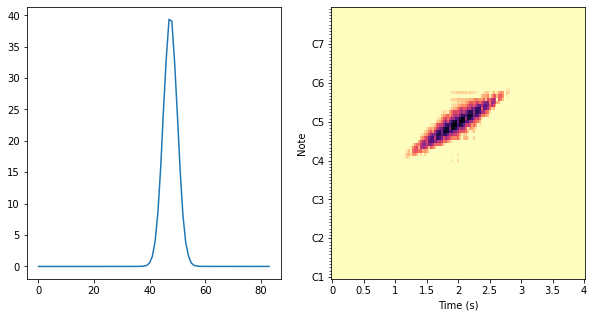

In [4]:
from IPython.display import Audio, display

from librosa.display import specshow

%matplotlib inline
f_c = 512
f_m = 4
gamma = 1
bw = 2
duration = 4
sr = 2**14

x = generate(f_c, f_m, gamma, bw, duration, sr)
C = np.abs(librosa.cqt(x, sr=sr))
t = np.arange(-duration/2, duration/2, 1/sr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.sum(C, axis=1))
plt.subplot(1, 2, 2)
specshow(librosa.amplitude_to_db(C), sr=sr, x_axis="time", y_axis="cqt_note", cmap="magma_r")
plt.xlabel("Time (s)")
display(Audio(x, rate=2**14))

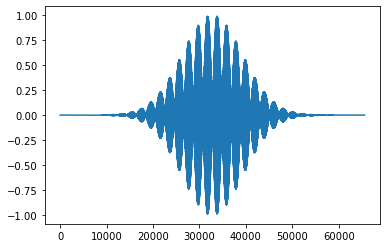

In [42]:
plt.plot(x)

f0 = 812.75 Hz ; fm =  4.39 Hz ; gamma =  1.52 oct/s


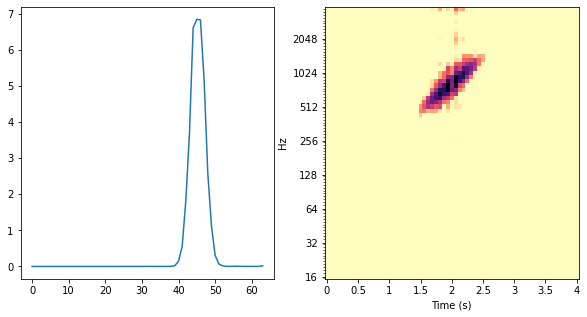

In [53]:
import random

f0s = np.logspace(np.log10(512), np.log10(1024), 16)
fms = np.logspace(np.log10(4), np.log10(16), 16)
gammas = np.logspace(np.log10(0.5), np.log10(4), 16)

duration, sr = 4, 2**13
f0 = random.choice(f0s)
fm = random.choice(fms)
gamma = random.choice(gammas)

x = generate(f0, fm, gamma, bw=bw, sr=sr, duration=duration)
C = np.abs(librosa.cqt(x, sr=sr, fmin=16, bins_per_octave=8, n_bins=8*8))
t = np.arange(-duration/2, duration/2, 1/sr)
print("f0 = {:5.2f} Hz ; fm = {:5.2f} Hz ; gamma = {:5.2f} oct/s".format(
    f0, fm, gamma))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.sum(C, axis=1))
plt.subplot(1, 2, 2)
specshow(
    librosa.amplitude_to_db(C),
    sr=sr, x_axis="time", y_axis="cqt_hz", cmap="magma_r",
    fmin=16, bins_per_octave=8)
plt.xlabel("Time (s)")
display(Audio(x, rate=sr))

**MFCC**

In [76]:
import tqdm

audio = np.zeros((len(f0s), len(fms), len(gammas), duration * sr))
cmap = np.zeros((3, len(f0s) * len(fms) * len(gammas)))
c = 0
for i, f0 in tqdm.tqdm(enumerate(f0s)):
    for j, fm in enumerate(fms):
        for k, gamma in enumerate(gammas):
            audio[i, j, k, :] = generate(f0, fm, gamma, sr=sr, duration=duration)
            audio[i, j, k, :] = audio[i, j, k, :] / np.linalg.norm(audio[i, j, k, :])
            cmap[0, c], cmap[1, c], cmap[2, c] = f0, fm, gamma
            c += 1

16it [00:07,  2.24it/s]


In [77]:
mfcc = np.zeros((len(f0s), len(fms), len(gammas), 20))

for i, f0 in tqdm.tqdm(enumerate(f0s)):
    for j, fm in enumerate(fms):
        for k, gamma in enumerate(gammas):
            mfcc[i,j,k,:] = np.mean(librosa.feature.mfcc(
                y=audio[i,j,k], sr=sr), axis=-1)

16it [00:18,  1.16s/it]


In [78]:
def plot_isomap(Y, cmap):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[0], cmap='bwr');
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # f modulator
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[1], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # chirp rate
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[2], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)

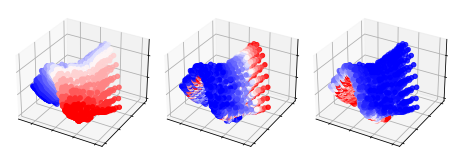

In [94]:
from sklearn.manifold import Isomap

models = {}
X = {}
Y = {}
ratios = {}

X["mfcc"] = mfcc.reshape(-1, mfcc.shape[-1])
N = X["mfcc"].shape[0]

for feat in ["mfcc"]:
    models[feat] = Isomap(n_components=3, n_neighbors=40)
    Y[feat] = embedding.fit_transform(X[feat])
    plot_isomap(Y[feat], cmap)
    knn = embedding.nbrs_.kneighbors()
    ratios[feat] = np.vstack([
        np.exp(np.mean(np.log(cmap[:, knn[1][i, :]]), axis=1)) / cmap[:, i]
        for i in range(N)
    ])

In [121]:
import os
os.makedirs("../data/mfcc", exist_ok=True)

for i in tqdm.tqdm(range(mfcc.reshape(-1, mfcc.shape[-1]).shape[0])):
    np.save(f'../data/mfcc/{i}', mfcc.reshape(-1, mfcc.shape[-1])[i])

100%|█████████████████████████████████████| 4096/4096 [00:00<00:00, 5078.48it/s]


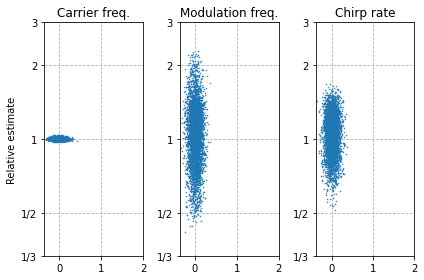

In [102]:
from fractions import Fraction
yticklabels = ["1/3", "1/2", "1", "2", "3"]
objs = ["Carrier freq.", "Modulation freq.", "Chirp rate"]

for obj in range(3):
    plt.subplot(1, 3, 1+obj)
    plt.plot(np.random.randn(N)*0.1, np.log2(ratios["mfcc"][:, obj]), ".", markersize=1)
    plt.yticks(np.log2(np.array([float(Fraction(label)) for label in yticklabels])))
    plt.xticks([0, 1, 2])
    #plt.gca().set_xticklabels(["MFCC"])
    plt.gca().set_yticklabels(yticklabels)
    plt.grid(linestyle="--")
    plt.title(objs[obj])
    if obj==0:
        plt.ylabel("Relative estimate")
    
plt.tight_layout()

**STRF**

In [128]:
sys.path.insert(1, '/Users/user/strf-like-model')

In [129]:
import auditory

In [130]:
X = audio.reshape((-1, audio.shape[-1]))

In [131]:
n_samples = X.shape[0]
S = auditory.strf(X[0, :], audio_fs=sr, duration=1)
S = np.concatenate((
    S[0].reshape((S[0].shape[0], S[0].shape[1], -1)),
    S[1][:, :, np.newaxis]),
    axis=-1).mean(axis=0)
n_freqs, n_paths = S.shape
sx = np.zeros((n_samples, n_freqs, n_paths))

for i in tqdm.tqdm(range(n_samples)):
    S = auditory.strf(X[i], audio_fs=sr, duration=1)
    S = np.concatenate((
        S[0].reshape((S[0].shape[0], S[0].shape[1], -1)),
        S[1][:, :, np.newaxis]),
        axis=-1).mean(axis=0)
    sx[i, :] = S

16000


  0%|                                                  | 0/4096 [00:00<?, ?it/s]

16000


/var/folders/fv/kkm71l3d1rx_kjd66cmfpg8r0000gp/T/ipykernel_3097/4084917156.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  sx[i, :] = S
  0%|                                          | 1/4096 [00:00<47:38,  1.43it/s]

16000


  0%|                                          | 2/4096 [00:01<47:21,  1.44it/s]

16000


  0%|                                          | 3/4096 [00:02<48:20,  1.41it/s]

16000


  0%|                                          | 4/4096 [00:02<48:17,  1.41it/s]

16000


  0%|                                          | 5/4096 [00:03<47:52,  1.42it/s]

16000


  0%|                                          | 6/4096 [00:04<47:49,  1.43it/s]

16000


  0%|                                          | 7/4096 [00:04<47:58,  1.42it/s]

16000


  0%|                                          | 8/4096 [00:05<48:15,  1.41it/s]

16000


  0%|                                          | 9/4096 [00:06<48:39,  1.40it/s]

16000


  0%|                                         | 10/4096 [00:07<49:28,  1.38it/s]

16000


  0%|                                         | 11/4096 [00:07<49:44,  1.37it/s]

16000


  0%|                                         | 12/4096 [00:08<49:36,  1.37it/s]

16000


  0%|▏                                        | 13/4096 [00:09<49:24,  1.38it/s]

16000


  0%|▏                                        | 14/4096 [00:09<48:42,  1.40it/s]

16000


  0%|▏                                        | 15/4096 [00:10<48:54,  1.39it/s]

16000


  0%|▏                                        | 16/4096 [00:11<48:54,  1.39it/s]

16000


  0%|▏                                        | 17/4096 [00:12<49:31,  1.37it/s]

16000


  0%|▏                                        | 18/4096 [00:12<49:55,  1.36it/s]

16000


  0%|▏                                        | 19/4096 [00:13<50:02,  1.36it/s]

16000


  0%|▏                                        | 20/4096 [00:14<49:55,  1.36it/s]

16000


  1%|▏                                        | 21/4096 [00:15<50:28,  1.35it/s]

16000


  1%|▏                                        | 22/4096 [00:15<51:27,  1.32it/s]

16000


  1%|▏                                        | 23/4096 [00:16<51:57,  1.31it/s]

16000


  1%|▏                                        | 24/4096 [00:17<51:14,  1.32it/s]

16000


  1%|▎                                        | 25/4096 [00:18<50:51,  1.33it/s]

16000


  1%|▎                                        | 26/4096 [00:18<50:37,  1.34it/s]

16000


  1%|▎                                        | 27/4096 [00:19<50:29,  1.34it/s]

16000


  1%|▎                                        | 28/4096 [00:20<51:38,  1.31it/s]

16000


  1%|▎                                        | 29/4096 [00:21<52:27,  1.29it/s]

16000


  1%|▎                                        | 30/4096 [00:22<52:03,  1.30it/s]

16000


  1%|▎                                        | 31/4096 [00:22<51:44,  1.31it/s]

16000


  1%|▎                                        | 32/4096 [00:23<51:13,  1.32it/s]

16000


  1%|▎                                        | 33/4096 [00:24<50:47,  1.33it/s]

16000


  1%|▎                                        | 34/4096 [00:25<50:24,  1.34it/s]

16000


  1%|▎                                        | 35/4096 [00:25<50:45,  1.33it/s]

16000


  1%|▎                                        | 36/4096 [00:26<50:49,  1.33it/s]

16000


  1%|▎                                        | 37/4096 [00:27<50:37,  1.34it/s]

16000


  1%|▍                                        | 38/4096 [00:28<51:52,  1.30it/s]

16000


  1%|▍                                        | 39/4096 [00:28<53:38,  1.26it/s]

16000


  1%|▍                                        | 40/4096 [00:29<55:28,  1.22it/s]

16000


  1%|▍                                        | 41/4096 [00:30<54:27,  1.24it/s]

16000


  1%|▍                                        | 42/4096 [00:31<53:41,  1.26it/s]

16000


  1%|▍                                        | 43/4096 [00:32<52:05,  1.30it/s]

16000


  1%|▍                                        | 44/4096 [00:32<50:56,  1.33it/s]

16000


  1%|▍                                        | 45/4096 [00:33<51:01,  1.32it/s]

16000


  1%|▍                                        | 46/4096 [00:34<50:47,  1.33it/s]

16000


  1%|▍                                        | 47/4096 [00:35<51:10,  1.32it/s]

16000


  1%|▍                                        | 48/4096 [00:35<54:09,  1.25it/s]

16000


  1%|▍                                        | 49/4096 [00:36<54:09,  1.25it/s]

16000


  1%|▌                                        | 50/4096 [00:37<54:31,  1.24it/s]

16000


  1%|▌                                        | 51/4096 [00:38<55:16,  1.22it/s]

16000


  1%|▌                                        | 52/4096 [00:39<55:18,  1.22it/s]

16000


  1%|▌                                        | 53/4096 [00:40<54:13,  1.24it/s]

16000


  1%|▌                                        | 54/4096 [00:40<52:58,  1.27it/s]

16000


  1%|▌                                        | 55/4096 [00:41<51:20,  1.31it/s]

16000


  1%|▌                                        | 56/4096 [00:42<50:34,  1.33it/s]

16000


  1%|▌                                        | 57/4096 [00:42<50:29,  1.33it/s]

16000


  1%|▌                                        | 58/4096 [00:43<49:54,  1.35it/s]

16000


  1%|▌                                        | 59/4096 [00:44<49:22,  1.36it/s]

16000


  1%|▌                                        | 60/4096 [00:45<49:43,  1.35it/s]

16000


  1%|▌                                        | 61/4096 [00:45<50:05,  1.34it/s]

16000


  2%|▌                                        | 62/4096 [00:46<53:03,  1.27it/s]

16000


  2%|▋                                        | 63/4096 [00:47<53:03,  1.27it/s]

16000


  2%|▋                                        | 64/4096 [00:48<52:32,  1.28it/s]

16000


  2%|▋                                        | 65/4096 [00:49<51:40,  1.30it/s]

16000


  2%|▋                                        | 66/4096 [00:49<51:03,  1.32it/s]

16000


  2%|▋                                        | 67/4096 [00:50<50:51,  1.32it/s]

16000


  2%|▋                                        | 68/4096 [00:51<50:44,  1.32it/s]

16000


  2%|▋                                        | 69/4096 [00:52<50:25,  1.33it/s]

16000


  2%|▋                                        | 70/4096 [00:52<50:11,  1.34it/s]

16000


  2%|▋                                        | 71/4096 [00:53<51:25,  1.30it/s]

16000


  2%|▋                                        | 72/4096 [00:54<51:09,  1.31it/s]

16000


  2%|▋                                        | 73/4096 [00:55<50:34,  1.33it/s]

16000


  2%|▋                                        | 74/4096 [00:55<51:17,  1.31it/s]

16000


  2%|▊                                        | 75/4096 [00:56<51:29,  1.30it/s]

16000


  2%|▊                                        | 76/4096 [00:57<51:50,  1.29it/s]

16000


  2%|▊                                        | 77/4096 [00:58<51:53,  1.29it/s]

16000


  2%|▊                                        | 78/4096 [00:59<51:46,  1.29it/s]

16000


  2%|▊                                        | 79/4096 [00:59<51:27,  1.30it/s]

16000


  2%|▊                                        | 80/4096 [01:00<51:09,  1.31it/s]

16000


  2%|▊                                        | 81/4096 [01:01<51:20,  1.30it/s]

16000


  2%|▊                                        | 82/4096 [01:02<50:28,  1.33it/s]

16000


  2%|▊                                        | 83/4096 [01:02<49:48,  1.34it/s]

16000


  2%|▊                                        | 84/4096 [01:03<49:16,  1.36it/s]

16000


  2%|▊                                        | 85/4096 [01:04<48:59,  1.36it/s]

16000


  2%|▊                                        | 86/4096 [01:04<48:38,  1.37it/s]

16000


  2%|▊                                        | 87/4096 [01:05<48:41,  1.37it/s]

16000


  2%|▉                                        | 88/4096 [01:06<48:36,  1.37it/s]

16000


  2%|▉                                        | 89/4096 [01:07<49:01,  1.36it/s]

16000


  2%|▉                                        | 90/4096 [01:07<48:51,  1.37it/s]

16000


  2%|▉                                        | 91/4096 [01:08<49:55,  1.34it/s]

16000


  2%|▉                                        | 92/4096 [01:09<49:56,  1.34it/s]

16000


  2%|▉                                        | 93/4096 [01:10<49:25,  1.35it/s]

16000


  2%|▉                                        | 94/4096 [01:10<49:21,  1.35it/s]

16000


  2%|▉                                        | 95/4096 [01:11<49:02,  1.36it/s]

16000


  2%|▉                                        | 96/4096 [01:12<49:18,  1.35it/s]

16000


  2%|▉                                        | 97/4096 [01:13<48:47,  1.37it/s]

16000


  2%|▉                                        | 98/4096 [01:13<48:35,  1.37it/s]

16000


  2%|▉                                        | 99/4096 [01:14<48:14,  1.38it/s]

16000


  2%|▉                                       | 100/4096 [01:15<48:04,  1.39it/s]

16000


  2%|▉                                       | 101/4096 [01:15<48:02,  1.39it/s]

16000


  2%|▉                                       | 102/4096 [01:16<48:00,  1.39it/s]

16000


  3%|█                                       | 103/4096 [01:17<47:42,  1.39it/s]

16000


  3%|█                                       | 104/4096 [01:18<47:32,  1.40it/s]

16000


  3%|█                                       | 105/4096 [01:18<47:45,  1.39it/s]

16000


  3%|█                                       | 106/4096 [01:19<47:38,  1.40it/s]

16000


  3%|█                                       | 107/4096 [01:20<47:39,  1.39it/s]

16000


  3%|█                                       | 108/4096 [01:20<47:34,  1.40it/s]

16000


  3%|█                                       | 109/4096 [01:21<47:24,  1.40it/s]

16000


  3%|█                                       | 110/4096 [01:22<47:18,  1.40it/s]

16000


  3%|█                                       | 111/4096 [01:23<47:19,  1.40it/s]

16000


  3%|█                                       | 112/4096 [01:23<47:15,  1.41it/s]

16000


  3%|█                                       | 113/4096 [01:24<47:57,  1.38it/s]

16000


  3%|█                                       | 114/4096 [01:25<48:38,  1.36it/s]

16000


  3%|█                                       | 115/4096 [01:25<48:48,  1.36it/s]

16000


  3%|█▏                                      | 116/4096 [01:26<51:21,  1.29it/s]

16000


  3%|█▏                                      | 117/4096 [01:27<52:07,  1.27it/s]

16000


  3%|█▏                                      | 118/4096 [01:28<51:37,  1.28it/s]

16000


  3%|█▏                                      | 119/4096 [01:29<51:44,  1.28it/s]

16000


  3%|█▏                                      | 120/4096 [01:29<51:38,  1.28it/s]

16000


  3%|█▏                                      | 121/4096 [01:30<53:25,  1.24it/s]

16000


  3%|█▏                                      | 122/4096 [01:31<52:25,  1.26it/s]

16000


  3%|█▏                                      | 123/4096 [01:32<51:02,  1.30it/s]

16000


  3%|█▏                                      | 124/4096 [01:33<50:07,  1.32it/s]

16000


  3%|█▏                                      | 125/4096 [01:33<49:02,  1.35it/s]

16000


  3%|█▏                                      | 126/4096 [01:34<48:36,  1.36it/s]

16000


  3%|█▏                                      | 127/4096 [01:35<48:02,  1.38it/s]

16000


  3%|█▎                                      | 128/4096 [01:35<47:44,  1.39it/s]

16000


  3%|█▎                                      | 129/4096 [01:36<48:17,  1.37it/s]

16000


  3%|█▎                                      | 130/4096 [01:37<48:30,  1.36it/s]

16000


  3%|█▎                                      | 131/4096 [01:38<48:04,  1.37it/s]

16000


  3%|█▎                                      | 132/4096 [01:38<47:43,  1.38it/s]

16000


  3%|█▎                                      | 133/4096 [01:39<47:31,  1.39it/s]

16000


  3%|█▎                                      | 134/4096 [01:40<47:20,  1.40it/s]

16000


  3%|█▎                                      | 135/4096 [01:40<47:13,  1.40it/s]

16000


  3%|█▎                                      | 136/4096 [01:41<47:16,  1.40it/s]

16000


  3%|█▎                                      | 137/4096 [01:42<47:04,  1.40it/s]

16000


  3%|█▎                                      | 138/4096 [01:43<47:02,  1.40it/s]

16000


  3%|█▎                                      | 139/4096 [01:43<47:00,  1.40it/s]

16000


  3%|█▎                                      | 140/4096 [01:44<46:56,  1.40it/s]

16000


  3%|█▍                                      | 141/4096 [01:45<47:00,  1.40it/s]

16000


  3%|█▍                                      | 142/4096 [01:45<47:03,  1.40it/s]

16000


  3%|█▍                                      | 143/4096 [01:46<46:59,  1.40it/s]

16000


  4%|█▍                                      | 144/4096 [01:47<47:01,  1.40it/s]

16000


  4%|█▍                                      | 145/4096 [01:48<47:00,  1.40it/s]

16000


  4%|█▍                                      | 146/4096 [01:48<47:28,  1.39it/s]

16000


  4%|█▍                                      | 147/4096 [01:49<47:19,  1.39it/s]

16000


  4%|█▍                                      | 148/4096 [01:50<47:08,  1.40it/s]

16000


  4%|█▍                                      | 149/4096 [01:50<47:06,  1.40it/s]

16000


  4%|█▍                                      | 150/4096 [01:51<46:54,  1.40it/s]

16000


  4%|█▍                                      | 151/4096 [01:52<46:52,  1.40it/s]

16000


  4%|█▍                                      | 152/4096 [01:53<46:52,  1.40it/s]

16000


  4%|█▍                                      | 153/4096 [01:53<48:01,  1.37it/s]

16000


  4%|█▌                                      | 154/4096 [01:54<47:38,  1.38it/s]

16000


  4%|█▌                                      | 155/4096 [01:55<47:18,  1.39it/s]

16000


  4%|█▌                                      | 156/4096 [01:55<46:52,  1.40it/s]

16000


  4%|█▌                                      | 157/4096 [01:56<46:37,  1.41it/s]

16000


  4%|█▌                                      | 158/4096 [01:57<46:35,  1.41it/s]

16000


  4%|█▌                                      | 159/4096 [01:58<46:26,  1.41it/s]

16000


  4%|█▌                                      | 160/4096 [01:58<46:42,  1.40it/s]

16000


  4%|█▌                                      | 161/4096 [01:59<47:30,  1.38it/s]

16000


  4%|█▌                                      | 162/4096 [02:00<48:08,  1.36it/s]

16000


  4%|█▌                                      | 163/4096 [02:01<48:25,  1.35it/s]

16000


  4%|█▌                                      | 164/4096 [02:01<48:18,  1.36it/s]

16000


  4%|█▌                                      | 165/4096 [02:02<48:13,  1.36it/s]

16000


  4%|█▌                                      | 166/4096 [02:03<47:51,  1.37it/s]

16000


  4%|█▋                                      | 167/4096 [02:03<47:38,  1.37it/s]

16000


  4%|█▋                                      | 168/4096 [02:04<47:27,  1.38it/s]

16000


  4%|█▋                                      | 169/4096 [02:05<47:12,  1.39it/s]

16000


  4%|█▋                                      | 170/4096 [02:06<47:06,  1.39it/s]

16000


  4%|█▋                                      | 171/4096 [02:06<47:03,  1.39it/s]

16000


  4%|█▋                                      | 172/4096 [02:07<47:02,  1.39it/s]

16000


  4%|█▋                                      | 173/4096 [02:08<48:15,  1.35it/s]

16000


  4%|█▋                                      | 174/4096 [02:09<49:04,  1.33it/s]

16000


  4%|█▋                                      | 175/4096 [02:09<48:53,  1.34it/s]

16000


  4%|█▋                                      | 176/4096 [02:10<48:42,  1.34it/s]

16000


  4%|█▋                                      | 177/4096 [02:11<48:13,  1.35it/s]

16000


  4%|█▋                                      | 178/4096 [02:12<48:29,  1.35it/s]

16000


  4%|█▋                                      | 179/4096 [02:12<48:13,  1.35it/s]

16000


  4%|█▊                                      | 180/4096 [02:13<48:30,  1.35it/s]

16000


  4%|█▊                                      | 181/4096 [02:14<48:05,  1.36it/s]

16000


  4%|█▊                                      | 182/4096 [02:15<47:35,  1.37it/s]

16000


  4%|█▊                                      | 183/4096 [02:15<47:09,  1.38it/s]

16000


  4%|█▊                                      | 184/4096 [02:16<47:11,  1.38it/s]

16000


  5%|█▊                                      | 185/4096 [02:17<47:22,  1.38it/s]

16000


  5%|█▊                                      | 186/4096 [02:17<47:41,  1.37it/s]

16000


  5%|█▊                                      | 187/4096 [02:18<47:59,  1.36it/s]

16000


  5%|█▊                                      | 188/4096 [02:19<48:36,  1.34it/s]

16000


  5%|█▊                                      | 189/4096 [02:20<48:43,  1.34it/s]

16000


  5%|█▊                                      | 190/4096 [02:20<48:59,  1.33it/s]

16000


  5%|█▊                                      | 191/4096 [02:21<50:05,  1.30it/s]

16000


  5%|█▉                                      | 192/4096 [02:22<49:33,  1.31it/s]

16000


  5%|█▉                                      | 193/4096 [02:23<48:46,  1.33it/s]

16000


  5%|█▉                                      | 194/4096 [02:23<48:00,  1.35it/s]

16000


  5%|█▉                                      | 195/4096 [02:24<48:22,  1.34it/s]

16000


  5%|█▉                                      | 196/4096 [02:25<49:01,  1.33it/s]

16000


  5%|█▉                                      | 197/4096 [02:26<48:26,  1.34it/s]

16000


  5%|█▉                                      | 198/4096 [02:26<48:15,  1.35it/s]

16000


  5%|█▉                                      | 199/4096 [02:27<48:24,  1.34it/s]

16000


  5%|█▉                                      | 200/4096 [02:28<47:40,  1.36it/s]

16000


  5%|█▉                                      | 201/4096 [02:29<47:05,  1.38it/s]

16000


  5%|█▉                                      | 202/4096 [02:29<47:15,  1.37it/s]

16000


  5%|█▉                                      | 203/4096 [02:30<47:15,  1.37it/s]

16000


  5%|█▉                                      | 204/4096 [02:31<48:14,  1.34it/s]

16000


  5%|██                                      | 205/4096 [02:32<47:34,  1.36it/s]

16000


  5%|██                                      | 206/4096 [02:32<47:25,  1.37it/s]

16000


  5%|██                                      | 207/4096 [02:33<47:18,  1.37it/s]

16000


  5%|██                                      | 208/4096 [02:34<46:51,  1.38it/s]

16000


  5%|██                                      | 209/4096 [02:34<46:33,  1.39it/s]

16000


  5%|██                                      | 210/4096 [02:35<46:25,  1.39it/s]

16000


  5%|██                                      | 211/4096 [02:36<46:23,  1.40it/s]

16000


  5%|██                                      | 212/4096 [02:37<46:24,  1.40it/s]

16000


  5%|██                                      | 213/4096 [02:37<46:37,  1.39it/s]

16000


  5%|██                                      | 214/4096 [02:38<46:15,  1.40it/s]

16000


  5%|██                                      | 215/4096 [02:39<46:08,  1.40it/s]

16000


  5%|██                                      | 216/4096 [02:39<45:55,  1.41it/s]

16000


  5%|██                                      | 217/4096 [02:40<45:47,  1.41it/s]

16000


  5%|██▏                                     | 218/4096 [02:41<45:43,  1.41it/s]

16000


  5%|██▏                                     | 219/4096 [02:42<45:38,  1.42it/s]

16000


  5%|██▏                                     | 220/4096 [02:42<45:30,  1.42it/s]

16000


  5%|██▏                                     | 221/4096 [02:44<58:08,  1.11it/s]

16000


  5%|██▏                                     | 222/4096 [02:45<59:29,  1.09it/s]

16000


  5%|██▏                                     | 223/4096 [02:45<58:06,  1.11it/s]

16000


  5%|██▏                                     | 224/4096 [02:46<56:02,  1.15it/s]

16000


  5%|██▏                                     | 225/4096 [02:47<53:18,  1.21it/s]

16000


  6%|██▏                                     | 226/4096 [02:48<52:43,  1.22it/s]

16000


  6%|██▏                                     | 227/4096 [02:48<51:34,  1.25it/s]

16000


  6%|██▏                                     | 228/4096 [02:49<50:03,  1.29it/s]

16000


  6%|██▏                                     | 229/4096 [02:50<48:56,  1.32it/s]

16000


  6%|██▏                                     | 230/4096 [02:51<47:58,  1.34it/s]

16000


  6%|██▎                                     | 231/4096 [02:51<47:12,  1.36it/s]

16000


  6%|██▎                                     | 232/4096 [02:52<46:56,  1.37it/s]

16000


  6%|██▎                                     | 233/4096 [02:53<47:08,  1.37it/s]

16000


  6%|██▎                                     | 234/4096 [02:54<47:20,  1.36it/s]

16000


  6%|██▎                                     | 235/4096 [02:54<46:45,  1.38it/s]

16000


  6%|██▎                                     | 236/4096 [02:55<46:22,  1.39it/s]

16000


  6%|██▎                                     | 237/4096 [02:56<45:57,  1.40it/s]

16000


  6%|██▎                                     | 238/4096 [02:56<45:39,  1.41it/s]

16000


  6%|██▎                                     | 239/4096 [02:57<45:29,  1.41it/s]

16000


  6%|██▎                                     | 240/4096 [02:58<45:26,  1.41it/s]

16000


  6%|██▎                                     | 241/4096 [02:58<45:22,  1.42it/s]

16000


  6%|██▎                                     | 242/4096 [02:59<45:21,  1.42it/s]

16000


  6%|██▎                                     | 243/4096 [03:00<45:18,  1.42it/s]

16000


  6%|██▍                                     | 244/4096 [03:01<45:14,  1.42it/s]

16000


  6%|██▍                                     | 245/4096 [03:01<45:05,  1.42it/s]

16000


  6%|██▍                                     | 246/4096 [03:02<45:18,  1.42it/s]

16000


  6%|██▍                                     | 247/4096 [03:03<45:06,  1.42it/s]

16000


  6%|██▍                                     | 248/4096 [03:03<45:00,  1.42it/s]

16000


  6%|██▍                                     | 249/4096 [03:04<44:57,  1.43it/s]

16000


  6%|██▍                                     | 250/4096 [03:05<44:52,  1.43it/s]

16000


  6%|██▍                                     | 251/4096 [03:05<44:50,  1.43it/s]

16000


  6%|██▍                                     | 252/4096 [03:06<45:07,  1.42it/s]

16000


  6%|██▍                                     | 253/4096 [03:07<45:03,  1.42it/s]

16000


  6%|██▍                                     | 254/4096 [03:08<45:02,  1.42it/s]

16000


  6%|██▍                                     | 255/4096 [03:08<44:58,  1.42it/s]

16000


  6%|██▌                                     | 256/4096 [03:09<45:06,  1.42it/s]

16000


  6%|██▌                                     | 257/4096 [03:10<45:22,  1.41it/s]

16000


  6%|██▌                                     | 258/4096 [03:10<45:13,  1.41it/s]

16000


  6%|██▌                                     | 259/4096 [03:11<45:06,  1.42it/s]

16000


  6%|██▌                                     | 260/4096 [03:12<45:04,  1.42it/s]

16000


  6%|██▌                                     | 261/4096 [03:13<44:55,  1.42it/s]

16000


  6%|██▌                                     | 262/4096 [03:13<44:50,  1.43it/s]

16000


  6%|██▌                                     | 263/4096 [03:14<45:06,  1.42it/s]

16000


  6%|██▌                                     | 264/4096 [03:15<44:59,  1.42it/s]

16000


  6%|██▌                                     | 265/4096 [03:15<44:48,  1.42it/s]

16000


  6%|██▌                                     | 266/4096 [03:16<44:51,  1.42it/s]

16000


  7%|██▌                                     | 267/4096 [03:17<44:41,  1.43it/s]

16000


  7%|██▌                                     | 268/4096 [03:17<44:38,  1.43it/s]

16000


  7%|██▋                                     | 269/4096 [03:18<44:34,  1.43it/s]

16000


  7%|██▋                                     | 270/4096 [03:19<44:37,  1.43it/s]

16000


  7%|██▋                                     | 271/4096 [03:20<44:34,  1.43it/s]

16000


  7%|██▋                                     | 272/4096 [03:20<44:30,  1.43it/s]

16000


  7%|██▋                                     | 273/4096 [03:21<44:35,  1.43it/s]

16000


  7%|██▋                                     | 274/4096 [03:22<44:44,  1.42it/s]

16000


  7%|██▋                                     | 275/4096 [03:22<44:40,  1.43it/s]

16000


  7%|██▋                                     | 276/4096 [03:23<44:48,  1.42it/s]

16000


  7%|██▋                                     | 277/4096 [03:24<44:39,  1.43it/s]

16000


  7%|██▋                                     | 278/4096 [03:24<44:39,  1.42it/s]

16000


  7%|██▋                                     | 279/4096 [03:25<44:32,  1.43it/s]

16000


  7%|██▋                                     | 280/4096 [03:26<44:38,  1.42it/s]

16000


  7%|██▋                                     | 281/4096 [03:27<44:41,  1.42it/s]

16000


  7%|██▊                                     | 282/4096 [03:27<44:36,  1.43it/s]

16000


  7%|██▊                                     | 283/4096 [03:28<44:29,  1.43it/s]

16000


  7%|██▊                                     | 284/4096 [03:29<44:25,  1.43it/s]

16000


  7%|██▊                                     | 285/4096 [03:29<44:31,  1.43it/s]

16000


  7%|██▊                                     | 286/4096 [03:30<44:22,  1.43it/s]

16000


  7%|██▊                                     | 287/4096 [03:31<44:24,  1.43it/s]

16000


  7%|██▊                                     | 288/4096 [03:31<44:18,  1.43it/s]

16000


  7%|██▊                                     | 289/4096 [03:32<44:24,  1.43it/s]

16000


  7%|██▊                                     | 290/4096 [03:33<44:25,  1.43it/s]

16000


  7%|██▊                                     | 291/4096 [03:34<44:22,  1.43it/s]

16000


  7%|██▊                                     | 292/4096 [03:34<44:22,  1.43it/s]

16000


  7%|██▊                                     | 293/4096 [03:35<44:22,  1.43it/s]

16000


  7%|██▊                                     | 294/4096 [03:36<44:17,  1.43it/s]

16000


  7%|██▉                                     | 295/4096 [03:36<44:12,  1.43it/s]

16000


  7%|██▉                                     | 296/4096 [03:37<44:05,  1.44it/s]

16000


  7%|██▉                                     | 297/4096 [03:38<44:00,  1.44it/s]

16000


  7%|██▉                                     | 298/4096 [03:38<44:03,  1.44it/s]

16000


  7%|██▉                                     | 299/4096 [03:39<44:39,  1.42it/s]

16000


  7%|██▉                                     | 300/4096 [03:40<44:28,  1.42it/s]

16000


  7%|██▉                                     | 301/4096 [03:41<44:17,  1.43it/s]

16000


  7%|██▉                                     | 302/4096 [03:41<45:48,  1.38it/s]

16000


  7%|██▉                                     | 303/4096 [03:42<45:19,  1.39it/s]

16000


  7%|██▉                                     | 304/4096 [03:43<44:56,  1.41it/s]

16000


  7%|██▉                                     | 305/4096 [03:43<44:46,  1.41it/s]

16000


  7%|██▉                                     | 306/4096 [03:44<44:36,  1.42it/s]

16000


  7%|██▉                                     | 307/4096 [03:45<44:49,  1.41it/s]

16000


  8%|███                                     | 308/4096 [03:46<47:54,  1.32it/s]

16000


  8%|███                                     | 309/4096 [03:47<48:09,  1.31it/s]

16000


  8%|███                                     | 310/4096 [03:47<47:41,  1.32it/s]

16000


  8%|███                                     | 311/4096 [03:48<46:50,  1.35it/s]

16000


  8%|███                                     | 312/4096 [03:49<45:51,  1.38it/s]

16000


  8%|███                                     | 313/4096 [03:49<45:30,  1.39it/s]

16000


  8%|███                                     | 314/4096 [03:50<44:24,  1.42it/s]

16000


  8%|███                                     | 315/4096 [03:51<43:58,  1.43it/s]

16000


  8%|███                                     | 316/4096 [03:51<43:21,  1.45it/s]

16000


  8%|███                                     | 317/4096 [03:52<42:49,  1.47it/s]

16000


  8%|███                                     | 318/4096 [03:53<42:40,  1.48it/s]

16000


  8%|███                                     | 319/4096 [03:53<42:23,  1.48it/s]

16000


  8%|███▏                                    | 320/4096 [03:54<42:11,  1.49it/s]

16000


  8%|███▏                                    | 321/4096 [03:55<42:10,  1.49it/s]

16000


  8%|███▏                                    | 322/4096 [03:55<42:34,  1.48it/s]

16000


  8%|███▏                                    | 323/4096 [03:56<42:20,  1.49it/s]

16000


  8%|███▏                                    | 324/4096 [03:57<42:08,  1.49it/s]

16000


  8%|███▏                                    | 325/4096 [03:57<42:03,  1.49it/s]

16000


  8%|███▏                                    | 326/4096 [03:58<42:06,  1.49it/s]

16000


  8%|███▏                                    | 327/4096 [03:59<41:58,  1.50it/s]

16000


  8%|███▏                                    | 328/4096 [03:59<41:54,  1.50it/s]

16000


  8%|███▏                                    | 329/4096 [04:00<41:46,  1.50it/s]

16000


  8%|███▏                                    | 330/4096 [04:01<41:54,  1.50it/s]

16000


  8%|███▏                                    | 331/4096 [04:01<42:03,  1.49it/s]

16000


  8%|███▏                                    | 332/4096 [04:02<41:54,  1.50it/s]

16000


  8%|███▎                                    | 333/4096 [04:03<41:48,  1.50it/s]

16000


  8%|███▎                                    | 334/4096 [04:03<41:51,  1.50it/s]

16000


  8%|███▎                                    | 335/4096 [04:04<41:45,  1.50it/s]

16000


  8%|███▎                                    | 336/4096 [04:05<41:39,  1.50it/s]

16000


  8%|███▎                                    | 337/4096 [04:05<41:36,  1.51it/s]

16000


  8%|███▎                                    | 338/4096 [04:06<41:42,  1.50it/s]

16000


  8%|███▎                                    | 339/4096 [04:07<41:40,  1.50it/s]

16000


  8%|███▎                                    | 340/4096 [04:07<41:47,  1.50it/s]

16000


  8%|███▎                                    | 341/4096 [04:08<41:45,  1.50it/s]

16000


  8%|███▎                                    | 342/4096 [04:09<41:42,  1.50it/s]

16000


  8%|███▎                                    | 343/4096 [04:09<41:35,  1.50it/s]

16000


  8%|███▎                                    | 344/4096 [04:10<41:28,  1.51it/s]

16000


  8%|███▎                                    | 345/4096 [04:11<41:36,  1.50it/s]

16000


  8%|███▍                                    | 346/4096 [04:11<41:27,  1.51it/s]

16000


  8%|███▍                                    | 347/4096 [04:12<41:25,  1.51it/s]

16000


  8%|███▍                                    | 348/4096 [04:13<41:21,  1.51it/s]

16000


  9%|███▍                                    | 349/4096 [04:13<41:39,  1.50it/s]

16000


  9%|███▍                                    | 350/4096 [04:14<41:32,  1.50it/s]

16000


  9%|███▍                                    | 351/4096 [04:15<41:24,  1.51it/s]

16000


  9%|███▍                                    | 352/4096 [04:15<41:16,  1.51it/s]

16000


  9%|███▍                                    | 353/4096 [04:16<41:37,  1.50it/s]

16000


  9%|███▍                                    | 354/4096 [04:17<41:33,  1.50it/s]

16000


  9%|███▍                                    | 355/4096 [04:17<41:25,  1.51it/s]

16000


  9%|███▍                                    | 356/4096 [04:18<41:22,  1.51it/s]

16000


  9%|███▍                                    | 357/4096 [04:19<41:20,  1.51it/s]

16000


  9%|███▍                                    | 358/4096 [04:19<41:38,  1.50it/s]

16000


  9%|███▌                                    | 359/4096 [04:20<41:31,  1.50it/s]

16000


  9%|███▌                                    | 360/4096 [04:21<41:47,  1.49it/s]

16000


  9%|██▋                            | 361/4096 [2:39:39<2900:52:13, 2796.02s/it]

16000


  9%|██▋                            | 362/4096 [2:39:41<2030:33:09, 1957.68s/it]

16000


  9%|██▋                            | 363/4096 [2:39:42<1421:15:31, 1370.62s/it]

16000


  9%|██▉                              | 364/4096 [2:39:42<994:50:06, 959.65s/it]

16000


  9%|██▉                              | 365/4096 [2:39:43<696:24:38, 671.96s/it]

16000


  9%|██▉                              | 366/4096 [2:39:44<487:33:48, 470.57s/it]

16000


  9%|██▉                              | 367/4096 [2:40:48<361:04:52, 348.59s/it]

16000


  9%|██▉                              | 368/4096 [2:40:50<253:19:05, 244.62s/it]

16000


  9%|██▉                              | 369/4096 [2:40:51<177:47:35, 171.73s/it]

16000


  9%|██▉                              | 370/4096 [2:40:54<125:07:52, 120.90s/it]

16000


  9%|███▏                               | 371/4096 [2:40:55<87:53:05, 84.94s/it]

16000


  9%|███▏                               | 372/4096 [2:40:56<61:49:07, 59.76s/it]

16000


  9%|██▌                         | 373/4096 [11:57:09<10397:17:03, 10053.78s/it]

16000


  9%|██▋                           | 374/4096 [11:57:11<7276:47:41, 7038.28s/it]

16000


  9%|██▋                           | 375/4096 [11:57:12<5092:45:28, 4927.15s/it]

16000


  9%|██▊                           | 376/4096 [12:00:20<3622:17:23, 3505.44s/it]

16000


  9%|██▊                           | 377/4096 [12:00:24<2536:06:26, 2454.96s/it]

16000


  9%|██▊                           | 378/4096 [12:00:25<1775:13:11, 1718.88s/it]

16000


  9%|██▊                           | 379/4096 [12:00:26<1242:38:49, 1203.53s/it]

16000


  9%|██▉                             | 380/4096 [12:00:28<869:57:02, 842.79s/it]

16000


  9%|██▉                             | 381/4096 [12:00:29<609:13:17, 590.36s/it]

16000


  9%|██▉                             | 382/4096 [12:00:30<426:40:32, 413.58s/it]

16000


  9%|██▉                             | 383/4096 [12:00:31<298:55:08, 289.82s/it]

16000


  9%|███                             | 384/4096 [12:00:32<209:29:09, 203.17s/it]

16000


  9%|███                             | 385/4096 [12:00:33<146:54:38, 142.52s/it]

16000


  9%|███                             | 386/4096 [12:00:34<103:04:06, 100.01s/it]

16000


  9%|███▏                              | 387/4096 [12:00:35<72:22:12, 70.24s/it]

16000


  9%|███▏                              | 388/4096 [12:00:35<50:53:42, 49.41s/it]

16000


  9%|███▏                              | 389/4096 [12:00:36<35:51:54, 34.83s/it]

16000


 10%|███▏                              | 390/4096 [12:00:37<25:20:32, 24.62s/it]

16000


 10%|███▏                              | 391/4096 [12:00:38<17:59:08, 17.48s/it]

16000


 10%|███▎                              | 392/4096 [12:00:39<13:00:35, 12.64s/it]

16000


 10%|███▎                               | 393/4096 [12:00:40<9:27:08,  9.19s/it]

16000


 10%|███▎                               | 394/4096 [12:00:41<6:53:25,  6.70s/it]

16000


 10%|███▍                               | 395/4096 [12:00:42<5:03:54,  4.93s/it]

16000


 10%|███▍                               | 396/4096 [12:00:43<3:46:43,  3.68s/it]

16000


 10%|███▍                               | 397/4096 [12:00:44<2:53:47,  2.82s/it]

16000


 10%|███▍                               | 398/4096 [12:00:44<2:15:52,  2.20s/it]

16000


 10%|███▍                               | 399/4096 [12:00:45<1:49:39,  1.78s/it]

16000


 10%|███▍                               | 400/4096 [12:00:46<1:30:55,  1.48s/it]

16000


 10%|███▍                               | 401/4096 [12:00:47<1:17:39,  1.26s/it]

16000


 10%|███▍                               | 402/4096 [12:00:47<1:08:38,  1.12s/it]

16000


 10%|███▍                               | 403/4096 [12:00:48<1:02:06,  1.01s/it]

16000


 10%|███▋                                 | 404/4096 [12:00:49<57:21,  1.07it/s]

16000


 10%|███▋                                 | 405/4096 [12:00:50<53:04,  1.16it/s]

16000


 10%|███▋                                 | 406/4096 [12:00:51<54:46,  1.12it/s]

16000


 10%|███▋                                 | 407/4096 [12:00:51<52:30,  1.17it/s]

16000


 10%|███▋                                 | 408/4096 [12:00:52<50:07,  1.23it/s]

16000


 10%|███▋                                 | 409/4096 [12:00:53<47:47,  1.29it/s]

16000


 10%|███▋                                 | 410/4096 [12:00:54<47:56,  1.28it/s]

16000


 10%|███▋                                 | 411/4096 [12:00:54<47:55,  1.28it/s]

16000


 10%|███▋                                 | 412/4096 [12:00:55<47:59,  1.28it/s]

16000


 10%|███▋                                 | 413/4096 [12:00:56<47:29,  1.29it/s]

16000


 10%|███▋                                 | 414/4096 [12:00:57<46:57,  1.31it/s]

16000


 10%|███▋                                 | 415/4096 [12:00:57<46:21,  1.32it/s]

16000


 10%|███▊                                 | 416/4096 [12:00:58<46:06,  1.33it/s]

16000


 10%|███▊                                 | 417/4096 [12:00:59<45:46,  1.34it/s]

16000


 10%|███▊                                 | 418/4096 [12:01:00<45:08,  1.36it/s]

16000


 10%|███▊                                 | 419/4096 [12:01:00<44:45,  1.37it/s]

16000


 10%|███▊                                 | 420/4096 [12:01:01<44:42,  1.37it/s]

16000


 10%|███▊                                 | 421/4096 [12:01:02<44:55,  1.36it/s]

16000


 10%|███▊                                 | 422/4096 [12:01:02<45:07,  1.36it/s]

16000


 10%|███▊                                 | 423/4096 [12:01:03<46:16,  1.32it/s]

16000


 10%|███▊                                 | 424/4096 [12:01:04<46:35,  1.31it/s]

16000


 10%|███▊                                 | 425/4096 [12:01:05<46:53,  1.30it/s]

16000


 10%|███▊                                 | 426/4096 [12:01:06<47:03,  1.30it/s]

16000


 10%|███▊                                 | 427/4096 [12:01:06<45:58,  1.33it/s]

16000


 10%|███▊                                 | 428/4096 [12:01:07<44:59,  1.36it/s]

16000


 10%|███▉                                 | 429/4096 [12:01:08<44:27,  1.37it/s]

16000


 10%|███▉                                 | 430/4096 [12:01:08<43:32,  1.40it/s]

16000


 11%|███▉                                 | 431/4096 [12:01:09<42:41,  1.43it/s]

16000


 11%|███▉                                 | 432/4096 [12:01:10<42:04,  1.45it/s]

16000


 11%|███▉                                 | 433/4096 [12:01:10<41:50,  1.46it/s]

16000


 11%|███▉                                 | 434/4096 [12:01:11<42:29,  1.44it/s]

16000


 11%|███▉                                 | 435/4096 [12:01:12<42:18,  1.44it/s]

16000


 11%|███▉                                 | 436/4096 [12:01:12<41:50,  1.46it/s]

16000


 11%|███▉                                 | 437/4096 [12:01:13<41:34,  1.47it/s]

16000


 11%|███▉                                 | 438/4096 [12:01:14<41:23,  1.47it/s]

16000


 11%|███▉                                 | 439/4096 [12:01:15<41:28,  1.47it/s]

16000


 11%|███▉                                 | 440/4096 [12:01:15<41:46,  1.46it/s]

16000


 11%|███▉                                 | 441/4096 [12:01:16<41:48,  1.46it/s]

16000


 11%|███▉                                 | 442/4096 [12:01:17<41:46,  1.46it/s]

16000


 11%|████                                 | 443/4096 [12:01:17<41:44,  1.46it/s]

16000


 11%|████                                 | 444/4096 [12:01:18<41:49,  1.45it/s]

16000


 11%|████                                 | 445/4096 [12:01:19<41:39,  1.46it/s]

16000


 11%|████                                 | 446/4096 [12:01:19<41:26,  1.47it/s]

16000


 11%|████                                 | 447/4096 [12:01:20<41:24,  1.47it/s]

16000


 11%|████                                 | 448/4096 [12:01:21<41:28,  1.47it/s]

16000


 11%|████                                 | 449/4096 [12:01:21<41:32,  1.46it/s]

16000


 11%|████                                 | 450/4096 [12:01:22<41:38,  1.46it/s]

16000


 11%|████                                 | 451/4096 [12:01:23<41:54,  1.45it/s]

16000


 11%|████                                 | 452/4096 [12:01:23<41:59,  1.45it/s]

16000


 11%|████                                 | 453/4096 [12:01:24<42:01,  1.44it/s]

16000


 11%|████                                 | 454/4096 [12:01:25<42:17,  1.44it/s]

16000


 11%|████                                 | 455/4096 [12:01:26<42:12,  1.44it/s]

16000


 11%|████                                 | 456/4096 [12:01:26<41:56,  1.45it/s]

16000


 11%|████▏                                | 457/4096 [12:01:27<43:09,  1.41it/s]

16000


 11%|████▏                                | 458/4096 [12:01:28<45:08,  1.34it/s]

16000


 11%|████▏                                | 459/4096 [12:01:29<46:01,  1.32it/s]

16000


 11%|████▏                                | 460/4096 [12:01:29<45:12,  1.34it/s]

16000


 11%|████▏                                | 461/4096 [12:01:30<44:49,  1.35it/s]

16000


 11%|████▏                                | 462/4096 [12:01:31<44:19,  1.37it/s]

16000


 11%|████▏                                | 463/4096 [12:01:31<43:55,  1.38it/s]

16000


 11%|████▏                                | 464/4096 [12:01:32<44:32,  1.36it/s]

16000


 11%|████▏                                | 465/4096 [12:01:33<46:32,  1.30it/s]

16000


 11%|████▏                                | 466/4096 [12:01:34<47:37,  1.27it/s]

16000


 11%|████▏                                | 467/4096 [12:01:35<48:16,  1.25it/s]

16000


 11%|████▏                                | 468/4096 [12:01:36<48:35,  1.24it/s]

16000


 11%|████▏                                | 469/4096 [12:01:36<46:53,  1.29it/s]

16000


 11%|████▏                                | 470/4096 [12:01:37<48:02,  1.26it/s]

16000


 11%|████▎                                | 471/4096 [12:01:38<47:54,  1.26it/s]

16000


 12%|████▎                                | 472/4096 [12:01:39<47:11,  1.28it/s]

16000


 12%|████▎                                | 473/4096 [12:01:39<45:57,  1.31it/s]

16000


 12%|████▎                                | 474/4096 [12:01:40<45:53,  1.32it/s]

16000


 12%|████▎                                | 475/4096 [12:01:41<46:18,  1.30it/s]

16000


 12%|████▎                                | 476/4096 [12:01:42<45:42,  1.32it/s]

16000


 12%|████▎                                | 477/4096 [12:01:42<44:43,  1.35it/s]

16000


 12%|████▎                                | 478/4096 [12:01:43<43:41,  1.38it/s]

16000


 12%|████▎                                | 479/4096 [12:01:44<43:04,  1.40it/s]

16000


 12%|████▎                                | 480/4096 [12:01:44<43:02,  1.40it/s]

16000


 12%|████▎                                | 481/4096 [12:01:45<44:33,  1.35it/s]

16000


 12%|████▎                                | 482/4096 [12:01:46<43:39,  1.38it/s]

16000


 12%|████▎                                | 483/4096 [12:01:47<43:02,  1.40it/s]

16000


 12%|████▎                                | 484/4096 [12:01:47<42:51,  1.40it/s]

16000


 12%|████▍                                | 485/4096 [12:01:48<43:53,  1.37it/s]

16000


 12%|████▍                                | 486/4096 [12:01:49<44:18,  1.36it/s]

16000


 12%|████▍                                | 487/4096 [12:01:50<43:44,  1.38it/s]

16000


 12%|████▍                                | 488/4096 [12:01:50<44:26,  1.35it/s]

16000


 12%|████▍                                | 489/4096 [12:01:51<45:44,  1.31it/s]

16000


 12%|████▍                                | 490/4096 [12:01:52<46:33,  1.29it/s]

16000


 12%|████▍                                | 491/4096 [12:01:53<46:01,  1.31it/s]

16000


 12%|████▍                                | 492/4096 [12:01:53<45:24,  1.32it/s]

16000


 12%|████▍                                | 493/4096 [12:01:54<45:08,  1.33it/s]

16000


 12%|████▍                                | 494/4096 [12:01:55<44:29,  1.35it/s]

16000


 12%|████▍                                | 495/4096 [12:01:56<44:05,  1.36it/s]

16000


 12%|████▍                                | 496/4096 [12:01:56<44:30,  1.35it/s]

16000


 12%|████▍                                | 497/4096 [12:01:57<44:47,  1.34it/s]

16000


 12%|████▍                                | 498/4096 [12:01:58<45:32,  1.32it/s]

16000


 12%|████▌                                | 499/4096 [12:01:59<45:39,  1.31it/s]

16000


 12%|████▌                                | 500/4096 [12:01:59<44:52,  1.34it/s]

16000


 12%|████▌                                | 501/4096 [12:02:00<44:27,  1.35it/s]

16000


 12%|████▌                                | 502/4096 [12:02:01<44:44,  1.34it/s]

16000


 12%|████▌                                | 503/4096 [12:02:02<45:30,  1.32it/s]

16000


 12%|████▌                                | 504/4096 [12:02:02<46:10,  1.30it/s]

16000


 12%|████▌                                | 505/4096 [12:02:03<45:48,  1.31it/s]

16000


 12%|████▌                                | 506/4096 [12:02:04<45:10,  1.32it/s]

16000


 12%|████▌                                | 507/4096 [12:02:05<43:48,  1.37it/s]

16000


 12%|████▌                                | 508/4096 [12:02:05<43:11,  1.38it/s]

16000


 12%|████▌                                | 509/4096 [12:02:06<42:42,  1.40it/s]

16000


 12%|████▌                                | 510/4096 [12:02:07<42:16,  1.41it/s]

16000


 12%|████▌                                | 511/4096 [12:02:07<42:09,  1.42it/s]

16000


 12%|████▋                                | 512/4096 [12:02:08<41:46,  1.43it/s]

16000


 13%|████▋                                | 513/4096 [12:02:09<41:33,  1.44it/s]

16000


 13%|████▋                                | 514/4096 [12:02:09<41:39,  1.43it/s]

16000


 13%|████▋                                | 515/4096 [12:02:10<42:13,  1.41it/s]

16000


 13%|████▋                                | 516/4096 [12:02:11<43:46,  1.36it/s]

16000


 13%|████▋                                | 517/4096 [12:02:12<44:39,  1.34it/s]

16000


 13%|████▋                                | 518/4096 [12:02:13<45:16,  1.32it/s]

16000


 13%|████▋                                | 519/4096 [12:02:13<44:57,  1.33it/s]

16000


 13%|████▋                                | 520/4096 [12:02:14<44:09,  1.35it/s]

16000


 13%|████▋                                | 521/4096 [12:02:15<44:02,  1.35it/s]

16000


 13%|████▋                                | 522/4096 [12:02:15<43:48,  1.36it/s]

16000


 13%|████▋                                | 523/4096 [12:02:16<43:48,  1.36it/s]

16000


 13%|████▋                                | 524/4096 [12:02:17<43:04,  1.38it/s]

16000


 13%|████▋                                | 525/4096 [12:02:18<42:38,  1.40it/s]

16000


 13%|████▊                                | 526/4096 [12:02:18<42:14,  1.41it/s]

16000


 13%|████▊                                | 527/4096 [12:02:19<41:55,  1.42it/s]

16000


 13%|████▊                                | 528/4096 [12:02:20<41:44,  1.42it/s]

16000


 13%|████▊                                | 529/4096 [12:02:20<41:44,  1.42it/s]

16000


 13%|████▊                                | 530/4096 [12:02:21<41:51,  1.42it/s]

16000


 13%|████▊                                | 531/4096 [12:02:22<41:46,  1.42it/s]

16000


 13%|████▊                                | 532/4096 [12:02:22<41:38,  1.43it/s]

16000


 13%|████▊                                | 533/4096 [12:02:23<41:30,  1.43it/s]

16000


 13%|████▊                                | 534/4096 [12:02:24<41:22,  1.43it/s]

16000


 13%|████▊                                | 535/4096 [12:02:25<41:22,  1.43it/s]

16000


 13%|████▊                                | 536/4096 [12:02:25<41:15,  1.44it/s]

16000


 13%|████▊                                | 537/4096 [12:02:26<41:09,  1.44it/s]

16000


 13%|████▊                                | 538/4096 [12:02:27<41:36,  1.43it/s]

16000


 13%|████▊                                | 539/4096 [12:02:27<42:18,  1.40it/s]

16000


 13%|████▉                                | 540/4096 [12:02:28<43:01,  1.38it/s]

16000


 13%|████▉                                | 541/4096 [12:02:29<42:51,  1.38it/s]

16000


 13%|████▉                                | 542/4096 [12:02:30<42:34,  1.39it/s]

16000


 13%|████▉                                | 543/4096 [12:02:30<42:15,  1.40it/s]

16000


 13%|████▉                                | 544/4096 [12:02:31<42:03,  1.41it/s]

16000


 13%|████▉                                | 545/4096 [12:02:32<42:02,  1.41it/s]

16000


 13%|████▉                                | 546/4096 [12:02:32<42:00,  1.41it/s]

16000


 13%|████▉                                | 547/4096 [12:02:33<41:57,  1.41it/s]

16000


 13%|████▉                                | 548/4096 [12:02:34<41:57,  1.41it/s]

16000


 13%|████▉                                | 549/4096 [12:02:35<41:54,  1.41it/s]

16000


 13%|████▉                                | 550/4096 [12:02:35<41:51,  1.41it/s]

16000


 13%|████▉                                | 551/4096 [12:02:36<41:54,  1.41it/s]

16000


 13%|████▉                                | 552/4096 [12:02:37<42:41,  1.38it/s]

16000


 14%|████▉                                | 553/4096 [12:02:37<43:02,  1.37it/s]

16000


 14%|█████                                | 554/4096 [12:02:38<42:39,  1.38it/s]

16000


 14%|█████                                | 555/4096 [12:02:39<42:27,  1.39it/s]

16000


 14%|█████                                | 556/4096 [12:02:40<42:14,  1.40it/s]

16000


 14%|█████                                | 557/4096 [12:02:40<42:15,  1.40it/s]

16000


 14%|█████                                | 558/4096 [12:02:41<42:03,  1.40it/s]

16000


 14%|█████                                | 559/4096 [12:02:42<42:23,  1.39it/s]

16000


 14%|█████                                | 560/4096 [12:02:42<42:53,  1.37it/s]

16000


 14%|█████                                | 561/4096 [12:02:43<43:11,  1.36it/s]

16000


 14%|█████                                | 562/4096 [12:02:44<43:13,  1.36it/s]

16000


 14%|█████                                | 563/4096 [12:02:45<43:00,  1.37it/s]

16000


 14%|█████                                | 564/4096 [12:02:45<43:34,  1.35it/s]

16000


 14%|█████                                | 565/4096 [12:02:46<43:33,  1.35it/s]

16000


 14%|█████                                | 566/4096 [12:02:47<43:15,  1.36it/s]

16000


 14%|█████                                | 567/4096 [12:02:48<43:33,  1.35it/s]

16000


 14%|█████▏                               | 568/4096 [12:02:48<44:53,  1.31it/s]

16000


 14%|█████▏                               | 569/4096 [12:02:49<44:45,  1.31it/s]

16000


 14%|█████▏                               | 570/4096 [12:02:50<44:02,  1.33it/s]

16000


 14%|█████▏                               | 571/4096 [12:02:51<43:44,  1.34it/s]

16000


 14%|█████▏                               | 572/4096 [12:02:51<43:46,  1.34it/s]

16000


 14%|█████▏                               | 573/4096 [12:02:52<43:37,  1.35it/s]

16000


 14%|█████▏                               | 574/4096 [12:02:53<43:26,  1.35it/s]

16000


 14%|█████▏                               | 575/4096 [12:02:54<42:54,  1.37it/s]

16000


 14%|█████▏                               | 576/4096 [12:02:54<42:31,  1.38it/s]

16000


 14%|█████▏                               | 577/4096 [12:02:55<42:45,  1.37it/s]

16000


 14%|█████▏                               | 578/4096 [12:02:56<42:40,  1.37it/s]

16000


 14%|█████▏                               | 579/4096 [12:02:57<42:40,  1.37it/s]

16000


 14%|█████▏                               | 580/4096 [12:02:57<42:17,  1.39it/s]

16000


 14%|█████▏                               | 581/4096 [12:02:58<42:15,  1.39it/s]

16000


 14%|█████▎                               | 582/4096 [12:02:59<42:54,  1.36it/s]

16000


 14%|█████▎                               | 583/4096 [12:03:00<46:30,  1.26it/s]

16000


 14%|█████▎                               | 584/4096 [12:03:00<45:48,  1.28it/s]

16000


 14%|█████▎                               | 585/4096 [12:03:01<45:42,  1.28it/s]

16000


 14%|█████▎                               | 586/4096 [12:03:02<44:43,  1.31it/s]

16000


 14%|█████▎                               | 587/4096 [12:03:03<43:42,  1.34it/s]

16000


 14%|█████▎                               | 588/4096 [12:03:03<43:13,  1.35it/s]

16000


 14%|█████▎                               | 589/4096 [12:03:04<43:31,  1.34it/s]

16000


 14%|█████▎                               | 590/4096 [12:03:05<43:07,  1.35it/s]

16000


 14%|█████▎                               | 591/4096 [12:03:06<42:22,  1.38it/s]

16000


 14%|█████▎                               | 592/4096 [12:03:06<41:54,  1.39it/s]

16000


 14%|█████▎                               | 593/4096 [12:03:07<41:37,  1.40it/s]

16000


 15%|█████▎                               | 594/4096 [12:03:08<41:39,  1.40it/s]

16000


 15%|█████▎                               | 595/4096 [12:03:08<41:25,  1.41it/s]

16000


 15%|█████▍                               | 596/4096 [12:03:09<42:03,  1.39it/s]

16000


 15%|█████▍                               | 597/4096 [12:03:10<42:05,  1.39it/s]

16000


 15%|█████▍                               | 598/4096 [12:03:11<41:57,  1.39it/s]

16000


 15%|█████▍                               | 599/4096 [12:03:11<41:58,  1.39it/s]

16000


 15%|█████▍                               | 600/4096 [12:03:12<41:50,  1.39it/s]

16000


 15%|█████▍                               | 601/4096 [12:03:13<41:49,  1.39it/s]

16000


 15%|█████▍                               | 602/4096 [12:03:13<41:41,  1.40it/s]

16000


 15%|█████▍                               | 603/4096 [12:03:14<41:23,  1.41it/s]

16000


 15%|█████▍                               | 604/4096 [12:03:15<41:25,  1.41it/s]

16000


 15%|█████▍                               | 605/4096 [12:03:16<41:20,  1.41it/s]

16000


 15%|█████▍                               | 606/4096 [12:03:16<41:09,  1.41it/s]

16000


 15%|█████▍                               | 607/4096 [12:03:17<40:57,  1.42it/s]

16000


 15%|█████▍                               | 608/4096 [12:03:18<40:49,  1.42it/s]

16000


 15%|█████▌                               | 609/4096 [12:03:18<40:39,  1.43it/s]

16000


 15%|█████▌                               | 610/4096 [12:03:19<40:48,  1.42it/s]

16000


 15%|█████▌                               | 611/4096 [12:03:20<40:53,  1.42it/s]

16000


 15%|█████▌                               | 612/4096 [12:03:20<41:07,  1.41it/s]

16000


 15%|█████▌                               | 613/4096 [12:03:21<41:17,  1.41it/s]

16000


 15%|█████▌                               | 614/4096 [12:03:22<41:01,  1.41it/s]

16000


 15%|█████▌                               | 615/4096 [12:03:23<40:52,  1.42it/s]

16000


 15%|█████▌                               | 616/4096 [12:03:23<40:44,  1.42it/s]

16000


 15%|█████▌                               | 617/4096 [12:03:24<40:33,  1.43it/s]

16000


 15%|█████▌                               | 618/4096 [12:03:25<40:30,  1.43it/s]

16000


 15%|█████▌                               | 619/4096 [12:03:25<40:27,  1.43it/s]

16000


 15%|█████▌                               | 620/4096 [12:03:26<40:32,  1.43it/s]

16000


 15%|█████▌                               | 621/4096 [12:03:27<40:27,  1.43it/s]

16000


 15%|█████▌                               | 622/4096 [12:03:27<40:47,  1.42it/s]

16000


 15%|█████▋                               | 623/4096 [12:03:28<40:38,  1.42it/s]

16000


 15%|█████▋                               | 624/4096 [12:03:29<40:31,  1.43it/s]

16000


 15%|█████▋                               | 625/4096 [12:03:30<40:32,  1.43it/s]

16000


 15%|█████▋                               | 626/4096 [12:03:30<40:44,  1.42it/s]

16000


 15%|█████▋                               | 627/4096 [12:03:31<40:46,  1.42it/s]

16000


 15%|█████▋                               | 628/4096 [12:03:32<40:39,  1.42it/s]

16000


 15%|█████▋                               | 629/4096 [12:03:32<40:30,  1.43it/s]

16000


 15%|█████▋                               | 630/4096 [12:03:33<40:26,  1.43it/s]

16000


 15%|█████▋                               | 631/4096 [12:03:34<40:31,  1.43it/s]

16000


 15%|█████▋                               | 632/4096 [12:03:34<40:47,  1.42it/s]

16000


 15%|█████▋                               | 633/4096 [12:03:35<40:55,  1.41it/s]

16000


 15%|█████▋                               | 634/4096 [12:03:36<40:52,  1.41it/s]

16000


 16%|█████▋                               | 635/4096 [12:03:37<40:59,  1.41it/s]

16000


 16%|█████▋                               | 636/4096 [12:03:37<40:59,  1.41it/s]

16000


 16%|█████▊                               | 637/4096 [12:03:38<40:45,  1.41it/s]

16000


 16%|█████▊                               | 638/4096 [12:03:39<41:03,  1.40it/s]

16000


 16%|█████▊                               | 639/4096 [12:03:39<40:48,  1.41it/s]

16000


 16%|█████▊                               | 640/4096 [12:03:40<40:35,  1.42it/s]

16000


 16%|█████▊                               | 641/4096 [12:03:41<40:43,  1.41it/s]

16000


 16%|█████▊                               | 642/4096 [12:03:42<40:37,  1.42it/s]

16000


 16%|█████▊                               | 643/4096 [12:03:42<40:45,  1.41it/s]

16000


 16%|█████▊                               | 644/4096 [12:03:43<40:50,  1.41it/s]

16000


 16%|█████▊                               | 645/4096 [12:03:44<40:50,  1.41it/s]

16000


 16%|█████▊                               | 646/4096 [12:03:44<41:05,  1.40it/s]

16000


 16%|█████▊                               | 647/4096 [12:03:45<41:44,  1.38it/s]

16000


 16%|█████▊                               | 648/4096 [12:03:46<41:52,  1.37it/s]

16000


 16%|█████▊                               | 649/4096 [12:03:47<42:06,  1.36it/s]

16000


 16%|█████▊                               | 650/4096 [12:03:48<45:05,  1.27it/s]

16000


 16%|█████▉                               | 651/4096 [12:03:48<44:24,  1.29it/s]

16000


 16%|█████▉                               | 652/4096 [12:03:49<44:41,  1.28it/s]

16000


 16%|█████▉                               | 653/4096 [12:03:50<44:24,  1.29it/s]

16000


 16%|█████▉                               | 654/4096 [12:03:51<44:35,  1.29it/s]

16000


 16%|█████▉                               | 655/4096 [12:03:51<44:27,  1.29it/s]

16000


 16%|█████▉                               | 656/4096 [12:03:52<43:40,  1.31it/s]

16000


 16%|█████▉                               | 657/4096 [12:03:53<45:41,  1.25it/s]

16000


 16%|█████▉                               | 658/4096 [12:03:54<45:32,  1.26it/s]

16000


 16%|█████▉                               | 659/4096 [12:03:55<44:47,  1.28it/s]

16000


 16%|█████▉                               | 660/4096 [12:03:55<45:41,  1.25it/s]

16000


 16%|█████▉                               | 661/4096 [12:03:56<44:42,  1.28it/s]

16000


 16%|█████▉                               | 662/4096 [12:03:57<43:51,  1.30it/s]

16000


 16%|█████▉                               | 663/4096 [12:03:58<43:50,  1.31it/s]

16000


 16%|█████▉                               | 664/4096 [12:03:58<43:14,  1.32it/s]

16000


 16%|██████                               | 665/4096 [12:03:59<42:46,  1.34it/s]

16000


 16%|██████                               | 666/4096 [12:04:00<43:28,  1.32it/s]

16000


 16%|██████                               | 667/4096 [12:04:01<43:11,  1.32it/s]

16000


 16%|██████                               | 668/4096 [12:04:01<42:59,  1.33it/s]

16000


 16%|██████                               | 669/4096 [12:04:02<42:21,  1.35it/s]

16000


 16%|██████                               | 670/4096 [12:04:03<42:29,  1.34it/s]

16000


 16%|██████                               | 671/4096 [12:04:04<42:34,  1.34it/s]

16000


 16%|██████                               | 672/4096 [12:04:04<42:26,  1.34it/s]

16000


 16%|██████                               | 673/4096 [12:04:05<42:47,  1.33it/s]

16000


 16%|██████                               | 674/4096 [12:04:06<42:40,  1.34it/s]

16000


 16%|██████                               | 675/4096 [12:04:07<42:34,  1.34it/s]

16000


 17%|██████                               | 676/4096 [12:04:07<42:32,  1.34it/s]

16000


 17%|██████                               | 677/4096 [12:04:08<42:25,  1.34it/s]

16000


 17%|██████                               | 678/4096 [12:04:09<42:08,  1.35it/s]

16000


 17%|██████▏                              | 679/4096 [12:04:10<42:02,  1.35it/s]

16000


 17%|██████▏                              | 680/4096 [12:04:10<42:20,  1.34it/s]

16000


 17%|██████▏                              | 681/4096 [12:04:11<42:43,  1.33it/s]

16000


 17%|██████▏                              | 682/4096 [12:04:12<45:54,  1.24it/s]

16000


 17%|██████▏                              | 683/4096 [12:04:13<48:11,  1.18it/s]

16000


 17%|██████▏                              | 684/4096 [12:04:14<47:17,  1.20it/s]

16000


 17%|██████▏                              | 685/4096 [12:04:15<46:04,  1.23it/s]

16000


 17%|██████▏                              | 686/4096 [12:04:15<46:46,  1.22it/s]

16000


 17%|██████▏                              | 687/4096 [12:04:16<46:38,  1.22it/s]

16000


 17%|██████▏                              | 688/4096 [12:04:17<45:40,  1.24it/s]

16000


 17%|██████▏                              | 689/4096 [12:04:18<45:29,  1.25it/s]

16000


 17%|██████▏                              | 690/4096 [12:04:18<44:49,  1.27it/s]

16000


 17%|██████▏                              | 691/4096 [12:04:19<45:30,  1.25it/s]

16000


 17%|██████▎                              | 692/4096 [12:04:20<47:47,  1.19it/s]

16000


 17%|██████▎                              | 693/4096 [12:04:21<47:35,  1.19it/s]

16000


 17%|██████▎                              | 694/4096 [12:04:22<47:37,  1.19it/s]

16000


 17%|██████▎                              | 695/4096 [12:04:23<46:40,  1.21it/s]

16000


 17%|██████▎                              | 696/4096 [12:04:23<45:51,  1.24it/s]

16000


 17%|██████▎                              | 697/4096 [12:04:24<48:21,  1.17it/s]

16000


 17%|██████▎                              | 698/4096 [12:04:25<48:40,  1.16it/s]

16000


 17%|██████▎                              | 699/4096 [12:04:26<47:51,  1.18it/s]

16000


 17%|██████▎                              | 700/4096 [12:04:27<46:33,  1.22it/s]

16000


 17%|██████▎                              | 701/4096 [12:04:28<45:33,  1.24it/s]

16000


 17%|██████▎                              | 702/4096 [12:04:28<45:02,  1.26it/s]

16000


 17%|██████▎                              | 703/4096 [12:04:29<44:42,  1.27it/s]

16000


 17%|██████▎                              | 704/4096 [12:04:30<44:14,  1.28it/s]

16000


 17%|██████▎                              | 705/4096 [12:04:31<43:54,  1.29it/s]

16000


 17%|██████▍                              | 706/4096 [12:04:32<43:33,  1.30it/s]

16000


 17%|██████▍                              | 707/4096 [12:04:32<43:18,  1.30it/s]

16000


 17%|██████▍                              | 708/4096 [12:04:33<43:12,  1.31it/s]

16000


 17%|██████▍                              | 709/4096 [12:04:34<42:42,  1.32it/s]

16000


 17%|██████▍                              | 710/4096 [12:04:35<43:26,  1.30it/s]

16000


 17%|██████▍                              | 711/4096 [12:04:35<43:01,  1.31it/s]

16000


 17%|██████▍                              | 712/4096 [12:04:36<42:34,  1.32it/s]

16000


 17%|██████▍                              | 713/4096 [12:04:37<42:03,  1.34it/s]

16000


 17%|██████▍                              | 714/4096 [12:04:38<42:44,  1.32it/s]

16000


 17%|██████▍                              | 715/4096 [12:04:38<42:32,  1.32it/s]

16000


 17%|██████▍                              | 716/4096 [12:04:39<42:18,  1.33it/s]

16000


 18%|██████▍                              | 717/4096 [12:04:40<41:59,  1.34it/s]

16000


 18%|██████▍                              | 718/4096 [12:04:41<42:13,  1.33it/s]

16000


 18%|██████▍                              | 719/4096 [12:04:41<42:09,  1.34it/s]

16000


 18%|██████▌                              | 720/4096 [12:04:42<41:44,  1.35it/s]

16000


 18%|██████▌                              | 721/4096 [12:04:43<41:20,  1.36it/s]

16000


 18%|██████▌                              | 722/4096 [12:04:43<41:39,  1.35it/s]

16000


 18%|██████▌                              | 723/4096 [12:04:44<41:32,  1.35it/s]

16000


 18%|██████▌                              | 724/4096 [12:04:45<41:14,  1.36it/s]

16000


 18%|██████▌                              | 725/4096 [12:04:46<40:54,  1.37it/s]

16000


 18%|██████▌                              | 726/4096 [12:04:46<41:08,  1.37it/s]

16000


 18%|██████▌                              | 727/4096 [12:04:47<41:07,  1.37it/s]

16000


 18%|██████▌                              | 728/4096 [12:04:48<41:07,  1.37it/s]

16000


 18%|██████▌                              | 729/4096 [12:04:49<41:27,  1.35it/s]

16000


 18%|██████▌                              | 730/4096 [12:04:49<42:01,  1.33it/s]

16000


 18%|██████▌                              | 731/4096 [12:04:50<41:48,  1.34it/s]

16000


 18%|██████▌                              | 732/4096 [12:04:51<41:10,  1.36it/s]

16000


 18%|██████▌                              | 733/4096 [12:04:52<40:46,  1.37it/s]

16000


 18%|██████▋                              | 734/4096 [12:04:52<40:57,  1.37it/s]

16000


 18%|██████▋                              | 735/4096 [12:04:53<41:16,  1.36it/s]

16000


 18%|██████▋                              | 736/4096 [12:04:54<40:59,  1.37it/s]

16000


 18%|██████▋                              | 737/4096 [12:04:54<40:19,  1.39it/s]

16000


 18%|██████▋                              | 738/4096 [12:04:55<40:23,  1.39it/s]

16000


 18%|██████▋                              | 739/4096 [12:04:56<40:31,  1.38it/s]

16000


 18%|██████▋                              | 740/4096 [12:04:57<40:00,  1.40it/s]

16000


 18%|██████▋                              | 741/4096 [12:04:57<39:38,  1.41it/s]

16000


 18%|██████▋                              | 742/4096 [12:04:58<39:36,  1.41it/s]

16000


 18%|██████▋                              | 743/4096 [12:04:59<40:18,  1.39it/s]

16000


 18%|██████▋                              | 744/4096 [12:04:59<40:04,  1.39it/s]

16000


 18%|██████▋                              | 745/4096 [12:05:00<39:57,  1.40it/s]

16000


 18%|██████▋                              | 746/4096 [12:05:01<40:04,  1.39it/s]

16000


 18%|██████▋                              | 747/4096 [12:05:02<40:47,  1.37it/s]

16000


 18%|██████▊                              | 748/4096 [12:05:02<40:56,  1.36it/s]

16000


 18%|██████▊                              | 749/4096 [12:05:03<41:13,  1.35it/s]

16000


 18%|██████▊                              | 750/4096 [12:05:04<41:05,  1.36it/s]

16000


 18%|██████▊                              | 751/4096 [12:05:05<41:26,  1.35it/s]

16000


 18%|██████▊                              | 752/4096 [12:05:05<41:06,  1.36it/s]

16000


 18%|██████▊                              | 753/4096 [12:05:06<41:11,  1.35it/s]

16000


 18%|██████▊                              | 754/4096 [12:05:07<41:24,  1.35it/s]

16000


 18%|██████▊                              | 755/4096 [12:05:08<42:09,  1.32it/s]

16000


 18%|██████▊                              | 756/4096 [12:05:08<41:58,  1.33it/s]

16000


 18%|██████▊                              | 757/4096 [12:05:09<42:56,  1.30it/s]

16000


 19%|██████▊                              | 758/4096 [12:05:10<42:28,  1.31it/s]

16000


 19%|██████▊                              | 759/4096 [12:05:11<42:17,  1.32it/s]

16000


 19%|██████▊                              | 760/4096 [12:05:11<41:35,  1.34it/s]

16000


 19%|██████▊                              | 761/4096 [12:05:12<41:09,  1.35it/s]

16000


 19%|██████▉                              | 762/4096 [12:05:13<40:48,  1.36it/s]

16000


 19%|██████▉                              | 763/4096 [12:05:14<41:10,  1.35it/s]

16000


 19%|██████▉                              | 764/4096 [12:05:14<40:49,  1.36it/s]

16000


 19%|██████▉                              | 765/4096 [12:05:15<40:20,  1.38it/s]

16000


 19%|██████▉                              | 766/4096 [12:05:16<39:48,  1.39it/s]

16000


 19%|██████▉                              | 767/4096 [12:05:17<40:22,  1.37it/s]

16000


 19%|██████▉                              | 768/4096 [12:05:17<40:28,  1.37it/s]

16000


 19%|██████▉                              | 769/4096 [12:05:18<40:13,  1.38it/s]

16000


 19%|██████▉                              | 770/4096 [12:05:19<40:27,  1.37it/s]

16000


 19%|██████▉                              | 771/4096 [12:05:19<41:00,  1.35it/s]

16000


 19%|██████▉                              | 772/4096 [12:05:20<40:45,  1.36it/s]

16000


 19%|██████▉                              | 773/4096 [12:05:21<40:27,  1.37it/s]

16000


 19%|██████▉                              | 774/4096 [12:05:22<40:07,  1.38it/s]

16000


 19%|███████                              | 775/4096 [12:05:22<40:17,  1.37it/s]

16000


 19%|███████                              | 776/4096 [12:05:23<40:16,  1.37it/s]

16000


 19%|███████                              | 777/4096 [12:05:24<40:06,  1.38it/s]

16000


 19%|███████                              | 778/4096 [12:05:25<40:05,  1.38it/s]

16000


 19%|███████                              | 779/4096 [12:05:25<40:36,  1.36it/s]

16000


 19%|███████                              | 780/4096 [12:05:26<40:30,  1.36it/s]

16000


 19%|███████                              | 781/4096 [12:05:27<39:45,  1.39it/s]

16000


 19%|███████                              | 782/4096 [12:05:27<39:25,  1.40it/s]

16000


 19%|███████                              | 783/4096 [12:05:28<40:05,  1.38it/s]

16000


 19%|███████                              | 784/4096 [12:05:29<40:40,  1.36it/s]

16000


 19%|███████                              | 785/4096 [12:05:30<40:31,  1.36it/s]

16000


 19%|███████                              | 786/4096 [12:05:30<40:57,  1.35it/s]

16000


 19%|███████                              | 787/4096 [12:05:31<41:29,  1.33it/s]

16000


 19%|███████                              | 788/4096 [12:05:32<41:25,  1.33it/s]

16000


 19%|███████▏                             | 789/4096 [12:05:33<40:55,  1.35it/s]

16000


 19%|███████▏                             | 790/4096 [12:05:33<40:24,  1.36it/s]

16000


 19%|███████▏                             | 791/4096 [12:05:34<40:43,  1.35it/s]

16000


 19%|███████▏                             | 792/4096 [12:05:35<41:03,  1.34it/s]

16000


 19%|███████▏                             | 793/4096 [12:05:36<41:04,  1.34it/s]

16000


 19%|███████▏                             | 794/4096 [12:05:36<40:52,  1.35it/s]

16000


 19%|███████▏                             | 795/4096 [12:05:37<41:07,  1.34it/s]

16000


 19%|███████▏                             | 796/4096 [12:05:38<41:25,  1.33it/s]

16000


 19%|███████▏                             | 797/4096 [12:05:39<41:48,  1.32it/s]

16000


 19%|███████▏                             | 798/4096 [12:05:39<41:31,  1.32it/s]

16000


 20%|███████▏                             | 799/4096 [12:05:40<41:01,  1.34it/s]

16000


 20%|███████▏                             | 800/4096 [12:05:41<41:31,  1.32it/s]

16000


 20%|███████▏                             | 801/4096 [12:05:42<41:48,  1.31it/s]

16000


 20%|███████▏                             | 802/4096 [12:05:42<41:21,  1.33it/s]

16000


 20%|███████▎                             | 803/4096 [12:05:43<41:11,  1.33it/s]

16000


 20%|███████▎                             | 804/4096 [12:05:44<41:37,  1.32it/s]

16000


 20%|███████▎                             | 805/4096 [12:05:45<41:11,  1.33it/s]

16000


 20%|███████▎                             | 806/4096 [12:05:45<40:45,  1.35it/s]

16000


 20%|███████▎                             | 807/4096 [12:05:46<42:11,  1.30it/s]

16000


 20%|███████▎                             | 808/4096 [12:05:47<42:26,  1.29it/s]

16000


 20%|███████▎                             | 809/4096 [12:05:48<41:36,  1.32it/s]

16000


 20%|███████▎                             | 810/4096 [12:05:48<41:28,  1.32it/s]

16000


 20%|███████▎                             | 811/4096 [12:05:49<41:05,  1.33it/s]

16000


 20%|███████▎                             | 812/4096 [12:05:50<40:39,  1.35it/s]

16000


 20%|███████▎                             | 813/4096 [12:05:51<40:00,  1.37it/s]

16000


 20%|███████▎                             | 814/4096 [12:05:51<39:28,  1.39it/s]

16000


 20%|███████▎                             | 815/4096 [12:05:52<39:15,  1.39it/s]

16000


 20%|███████▎                             | 816/4096 [12:05:53<39:19,  1.39it/s]

16000


 20%|███████▍                             | 817/4096 [12:05:53<38:57,  1.40it/s]

16000


 20%|███████▍                             | 818/4096 [12:05:54<38:43,  1.41it/s]

16000


 20%|███████▍                             | 819/4096 [12:05:55<38:28,  1.42it/s]

16000


 20%|███████▍                             | 820/4096 [12:05:56<38:30,  1.42it/s]

16000


 20%|███████▍                             | 821/4096 [12:05:56<38:25,  1.42it/s]

16000


 20%|███████▍                             | 822/4096 [12:05:57<38:21,  1.42it/s]

16000


 20%|███████▍                             | 823/4096 [12:05:58<38:14,  1.43it/s]

16000


 20%|███████▍                             | 824/4096 [12:05:58<38:36,  1.41it/s]

16000


 20%|███████▍                             | 825/4096 [12:05:59<38:34,  1.41it/s]

16000


 20%|███████▍                             | 826/4096 [12:06:00<38:57,  1.40it/s]

16000


 20%|███████▍                             | 827/4096 [12:06:01<39:17,  1.39it/s]

16000


 20%|███████▍                             | 828/4096 [12:06:01<40:05,  1.36it/s]

16000


 20%|███████▍                             | 829/4096 [12:06:02<40:09,  1.36it/s]

16000


 20%|███████▍                             | 830/4096 [12:06:03<39:53,  1.36it/s]

16000


 20%|███████▌                             | 831/4096 [12:06:04<39:41,  1.37it/s]

16000


 20%|███████▌                             | 832/4096 [12:06:04<39:48,  1.37it/s]

16000


 20%|███████▌                             | 833/4096 [12:06:05<40:08,  1.35it/s]

16000


 20%|███████▌                             | 834/4096 [12:06:06<40:05,  1.36it/s]

16000


 20%|███████▌                             | 835/4096 [12:06:07<40:17,  1.35it/s]

16000


 20%|███████▌                             | 836/4096 [12:06:07<40:59,  1.33it/s]

16000


 20%|███████▌                             | 837/4096 [12:06:08<40:42,  1.33it/s]

16000


 20%|███████▌                             | 838/4096 [12:06:09<40:41,  1.33it/s]

16000


 20%|███████▌                             | 839/4096 [12:06:10<41:58,  1.29it/s]

16000


 21%|███████▌                             | 840/4096 [12:06:10<42:29,  1.28it/s]

16000


 21%|███████▌                             | 841/4096 [12:06:11<43:19,  1.25it/s]

16000


 21%|███████▌                             | 842/4096 [12:06:12<42:13,  1.28it/s]

16000


 21%|███████▌                             | 843/4096 [12:06:13<43:28,  1.25it/s]

16000


 21%|███████▌                             | 844/4096 [12:06:14<43:09,  1.26it/s]

16000


 21%|███████▋                             | 845/4096 [12:06:14<41:42,  1.30it/s]

16000


 21%|███████▋                             | 846/4096 [12:06:15<41:23,  1.31it/s]

16000


 21%|███████▋                             | 847/4096 [12:06:16<41:45,  1.30it/s]

16000


 21%|███████▋                             | 848/4096 [12:06:17<41:33,  1.30it/s]

16000


 21%|███████▋                             | 849/4096 [12:06:17<41:23,  1.31it/s]

16000


 21%|███████▋                             | 850/4096 [12:06:18<41:15,  1.31it/s]

16000


 21%|███████▋                             | 851/4096 [12:06:19<41:25,  1.31it/s]

16000


 21%|███████▋                             | 852/4096 [12:06:20<42:30,  1.27it/s]

16000


 21%|███████▋                             | 853/4096 [12:06:20<41:26,  1.30it/s]

16000


 21%|███████▋                             | 854/4096 [12:06:21<40:19,  1.34it/s]

16000


 21%|███████▋                             | 855/4096 [12:06:22<39:42,  1.36it/s]

16000


 21%|███████▋                             | 856/4096 [12:06:23<40:11,  1.34it/s]

16000


 21%|███████▋                             | 857/4096 [12:06:23<40:19,  1.34it/s]

16000


 21%|███████▊                             | 858/4096 [12:06:24<40:24,  1.34it/s]

16000


 21%|███████▊                             | 859/4096 [12:06:25<40:05,  1.35it/s]

16000


 21%|███████▊                             | 860/4096 [12:06:26<40:25,  1.33it/s]

16000


 21%|███████▊                             | 861/4096 [12:06:26<40:31,  1.33it/s]

16000


 21%|███████▊                             | 862/4096 [12:06:27<39:48,  1.35it/s]

16000


 21%|███████▊                             | 863/4096 [12:06:28<39:24,  1.37it/s]

16000


 21%|███████▊                             | 864/4096 [12:06:29<39:21,  1.37it/s]

16000


 21%|███████▊                             | 865/4096 [12:06:29<38:56,  1.38it/s]

16000


 21%|███████▊                             | 866/4096 [12:06:30<38:23,  1.40it/s]

16000


 21%|███████▊                             | 867/4096 [12:06:31<37:59,  1.42it/s]

16000


 21%|███████▊                             | 868/4096 [12:06:31<37:55,  1.42it/s]

16000


 21%|███████▊                             | 869/4096 [12:06:32<37:56,  1.42it/s]

16000


 21%|███████▊                             | 870/4096 [12:06:33<38:06,  1.41it/s]

16000


 21%|███████▊                             | 871/4096 [12:06:34<38:31,  1.40it/s]

16000


 21%|███████▉                             | 872/4096 [12:06:34<39:05,  1.37it/s]

16000


 21%|███████▉                             | 873/4096 [12:06:35<39:19,  1.37it/s]

16000


 21%|███████▉                             | 874/4096 [12:06:36<39:17,  1.37it/s]

16000


 21%|███████▉                             | 875/4096 [12:06:36<39:12,  1.37it/s]

16000


 21%|███████▉                             | 876/4096 [12:06:37<39:22,  1.36it/s]

16000


 21%|███████▉                             | 877/4096 [12:06:38<40:15,  1.33it/s]

16000


 21%|███████▉                             | 878/4096 [12:06:39<40:04,  1.34it/s]

16000


 21%|███████▉                             | 879/4096 [12:06:39<40:05,  1.34it/s]

16000


 21%|███████▉                             | 880/4096 [12:06:40<40:16,  1.33it/s]

16000


 22%|███████▉                             | 881/4096 [12:06:41<40:24,  1.33it/s]

16000


 22%|███████▉                             | 882/4096 [12:06:42<39:48,  1.35it/s]

16000


 22%|███████▉                             | 883/4096 [12:06:42<39:34,  1.35it/s]

16000


 22%|███████▉                             | 884/4096 [12:06:43<39:45,  1.35it/s]

16000


 22%|███████▉                             | 885/4096 [12:06:44<39:34,  1.35it/s]

16000


 22%|████████                             | 886/4096 [12:06:45<39:00,  1.37it/s]

16000


 22%|████████                             | 887/4096 [12:06:45<38:36,  1.39it/s]

16000


 22%|████████                             | 888/4096 [12:06:46<38:21,  1.39it/s]

16000


 22%|████████                             | 889/4096 [12:06:47<38:36,  1.38it/s]

16000


 22%|████████                             | 890/4096 [12:06:47<38:22,  1.39it/s]

16000


 22%|████████                             | 891/4096 [12:06:48<38:09,  1.40it/s]

16000


 22%|████████                             | 892/4096 [12:06:49<38:21,  1.39it/s]

16000


 22%|████████                             | 893/4096 [12:06:50<38:46,  1.38it/s]

16000


 22%|████████                             | 894/4096 [12:06:50<38:35,  1.38it/s]

16000


 22%|████████                             | 895/4096 [12:06:51<38:02,  1.40it/s]

16000


 22%|████████                             | 896/4096 [12:06:52<37:34,  1.42it/s]

16000


 22%|████████                             | 897/4096 [12:06:53<38:26,  1.39it/s]

16000


 22%|████████                             | 898/4096 [12:06:53<38:20,  1.39it/s]

16000


 22%|████████                             | 899/4096 [12:06:54<38:06,  1.40it/s]

16000


 22%|████████▏                            | 900/4096 [12:06:55<37:54,  1.41it/s]

16000


 22%|████████▏                            | 901/4096 [12:06:55<38:12,  1.39it/s]

16000


 22%|████████▏                            | 902/4096 [12:06:56<38:08,  1.40it/s]

16000


 22%|████████▏                            | 903/4096 [12:06:57<37:56,  1.40it/s]

16000


 22%|████████▏                            | 904/4096 [12:06:57<37:41,  1.41it/s]

16000


 22%|████████▏                            | 905/4096 [12:06:58<37:44,  1.41it/s]

16000


 22%|████████▏                            | 906/4096 [12:06:59<37:57,  1.40it/s]

16000


 22%|████████▏                            | 907/4096 [12:07:00<37:47,  1.41it/s]

16000


 22%|████████▏                            | 908/4096 [12:07:00<37:26,  1.42it/s]

16000


 22%|████████▏                            | 909/4096 [12:07:01<37:26,  1.42it/s]

16000


 22%|████████▏                            | 910/4096 [12:07:02<37:37,  1.41it/s]

16000


 22%|████████▏                            | 911/4096 [12:07:02<37:18,  1.42it/s]

16000


 22%|████████▏                            | 912/4096 [12:07:03<37:00,  1.43it/s]

16000


 22%|████████▏                            | 913/4096 [12:07:04<36:52,  1.44it/s]

16000


 22%|████████▎                            | 914/4096 [12:07:05<37:34,  1.41it/s]

16000


 22%|████████▎                            | 915/4096 [12:07:05<37:48,  1.40it/s]

16000


 22%|████████▎                            | 916/4096 [12:07:06<37:44,  1.40it/s]

16000


 22%|████████▎                            | 917/4096 [12:07:07<38:30,  1.38it/s]

16000


 22%|████████▎                            | 918/4096 [12:07:08<39:10,  1.35it/s]

16000


 22%|████████▎                            | 919/4096 [12:07:08<39:01,  1.36it/s]

16000


 22%|████████▎                            | 920/4096 [12:07:09<38:26,  1.38it/s]

16000


 22%|████████▎                            | 921/4096 [12:07:10<38:00,  1.39it/s]

16000


 23%|████████▎                            | 922/4096 [12:07:10<38:12,  1.38it/s]

16000


 23%|████████▎                            | 923/4096 [12:07:11<38:26,  1.38it/s]

16000


 23%|████████▎                            | 924/4096 [12:07:12<38:19,  1.38it/s]

16000


 23%|████████▎                            | 925/4096 [12:07:13<38:08,  1.39it/s]

16000


 23%|████████▎                            | 926/4096 [12:07:13<38:19,  1.38it/s]

16000


 23%|████████▎                            | 927/4096 [12:07:14<38:26,  1.37it/s]

16000


 23%|████████▍                            | 928/4096 [12:07:15<38:00,  1.39it/s]

16000


 23%|████████▍                            | 929/4096 [12:07:15<37:43,  1.40it/s]

16000


 23%|████████▍                            | 930/4096 [12:07:16<37:51,  1.39it/s]

16000


 23%|████████▍                            | 931/4096 [12:07:17<38:07,  1.38it/s]

16000


 23%|████████▍                            | 932/4096 [12:07:18<37:56,  1.39it/s]

16000


 23%|████████▍                            | 933/4096 [12:07:18<37:53,  1.39it/s]

16000


 23%|████████▍                            | 934/4096 [12:07:19<37:41,  1.40it/s]

16000


 23%|████████▍                            | 935/4096 [12:07:20<37:42,  1.40it/s]

16000


 23%|████████▍                            | 936/4096 [12:07:20<37:18,  1.41it/s]

16000


 23%|████████▍                            | 937/4096 [12:07:21<36:56,  1.43it/s]

16000


 23%|████████▍                            | 938/4096 [12:07:22<36:35,  1.44it/s]

16000


 23%|████████▍                            | 939/4096 [12:07:23<37:37,  1.40it/s]

16000


 23%|████████▍                            | 940/4096 [12:07:23<37:35,  1.40it/s]

16000


 23%|████████▌                            | 941/4096 [12:07:24<37:32,  1.40it/s]

16000


 23%|████████▌                            | 942/4096 [12:07:25<37:16,  1.41it/s]

16000


 23%|████████▌                            | 943/4096 [12:07:25<37:37,  1.40it/s]

16000


 23%|████████▌                            | 944/4096 [12:07:26<37:33,  1.40it/s]

16000


 23%|████████▌                            | 945/4096 [12:07:27<37:12,  1.41it/s]

16000


 23%|████████▌                            | 946/4096 [12:07:28<37:01,  1.42it/s]

16000


 23%|████████▌                            | 947/4096 [12:07:28<37:24,  1.40it/s]

16000


 23%|████████▌                            | 948/4096 [12:07:29<37:40,  1.39it/s]

16000


 23%|████████▌                            | 949/4096 [12:07:30<37:44,  1.39it/s]

16000


 23%|████████▌                            | 950/4096 [12:07:30<37:34,  1.40it/s]

16000


 23%|████████▌                            | 951/4096 [12:07:31<37:48,  1.39it/s]

16000


 23%|████████▌                            | 952/4096 [12:07:32<38:02,  1.38it/s]

16000


 23%|████████▌                            | 953/4096 [12:07:33<37:43,  1.39it/s]

16000


 23%|████████▌                            | 954/4096 [12:07:33<37:29,  1.40it/s]

16000


 23%|████████▋                            | 955/4096 [12:07:34<37:32,  1.39it/s]

16000


 23%|████████▋                            | 956/4096 [12:07:35<38:00,  1.38it/s]

16000


 23%|████████▋                            | 957/4096 [12:07:35<37:54,  1.38it/s]

16000


 23%|████████▋                            | 958/4096 [12:07:36<37:52,  1.38it/s]

16000


 23%|████████▋                            | 959/4096 [12:07:37<37:50,  1.38it/s]

16000


 23%|████████▋                            | 960/4096 [12:07:38<38:16,  1.37it/s]

16000


 23%|████████▋                            | 961/4096 [12:07:38<37:53,  1.38it/s]

16000


 23%|████████▋                            | 962/4096 [12:07:39<37:35,  1.39it/s]

16000


 24%|████████▋                            | 963/4096 [12:07:40<37:24,  1.40it/s]

16000


 24%|████████▋                            | 964/4096 [12:07:41<37:46,  1.38it/s]

16000


 24%|████████▋                            | 965/4096 [12:07:41<37:35,  1.39it/s]

16000


 24%|████████▋                            | 966/4096 [12:07:42<37:17,  1.40it/s]

16000


 24%|████████▋                            | 967/4096 [12:07:43<37:02,  1.41it/s]

16000


 24%|████████▋                            | 968/4096 [12:07:43<37:18,  1.40it/s]

16000


 24%|████████▊                            | 969/4096 [12:07:44<37:37,  1.39it/s]

16000


 24%|████████▊                            | 970/4096 [12:07:45<37:45,  1.38it/s]

16000


 24%|████████▊                            | 971/4096 [12:07:46<37:43,  1.38it/s]

16000


 24%|████████▊                            | 972/4096 [12:07:46<38:33,  1.35it/s]

16000


 24%|████████▊                            | 973/4096 [12:07:47<38:58,  1.34it/s]

16000


 24%|████████▊                            | 974/4096 [12:07:48<38:53,  1.34it/s]

16000


 24%|████████▊                            | 975/4096 [12:07:49<38:41,  1.34it/s]

16000


 24%|████████▊                            | 976/4096 [12:07:49<38:31,  1.35it/s]

16000


 24%|████████▊                            | 977/4096 [12:07:50<38:37,  1.35it/s]

16000


 24%|████████▊                            | 978/4096 [12:07:51<38:12,  1.36it/s]

16000


 24%|████████▊                            | 979/4096 [12:07:52<40:40,  1.28it/s]

16000


 24%|████████▊                            | 980/4096 [12:07:53<41:46,  1.24it/s]

16000


 24%|████████▊                            | 981/4096 [12:07:53<42:20,  1.23it/s]

16000


 24%|████████▊                            | 982/4096 [12:07:54<42:08,  1.23it/s]

16000


 24%|████████▉                            | 983/4096 [12:07:55<41:36,  1.25it/s]

16000


 24%|████████▉                            | 984/4096 [12:07:56<42:57,  1.21it/s]

16000


 24%|████████▉                            | 985/4096 [12:07:57<42:42,  1.21it/s]

16000


 24%|████████▉                            | 986/4096 [12:07:57<42:28,  1.22it/s]

16000


 24%|████████▉                            | 987/4096 [12:07:58<42:44,  1.21it/s]

16000


 24%|████████▉                            | 988/4096 [12:07:59<43:09,  1.20it/s]

16000


 24%|████████▉                            | 989/4096 [12:08:00<42:40,  1.21it/s]

16000


 24%|████████▉                            | 990/4096 [12:08:01<41:53,  1.24it/s]

16000


 24%|████████▉                            | 991/4096 [12:08:02<41:44,  1.24it/s]

16000


 24%|████████▉                            | 992/4096 [12:08:02<40:55,  1.26it/s]

16000


 24%|████████▉                            | 993/4096 [12:08:03<40:10,  1.29it/s]

16000


 24%|████████▉                            | 994/4096 [12:08:04<40:52,  1.26it/s]

16000


 24%|████████▉                            | 995/4096 [12:08:05<41:56,  1.23it/s]

16000


 24%|████████▉                            | 996/4096 [12:08:05<41:09,  1.26it/s]

16000


 24%|█████████                            | 997/4096 [12:08:06<40:54,  1.26it/s]

16000


 24%|█████████                            | 998/4096 [12:08:07<41:05,  1.26it/s]

16000


 24%|█████████                            | 999/4096 [12:08:08<41:27,  1.25it/s]

16000


 24%|████████▊                           | 1000/4096 [12:08:09<41:07,  1.25it/s]

16000


 24%|████████▊                           | 1001/4096 [12:08:09<40:20,  1.28it/s]

16000


 24%|████████▊                           | 1002/4096 [12:08:10<40:07,  1.29it/s]

16000


 24%|████████▊                           | 1003/4096 [12:08:11<40:20,  1.28it/s]

16000


 25%|████████▊                           | 1004/4096 [12:08:12<40:19,  1.28it/s]

16000


 25%|████████▊                           | 1005/4096 [12:08:13<39:54,  1.29it/s]

16000


 25%|████████▊                           | 1006/4096 [12:08:13<39:34,  1.30it/s]

16000


 25%|████████▊                           | 1007/4096 [12:08:14<39:51,  1.29it/s]

16000


 25%|████████▊                           | 1008/4096 [12:08:15<38:56,  1.32it/s]

16000


 25%|████████▊                           | 1009/4096 [12:08:16<38:29,  1.34it/s]

16000


 25%|████████▉                           | 1010/4096 [12:08:16<38:36,  1.33it/s]

16000


 25%|████████▉                           | 1011/4096 [12:08:17<38:25,  1.34it/s]

16000


 25%|████████▉                           | 1012/4096 [12:08:18<38:09,  1.35it/s]

16000


 25%|████████▉                           | 1013/4096 [12:08:18<37:47,  1.36it/s]

16000


 25%|████████▉                           | 1014/4096 [12:08:19<38:32,  1.33it/s]

16000


 25%|████████▉                           | 1015/4096 [12:08:20<38:04,  1.35it/s]

16000


 25%|████████▉                           | 1016/4096 [12:08:21<37:16,  1.38it/s]

16000


 25%|████████▉                           | 1017/4096 [12:08:21<36:43,  1.40it/s]

16000


 25%|████████▉                           | 1018/4096 [12:08:22<36:21,  1.41it/s]

16000


 25%|████████▉                           | 1019/4096 [12:08:23<36:24,  1.41it/s]

16000


 25%|████████▉                           | 1020/4096 [12:08:23<35:47,  1.43it/s]

16000


 25%|████████▉                           | 1021/4096 [12:08:24<35:27,  1.45it/s]

16000


 25%|████████▉                           | 1022/4096 [12:08:25<35:07,  1.46it/s]

16000


 25%|████████▉                           | 1023/4096 [12:08:25<35:23,  1.45it/s]

16000


 25%|█████████                           | 1024/4096 [12:08:26<35:21,  1.45it/s]

16000


 25%|█████████                           | 1025/4096 [12:08:27<35:03,  1.46it/s]

16000


 25%|█████████                           | 1026/4096 [12:08:28<34:49,  1.47it/s]

16000


 25%|█████████                           | 1027/4096 [12:08:28<35:14,  1.45it/s]

16000


 25%|█████████                           | 1028/4096 [12:08:29<35:24,  1.44it/s]

16000


 25%|█████████                           | 1029/4096 [12:08:30<35:11,  1.45it/s]

16000


 25%|█████████                           | 1030/4096 [12:08:30<35:31,  1.44it/s]

16000


 25%|█████████                           | 1031/4096 [12:08:31<35:49,  1.43it/s]

16000


 25%|█████████                           | 1032/4096 [12:08:32<36:07,  1.41it/s]

16000


 25%|█████████                           | 1033/4096 [12:08:32<36:03,  1.42it/s]

16000


 25%|█████████                           | 1034/4096 [12:08:33<35:58,  1.42it/s]

16000


 25%|█████████                           | 1035/4096 [12:08:34<35:57,  1.42it/s]

16000


 25%|█████████                           | 1036/4096 [12:08:35<36:13,  1.41it/s]

16000


 25%|█████████                           | 1037/4096 [12:08:35<36:04,  1.41it/s]

16000


 25%|█████████                           | 1038/4096 [12:08:36<35:46,  1.42it/s]

16000


 25%|█████████▏                          | 1039/4096 [12:08:37<35:28,  1.44it/s]

16000


 25%|█████████▏                          | 1040/4096 [12:08:37<35:37,  1.43it/s]

16000


 25%|█████████▏                          | 1041/4096 [12:08:38<35:43,  1.43it/s]

16000


 25%|█████████▏                          | 1042/4096 [12:08:39<35:33,  1.43it/s]

16000


 25%|█████████▏                          | 1043/4096 [12:08:39<35:32,  1.43it/s]

16000


 25%|█████████▏                          | 1044/4096 [12:08:40<35:36,  1.43it/s]

16000


 26%|█████████▏                          | 1045/4096 [12:08:41<35:46,  1.42it/s]

16000


 26%|█████████▏                          | 1046/4096 [12:08:42<35:36,  1.43it/s]

16000


 26%|█████████▏                          | 1047/4096 [12:08:42<35:29,  1.43it/s]

16000


 26%|█████████▏                          | 1048/4096 [12:08:43<35:29,  1.43it/s]

16000


 26%|█████████▏                          | 1049/4096 [12:08:44<35:42,  1.42it/s]

16000


 26%|█████████▏                          | 1050/4096 [12:08:44<35:34,  1.43it/s]

16000


 26%|█████████▏                          | 1051/4096 [12:08:45<35:23,  1.43it/s]

16000


 26%|█████████▏                          | 1052/4096 [12:08:46<35:14,  1.44it/s]

16000


 26%|█████████▎                          | 1053/4096 [12:08:46<35:25,  1.43it/s]

16000


 26%|█████████▎                          | 1054/4096 [12:08:47<35:24,  1.43it/s]

16000


 26%|█████████▎                          | 1055/4096 [12:08:48<35:12,  1.44it/s]

16000


 26%|█████████▎                          | 1056/4096 [12:08:49<35:01,  1.45it/s]

16000


 26%|█████████▎                          | 1057/4096 [12:08:49<35:15,  1.44it/s]

16000


 26%|█████████▎                          | 1058/4096 [12:08:50<35:34,  1.42it/s]

16000


 26%|█████████▎                          | 1059/4096 [12:08:51<35:47,  1.41it/s]

16000


 26%|█████████▎                          | 1060/4096 [12:08:51<35:44,  1.42it/s]

16000


 26%|█████████▎                          | 1061/4096 [12:08:52<36:06,  1.40it/s]

16000


 26%|█████████▎                          | 1062/4096 [12:08:53<36:40,  1.38it/s]

16000


 26%|█████████▎                          | 1063/4096 [12:08:54<36:19,  1.39it/s]

16000


 26%|█████████▎                          | 1064/4096 [12:08:54<36:09,  1.40it/s]

16000


 26%|█████████▎                          | 1065/4096 [12:08:55<35:50,  1.41it/s]

16000


 26%|█████████▎                          | 1066/4096 [12:08:56<35:47,  1.41it/s]

16000


 26%|█████████▍                          | 1067/4096 [12:08:56<36:03,  1.40it/s]

16000


 26%|█████████▍                          | 1068/4096 [12:08:57<35:40,  1.41it/s]

16000


 26%|█████████▍                          | 1069/4096 [12:08:58<35:36,  1.42it/s]

16000


 26%|█████████▍                          | 1070/4096 [12:08:58<35:48,  1.41it/s]

16000


 26%|█████████▍                          | 1071/4096 [12:08:59<35:35,  1.42it/s]

16000


 26%|█████████▍                          | 1072/4096 [12:09:00<35:16,  1.43it/s]

16000


 26%|█████████▍                          | 1073/4096 [12:09:01<35:08,  1.43it/s]

16000


 26%|█████████▍                          | 1074/4096 [12:09:01<35:30,  1.42it/s]

16000


 26%|█████████▍                          | 1075/4096 [12:09:02<35:50,  1.40it/s]

16000


 26%|█████████▍                          | 1076/4096 [12:09:03<35:45,  1.41it/s]

16000


 26%|█████████▍                          | 1077/4096 [12:09:03<35:39,  1.41it/s]

16000


 26%|█████████▍                          | 1078/4096 [12:09:04<35:47,  1.41it/s]

16000


 26%|█████████▍                          | 1079/4096 [12:09:05<35:51,  1.40it/s]

16000


 26%|█████████▍                          | 1080/4096 [12:09:06<35:39,  1.41it/s]

16000


 26%|█████████▌                          | 1081/4096 [12:09:06<35:34,  1.41it/s]

16000


 26%|█████████▌                          | 1082/4096 [12:09:07<35:32,  1.41it/s]

16000


 26%|█████████▌                          | 1083/4096 [12:09:08<36:01,  1.39it/s]

16000


 26%|█████████▌                          | 1084/4096 [12:09:08<35:36,  1.41it/s]

16000


 26%|█████████▌                          | 1085/4096 [12:09:09<35:15,  1.42it/s]

16000


 27%|█████████▌                          | 1086/4096 [12:09:10<35:05,  1.43it/s]

16000


 27%|█████████▌                          | 1087/4096 [12:09:10<35:11,  1.43it/s]

16000


 27%|█████████▌                          | 1088/4096 [12:09:11<34:54,  1.44it/s]

16000


 27%|█████████▌                          | 1089/4096 [12:09:12<35:10,  1.42it/s]

16000


 27%|█████████▌                          | 1090/4096 [12:09:13<35:20,  1.42it/s]

16000


 27%|█████████▌                          | 1091/4096 [12:09:13<35:31,  1.41it/s]

16000


 27%|█████████▌                          | 1092/4096 [12:09:14<35:40,  1.40it/s]

16000


 27%|█████████▌                          | 1093/4096 [12:09:15<35:25,  1.41it/s]

16000


 27%|█████████▌                          | 1094/4096 [12:09:15<35:06,  1.43it/s]

16000


 27%|█████████▌                          | 1095/4096 [12:09:16<35:12,  1.42it/s]

16000


 27%|█████████▋                          | 1096/4096 [12:09:17<35:18,  1.42it/s]

16000


 27%|█████████▋                          | 1097/4096 [12:09:18<35:03,  1.43it/s]

16000


 27%|█████████▋                          | 1098/4096 [12:09:18<34:54,  1.43it/s]

16000


 27%|█████████▋                          | 1099/4096 [12:09:19<35:03,  1.42it/s]

16000


 27%|█████████▋                          | 1100/4096 [12:09:20<36:08,  1.38it/s]

16000


 27%|█████████▋                          | 1101/4096 [12:09:20<36:15,  1.38it/s]

16000


 27%|█████████▋                          | 1102/4096 [12:09:21<35:59,  1.39it/s]

16000


 27%|█████████▋                          | 1103/4096 [12:09:22<35:45,  1.40it/s]

16000


 27%|█████████▋                          | 1104/4096 [12:09:23<36:13,  1.38it/s]

16000


 27%|█████████▋                          | 1105/4096 [12:09:23<35:45,  1.39it/s]

16000


 27%|█████████▋                          | 1106/4096 [12:09:24<35:21,  1.41it/s]

16000


 27%|█████████▋                          | 1107/4096 [12:09:25<35:00,  1.42it/s]

16000


 27%|█████████▋                          | 1108/4096 [12:09:25<35:12,  1.41it/s]

16000


 27%|█████████▋                          | 1109/4096 [12:09:26<35:21,  1.41it/s]

16000


 27%|█████████▊                          | 1110/4096 [12:09:27<35:03,  1.42it/s]

16000


 27%|█████████▊                          | 1111/4096 [12:09:27<34:44,  1.43it/s]

16000


 27%|█████████▊                          | 1112/4096 [12:09:28<35:15,  1.41it/s]

16000


 27%|█████████▊                          | 1113/4096 [12:09:29<35:25,  1.40it/s]

16000


 27%|█████████▊                          | 1114/4096 [12:09:30<35:02,  1.42it/s]

16000


 27%|█████████▊                          | 1115/4096 [12:09:30<34:38,  1.43it/s]

16000


 27%|█████████▊                          | 1116/4096 [12:09:31<34:36,  1.44it/s]

16000


 27%|█████████▊                          | 1117/4096 [12:09:32<35:05,  1.42it/s]

16000


 27%|█████████▊                          | 1118/4096 [12:09:32<34:59,  1.42it/s]

16000


 27%|█████████▊                          | 1119/4096 [12:09:33<34:53,  1.42it/s]

16000


 27%|█████████▊                          | 1120/4096 [12:09:34<34:40,  1.43it/s]

16000


 27%|█████████▊                          | 1121/4096 [12:09:35<35:08,  1.41it/s]

16000


 27%|█████████▊                          | 1122/4096 [12:09:35<35:05,  1.41it/s]

16000


 27%|█████████▊                          | 1123/4096 [12:09:36<34:37,  1.43it/s]

16000


 27%|█████████▉                          | 1124/4096 [12:09:37<34:21,  1.44it/s]

16000


 27%|█████████▉                          | 1125/4096 [12:09:37<34:51,  1.42it/s]

16000


 27%|█████████▉                          | 1126/4096 [12:09:38<34:49,  1.42it/s]

16000


 28%|█████████▉                          | 1127/4096 [12:09:39<34:25,  1.44it/s]

16000


 28%|█████████▉                          | 1128/4096 [12:09:39<34:00,  1.45it/s]

16000


 28%|█████████▉                          | 1129/4096 [12:09:40<34:01,  1.45it/s]

16000


 28%|█████████▉                          | 1130/4096 [12:09:41<34:15,  1.44it/s]

16000


 28%|█████████▉                          | 1131/4096 [12:09:41<33:53,  1.46it/s]

16000


 28%|█████████▉                          | 1132/4096 [12:09:42<33:37,  1.47it/s]

16000


 28%|█████████▉                          | 1133/4096 [12:09:43<33:35,  1.47it/s]

16000


 28%|█████████▉                          | 1134/4096 [12:09:44<33:43,  1.46it/s]

16000


 28%|█████████▉                          | 1135/4096 [12:09:44<33:37,  1.47it/s]

16000


 28%|█████████▉                          | 1136/4096 [12:09:45<33:26,  1.48it/s]

16000


 28%|█████████▉                          | 1137/4096 [12:09:46<33:18,  1.48it/s]

16000


 28%|██████████                          | 1138/4096 [12:09:46<33:27,  1.47it/s]

16000


 28%|██████████                          | 1139/4096 [12:09:47<33:36,  1.47it/s]

16000


 28%|██████████                          | 1140/4096 [12:09:48<33:28,  1.47it/s]

16000


 28%|██████████                          | 1141/4096 [12:09:48<33:24,  1.47it/s]

16000


 28%|██████████                          | 1142/4096 [12:09:49<33:32,  1.47it/s]

16000


 28%|██████████                          | 1143/4096 [12:09:50<34:00,  1.45it/s]

16000


 28%|██████████                          | 1144/4096 [12:09:50<33:51,  1.45it/s]

16000


 28%|██████████                          | 1145/4096 [12:09:51<33:44,  1.46it/s]

16000


 28%|██████████                          | 1146/4096 [12:09:52<33:42,  1.46it/s]

16000


 28%|██████████                          | 1147/4096 [12:09:52<34:27,  1.43it/s]

16000


 28%|██████████                          | 1148/4096 [12:09:53<34:31,  1.42it/s]

16000


 28%|██████████                          | 1149/4096 [12:09:54<34:08,  1.44it/s]

16000


 28%|██████████                          | 1150/4096 [12:09:54<33:53,  1.45it/s]

16000


 28%|██████████                          | 1151/4096 [12:09:55<33:57,  1.45it/s]

16000


 28%|██████████▏                         | 1152/4096 [12:09:56<34:11,  1.43it/s]

16000


 28%|██████████▏                         | 1153/4096 [12:09:57<33:57,  1.44it/s]

16000


 28%|██████████▏                         | 1154/4096 [12:09:57<33:47,  1.45it/s]

16000


 28%|██████████▏                         | 1155/4096 [12:09:58<33:39,  1.46it/s]

16000


 28%|██████████▏                         | 1156/4096 [12:09:59<33:47,  1.45it/s]

16000


 28%|██████████▏                         | 1157/4096 [12:09:59<33:31,  1.46it/s]

16000


 28%|██████████▏                         | 1158/4096 [12:10:00<33:20,  1.47it/s]

16000


 28%|██████████▏                         | 1159/4096 [12:10:01<33:33,  1.46it/s]

16000


 28%|██████████▏                         | 1160/4096 [12:10:01<33:57,  1.44it/s]

16000


 28%|██████████▏                         | 1161/4096 [12:10:02<34:11,  1.43it/s]

16000


 28%|██████████▏                         | 1162/4096 [12:10:03<33:58,  1.44it/s]

16000


 28%|██████████▏                         | 1163/4096 [12:10:03<33:48,  1.45it/s]

16000


 28%|██████████▏                         | 1164/4096 [12:10:04<34:00,  1.44it/s]

16000


 28%|██████████▏                         | 1165/4096 [12:10:05<34:10,  1.43it/s]

16000


 28%|██████████▏                         | 1166/4096 [12:10:06<34:05,  1.43it/s]

16000


 28%|██████████▎                         | 1167/4096 [12:10:06<33:48,  1.44it/s]

16000


 29%|██████████▎                         | 1168/4096 [12:10:07<33:57,  1.44it/s]

16000


 29%|██████████▎                         | 1169/4096 [12:10:08<34:21,  1.42it/s]

16000


 29%|██████████▎                         | 1170/4096 [12:10:08<33:59,  1.43it/s]

16000


 29%|██████████▎                         | 1171/4096 [12:10:09<33:41,  1.45it/s]

16000


 29%|██████████▎                         | 1172/4096 [12:10:10<33:33,  1.45it/s]

16000


 29%|██████████▎                         | 1173/4096 [12:10:10<34:11,  1.43it/s]

16000


 29%|██████████▎                         | 1174/4096 [12:10:11<34:16,  1.42it/s]

16000


 29%|██████████▎                         | 1175/4096 [12:10:12<34:15,  1.42it/s]

16000


 29%|██████████▎                         | 1176/4096 [12:10:13<34:08,  1.43it/s]

16000


 29%|██████████▎                         | 1177/4096 [12:10:13<34:15,  1.42it/s]

16000


 29%|██████████▎                         | 1178/4096 [12:10:14<34:19,  1.42it/s]

16000


 29%|██████████▎                         | 1179/4096 [12:10:15<34:06,  1.43it/s]

16000


 29%|██████████▎                         | 1180/4096 [12:10:15<33:58,  1.43it/s]

16000


 29%|██████████▍                         | 1181/4096 [12:10:16<34:09,  1.42it/s]

16000


 29%|██████████▍                         | 1182/4096 [12:10:17<34:22,  1.41it/s]

16000


 29%|██████████▍                         | 1183/4096 [12:10:18<34:10,  1.42it/s]

16000


 29%|██████████▍                         | 1184/4096 [12:10:18<33:58,  1.43it/s]

16000


 29%|██████████▍                         | 1185/4096 [12:10:19<33:58,  1.43it/s]

16000


 29%|██████████▍                         | 1186/4096 [12:10:20<34:50,  1.39it/s]

16000


 29%|██████████▍                         | 1187/4096 [12:10:20<34:26,  1.41it/s]

16000


 29%|██████████▍                         | 1188/4096 [12:10:21<33:59,  1.43it/s]

16000


 29%|██████████▍                         | 1189/4096 [12:10:22<33:37,  1.44it/s]

16000


 29%|██████████▍                         | 1190/4096 [12:10:22<34:16,  1.41it/s]

16000


 29%|██████████▍                         | 1191/4096 [12:10:23<34:01,  1.42it/s]

16000


 29%|██████████▍                         | 1192/4096 [12:10:24<33:34,  1.44it/s]

16000


 29%|██████████▍                         | 1193/4096 [12:10:24<33:22,  1.45it/s]

16000


 29%|██████████▍                         | 1194/4096 [12:10:25<33:28,  1.44it/s]

16000


 29%|██████████▌                         | 1195/4096 [12:10:26<33:36,  1.44it/s]

16000


 29%|██████████▌                         | 1196/4096 [12:10:27<33:21,  1.45it/s]

16000


 29%|██████████▌                         | 1197/4096 [12:10:27<33:10,  1.46it/s]

16000


 29%|██████████▌                         | 1198/4096 [12:10:28<33:09,  1.46it/s]

16000


 29%|██████████▌                         | 1199/4096 [12:10:29<33:40,  1.43it/s]

16000


 29%|██████████▌                         | 1200/4096 [12:10:29<33:27,  1.44it/s]

16000


 29%|██████████▌                         | 1201/4096 [12:10:30<33:13,  1.45it/s]

16000


 29%|██████████▌                         | 1202/4096 [12:10:31<33:04,  1.46it/s]

16000


 29%|██████████▌                         | 1203/4096 [12:10:31<33:39,  1.43it/s]

16000


 29%|██████████▌                         | 1204/4096 [12:10:32<33:41,  1.43it/s]

16000


 29%|██████████▌                         | 1205/4096 [12:10:33<33:39,  1.43it/s]

16000


 29%|██████████▌                         | 1206/4096 [12:10:34<33:43,  1.43it/s]

16000


 29%|██████████▌                         | 1207/4096 [12:10:34<33:52,  1.42it/s]

16000


 29%|██████████▌                         | 1208/4096 [12:10:35<33:47,  1.42it/s]

16000


 30%|██████████▋                         | 1209/4096 [12:10:36<33:37,  1.43it/s]

16000


 30%|██████████▋                         | 1210/4096 [12:10:36<33:35,  1.43it/s]

16000


 30%|██████████▋                         | 1211/4096 [12:10:37<33:41,  1.43it/s]

16000


 30%|██████████▋                         | 1212/4096 [12:10:38<34:20,  1.40it/s]

16000


 30%|██████████▋                         | 1213/4096 [12:10:38<34:02,  1.41it/s]

16000


 30%|██████████▋                         | 1214/4096 [12:10:39<33:42,  1.43it/s]

16000


 30%|██████████▋                         | 1215/4096 [12:10:40<33:21,  1.44it/s]

16000


 30%|██████████▋                         | 1216/4096 [12:10:41<33:26,  1.44it/s]

16000


 30%|██████████▋                         | 1217/4096 [12:10:41<33:30,  1.43it/s]

16000


 30%|██████████▋                         | 1218/4096 [12:10:42<33:25,  1.44it/s]

16000


 30%|██████████▋                         | 1219/4096 [12:10:43<33:17,  1.44it/s]

16000


 30%|██████████▋                         | 1220/4096 [12:10:43<33:32,  1.43it/s]

16000


 30%|██████████▋                         | 1221/4096 [12:10:44<33:32,  1.43it/s]

16000


 30%|██████████▋                         | 1222/4096 [12:10:45<33:22,  1.44it/s]

16000


 30%|██████████▋                         | 1223/4096 [12:10:45<33:16,  1.44it/s]

16000


 30%|██████████▊                         | 1224/4096 [12:10:46<33:33,  1.43it/s]

16000


 30%|██████████▊                         | 1225/4096 [12:10:47<33:34,  1.43it/s]

16000


 30%|██████████▊                         | 1226/4096 [12:10:48<33:16,  1.44it/s]

16000


 30%|██████████▊                         | 1227/4096 [12:10:48<33:03,  1.45it/s]

16000


 30%|██████████▊                         | 1228/4096 [12:10:49<33:06,  1.44it/s]

16000


 30%|██████████▊                         | 1229/4096 [12:10:50<33:26,  1.43it/s]

16000


 30%|██████████▊                         | 1230/4096 [12:10:50<33:31,  1.42it/s]

16000


 30%|██████████▊                         | 1231/4096 [12:10:51<33:18,  1.43it/s]

16000


 30%|██████████▊                         | 1232/4096 [12:10:52<33:13,  1.44it/s]

16000


 30%|██████████▊                         | 1233/4096 [12:10:52<33:51,  1.41it/s]

16000


 30%|██████████▊                         | 1234/4096 [12:10:53<33:40,  1.42it/s]

16000


 30%|██████████▊                         | 1235/4096 [12:10:54<33:16,  1.43it/s]

16000


 30%|██████████▊                         | 1236/4096 [12:10:54<33:05,  1.44it/s]

16000


 30%|██████████▊                         | 1237/4096 [12:10:55<33:11,  1.44it/s]

16000


 30%|██████████▉                         | 1238/4096 [12:10:56<33:33,  1.42it/s]

16000


 30%|██████████▉                         | 1239/4096 [12:10:57<33:14,  1.43it/s]

16000


 30%|██████████▉                         | 1240/4096 [12:10:57<33:12,  1.43it/s]

16000


 30%|██████████▉                         | 1241/4096 [12:10:58<33:14,  1.43it/s]

16000


 30%|██████████▉                         | 1242/4096 [12:10:59<33:26,  1.42it/s]

16000


 30%|██████████▉                         | 1243/4096 [12:10:59<33:18,  1.43it/s]

16000


 30%|██████████▉                         | 1244/4096 [12:11:00<33:11,  1.43it/s]

16000


 30%|██████████▉                         | 1245/4096 [12:11:01<33:12,  1.43it/s]

16000


 30%|██████████▉                         | 1246/4096 [12:11:02<33:31,  1.42it/s]

16000


 30%|██████████▉                         | 1247/4096 [12:11:02<33:20,  1.42it/s]

16000


 30%|██████████▉                         | 1248/4096 [12:11:03<33:11,  1.43it/s]

16000


 30%|██████████▉                         | 1249/4096 [12:11:04<32:58,  1.44it/s]

16000


 31%|██████████▉                         | 1250/4096 [12:11:04<33:29,  1.42it/s]

16000


 31%|██████████▉                         | 1251/4096 [12:11:05<33:48,  1.40it/s]

16000


 31%|███████████                         | 1252/4096 [12:11:06<33:31,  1.41it/s]

16000


 31%|███████████                         | 1253/4096 [12:11:06<33:26,  1.42it/s]

16000


 31%|███████████                         | 1254/4096 [12:11:07<33:45,  1.40it/s]

16000


 31%|███████████                         | 1255/4096 [12:11:08<33:55,  1.40it/s]

16000


 31%|███████████                         | 1256/4096 [12:11:09<33:40,  1.41it/s]

16000


 31%|███████████                         | 1257/4096 [12:11:09<33:23,  1.42it/s]

16000


 31%|███████████                         | 1258/4096 [12:11:10<33:18,  1.42it/s]

16000


 31%|███████████                         | 1259/4096 [12:11:11<33:29,  1.41it/s]

16000


 31%|███████████                         | 1260/4096 [12:11:11<33:10,  1.42it/s]

16000


 31%|███████████                         | 1261/4096 [12:11:12<32:52,  1.44it/s]

16000


 31%|███████████                         | 1262/4096 [12:11:13<32:48,  1.44it/s]

16000


 31%|███████████                         | 1263/4096 [12:11:14<33:09,  1.42it/s]

16000


 31%|███████████                         | 1264/4096 [12:11:14<33:09,  1.42it/s]

16000


 31%|███████████                         | 1265/4096 [12:11:15<33:11,  1.42it/s]

16000


 31%|███████████▏                        | 1266/4096 [12:11:16<33:12,  1.42it/s]

16000


 31%|███████████▏                        | 1267/4096 [12:11:16<33:32,  1.41it/s]

16000


 31%|███████████▏                        | 1268/4096 [12:11:17<33:43,  1.40it/s]

16000


 31%|███████████▏                        | 1269/4096 [12:11:18<33:26,  1.41it/s]

16000


 31%|███████████▏                        | 1270/4096 [12:11:18<33:22,  1.41it/s]

16000


 31%|███████████▏                        | 1271/4096 [12:11:19<33:39,  1.40it/s]

16000


 31%|███████████▏                        | 1272/4096 [12:11:20<34:10,  1.38it/s]

16000


 31%|███████████▏                        | 1273/4096 [12:11:21<34:03,  1.38it/s]

16000


 31%|███████████▏                        | 1274/4096 [12:11:21<33:38,  1.40it/s]

16000


 31%|███████████▏                        | 1275/4096 [12:11:22<33:50,  1.39it/s]

16000


 31%|███████████▏                        | 1276/4096 [12:11:23<33:55,  1.39it/s]

16000


 31%|███████████▏                        | 1277/4096 [12:11:24<33:41,  1.39it/s]

16000


 31%|███████████▏                        | 1278/4096 [12:11:24<33:25,  1.41it/s]

16000


 31%|███████████▏                        | 1279/4096 [12:11:25<33:30,  1.40it/s]

16000


 31%|███████████▎                        | 1280/4096 [12:11:26<33:45,  1.39it/s]

16000


 31%|███████████▎                        | 1281/4096 [12:11:26<33:30,  1.40it/s]

16000


 31%|███████████▎                        | 1282/4096 [12:11:27<33:09,  1.41it/s]

16000


 31%|███████████▎                        | 1283/4096 [12:11:28<32:45,  1.43it/s]

16000


 31%|███████████▎                        | 1284/4096 [12:11:28<32:57,  1.42it/s]

16000


 31%|███████████▎                        | 1285/4096 [12:11:29<32:58,  1.42it/s]

16000


 31%|███████████▎                        | 1286/4096 [12:11:30<32:45,  1.43it/s]

16000


 31%|███████████▎                        | 1287/4096 [12:11:31<32:36,  1.44it/s]

16000


 31%|███████████▎                        | 1288/4096 [12:11:31<32:54,  1.42it/s]

16000


 31%|███████████▎                        | 1289/4096 [12:11:32<33:13,  1.41it/s]

16000


 31%|███████████▎                        | 1290/4096 [12:11:33<33:03,  1.41it/s]

16000


 32%|███████████▎                        | 1291/4096 [12:11:33<32:52,  1.42it/s]

16000


 32%|███████████▎                        | 1292/4096 [12:11:34<33:00,  1.42it/s]

16000


 32%|███████████▎                        | 1293/4096 [12:11:35<33:37,  1.39it/s]

16000


 32%|███████████▎                        | 1294/4096 [12:11:36<33:24,  1.40it/s]

16000


 32%|███████████▍                        | 1295/4096 [12:11:36<33:18,  1.40it/s]

16000


 32%|███████████▍                        | 1296/4096 [12:11:37<33:10,  1.41it/s]

16000


 32%|███████████▍                        | 1297/4096 [12:11:38<33:24,  1.40it/s]

16000


 32%|███████████▍                        | 1298/4096 [12:11:38<33:11,  1.40it/s]

16000


 32%|███████████▍                        | 1299/4096 [12:11:39<32:55,  1.42it/s]

16000


 32%|███████████▍                        | 1300/4096 [12:11:40<32:47,  1.42it/s]

16000


 32%|███████████▍                        | 1301/4096 [12:11:41<33:06,  1.41it/s]

16000


 32%|███████████▍                        | 1302/4096 [12:11:41<33:05,  1.41it/s]

16000


 32%|███████████▍                        | 1303/4096 [12:11:42<32:50,  1.42it/s]

16000


 32%|███████████▍                        | 1304/4096 [12:11:43<32:37,  1.43it/s]

16000


 32%|███████████▍                        | 1305/4096 [12:11:43<32:44,  1.42it/s]

16000


 32%|███████████▍                        | 1306/4096 [12:11:44<32:51,  1.42it/s]

16000


 32%|███████████▍                        | 1307/4096 [12:11:45<32:39,  1.42it/s]

16000


 32%|███████████▍                        | 1308/4096 [12:11:45<32:27,  1.43it/s]

16000


 32%|███████████▌                        | 1309/4096 [12:11:46<32:36,  1.42it/s]

16000


 32%|███████████▌                        | 1310/4096 [12:11:47<32:38,  1.42it/s]

16000


 32%|███████████▌                        | 1311/4096 [12:11:48<32:14,  1.44it/s]

16000


 32%|███████████▌                        | 1312/4096 [12:11:48<31:58,  1.45it/s]

16000


 32%|███████████▌                        | 1313/4096 [12:11:49<31:54,  1.45it/s]

16000


 32%|███████████▌                        | 1314/4096 [12:11:50<32:05,  1.44it/s]

16000


 32%|███████████▌                        | 1315/4096 [12:11:50<32:07,  1.44it/s]

16000


 32%|███████████▌                        | 1316/4096 [12:11:51<32:01,  1.45it/s]

16000


 32%|███████████▌                        | 1317/4096 [12:11:52<31:59,  1.45it/s]

16000


 32%|███████████▌                        | 1318/4096 [12:11:52<32:35,  1.42it/s]

16000


 32%|███████████▌                        | 1319/4096 [12:11:53<32:38,  1.42it/s]

16000


 32%|███████████▌                        | 1320/4096 [12:11:54<32:33,  1.42it/s]

16000


 32%|███████████▌                        | 1321/4096 [12:11:54<32:18,  1.43it/s]

16000


 32%|███████████▌                        | 1322/4096 [12:11:55<32:29,  1.42it/s]

16000


 32%|███████████▋                        | 1323/4096 [12:11:56<32:32,  1.42it/s]

16000


 32%|███████████▋                        | 1324/4096 [12:11:57<32:11,  1.44it/s]

16000


 32%|███████████▋                        | 1325/4096 [12:11:57<32:13,  1.43it/s]

16000


 32%|███████████▋                        | 1326/4096 [12:11:58<32:25,  1.42it/s]

16000


 32%|███████████▋                        | 1327/4096 [12:11:59<32:46,  1.41it/s]

16000


 32%|███████████▋                        | 1328/4096 [12:11:59<32:32,  1.42it/s]

16000


 32%|███████████▋                        | 1329/4096 [12:12:00<32:33,  1.42it/s]

16000


 32%|███████████▋                        | 1330/4096 [12:12:01<32:31,  1.42it/s]

16000


 32%|███████████▋                        | 1331/4096 [12:12:02<32:53,  1.40it/s]

16000


 33%|███████████▋                        | 1332/4096 [12:12:02<32:40,  1.41it/s]

16000


 33%|███████████▋                        | 1333/4096 [12:12:03<32:24,  1.42it/s]

16000


 33%|███████████▋                        | 1334/4096 [12:12:04<32:10,  1.43it/s]

16000


 33%|███████████▋                        | 1335/4096 [12:12:04<32:32,  1.41it/s]

16000


 33%|███████████▋                        | 1336/4096 [12:12:05<32:37,  1.41it/s]

16000


 33%|███████████▊                        | 1337/4096 [12:12:06<32:29,  1.42it/s]

16000


 33%|███████████▊                        | 1338/4096 [12:12:06<32:13,  1.43it/s]

16000


 33%|███████████▊                        | 1339/4096 [12:12:07<32:17,  1.42it/s]

16000


 33%|███████████▊                        | 1340/4096 [12:12:08<32:32,  1.41it/s]

16000


 33%|███████████▊                        | 1341/4096 [12:12:09<32:13,  1.42it/s]

16000


 33%|███████████▊                        | 1342/4096 [12:12:09<32:04,  1.43it/s]

16000


 33%|███████████▊                        | 1343/4096 [12:12:10<32:00,  1.43it/s]

16000


 33%|███████████▊                        | 1344/4096 [12:12:11<32:20,  1.42it/s]

16000


 33%|███████████▊                        | 1345/4096 [12:12:11<32:20,  1.42it/s]

16000


 33%|███████████▊                        | 1346/4096 [12:12:12<32:28,  1.41it/s]

16000


 33%|███████████▊                        | 1347/4096 [12:12:13<33:38,  1.36it/s]

16000


 33%|███████████▊                        | 1348/4096 [12:12:14<33:23,  1.37it/s]

16000


 33%|███████████▊                        | 1349/4096 [12:12:14<33:18,  1.37it/s]

16000


 33%|███████████▊                        | 1350/4096 [12:12:15<33:27,  1.37it/s]

16000


 33%|███████████▊                        | 1351/4096 [12:12:16<34:05,  1.34it/s]

16000


 33%|███████████▉                        | 1352/4096 [12:12:17<36:08,  1.27it/s]

16000


 33%|███████████▉                        | 1353/4096 [12:12:18<36:52,  1.24it/s]

16000


 33%|███████████▉                        | 1354/4096 [12:12:18<36:57,  1.24it/s]

16000


 33%|███████████▉                        | 1355/4096 [12:12:19<36:01,  1.27it/s]

16000


 33%|███████████▉                        | 1356/4096 [12:12:20<36:15,  1.26it/s]

16000


 33%|███████████▉                        | 1357/4096 [12:12:21<35:17,  1.29it/s]

16000


 33%|███████████▉                        | 1358/4096 [12:12:21<35:24,  1.29it/s]

16000


 33%|███████████▉                        | 1359/4096 [12:12:22<35:53,  1.27it/s]

16000


 33%|███████████▉                        | 1360/4096 [12:12:23<36:02,  1.27it/s]

16000


 33%|███████████▉                        | 1361/4096 [12:12:24<36:11,  1.26it/s]

16000


 33%|███████████▉                        | 1362/4096 [12:12:25<35:48,  1.27it/s]

16000


 33%|███████████▉                        | 1363/4096 [12:12:25<34:58,  1.30it/s]

16000


 33%|███████████▉                        | 1364/4096 [12:12:26<34:35,  1.32it/s]

16000


 33%|███████████▉                        | 1365/4096 [12:12:27<34:20,  1.33it/s]

16000


 33%|████████████                        | 1366/4096 [12:12:28<34:04,  1.34it/s]

16000


 33%|████████████                        | 1367/4096 [12:12:28<34:50,  1.31it/s]

16000


 33%|████████████                        | 1368/4096 [12:12:29<34:28,  1.32it/s]

16000


 33%|████████████                        | 1369/4096 [12:12:30<33:42,  1.35it/s]

16000


 33%|████████████                        | 1370/4096 [12:12:31<33:21,  1.36it/s]

16000


 33%|████████████                        | 1371/4096 [12:12:31<33:21,  1.36it/s]

16000


 33%|████████████                        | 1372/4096 [12:12:32<32:55,  1.38it/s]

16000


 34%|████████████                        | 1373/4096 [12:12:33<33:02,  1.37it/s]

16000


 34%|████████████                        | 1374/4096 [12:12:33<33:25,  1.36it/s]

16000


 34%|████████████                        | 1375/4096 [12:12:34<33:23,  1.36it/s]

16000


 34%|████████████                        | 1376/4096 [12:12:35<33:27,  1.36it/s]

16000


 34%|████████████                        | 1377/4096 [12:12:36<32:56,  1.38it/s]

16000


 34%|████████████                        | 1378/4096 [12:12:36<32:16,  1.40it/s]

16000


 34%|████████████                        | 1379/4096 [12:12:37<31:59,  1.42it/s]

16000


 34%|████████████▏                       | 1380/4096 [12:12:38<32:17,  1.40it/s]

16000


 34%|████████████▏                       | 1381/4096 [12:12:38<31:52,  1.42it/s]

16000


 34%|████████████▏                       | 1382/4096 [12:12:39<31:38,  1.43it/s]

16000


 34%|████████████▏                       | 1383/4096 [12:12:40<31:19,  1.44it/s]

16000


 34%|████████████▏                       | 1384/4096 [12:12:41<31:40,  1.43it/s]

16000


 34%|████████████▏                       | 1385/4096 [12:12:41<31:28,  1.44it/s]

16000


 34%|████████████▏                       | 1386/4096 [12:12:42<31:25,  1.44it/s]

16000


 34%|████████████▏                       | 1387/4096 [12:12:43<31:56,  1.41it/s]

16000


 34%|████████████▏                       | 1388/4096 [12:12:43<32:06,  1.41it/s]

16000


 34%|████████████▏                       | 1389/4096 [12:12:44<31:49,  1.42it/s]

16000


 34%|████████████▏                       | 1390/4096 [12:12:45<31:37,  1.43it/s]

16000


 34%|████████████▏                       | 1391/4096 [12:12:45<31:16,  1.44it/s]

16000


 34%|████████████▏                       | 1392/4096 [12:12:46<31:27,  1.43it/s]

16000


 34%|████████████▏                       | 1393/4096 [12:12:47<31:46,  1.42it/s]

16000


 34%|████████████▎                       | 1394/4096 [12:12:48<31:34,  1.43it/s]

16000


 34%|████████████▎                       | 1395/4096 [12:12:48<31:23,  1.43it/s]

16000


 34%|████████████▎                       | 1396/4096 [12:12:49<31:25,  1.43it/s]

16000


 34%|████████████▎                       | 1397/4096 [12:12:50<31:45,  1.42it/s]

16000


 34%|████████████▎                       | 1398/4096 [12:12:50<31:34,  1.42it/s]

16000


 34%|████████████▎                       | 1399/4096 [12:12:51<31:28,  1.43it/s]

16000


 34%|████████████▎                       | 1400/4096 [12:12:52<31:24,  1.43it/s]

16000


 34%|████████████▎                       | 1401/4096 [12:12:53<31:59,  1.40it/s]

16000


 34%|████████████▎                       | 1402/4096 [12:12:53<31:46,  1.41it/s]

16000


 34%|████████████▎                       | 1403/4096 [12:12:54<31:39,  1.42it/s]

16000


 34%|████████████▎                       | 1404/4096 [12:12:55<31:42,  1.42it/s]

16000


 34%|████████████▎                       | 1405/4096 [12:12:55<31:45,  1.41it/s]

16000


 34%|████████████▎                       | 1406/4096 [12:12:56<31:45,  1.41it/s]

16000


 34%|████████████▎                       | 1407/4096 [12:12:57<32:33,  1.38it/s]

16000


 34%|████████████▍                       | 1408/4096 [12:12:58<32:40,  1.37it/s]

16000


 34%|████████████▍                       | 1409/4096 [12:12:58<32:27,  1.38it/s]

16000


 34%|████████████▍                       | 1410/4096 [12:12:59<32:59,  1.36it/s]

16000


 34%|████████████▍                       | 1411/4096 [12:13:00<32:42,  1.37it/s]

16000


 34%|████████████▍                       | 1412/4096 [12:13:00<32:09,  1.39it/s]

16000


 34%|████████████▍                       | 1413/4096 [12:13:01<31:57,  1.40it/s]

16000


 35%|████████████▍                       | 1414/4096 [12:13:02<33:04,  1.35it/s]

16000


 35%|████████████▍                       | 1415/4096 [12:13:03<33:08,  1.35it/s]

16000


 35%|████████████▍                       | 1416/4096 [12:13:03<32:22,  1.38it/s]

16000


 35%|████████████▍                       | 1417/4096 [12:13:04<32:55,  1.36it/s]

16000


 35%|████████████▍                       | 1418/4096 [12:13:05<33:29,  1.33it/s]

16000


 35%|████████████▍                       | 1419/4096 [12:13:06<33:11,  1.34it/s]

16000


 35%|████████████▍                       | 1420/4096 [12:13:06<32:53,  1.36it/s]

16000


 35%|████████████▍                       | 1421/4096 [12:13:07<33:03,  1.35it/s]

16000


 35%|████████████▍                       | 1422/4096 [12:13:08<32:55,  1.35it/s]

16000


 35%|████████████▌                       | 1423/4096 [12:13:09<32:07,  1.39it/s]

16000


 35%|████████████▌                       | 1424/4096 [12:13:09<31:28,  1.42it/s]

16000


 35%|████████████▌                       | 1425/4096 [12:13:10<31:38,  1.41it/s]

16000


 35%|████████████▌                       | 1426/4096 [12:13:11<32:32,  1.37it/s]

16000


 35%|████████████▌                       | 1427/4096 [12:13:11<32:43,  1.36it/s]

16000


 35%|████████████▌                       | 1428/4096 [12:13:12<32:15,  1.38it/s]

16000


 35%|████████████▌                       | 1429/4096 [12:13:13<32:30,  1.37it/s]

16000


 35%|████████████▌                       | 1430/4096 [12:13:14<32:59,  1.35it/s]

16000


 35%|████████████▌                       | 1431/4096 [12:13:14<32:22,  1.37it/s]

16000


 35%|████████████▌                       | 1432/4096 [12:13:15<32:55,  1.35it/s]

16000


 35%|████████████▌                       | 1433/4096 [12:13:16<32:53,  1.35it/s]

16000


 35%|████████████▌                       | 1434/4096 [12:13:17<33:47,  1.31it/s]

16000


 35%|████████████▌                       | 1435/4096 [12:13:17<33:59,  1.30it/s]

16000


 35%|████████████▌                       | 1436/4096 [12:13:18<33:49,  1.31it/s]

16000


 35%|████████████▋                       | 1437/4096 [12:13:19<33:29,  1.32it/s]

16000


 35%|████████████▋                       | 1438/4096 [12:13:20<35:01,  1.26it/s]

16000


 35%|████████████▋                       | 1439/4096 [12:13:21<34:30,  1.28it/s]

16000


 35%|████████████▋                       | 1440/4096 [12:13:21<34:25,  1.29it/s]

16000


 35%|████████████▋                       | 1441/4096 [12:13:22<35:28,  1.25it/s]

16000


 35%|████████████▋                       | 1442/4096 [12:13:23<36:23,  1.22it/s]

16000


 35%|████████████▋                       | 1443/4096 [12:13:24<36:27,  1.21it/s]

16000


 35%|████████████▋                       | 1444/4096 [12:13:25<36:54,  1.20it/s]

16000


 35%|████████████▋                       | 1445/4096 [12:13:26<37:19,  1.18it/s]

16000


 35%|████████████▋                       | 1446/4096 [12:13:26<37:23,  1.18it/s]

16000


 35%|████████████▋                       | 1447/4096 [12:13:27<37:26,  1.18it/s]

16000


 35%|████████████▋                       | 1448/4096 [12:13:28<38:10,  1.16it/s]

16000


 35%|████████████▋                       | 1449/4096 [12:13:29<38:53,  1.13it/s]

16000


 35%|████████████▋                       | 1450/4096 [12:13:30<38:31,  1.14it/s]

16000


 35%|████████████▊                       | 1451/4096 [12:13:31<38:02,  1.16it/s]

16000


 35%|████████████▊                       | 1452/4096 [12:13:32<37:48,  1.17it/s]

16000


 35%|████████████▊                       | 1453/4096 [12:13:33<37:23,  1.18it/s]

16000


 35%|████████████▊                       | 1454/4096 [12:13:33<37:56,  1.16it/s]

16000


 36%|████████████▊                       | 1455/4096 [12:13:34<39:14,  1.12it/s]

16000


 36%|████████████▊                       | 1456/4096 [12:13:35<40:00,  1.10it/s]

16000


 36%|████████████▊                       | 1457/4096 [12:13:36<39:17,  1.12it/s]

16000


 36%|████████████▊                       | 1458/4096 [12:13:37<38:52,  1.13it/s]

16000


 36%|████████████▊                       | 1459/4096 [12:13:38<39:34,  1.11it/s]

16000


 36%|████████████▊                       | 1460/4096 [12:13:39<39:04,  1.12it/s]

16000


 36%|████████████▊                       | 1461/4096 [12:13:40<39:13,  1.12it/s]

16000


 36%|████████████▊                       | 1462/4096 [12:13:41<38:09,  1.15it/s]

16000


 36%|████████████▊                       | 1463/4096 [12:13:41<37:35,  1.17it/s]

16000


 36%|████████████▊                       | 1464/4096 [12:13:42<36:37,  1.20it/s]

16000


 36%|████████████▉                       | 1465/4096 [12:13:43<36:22,  1.21it/s]

16000


 36%|████████████▉                       | 1466/4096 [12:13:44<37:06,  1.18it/s]

16000


 36%|████████████▉                       | 1467/4096 [12:13:45<36:17,  1.21it/s]

16000


 36%|████████████▉                       | 1468/4096 [12:13:45<35:40,  1.23it/s]

16000


 36%|████████████▉                       | 1469/4096 [12:13:46<34:58,  1.25it/s]

16000


 36%|████████████▉                       | 1470/4096 [12:13:47<35:13,  1.24it/s]

16000


 36%|████████████▉                       | 1471/4096 [12:13:48<34:11,  1.28it/s]

16000


 36%|████████████▉                       | 1472/4096 [12:13:49<34:25,  1.27it/s]

16000


 36%|████████████▉                       | 1473/4096 [12:13:49<34:26,  1.27it/s]

16000


 36%|████████████▉                       | 1474/4096 [12:13:50<34:51,  1.25it/s]

16000


 36%|████████████▉                       | 1475/4096 [12:13:51<34:56,  1.25it/s]

16000


 36%|████████████▉                       | 1476/4096 [12:13:52<34:12,  1.28it/s]

16000


 36%|████████████▉                       | 1477/4096 [12:13:53<34:42,  1.26it/s]

16000


 36%|████████████▉                       | 1478/4096 [12:13:53<34:44,  1.26it/s]

16000


 36%|████████████▉                       | 1479/4096 [12:13:54<34:00,  1.28it/s]

16000


 36%|█████████████                       | 1480/4096 [12:13:55<34:09,  1.28it/s]

16000


 36%|█████████████                       | 1481/4096 [12:13:56<35:20,  1.23it/s]

16000


 36%|█████████████                       | 1482/4096 [12:13:57<34:49,  1.25it/s]

16000


 36%|█████████████                       | 1483/4096 [12:13:57<34:10,  1.27it/s]

16000


 36%|█████████████                       | 1484/4096 [12:13:58<33:07,  1.31it/s]

16000


 36%|█████████████                       | 1485/4096 [12:13:59<32:41,  1.33it/s]

16000


 36%|█████████████                       | 1486/4096 [12:13:59<31:53,  1.36it/s]

16000


 36%|█████████████                       | 1487/4096 [12:14:00<31:16,  1.39it/s]

16000


 36%|█████████████                       | 1488/4096 [12:14:01<30:58,  1.40it/s]

16000


 36%|█████████████                       | 1489/4096 [12:14:01<31:01,  1.40it/s]

16000


 36%|█████████████                       | 1490/4096 [12:14:02<30:49,  1.41it/s]

16000


 36%|█████████████                       | 1491/4096 [12:14:03<30:30,  1.42it/s]

16000


 36%|█████████████                       | 1492/4096 [12:14:04<30:17,  1.43it/s]

16000


 36%|█████████████                       | 1493/4096 [12:14:04<30:25,  1.43it/s]

16000


 36%|█████████████▏                      | 1494/4096 [12:14:05<30:29,  1.42it/s]

16000


 36%|█████████████▏                      | 1495/4096 [12:14:06<30:16,  1.43it/s]

16000


 37%|█████████████▏                      | 1496/4096 [12:14:06<30:04,  1.44it/s]

16000


 37%|█████████████▏                      | 1497/4096 [12:14:07<30:40,  1.41it/s]

16000


 37%|█████████████▏                      | 1498/4096 [12:14:08<32:40,  1.33it/s]

16000


 37%|█████████████▏                      | 1499/4096 [12:14:09<33:43,  1.28it/s]

16000


 37%|█████████████▏                      | 1500/4096 [12:14:10<33:50,  1.28it/s]

16000


 37%|█████████████▏                      | 1501/4096 [12:14:10<34:53,  1.24it/s]

16000


 37%|█████████████▏                      | 1502/4096 [12:14:11<35:12,  1.23it/s]

16000


 37%|█████████████▏                      | 1503/4096 [12:14:12<34:23,  1.26it/s]

16000


 37%|█████████████▏                      | 1504/4096 [12:14:13<33:54,  1.27it/s]

16000


 37%|█████████████▏                      | 1505/4096 [12:14:14<33:26,  1.29it/s]

16000


 37%|█████████████▏                      | 1506/4096 [12:14:14<32:53,  1.31it/s]

16000


 37%|█████████████▏                      | 1507/4096 [12:14:15<32:51,  1.31it/s]

16000


 37%|█████████████▎                      | 1508/4096 [12:14:16<32:12,  1.34it/s]

16000


 37%|█████████████▎                      | 1509/4096 [12:14:17<32:30,  1.33it/s]

16000


 37%|█████████████▎                      | 1510/4096 [12:14:17<32:03,  1.34it/s]

16000


 37%|█████████████▎                      | 1511/4096 [12:14:18<31:38,  1.36it/s]

16000


 37%|█████████████▎                      | 1512/4096 [12:14:19<31:20,  1.37it/s]

16000


 37%|█████████████▎                      | 1513/4096 [12:14:19<31:37,  1.36it/s]

16000


 37%|█████████████▎                      | 1514/4096 [12:14:20<31:38,  1.36it/s]

16000


 37%|█████████████▎                      | 1515/4096 [12:14:21<31:43,  1.36it/s]

16000


 37%|█████████████▎                      | 1516/4096 [12:14:22<31:30,  1.36it/s]

16000


 37%|█████████████▎                      | 1517/4096 [12:14:22<31:54,  1.35it/s]

16000


 37%|█████████████▎                      | 1518/4096 [12:14:23<31:48,  1.35it/s]

16000


 37%|█████████████▎                      | 1519/4096 [12:14:24<31:33,  1.36it/s]

16000


 37%|█████████████▎                      | 1520/4096 [12:14:25<31:22,  1.37it/s]

16000


 37%|█████████████▎                      | 1521/4096 [12:14:25<31:31,  1.36it/s]

16000


 37%|█████████████▍                      | 1522/4096 [12:14:26<31:37,  1.36it/s]

16000


 37%|█████████████▍                      | 1523/4096 [12:14:27<31:24,  1.37it/s]

16000


 37%|█████████████▍                      | 1524/4096 [12:14:27<31:20,  1.37it/s]

16000


 37%|█████████████▍                      | 1525/4096 [12:14:28<31:17,  1.37it/s]

16000


 37%|█████████████▍                      | 1526/4096 [12:14:29<31:21,  1.37it/s]

16000


 37%|█████████████▍                      | 1527/4096 [12:14:30<32:11,  1.33it/s]

16000


 37%|█████████████▍                      | 1528/4096 [12:14:30<31:58,  1.34it/s]

16000


 37%|█████████████▍                      | 1529/4096 [12:14:31<31:48,  1.34it/s]

16000


 37%|█████████████▍                      | 1530/4096 [12:14:32<31:46,  1.35it/s]

16000


 37%|█████████████▍                      | 1531/4096 [12:14:33<31:28,  1.36it/s]

16000


 37%|█████████████▍                      | 1532/4096 [12:14:33<31:18,  1.37it/s]

16000


 37%|█████████████▍                      | 1533/4096 [12:14:34<31:15,  1.37it/s]

16000


 37%|█████████████▍                      | 1534/4096 [12:14:35<31:22,  1.36it/s]

16000


 37%|█████████████▍                      | 1535/4096 [12:14:36<31:11,  1.37it/s]

16000


 38%|█████████████▌                      | 1536/4096 [12:14:36<30:58,  1.38it/s]

16000


 38%|█████████████▌                      | 1537/4096 [12:14:37<31:04,  1.37it/s]

16000


 38%|█████████████▌                      | 1538/4096 [12:14:38<32:18,  1.32it/s]

16000


 38%|█████████████▌                      | 1539/4096 [12:14:39<32:18,  1.32it/s]

16000


 38%|█████████████▌                      | 1540/4096 [12:14:39<31:47,  1.34it/s]

16000


 38%|█████████████▌                      | 1541/4096 [12:14:40<31:24,  1.36it/s]

16000


 38%|█████████████▌                      | 1542/4096 [12:14:41<31:15,  1.36it/s]

16000


 38%|█████████████▌                      | 1543/4096 [12:14:42<31:09,  1.37it/s]

16000


 38%|█████████████▌                      | 1544/4096 [12:14:42<31:31,  1.35it/s]

16000


 38%|█████████████▌                      | 1545/4096 [12:14:43<32:43,  1.30it/s]

16000


 38%|█████████████▌                      | 1546/4096 [12:14:44<32:51,  1.29it/s]

16000


 38%|█████████████▌                      | 1547/4096 [12:14:45<32:43,  1.30it/s]

16000


 38%|█████████████▌                      | 1548/4096 [12:14:45<32:35,  1.30it/s]

16000


 38%|█████████████▌                      | 1549/4096 [12:14:46<32:32,  1.30it/s]

16000


 38%|█████████████▌                      | 1550/4096 [12:14:47<32:50,  1.29it/s]

16000


 38%|█████████████▋                      | 1551/4096 [12:14:48<32:18,  1.31it/s]

16000


 38%|█████████████▋                      | 1552/4096 [12:14:48<32:11,  1.32it/s]

16000


 38%|█████████████▋                      | 1553/4096 [12:14:49<32:44,  1.29it/s]

16000


 38%|█████████████▋                      | 1554/4096 [12:14:50<33:19,  1.27it/s]

16000


 38%|█████████████▋                      | 1555/4096 [12:14:51<32:58,  1.28it/s]

16000


 38%|█████████████▋                      | 1556/4096 [12:14:52<32:50,  1.29it/s]

16000


 38%|█████████████▋                      | 1557/4096 [12:14:52<32:48,  1.29it/s]

16000


 38%|█████████████▋                      | 1558/4096 [12:14:53<32:02,  1.32it/s]

16000


 38%|█████████████▋                      | 1559/4096 [12:14:54<31:42,  1.33it/s]

16000


 38%|█████████████▋                      | 1560/4096 [12:14:55<31:48,  1.33it/s]

16000


 38%|█████████████▋                      | 1561/4096 [12:14:55<32:32,  1.30it/s]

16000


 38%|█████████████▋                      | 1562/4096 [12:14:56<32:14,  1.31it/s]

16000


 38%|█████████████▋                      | 1563/4096 [12:14:57<31:57,  1.32it/s]

16000


 38%|█████████████▋                      | 1564/4096 [12:14:58<32:38,  1.29it/s]

16000


 38%|█████████████▊                      | 1565/4096 [12:14:58<32:36,  1.29it/s]

16000


 38%|█████████████▊                      | 1566/4096 [12:14:59<33:31,  1.26it/s]

16000


 38%|█████████████▊                      | 1567/4096 [12:15:00<32:51,  1.28it/s]

16000


 38%|█████████████▊                      | 1568/4096 [12:15:01<32:54,  1.28it/s]

16000


 38%|█████████████▊                      | 1569/4096 [12:15:02<35:06,  1.20it/s]

16000


 38%|█████████████▊                      | 1570/4096 [12:15:03<34:27,  1.22it/s]

16000


 38%|█████████████▊                      | 1571/4096 [12:15:03<33:55,  1.24it/s]

16000


 38%|█████████████▊                      | 1572/4096 [12:15:04<33:42,  1.25it/s]

16000


 38%|█████████████▊                      | 1573/4096 [12:15:05<33:28,  1.26it/s]

16000


 38%|█████████████▊                      | 1574/4096 [12:15:06<32:41,  1.29it/s]

16000


 38%|█████████████▊                      | 1575/4096 [12:15:06<32:10,  1.31it/s]

16000


 38%|█████████████▊                      | 1576/4096 [12:15:07<31:37,  1.33it/s]

16000


 39%|█████████████▊                      | 1577/4096 [12:15:08<31:44,  1.32it/s]

16000


 39%|█████████████▊                      | 1578/4096 [12:15:09<31:01,  1.35it/s]

16000


 39%|█████████████▉                      | 1579/4096 [12:15:09<30:56,  1.36it/s]

16000


 39%|█████████████▉                      | 1580/4096 [12:15:10<30:51,  1.36it/s]

16000


 39%|█████████████▉                      | 1581/4096 [12:15:11<30:48,  1.36it/s]

16000


 39%|█████████████▉                      | 1582/4096 [12:15:11<30:02,  1.39it/s]

16000


 39%|█████████████▉                      | 1583/4096 [12:15:12<29:39,  1.41it/s]

16000


 39%|█████████████▉                      | 1584/4096 [12:15:13<29:30,  1.42it/s]

16000


 39%|█████████████▉                      | 1585/4096 [12:15:14<29:40,  1.41it/s]

16000


 39%|█████████████▉                      | 1586/4096 [12:15:14<30:11,  1.39it/s]

16000


 39%|█████████████▉                      | 1587/4096 [12:15:15<30:21,  1.38it/s]

16000


 39%|█████████████▉                      | 1588/4096 [12:15:16<30:32,  1.37it/s]

16000


 39%|█████████████▉                      | 1589/4096 [12:15:17<30:49,  1.36it/s]

16000


 39%|█████████████▉                      | 1590/4096 [12:15:17<30:54,  1.35it/s]

16000


 39%|█████████████▉                      | 1591/4096 [12:15:18<31:05,  1.34it/s]

16000


 39%|█████████████▉                      | 1592/4096 [12:15:19<30:40,  1.36it/s]

16000


 39%|██████████████                      | 1593/4096 [12:15:20<31:13,  1.34it/s]

16000


 39%|██████████████                      | 1594/4096 [12:15:20<31:16,  1.33it/s]

16000


 39%|██████████████                      | 1595/4096 [12:15:21<31:36,  1.32it/s]

16000


 39%|██████████████                      | 1596/4096 [12:15:22<31:33,  1.32it/s]

16000


 39%|██████████████                      | 1597/4096 [12:15:23<32:39,  1.28it/s]

16000


 39%|██████████████                      | 1598/4096 [12:15:23<31:35,  1.32it/s]

16000


 39%|██████████████                      | 1599/4096 [12:15:24<30:45,  1.35it/s]

16000


 39%|██████████████                      | 1600/4096 [12:15:25<30:11,  1.38it/s]

16000


 39%|██████████████                      | 1601/4096 [12:15:26<30:30,  1.36it/s]

16000


 39%|██████████████                      | 1602/4096 [12:15:26<30:36,  1.36it/s]

16000


 39%|██████████████                      | 1603/4096 [12:15:27<30:11,  1.38it/s]

16000


 39%|██████████████                      | 1604/4096 [12:15:28<30:29,  1.36it/s]

16000


 39%|██████████████                      | 1605/4096 [12:15:29<31:47,  1.31it/s]

16000


 39%|██████████████                      | 1606/4096 [12:15:29<31:25,  1.32it/s]

16000


 39%|██████████████                      | 1607/4096 [12:15:30<31:30,  1.32it/s]

16000


 39%|██████████████▏                     | 1608/4096 [12:15:31<31:10,  1.33it/s]

16000


 39%|██████████████▏                     | 1609/4096 [12:15:32<30:56,  1.34it/s]

16000


 39%|██████████████▏                     | 1610/4096 [12:15:32<30:21,  1.36it/s]

16000


 39%|██████████████▏                     | 1611/4096 [12:15:33<29:55,  1.38it/s]

16000


 39%|██████████████▏                     | 1612/4096 [12:15:34<30:16,  1.37it/s]

16000


 39%|██████████████▏                     | 1613/4096 [12:15:34<30:50,  1.34it/s]

16000


 39%|██████████████▏                     | 1614/4096 [12:15:35<31:12,  1.33it/s]

16000


 39%|██████████████▏                     | 1615/4096 [12:15:36<31:16,  1.32it/s]

16000


 39%|██████████████▏                     | 1616/4096 [12:15:37<31:41,  1.30it/s]

16000


 39%|██████████████▏                     | 1617/4096 [12:15:38<33:20,  1.24it/s]

16000


 40%|██████████████▏                     | 1618/4096 [12:15:39<35:28,  1.16it/s]

16000


 40%|██████████████▏                     | 1619/4096 [12:15:40<36:01,  1.15it/s]

16000


 40%|██████████████▏                     | 1620/4096 [12:15:40<36:20,  1.14it/s]

16000


 40%|██████████████▏                     | 1621/4096 [12:15:41<35:23,  1.17it/s]

16000


 40%|██████████████▎                     | 1622/4096 [12:15:42<35:15,  1.17it/s]

16000


 40%|██████████████▎                     | 1623/4096 [12:15:43<35:13,  1.17it/s]

16000


 40%|██████████████▎                     | 1624/4096 [12:15:44<34:27,  1.20it/s]

16000


 40%|██████████████▎                     | 1625/4096 [12:15:45<33:42,  1.22it/s]

16000


 40%|██████████████▎                     | 1626/4096 [12:15:45<32:51,  1.25it/s]

16000


 40%|██████████████▎                     | 1627/4096 [12:15:46<32:32,  1.26it/s]

16000


 40%|██████████████▎                     | 1628/4096 [12:15:47<32:25,  1.27it/s]

16000


 40%|██████████████▎                     | 1629/4096 [12:15:48<32:00,  1.28it/s]

16000


 40%|██████████████▎                     | 1630/4096 [12:15:48<31:51,  1.29it/s]

16000


 40%|██████████████▎                     | 1631/4096 [12:15:49<31:31,  1.30it/s]

16000


 40%|██████████████▎                     | 1632/4096 [12:15:50<31:40,  1.30it/s]

16000


 40%|██████████████▎                     | 1633/4096 [12:15:51<31:29,  1.30it/s]

16000


 40%|██████████████▎                     | 1634/4096 [12:15:51<31:26,  1.31it/s]

16000


 40%|██████████████▎                     | 1635/4096 [12:15:52<31:19,  1.31it/s]

16000


 40%|██████████████▍                     | 1636/4096 [12:15:53<31:27,  1.30it/s]

16000


 40%|██████████████▍                     | 1637/4096 [12:15:54<31:08,  1.32it/s]

16000


 40%|██████████████▍                     | 1638/4096 [12:15:54<31:12,  1.31it/s]

16000


 40%|██████████████▍                     | 1639/4096 [12:15:55<31:12,  1.31it/s]

16000


 40%|██████████████▍                     | 1640/4096 [12:15:56<30:45,  1.33it/s]

16000


 40%|██████████████▍                     | 1641/4096 [12:15:57<30:16,  1.35it/s]

16000


 40%|██████████████▍                     | 1642/4096 [12:15:57<29:49,  1.37it/s]

16000


 40%|██████████████▍                     | 1643/4096 [12:15:58<29:38,  1.38it/s]

16000


 40%|██████████████▍                     | 1644/4096 [12:15:59<29:43,  1.37it/s]

16000


 40%|██████████████▍                     | 1645/4096 [12:16:00<29:27,  1.39it/s]

16000


 40%|██████████████▍                     | 1646/4096 [12:16:00<29:14,  1.40it/s]

16000


 40%|██████████████▍                     | 1647/4096 [12:16:01<29:17,  1.39it/s]

16000


 40%|██████████████▍                     | 1648/4096 [12:16:02<29:24,  1.39it/s]

16000


 40%|██████████████▍                     | 1649/4096 [12:16:02<29:16,  1.39it/s]

16000


 40%|██████████████▌                     | 1650/4096 [12:16:03<29:02,  1.40it/s]

16000


 40%|██████████████▌                     | 1651/4096 [12:16:04<28:55,  1.41it/s]

16000


 40%|██████████████▌                     | 1652/4096 [12:16:05<29:28,  1.38it/s]

16000


 40%|██████████████▌                     | 1653/4096 [12:16:05<30:07,  1.35it/s]

16000


 40%|██████████████▌                     | 1654/4096 [12:16:06<30:01,  1.36it/s]

16000


 40%|██████████████▌                     | 1655/4096 [12:16:07<30:28,  1.34it/s]

16000


 40%|██████████████▌                     | 1656/4096 [12:16:08<31:04,  1.31it/s]

16000


 40%|██████████████▌                     | 1657/4096 [12:16:08<31:04,  1.31it/s]

16000


 40%|██████████████▌                     | 1658/4096 [12:16:09<31:04,  1.31it/s]

16000


 41%|██████████████▌                     | 1659/4096 [12:16:10<30:40,  1.32it/s]

16000


 41%|██████████████▌                     | 1660/4096 [12:16:11<30:27,  1.33it/s]

16000


 41%|██████████████▌                     | 1661/4096 [12:16:11<29:57,  1.35it/s]

16000


 41%|██████████████▌                     | 1662/4096 [12:16:12<29:40,  1.37it/s]

16000


 41%|██████████████▌                     | 1663/4096 [12:16:13<29:24,  1.38it/s]

16000


 41%|██████████████▋                     | 1664/4096 [12:16:14<29:28,  1.38it/s]

16000


 41%|██████████████▋                     | 1665/4096 [12:16:14<29:15,  1.38it/s]

16000


 41%|██████████████▋                     | 1666/4096 [12:16:15<29:08,  1.39it/s]

16000


 41%|██████████████▋                     | 1667/4096 [12:16:16<28:58,  1.40it/s]

16000


 41%|██████████████▋                     | 1668/4096 [12:16:16<28:54,  1.40it/s]

16000


 41%|██████████████▋                     | 1669/4096 [12:16:17<28:51,  1.40it/s]

16000


 41%|██████████████▋                     | 1670/4096 [12:16:18<28:47,  1.40it/s]

16000


 41%|██████████████▋                     | 1671/4096 [12:16:18<28:34,  1.41it/s]

16000


 41%|██████████████▋                     | 1672/4096 [12:16:19<28:37,  1.41it/s]

16000


 41%|██████████████▋                     | 1673/4096 [12:16:20<28:52,  1.40it/s]

16000


 41%|██████████████▋                     | 1674/4096 [12:16:21<30:15,  1.33it/s]

16000


 41%|██████████████▋                     | 1675/4096 [12:16:22<30:27,  1.32it/s]

16000


 41%|██████████████▋                     | 1676/4096 [12:16:22<30:21,  1.33it/s]

16000


 41%|██████████████▋                     | 1677/4096 [12:16:23<29:57,  1.35it/s]

16000


 41%|██████████████▋                     | 1678/4096 [12:16:24<29:27,  1.37it/s]

16000


 41%|██████████████▊                     | 1679/4096 [12:16:24<28:58,  1.39it/s]

16000


 41%|██████████████▊                     | 1680/4096 [12:16:25<28:46,  1.40it/s]

16000


 41%|██████████████▊                     | 1681/4096 [12:16:26<28:47,  1.40it/s]

16000


 41%|██████████████▊                     | 1682/4096 [12:16:27<28:28,  1.41it/s]

16000


 41%|██████████████▊                     | 1683/4096 [12:16:27<28:14,  1.42it/s]

16000


 41%|██████████████▊                     | 1684/4096 [12:16:28<28:05,  1.43it/s]

16000


 41%|██████████████▊                     | 1685/4096 [12:16:29<28:23,  1.42it/s]

16000


 41%|██████████████▊                     | 1686/4096 [12:16:29<28:11,  1.42it/s]

16000


 41%|██████████████▊                     | 1687/4096 [12:16:30<28:15,  1.42it/s]

16000


 41%|██████████████▊                     | 1688/4096 [12:16:31<28:06,  1.43it/s]

16000


 41%|██████████████▊                     | 1689/4096 [12:16:31<28:19,  1.42it/s]

16000


 41%|██████████████▊                     | 1690/4096 [12:16:32<28:15,  1.42it/s]

16000


 41%|██████████████▊                     | 1691/4096 [12:16:33<28:01,  1.43it/s]

16000


 41%|██████████████▊                     | 1692/4096 [12:16:34<28:18,  1.42it/s]

16000


 41%|██████████████▉                     | 1693/4096 [12:16:34<28:40,  1.40it/s]

16000


 41%|██████████████▉                     | 1694/4096 [12:16:35<28:33,  1.40it/s]

16000


 41%|██████████████▉                     | 1695/4096 [12:16:36<28:23,  1.41it/s]

16000


 41%|██████████████▉                     | 1696/4096 [12:16:36<28:14,  1.42it/s]

16000


 41%|██████████████▉                     | 1697/4096 [12:16:37<28:14,  1.42it/s]

16000


 41%|██████████████▉                     | 1698/4096 [12:16:38<28:32,  1.40it/s]

16000


 41%|██████████████▉                     | 1699/4096 [12:16:39<28:16,  1.41it/s]

16000


 42%|██████████████▉                     | 1700/4096 [12:16:39<28:10,  1.42it/s]

16000


 42%|██████████████▉                     | 1701/4096 [12:16:40<28:02,  1.42it/s]

16000


 42%|██████████████▉                     | 1702/4096 [12:16:41<28:17,  1.41it/s]

16000


 42%|██████████████▉                     | 1703/4096 [12:16:41<28:06,  1.42it/s]

16000


 42%|██████████████▉                     | 1704/4096 [12:16:42<27:54,  1.43it/s]

16000


 42%|██████████████▉                     | 1705/4096 [12:16:43<27:44,  1.44it/s]

16000


 42%|██████████████▉                     | 1706/4096 [12:16:43<28:00,  1.42it/s]

16000


 42%|███████████████                     | 1707/4096 [12:16:44<28:00,  1.42it/s]

16000


 42%|███████████████                     | 1708/4096 [12:16:45<27:50,  1.43it/s]

16000


 42%|███████████████                     | 1709/4096 [12:16:46<27:43,  1.44it/s]

16000


 42%|███████████████                     | 1710/4096 [12:16:46<27:49,  1.43it/s]

16000


 42%|███████████████                     | 1711/4096 [12:16:47<27:57,  1.42it/s]

16000


 42%|███████████████                     | 1712/4096 [12:16:48<27:54,  1.42it/s]

16000


 42%|███████████████                     | 1713/4096 [12:16:48<27:48,  1.43it/s]

16000


 42%|███████████████                     | 1714/4096 [12:16:49<27:56,  1.42it/s]

16000


 42%|███████████████                     | 1715/4096 [12:16:50<28:12,  1.41it/s]

16000


 42%|███████████████                     | 1716/4096 [12:16:50<28:01,  1.42it/s]

16000


 42%|███████████████                     | 1717/4096 [12:16:51<27:55,  1.42it/s]

16000


 42%|███████████████                     | 1718/4096 [12:16:52<27:48,  1.43it/s]

16000


 42%|███████████████                     | 1719/4096 [12:16:53<28:05,  1.41it/s]

16000


 42%|███████████████                     | 1720/4096 [12:16:53<27:55,  1.42it/s]

16000


 42%|███████████████▏                    | 1721/4096 [12:16:54<27:42,  1.43it/s]

16000


 42%|███████████████▏                    | 1722/4096 [12:16:55<27:34,  1.43it/s]

16000


 42%|███████████████▏                    | 1723/4096 [12:16:55<27:43,  1.43it/s]

16000


 42%|███████████████▏                    | 1724/4096 [12:16:56<27:44,  1.42it/s]

16000


 42%|███████████████▏                    | 1725/4096 [12:16:57<27:34,  1.43it/s]

16000


 42%|███████████████▏                    | 1726/4096 [12:16:57<27:26,  1.44it/s]

16000


 42%|███████████████▏                    | 1727/4096 [12:16:58<27:29,  1.44it/s]

16000


 42%|███████████████▏                    | 1728/4096 [12:16:59<27:41,  1.42it/s]

16000


 42%|███████████████▏                    | 1729/4096 [12:17:00<27:33,  1.43it/s]

16000


 42%|███████████████▏                    | 1730/4096 [12:17:00<27:27,  1.44it/s]

16000


 42%|███████████████▏                    | 1731/4096 [12:17:01<27:28,  1.43it/s]

16000


 42%|███████████████▏                    | 1732/4096 [12:17:02<27:45,  1.42it/s]

16000


 42%|███████████████▏                    | 1733/4096 [12:17:02<27:35,  1.43it/s]

16000


 42%|███████████████▏                    | 1734/4096 [12:17:03<27:23,  1.44it/s]

16000


 42%|███████████████▏                    | 1735/4096 [12:17:04<27:17,  1.44it/s]

16000


 42%|███████████████▎                    | 1736/4096 [12:17:04<27:33,  1.43it/s]

16000


 42%|███████████████▎                    | 1737/4096 [12:17:05<27:31,  1.43it/s]

16000


 42%|███████████████▎                    | 1738/4096 [12:17:06<27:23,  1.43it/s]

16000


 42%|███████████████▎                    | 1739/4096 [12:17:07<27:25,  1.43it/s]

16000


 42%|███████████████▎                    | 1740/4096 [12:17:07<27:40,  1.42it/s]

16000


 43%|███████████████▎                    | 1741/4096 [12:17:08<27:42,  1.42it/s]

16000


 43%|███████████████▎                    | 1742/4096 [12:17:09<27:30,  1.43it/s]

16000


 43%|███████████████▎                    | 1743/4096 [12:17:09<27:23,  1.43it/s]

16000


 43%|███████████████▎                    | 1744/4096 [12:17:10<27:26,  1.43it/s]

16000


 43%|███████████████▎                    | 1745/4096 [12:17:11<27:43,  1.41it/s]

16000


 43%|███████████████▎                    | 1746/4096 [12:17:11<27:35,  1.42it/s]

16000


 43%|███████████████▎                    | 1747/4096 [12:17:12<27:24,  1.43it/s]

16000


 43%|███████████████▎                    | 1748/4096 [12:17:13<27:44,  1.41it/s]

16000


 43%|███████████████▎                    | 1749/4096 [12:17:14<28:03,  1.39it/s]

16000


 43%|███████████████▍                    | 1750/4096 [12:17:14<27:48,  1.41it/s]

16000


 43%|███████████████▍                    | 1751/4096 [12:17:15<27:40,  1.41it/s]

16000


 43%|███████████████▍                    | 1752/4096 [12:17:16<27:26,  1.42it/s]

16000


 43%|███████████████▍                    | 1753/4096 [12:17:16<27:32,  1.42it/s]

16000


 43%|███████████████▍                    | 1754/4096 [12:17:17<27:27,  1.42it/s]

16000


 43%|███████████████▍                    | 1755/4096 [12:17:18<27:18,  1.43it/s]

16000


 43%|███████████████▍                    | 1756/4096 [12:17:18<27:11,  1.43it/s]

16000


 43%|███████████████▍                    | 1757/4096 [12:17:19<28:28,  1.37it/s]

16000


 43%|███████████████▍                    | 1758/4096 [12:17:20<28:26,  1.37it/s]

16000


 43%|███████████████▍                    | 1759/4096 [12:17:21<28:16,  1.38it/s]

16000


 43%|███████████████▍                    | 1760/4096 [12:17:21<27:46,  1.40it/s]

16000


 43%|███████████████▍                    | 1761/4096 [12:17:22<27:43,  1.40it/s]

16000


 43%|███████████████▍                    | 1762/4096 [12:17:23<27:50,  1.40it/s]

16000


 43%|███████████████▍                    | 1763/4096 [12:17:24<27:39,  1.41it/s]

16000


 43%|███████████████▌                    | 1764/4096 [12:17:24<27:22,  1.42it/s]

16000


 43%|███████████████▌                    | 1765/4096 [12:17:25<27:19,  1.42it/s]

16000


 43%|███████████████▌                    | 1766/4096 [12:17:26<27:28,  1.41it/s]

16000


 43%|███████████████▌                    | 1767/4096 [12:17:26<27:15,  1.42it/s]

16000


 43%|███████████████▌                    | 1768/4096 [12:17:27<27:07,  1.43it/s]

16000


 43%|███████████████▌                    | 1769/4096 [12:17:28<27:37,  1.40it/s]

16000


 43%|███████████████▌                    | 1770/4096 [12:17:29<29:01,  1.34it/s]

16000


 43%|███████████████▌                    | 1771/4096 [12:17:30<31:00,  1.25it/s]

16000


 43%|███████████████▌                    | 1772/4096 [12:17:30<31:49,  1.22it/s]

16000


 43%|███████████████▌                    | 1773/4096 [12:17:31<31:22,  1.23it/s]

16000


 43%|███████████████▌                    | 1774/4096 [12:17:32<30:51,  1.25it/s]

16000


 43%|███████████████▌                    | 1775/4096 [12:17:33<30:09,  1.28it/s]

16000


 43%|███████████████▌                    | 1776/4096 [12:17:33<29:41,  1.30it/s]

16000


 43%|███████████████▌                    | 1777/4096 [12:17:34<29:36,  1.31it/s]

16000


 43%|███████████████▋                    | 1778/4096 [12:17:35<29:15,  1.32it/s]

16000


 43%|███████████████▋                    | 1779/4096 [12:17:36<28:39,  1.35it/s]

16000


 43%|███████████████▋                    | 1780/4096 [12:17:36<28:12,  1.37it/s]

16000


 43%|███████████████▋                    | 1781/4096 [12:17:37<27:59,  1.38it/s]

16000


 44%|███████████████▋                    | 1782/4096 [12:17:38<28:12,  1.37it/s]

16000


 44%|███████████████▋                    | 1783/4096 [12:17:39<28:38,  1.35it/s]

16000


 44%|███████████████▋                    | 1784/4096 [12:17:39<28:02,  1.37it/s]

16000


 44%|███████████████▋                    | 1785/4096 [12:17:40<28:08,  1.37it/s]

16000


 44%|███████████████▋                    | 1786/4096 [12:17:41<28:35,  1.35it/s]

16000


 44%|███████████████▋                    | 1787/4096 [12:17:42<28:37,  1.34it/s]

16000


 44%|███████████████▋                    | 1788/4096 [12:17:42<28:37,  1.34it/s]

16000


 44%|███████████████▋                    | 1789/4096 [12:17:43<29:01,  1.32it/s]

16000


 44%|███████████████▋                    | 1790/4096 [12:17:44<28:54,  1.33it/s]

16000


 44%|███████████████▋                    | 1791/4096 [12:17:45<28:42,  1.34it/s]

16000


 44%|███████████████▊                    | 1792/4096 [12:17:45<28:12,  1.36it/s]

16000


 44%|███████████████▊                    | 1793/4096 [12:17:46<28:28,  1.35it/s]

16000


 44%|███████████████▊                    | 1794/4096 [12:17:47<28:37,  1.34it/s]

16000


 44%|███████████████▊                    | 1795/4096 [12:17:48<28:26,  1.35it/s]

16000


 44%|███████████████▊                    | 1796/4096 [12:17:48<28:19,  1.35it/s]

16000


 44%|███████████████▊                    | 1797/4096 [12:17:49<28:03,  1.37it/s]

16000


 44%|███████████████▊                    | 1798/4096 [12:17:50<28:04,  1.36it/s]

16000


 44%|███████████████▊                    | 1799/4096 [12:17:50<27:42,  1.38it/s]

16000


 44%|███████████████▊                    | 1800/4096 [12:17:51<27:22,  1.40it/s]

16000


 44%|███████████████▊                    | 1801/4096 [12:17:52<27:08,  1.41it/s]

16000


 44%|███████████████▊                    | 1802/4096 [12:17:53<27:19,  1.40it/s]

16000


 44%|███████████████▊                    | 1803/4096 [12:17:53<27:29,  1.39it/s]

16000


 44%|███████████████▊                    | 1804/4096 [12:17:54<27:50,  1.37it/s]

16000


 44%|███████████████▊                    | 1805/4096 [12:17:55<27:41,  1.38it/s]

16000


 44%|███████████████▊                    | 1806/4096 [12:17:56<28:41,  1.33it/s]

16000


 44%|███████████████▉                    | 1807/4096 [12:17:56<28:46,  1.33it/s]

16000


 44%|███████████████▉                    | 1808/4096 [12:17:57<28:25,  1.34it/s]

16000


 44%|███████████████▉                    | 1809/4096 [12:17:58<29:29,  1.29it/s]

16000


 44%|███████████████▉                    | 1810/4096 [12:17:59<29:53,  1.27it/s]

16000


 44%|███████████████▉                    | 1811/4096 [12:17:59<30:27,  1.25it/s]

16000


 44%|███████████████▉                    | 1812/4096 [12:18:00<30:27,  1.25it/s]

16000


 44%|███████████████▉                    | 1813/4096 [12:18:01<30:01,  1.27it/s]

16000


 44%|███████████████▉                    | 1814/4096 [12:18:02<29:54,  1.27it/s]

16000


 44%|███████████████▉                    | 1815/4096 [12:18:03<29:27,  1.29it/s]

16000


 44%|███████████████▉                    | 1816/4096 [12:18:03<29:01,  1.31it/s]

16000


 44%|███████████████▉                    | 1817/4096 [12:18:04<29:39,  1.28it/s]

16000


 44%|███████████████▉                    | 1818/4096 [12:18:05<29:33,  1.28it/s]

16000


 44%|███████████████▉                    | 1819/4096 [12:18:06<28:52,  1.31it/s]

16000


 44%|███████████████▉                    | 1820/4096 [12:18:06<28:45,  1.32it/s]

16000


 44%|████████████████                    | 1821/4096 [12:18:07<28:53,  1.31it/s]

16000


 44%|████████████████                    | 1822/4096 [12:18:08<29:15,  1.30it/s]

16000


 45%|████████████████                    | 1823/4096 [12:18:09<28:38,  1.32it/s]

16000


 45%|████████████████                    | 1824/4096 [12:18:09<28:00,  1.35it/s]

16000


 45%|████████████████                    | 1825/4096 [12:18:10<27:46,  1.36it/s]

16000


 45%|████████████████                    | 1826/4096 [12:18:11<27:43,  1.36it/s]

16000


 45%|████████████████                    | 1827/4096 [12:18:12<27:17,  1.39it/s]

16000


 45%|████████████████                    | 1828/4096 [12:18:12<26:58,  1.40it/s]

16000


 45%|████████████████                    | 1829/4096 [12:18:13<26:53,  1.41it/s]

16000


 45%|████████████████                    | 1830/4096 [12:18:14<27:24,  1.38it/s]

16000


 45%|████████████████                    | 1831/4096 [12:18:14<27:12,  1.39it/s]

16000


 45%|████████████████                    | 1832/4096 [12:18:15<26:57,  1.40it/s]

16000


 45%|████████████████                    | 1833/4096 [12:18:16<26:47,  1.41it/s]

16000


 45%|████████████████                    | 1834/4096 [12:18:17<26:57,  1.40it/s]

16000


 45%|████████████████▏                   | 1835/4096 [12:18:17<26:53,  1.40it/s]

16000


 45%|████████████████▏                   | 1836/4096 [12:18:18<26:50,  1.40it/s]

16000


 45%|████████████████▏                   | 1837/4096 [12:18:19<26:37,  1.41it/s]

16000


 45%|████████████████▏                   | 1838/4096 [12:18:19<26:56,  1.40it/s]

16000


 45%|████████████████▏                   | 1839/4096 [12:18:20<26:48,  1.40it/s]

16000


 45%|████████████████▏                   | 1840/4096 [12:18:21<26:32,  1.42it/s]

16000


 45%|████████████████▏                   | 1841/4096 [12:18:21<26:16,  1.43it/s]

16000


 45%|████████████████▏                   | 1842/4096 [12:18:22<26:32,  1.42it/s]

16000


 45%|████████████████▏                   | 1843/4096 [12:18:23<26:49,  1.40it/s]

16000


 45%|████████████████▏                   | 1844/4096 [12:18:24<26:34,  1.41it/s]

16000


 45%|████████████████▏                   | 1845/4096 [12:18:24<26:30,  1.42it/s]

16000


 45%|████████████████▏                   | 1846/4096 [12:18:25<26:35,  1.41it/s]

16000


 45%|████████████████▏                   | 1847/4096 [12:18:26<26:55,  1.39it/s]

16000


 45%|████████████████▏                   | 1848/4096 [12:18:26<26:43,  1.40it/s]

16000


 45%|████████████████▎                   | 1849/4096 [12:18:27<26:34,  1.41it/s]

16000


 45%|████████████████▎                   | 1850/4096 [12:18:28<26:23,  1.42it/s]

16000


 45%|████████████████▎                   | 1851/4096 [12:18:29<26:31,  1.41it/s]

16000


 45%|████████████████▎                   | 1852/4096 [12:18:29<26:27,  1.41it/s]

16000


 45%|████████████████▎                   | 1853/4096 [12:18:30<26:39,  1.40it/s]

16000


 45%|████████████████▎                   | 1854/4096 [12:18:31<26:25,  1.41it/s]

16000


 45%|████████████████▎                   | 1855/4096 [12:18:31<26:47,  1.39it/s]

16000


 45%|████████████████▎                   | 1856/4096 [12:18:32<26:45,  1.39it/s]

16000


 45%|████████████████▎                   | 1857/4096 [12:18:33<26:38,  1.40it/s]

16000


 45%|████████████████▎                   | 1858/4096 [12:18:34<26:39,  1.40it/s]

16000


 45%|████████████████▎                   | 1859/4096 [12:18:34<26:39,  1.40it/s]

16000


 45%|████████████████▎                   | 1860/4096 [12:18:35<26:44,  1.39it/s]

16000


 45%|████████████████▎                   | 1861/4096 [12:18:36<26:25,  1.41it/s]

16000


 45%|████████████████▎                   | 1862/4096 [12:18:36<26:07,  1.43it/s]

16000


 45%|████████████████▎                   | 1863/4096 [12:18:37<25:57,  1.43it/s]

16000


 46%|████████████████▍                   | 1864/4096 [12:18:38<26:38,  1.40it/s]

16000


 46%|████████████████▍                   | 1865/4096 [12:18:39<26:18,  1.41it/s]

16000


 46%|████████████████▍                   | 1866/4096 [12:18:39<26:30,  1.40it/s]

16000


 46%|████████████████▍                   | 1867/4096 [12:18:40<26:50,  1.38it/s]

16000


 46%|████████████████▍                   | 1868/4096 [12:18:41<27:19,  1.36it/s]

16000


 46%|████████████████▍                   | 1869/4096 [12:18:41<27:16,  1.36it/s]

16000


 46%|████████████████▍                   | 1870/4096 [12:18:42<27:10,  1.37it/s]

16000


 46%|████████████████▍                   | 1871/4096 [12:18:43<27:12,  1.36it/s]

16000


 46%|████████████████▍                   | 1872/4096 [12:18:44<27:02,  1.37it/s]

16000


 46%|████████████████▍                   | 1873/4096 [12:18:44<26:43,  1.39it/s]

16000


 46%|████████████████▍                   | 1874/4096 [12:18:45<26:19,  1.41it/s]

16000


 46%|████████████████▍                   | 1875/4096 [12:18:46<26:04,  1.42it/s]

16000


 46%|████████████████▍                   | 1876/4096 [12:18:46<26:15,  1.41it/s]

16000


 46%|████████████████▍                   | 1877/4096 [12:18:47<26:04,  1.42it/s]

16000


 46%|████████████████▌                   | 1878/4096 [12:18:48<25:53,  1.43it/s]

16000


 46%|████████████████▌                   | 1879/4096 [12:18:49<26:06,  1.42it/s]

16000


 46%|████████████████▌                   | 1880/4096 [12:18:49<26:24,  1.40it/s]

16000


 46%|████████████████▌                   | 1881/4096 [12:18:50<26:27,  1.40it/s]

16000


 46%|████████████████▌                   | 1882/4096 [12:18:51<26:19,  1.40it/s]

16000


 46%|████████████████▌                   | 1883/4096 [12:18:51<26:11,  1.41it/s]

16000


 46%|████████████████▌                   | 1884/4096 [12:18:52<26:21,  1.40it/s]

16000


 46%|████████████████▌                   | 1885/4096 [12:18:53<26:24,  1.40it/s]

16000


 46%|████████████████▌                   | 1886/4096 [12:18:54<26:06,  1.41it/s]

16000


 46%|████████████████▌                   | 1887/4096 [12:18:54<25:51,  1.42it/s]

16000


 46%|████████████████▌                   | 1888/4096 [12:18:55<25:46,  1.43it/s]

16000


 46%|████████████████▌                   | 1889/4096 [12:18:56<25:59,  1.41it/s]

16000


 46%|████████████████▌                   | 1890/4096 [12:18:56<25:53,  1.42it/s]

16000


 46%|████████████████▌                   | 1891/4096 [12:18:57<25:52,  1.42it/s]

16000


 46%|████████████████▋                   | 1892/4096 [12:18:58<25:51,  1.42it/s]

16000


 46%|████████████████▋                   | 1893/4096 [12:18:59<26:05,  1.41it/s]

16000


 46%|████████████████▋                   | 1894/4096 [12:18:59<26:05,  1.41it/s]

16000


 46%|████████████████▋                   | 1895/4096 [12:19:00<26:10,  1.40it/s]

16000


 46%|████████████████▋                   | 1896/4096 [12:19:01<25:59,  1.41it/s]

16000


 46%|████████████████▋                   | 1897/4096 [12:19:01<26:08,  1.40it/s]

16000


 46%|████████████████▋                   | 1898/4096 [12:19:02<26:11,  1.40it/s]

16000


 46%|████████████████▋                   | 1899/4096 [12:19:03<26:04,  1.40it/s]

16000


 46%|████████████████▋                   | 1900/4096 [12:19:03<26:03,  1.40it/s]

16000


 46%|████████████████▋                   | 1901/4096 [12:19:04<26:08,  1.40it/s]

16000


 46%|████████████████▋                   | 1902/4096 [12:19:05<26:00,  1.41it/s]

16000


 46%|████████████████▋                   | 1903/4096 [12:19:06<25:40,  1.42it/s]

16000


 46%|████████████████▋                   | 1904/4096 [12:19:06<25:26,  1.44it/s]

16000


 47%|████████████████▋                   | 1905/4096 [12:19:07<25:16,  1.44it/s]

16000


 47%|████████████████▊                   | 1906/4096 [12:19:08<26:26,  1.38it/s]

16000


 47%|████████████████▊                   | 1907/4096 [12:19:09<26:29,  1.38it/s]

16000


 47%|████████████████▊                   | 1908/4096 [12:19:09<26:15,  1.39it/s]

16000


 47%|████████████████▊                   | 1909/4096 [12:19:10<25:52,  1.41it/s]

16000


 47%|████████████████▊                   | 1910/4096 [12:19:11<25:49,  1.41it/s]

16000


 47%|████████████████▊                   | 1911/4096 [12:19:11<25:33,  1.42it/s]

16000


 47%|████████████████▊                   | 1912/4096 [12:19:12<25:17,  1.44it/s]

16000


 47%|████████████████▊                   | 1913/4096 [12:19:13<25:12,  1.44it/s]

16000


 47%|████████████████▊                   | 1914/4096 [12:19:13<25:30,  1.43it/s]

16000


 47%|████████████████▊                   | 1915/4096 [12:19:14<25:30,  1.43it/s]

16000


 47%|████████████████▊                   | 1916/4096 [12:19:15<25:29,  1.43it/s]

16000


 47%|████████████████▊                   | 1917/4096 [12:19:15<25:24,  1.43it/s]

16000


 47%|████████████████▊                   | 1918/4096 [12:19:16<25:40,  1.41it/s]

16000


 47%|████████████████▊                   | 1919/4096 [12:19:17<25:50,  1.40it/s]

16000


 47%|████████████████▉                   | 1920/4096 [12:19:18<25:43,  1.41it/s]

16000


 47%|████████████████▉                   | 1921/4096 [12:19:18<25:32,  1.42it/s]

16000


 47%|████████████████▉                   | 1922/4096 [12:19:19<25:31,  1.42it/s]

16000


 47%|████████████████▉                   | 1923/4096 [12:19:20<25:55,  1.40it/s]

16000


 47%|████████████████▉                   | 1924/4096 [12:19:20<25:53,  1.40it/s]

16000


 47%|████████████████▉                   | 1925/4096 [12:19:21<25:59,  1.39it/s]

16000


 47%|████████████████▉                   | 1926/4096 [12:19:22<26:07,  1.38it/s]

16000


 47%|████████████████▉                   | 1927/4096 [12:19:23<26:42,  1.35it/s]

16000


 47%|████████████████▉                   | 1928/4096 [12:19:23<26:21,  1.37it/s]

16000


 47%|████████████████▉                   | 1929/4096 [12:19:24<26:08,  1.38it/s]

16000


 47%|████████████████▉                   | 1930/4096 [12:19:25<25:53,  1.39it/s]

16000


 47%|████████████████▉                   | 1931/4096 [12:19:26<26:03,  1.38it/s]

16000


 47%|████████████████▉                   | 1932/4096 [12:19:26<25:49,  1.40it/s]

16000


 47%|████████████████▉                   | 1933/4096 [12:19:27<25:38,  1.41it/s]

16000


 47%|████████████████▉                   | 1934/4096 [12:19:28<25:31,  1.41it/s]

16000


 47%|█████████████████                   | 1935/4096 [12:19:28<25:56,  1.39it/s]

16000


 47%|█████████████████                   | 1936/4096 [12:19:29<25:52,  1.39it/s]

16000


 47%|█████████████████                   | 1937/4096 [12:19:30<25:28,  1.41it/s]

16000


 47%|█████████████████                   | 1938/4096 [12:19:31<25:36,  1.40it/s]

16000


 47%|█████████████████                   | 1939/4096 [12:19:31<25:45,  1.40it/s]

16000


 47%|█████████████████                   | 1940/4096 [12:19:32<25:53,  1.39it/s]

16000


 47%|█████████████████                   | 1941/4096 [12:19:33<25:40,  1.40it/s]

16000


 47%|█████████████████                   | 1942/4096 [12:19:33<25:27,  1.41it/s]

16000


 47%|█████████████████                   | 1943/4096 [12:19:34<25:29,  1.41it/s]

16000


 47%|█████████████████                   | 1944/4096 [12:19:35<26:05,  1.37it/s]

16000


 47%|█████████████████                   | 1945/4096 [12:19:36<25:45,  1.39it/s]

16000


 48%|█████████████████                   | 1946/4096 [12:19:36<25:34,  1.40it/s]

16000


 48%|█████████████████                   | 1947/4096 [12:19:37<25:28,  1.41it/s]

16000


 48%|█████████████████                   | 1948/4096 [12:19:38<25:47,  1.39it/s]

16000


 48%|█████████████████▏                  | 1949/4096 [12:19:38<25:24,  1.41it/s]

16000


 48%|█████████████████▏                  | 1950/4096 [12:19:39<25:17,  1.41it/s]

16000


 48%|█████████████████▏                  | 1951/4096 [12:19:40<25:08,  1.42it/s]

16000


 48%|█████████████████▏                  | 1952/4096 [12:19:41<25:28,  1.40it/s]

16000


 48%|█████████████████▏                  | 1953/4096 [12:19:41<25:26,  1.40it/s]

16000


 48%|█████████████████▏                  | 1954/4096 [12:19:42<25:15,  1.41it/s]

16000


 48%|█████████████████▏                  | 1955/4096 [12:19:43<25:06,  1.42it/s]

16000


 48%|█████████████████▏                  | 1956/4096 [12:19:43<25:22,  1.41it/s]

16000


 48%|█████████████████▏                  | 1957/4096 [12:19:44<25:32,  1.40it/s]

16000


 48%|█████████████████▏                  | 1958/4096 [12:19:45<25:17,  1.41it/s]

16000


 48%|█████████████████▏                  | 1959/4096 [12:19:46<25:18,  1.41it/s]

16000


 48%|█████████████████▏                  | 1960/4096 [12:19:46<25:34,  1.39it/s]

16000


 48%|█████████████████▏                  | 1961/4096 [12:19:47<25:48,  1.38it/s]

16000


 48%|█████████████████▏                  | 1962/4096 [12:19:48<25:27,  1.40it/s]

16000


 48%|█████████████████▎                  | 1963/4096 [12:19:48<25:05,  1.42it/s]

16000


 48%|█████████████████▎                  | 1964/4096 [12:19:49<25:02,  1.42it/s]

16000


 48%|█████████████████▎                  | 1965/4096 [12:19:50<25:00,  1.42it/s]

16000


 48%|█████████████████▎                  | 1966/4096 [12:19:50<24:39,  1.44it/s]

16000


 48%|█████████████████▎                  | 1967/4096 [12:19:51<24:24,  1.45it/s]

16000


 48%|█████████████████▎                  | 1968/4096 [12:19:52<24:13,  1.46it/s]

16000


 48%|█████████████████▎                  | 1969/4096 [12:19:53<24:49,  1.43it/s]

16000


 48%|█████████████████▎                  | 1970/4096 [12:19:53<24:53,  1.42it/s]

16000


 48%|█████████████████▎                  | 1971/4096 [12:19:54<24:54,  1.42it/s]

16000


 48%|█████████████████▎                  | 1972/4096 [12:19:55<24:52,  1.42it/s]

16000


 48%|█████████████████▎                  | 1973/4096 [12:19:55<25:05,  1.41it/s]

16000


 48%|█████████████████▎                  | 1974/4096 [12:19:56<25:05,  1.41it/s]

16000


 48%|█████████████████▎                  | 1975/4096 [12:19:57<24:49,  1.42it/s]

16000


 48%|█████████████████▎                  | 1976/4096 [12:19:57<24:53,  1.42it/s]

16000


 48%|█████████████████▍                  | 1977/4096 [12:19:58<25:11,  1.40it/s]

16000


 48%|█████████████████▍                  | 1978/4096 [12:19:59<25:16,  1.40it/s]

16000


 48%|█████████████████▍                  | 1979/4096 [12:20:00<25:11,  1.40it/s]

16000


 48%|█████████████████▍                  | 1980/4096 [12:20:00<25:02,  1.41it/s]

16000


 48%|█████████████████▍                  | 1981/4096 [12:20:01<25:11,  1.40it/s]

16000


 48%|█████████████████▍                  | 1982/4096 [12:20:02<25:14,  1.40it/s]

16000


 48%|█████████████████▍                  | 1983/4096 [12:20:02<25:06,  1.40it/s]

16000


 48%|█████████████████▍                  | 1984/4096 [12:20:03<24:46,  1.42it/s]

16000


 48%|█████████████████▍                  | 1985/4096 [12:20:04<24:39,  1.43it/s]

16000


 48%|█████████████████▍                  | 1986/4096 [12:20:05<24:50,  1.42it/s]

16000


 49%|█████████████████▍                  | 1987/4096 [12:20:05<24:49,  1.42it/s]

16000


 49%|█████████████████▍                  | 1988/4096 [12:20:06<24:41,  1.42it/s]

16000


 49%|█████████████████▍                  | 1989/4096 [12:20:07<24:34,  1.43it/s]

16000


 49%|█████████████████▍                  | 1990/4096 [12:20:07<25:14,  1.39it/s]

16000


 49%|█████████████████▍                  | 1991/4096 [12:20:08<25:14,  1.39it/s]

16000


 49%|█████████████████▌                  | 1992/4096 [12:20:09<25:01,  1.40it/s]

16000


 49%|█████████████████▌                  | 1993/4096 [12:20:10<24:47,  1.41it/s]

16000


 49%|█████████████████▌                  | 1994/4096 [12:20:10<24:45,  1.41it/s]

16000


 49%|█████████████████▌                  | 1995/4096 [12:20:11<24:46,  1.41it/s]

16000


 49%|█████████████████▌                  | 1996/4096 [12:20:12<24:37,  1.42it/s]

16000


 49%|█████████████████▌                  | 1997/4096 [12:20:12<24:27,  1.43it/s]

16000


 49%|█████████████████▌                  | 1998/4096 [12:20:13<24:33,  1.42it/s]

16000


 49%|█████████████████▌                  | 1999/4096 [12:20:14<24:36,  1.42it/s]

16000


 49%|█████████████████▌                  | 2000/4096 [12:20:14<24:16,  1.44it/s]

16000


 49%|█████████████████▌                  | 2001/4096 [12:20:15<24:05,  1.45it/s]

16000


 49%|█████████████████▌                  | 2002/4096 [12:20:16<24:00,  1.45it/s]

16000


 49%|█████████████████▌                  | 2003/4096 [12:20:17<24:11,  1.44it/s]

16000


 49%|█████████████████▌                  | 2004/4096 [12:20:17<24:06,  1.45it/s]

16000


 49%|█████████████████▌                  | 2005/4096 [12:20:18<23:57,  1.46it/s]

16000


 49%|█████████████████▋                  | 2006/4096 [12:20:19<23:51,  1.46it/s]

16000


 49%|█████████████████▋                  | 2007/4096 [12:20:19<23:55,  1.46it/s]

16000


 49%|█████████████████▋                  | 2008/4096 [12:20:20<24:11,  1.44it/s]

16000


 49%|█████████████████▋                  | 2009/4096 [12:20:21<24:11,  1.44it/s]

16000


 49%|█████████████████▋                  | 2010/4096 [12:20:21<24:16,  1.43it/s]

16000


 49%|█████████████████▋                  | 2011/4096 [12:20:22<24:25,  1.42it/s]

16000


 49%|█████████████████▋                  | 2012/4096 [12:20:23<24:48,  1.40it/s]

16000


 49%|█████████████████▋                  | 2013/4096 [12:20:23<24:33,  1.41it/s]

16000


 49%|█████████████████▋                  | 2014/4096 [12:20:24<24:19,  1.43it/s]

16000


 49%|█████████████████▋                  | 2015/4096 [12:20:25<24:11,  1.43it/s]

16000


 49%|█████████████████▋                  | 2016/4096 [12:20:26<24:22,  1.42it/s]

16000


 49%|█████████████████▋                  | 2017/4096 [12:20:26<24:16,  1.43it/s]

16000


 49%|█████████████████▋                  | 2018/4096 [12:20:27<24:18,  1.42it/s]

16000


 49%|█████████████████▋                  | 2019/4096 [12:20:28<24:16,  1.43it/s]

16000


 49%|█████████████████▊                  | 2020/4096 [12:20:28<24:25,  1.42it/s]

16000


 49%|█████████████████▊                  | 2021/4096 [12:20:29<24:26,  1.41it/s]

16000


 49%|█████████████████▊                  | 2022/4096 [12:20:30<24:19,  1.42it/s]

16000


 49%|█████████████████▊                  | 2023/4096 [12:20:31<24:21,  1.42it/s]

16000


 49%|█████████████████▊                  | 2024/4096 [12:20:31<24:21,  1.42it/s]

16000


 49%|█████████████████▊                  | 2025/4096 [12:20:32<24:28,  1.41it/s]

16000


 49%|█████████████████▊                  | 2026/4096 [12:20:33<24:20,  1.42it/s]

16000


 49%|█████████████████▊                  | 2027/4096 [12:20:33<24:17,  1.42it/s]

16000


 50%|█████████████████▊                  | 2028/4096 [12:20:34<24:27,  1.41it/s]

16000


 50%|█████████████████▊                  | 2029/4096 [12:20:35<24:40,  1.40it/s]

16000


 50%|█████████████████▊                  | 2030/4096 [12:20:36<24:35,  1.40it/s]

16000


 50%|█████████████████▊                  | 2031/4096 [12:20:36<24:31,  1.40it/s]

16000


 50%|█████████████████▊                  | 2032/4096 [12:20:37<24:24,  1.41it/s]

16000


 50%|█████████████████▊                  | 2033/4096 [12:20:38<24:52,  1.38it/s]

16000


 50%|█████████████████▉                  | 2034/4096 [12:20:38<24:53,  1.38it/s]

16000


 50%|█████████████████▉                  | 2035/4096 [12:20:39<24:38,  1.39it/s]

16000


 50%|█████████████████▉                  | 2036/4096 [12:20:40<24:31,  1.40it/s]

16000


 50%|█████████████████▉                  | 2037/4096 [12:20:41<24:38,  1.39it/s]

16000


 50%|█████████████████▉                  | 2038/4096 [12:20:41<24:29,  1.40it/s]

16000


 50%|█████████████████▉                  | 2039/4096 [12:20:42<24:10,  1.42it/s]

16000


 50%|█████████████████▉                  | 2040/4096 [12:20:43<23:58,  1.43it/s]

16000


 50%|█████████████████▉                  | 2041/4096 [12:20:43<24:06,  1.42it/s]

16000


 50%|█████████████████▉                  | 2042/4096 [12:20:44<24:08,  1.42it/s]

16000


 50%|█████████████████▉                  | 2043/4096 [12:20:45<23:56,  1.43it/s]

16000


 50%|█████████████████▉                  | 2044/4096 [12:20:45<23:48,  1.44it/s]

16000


 50%|█████████████████▉                  | 2045/4096 [12:20:46<23:52,  1.43it/s]

16000


 50%|█████████████████▉                  | 2046/4096 [12:20:47<24:04,  1.42it/s]

16000


 50%|█████████████████▉                  | 2047/4096 [12:20:48<23:53,  1.43it/s]

16000


 50%|██████████████████                  | 2048/4096 [12:20:48<23:45,  1.44it/s]

16000


 50%|██████████████████                  | 2049/4096 [12:20:49<23:41,  1.44it/s]

16000


 50%|██████████████████                  | 2050/4096 [12:20:50<23:49,  1.43it/s]

16000


 50%|██████████████████                  | 2051/4096 [12:20:50<23:45,  1.43it/s]

16000


 50%|██████████████████                  | 2052/4096 [12:20:51<23:35,  1.44it/s]

16000


 50%|██████████████████                  | 2053/4096 [12:20:52<23:29,  1.45it/s]

16000


 50%|██████████████████                  | 2054/4096 [12:20:52<23:48,  1.43it/s]

16000


 50%|██████████████████                  | 2055/4096 [12:20:53<23:45,  1.43it/s]

16000


 50%|██████████████████                  | 2056/4096 [12:20:54<23:33,  1.44it/s]

16000


 50%|██████████████████                  | 2057/4096 [12:20:54<23:22,  1.45it/s]

16000


 50%|██████████████████                  | 2058/4096 [12:20:55<23:26,  1.45it/s]

16000


 50%|██████████████████                  | 2059/4096 [12:20:56<23:33,  1.44it/s]

16000


 50%|██████████████████                  | 2060/4096 [12:20:57<23:20,  1.45it/s]

16000


 50%|██████████████████                  | 2061/4096 [12:20:57<23:14,  1.46it/s]

16000


 50%|██████████████████                  | 2062/4096 [12:20:58<23:09,  1.46it/s]

16000


 50%|██████████████████▏                 | 2063/4096 [12:20:59<23:24,  1.45it/s]

16000


 50%|██████████████████▏                 | 2064/4096 [12:20:59<23:17,  1.45it/s]

16000


 50%|██████████████████▏                 | 2065/4096 [12:21:00<23:12,  1.46it/s]

16000


 50%|██████████████████▏                 | 2066/4096 [12:21:01<23:09,  1.46it/s]

16000


 50%|██████████████████▏                 | 2067/4096 [12:21:01<23:17,  1.45it/s]

16000


 50%|██████████████████▏                 | 2068/4096 [12:21:02<23:23,  1.45it/s]

16000


 51%|██████████████████▏                 | 2069/4096 [12:21:03<23:23,  1.44it/s]

16000


 51%|██████████████████▏                 | 2070/4096 [12:21:03<23:18,  1.45it/s]

16000


 51%|██████████████████▏                 | 2071/4096 [12:21:04<23:21,  1.44it/s]

16000


 51%|██████████████████▏                 | 2072/4096 [12:21:05<23:33,  1.43it/s]

16000


 51%|██████████████████▏                 | 2073/4096 [12:21:05<23:20,  1.44it/s]

16000


 51%|██████████████████▏                 | 2074/4096 [12:21:06<23:11,  1.45it/s]

16000


 51%|██████████████████▏                 | 2075/4096 [12:21:07<23:09,  1.45it/s]

16000


 51%|██████████████████▏                 | 2076/4096 [12:21:08<24:04,  1.40it/s]

16000


 51%|██████████████████▎                 | 2077/4096 [12:21:08<23:50,  1.41it/s]

16000


 51%|██████████████████▎                 | 2078/4096 [12:21:09<23:31,  1.43it/s]

16000


 51%|██████████████████▎                 | 2079/4096 [12:21:10<23:16,  1.44it/s]

16000


 51%|██████████████████▎                 | 2080/4096 [12:21:10<23:21,  1.44it/s]

16000


 51%|██████████████████▎                 | 2081/4096 [12:21:11<23:17,  1.44it/s]

16000


 51%|██████████████████▎                 | 2082/4096 [12:21:12<23:10,  1.45it/s]

16000


 51%|██████████████████▎                 | 2083/4096 [12:21:12<23:02,  1.46it/s]

16000


 51%|██████████████████▎                 | 2084/4096 [12:21:13<23:07,  1.45it/s]

16000


 51%|██████████████████▎                 | 2085/4096 [12:21:14<23:19,  1.44it/s]

16000


 51%|██████████████████▎                 | 2086/4096 [12:21:15<23:09,  1.45it/s]

16000


 51%|██████████████████▎                 | 2087/4096 [12:21:15<22:59,  1.46it/s]

16000


 51%|██████████████████▎                 | 2088/4096 [12:21:16<22:56,  1.46it/s]

16000


 51%|██████████████████▎                 | 2089/4096 [12:21:17<23:08,  1.45it/s]

16000


 51%|██████████████████▎                 | 2090/4096 [12:21:17<23:04,  1.45it/s]

16000


 51%|██████████████████▍                 | 2091/4096 [12:21:18<22:58,  1.45it/s]

16000


 51%|██████████████████▍                 | 2092/4096 [12:21:19<22:52,  1.46it/s]

16000


 51%|██████████████████▍                 | 2093/4096 [12:21:19<22:59,  1.45it/s]

16000


 51%|██████████████████▍                 | 2094/4096 [12:21:20<23:00,  1.45it/s]

16000


 51%|██████████████████▍                 | 2095/4096 [12:21:21<22:56,  1.45it/s]

16000


 51%|██████████████████▍                 | 2096/4096 [12:21:21<22:47,  1.46it/s]

16000


 51%|██████████████████▍                 | 2097/4096 [12:21:22<22:52,  1.46it/s]

16000


 51%|██████████████████▍                 | 2098/4096 [12:21:23<23:13,  1.43it/s]

16000


 51%|██████████████████▍                 | 2099/4096 [12:21:23<23:09,  1.44it/s]

16000


 51%|██████████████████▍                 | 2100/4096 [12:21:24<23:18,  1.43it/s]

16000


 51%|██████████████████▍                 | 2101/4096 [12:21:25<23:20,  1.42it/s]

16000


 51%|██████████████████▍                 | 2102/4096 [12:21:26<23:31,  1.41it/s]

16000


 51%|██████████████████▍                 | 2103/4096 [12:21:26<23:22,  1.42it/s]

16000


 51%|██████████████████▍                 | 2104/4096 [12:21:27<23:05,  1.44it/s]

16000


 51%|██████████████████▌                 | 2105/4096 [12:21:28<22:55,  1.45it/s]

16000


 51%|██████████████████▌                 | 2106/4096 [12:21:28<22:54,  1.45it/s]

16000


 51%|██████████████████▌                 | 2107/4096 [12:21:29<22:51,  1.45it/s]

16000


 51%|██████████████████▌                 | 2108/4096 [12:21:30<22:40,  1.46it/s]

16000


 51%|██████████████████▌                 | 2109/4096 [12:21:30<22:31,  1.47it/s]

16000


 52%|██████████████████▌                 | 2110/4096 [12:21:31<22:48,  1.45it/s]

16000


 52%|██████████████████▌                 | 2111/4096 [12:21:32<22:51,  1.45it/s]

16000


 52%|██████████████████▌                 | 2112/4096 [12:21:32<22:37,  1.46it/s]

16000


 52%|██████████████████▌                 | 2113/4096 [12:21:33<22:31,  1.47it/s]

16000


 52%|██████████████████▌                 | 2114/4096 [12:21:34<22:31,  1.47it/s]

16000


 52%|██████████████████▌                 | 2115/4096 [12:21:35<22:44,  1.45it/s]

16000


 52%|██████████████████▌                 | 2116/4096 [12:21:35<23:04,  1.43it/s]

16000


 52%|██████████████████▌                 | 2117/4096 [12:21:36<23:13,  1.42it/s]

16000


 52%|██████████████████▌                 | 2118/4096 [12:21:37<23:14,  1.42it/s]

16000


 52%|██████████████████▌                 | 2119/4096 [12:21:37<23:35,  1.40it/s]

16000


 52%|██████████████████▋                 | 2120/4096 [12:21:38<23:32,  1.40it/s]

16000


 52%|██████████████████▋                 | 2121/4096 [12:21:39<23:15,  1.42it/s]

16000


 52%|██████████████████▋                 | 2122/4096 [12:21:39<23:02,  1.43it/s]

16000


 52%|██████████████████▋                 | 2123/4096 [12:21:40<23:05,  1.42it/s]

16000


 52%|██████████████████▋                 | 2124/4096 [12:21:41<23:11,  1.42it/s]

16000


 52%|██████████████████▋                 | 2125/4096 [12:21:42<22:58,  1.43it/s]

16000


 52%|██████████████████▋                 | 2126/4096 [12:21:42<22:56,  1.43it/s]

16000


 52%|██████████████████▋                 | 2127/4096 [12:21:43<23:02,  1.42it/s]

16000


 52%|██████████████████▋                 | 2128/4096 [12:21:44<23:15,  1.41it/s]

16000


 52%|██████████████████▋                 | 2129/4096 [12:21:44<23:06,  1.42it/s]

16000


 52%|██████████████████▋                 | 2130/4096 [12:21:45<22:57,  1.43it/s]

16000


 52%|██████████████████▋                 | 2131/4096 [12:21:46<23:03,  1.42it/s]

16000


 52%|██████████████████▋                 | 2132/4096 [12:21:47<23:14,  1.41it/s]

16000


 52%|██████████████████▋                 | 2133/4096 [12:21:47<23:19,  1.40it/s]

16000


 52%|██████████████████▊                 | 2134/4096 [12:21:48<23:20,  1.40it/s]

16000


 52%|██████████████████▊                 | 2135/4096 [12:21:49<23:16,  1.40it/s]

16000


 52%|██████████████████▊                 | 2136/4096 [12:21:49<23:29,  1.39it/s]

16000


 52%|██████████████████▊                 | 2137/4096 [12:21:50<23:27,  1.39it/s]

16000


 52%|██████████████████▊                 | 2138/4096 [12:21:51<23:20,  1.40it/s]

16000


 52%|██████████████████▊                 | 2139/4096 [12:21:52<23:15,  1.40it/s]

16000


 52%|██████████████████▊                 | 2140/4096 [12:21:52<23:34,  1.38it/s]

16000


 52%|██████████████████▊                 | 2141/4096 [12:21:53<23:38,  1.38it/s]

16000


 52%|██████████████████▊                 | 2142/4096 [12:21:54<23:25,  1.39it/s]

16000


 52%|██████████████████▊                 | 2143/4096 [12:21:54<23:13,  1.40it/s]

16000


 52%|██████████████████▊                 | 2144/4096 [12:21:55<23:14,  1.40it/s]

16000


 52%|██████████████████▊                 | 2145/4096 [12:21:56<23:18,  1.40it/s]

16000


 52%|██████████████████▊                 | 2146/4096 [12:21:57<23:01,  1.41it/s]

16000


 52%|██████████████████▊                 | 2147/4096 [12:21:57<22:51,  1.42it/s]

16000


 52%|██████████████████▉                 | 2148/4096 [12:21:58<22:58,  1.41it/s]

16000


 52%|██████████████████▉                 | 2149/4096 [12:21:59<23:06,  1.40it/s]

16000


 52%|██████████████████▉                 | 2150/4096 [12:21:59<23:19,  1.39it/s]

16000


 53%|██████████████████▉                 | 2151/4096 [12:22:00<23:19,  1.39it/s]

16000


 53%|██████████████████▉                 | 2152/4096 [12:22:01<23:18,  1.39it/s]

16000


 53%|██████████████████▉                 | 2153/4096 [12:22:02<23:53,  1.36it/s]

16000


 53%|██████████████████▉                 | 2154/4096 [12:22:02<23:46,  1.36it/s]

16000


 53%|██████████████████▉                 | 2155/4096 [12:22:03<23:43,  1.36it/s]

16000


 53%|██████████████████▉                 | 2156/4096 [12:22:04<23:31,  1.37it/s]

16000


 53%|██████████████████▉                 | 2157/4096 [12:22:05<23:45,  1.36it/s]

16000


 53%|██████████████████▉                 | 2158/4096 [12:22:05<23:40,  1.36it/s]

16000


 53%|██████████████████▉                 | 2159/4096 [12:22:06<23:40,  1.36it/s]

16000


 53%|██████████████████▉                 | 2160/4096 [12:22:07<23:37,  1.37it/s]

16000


 53%|██████████████████▉                 | 2161/4096 [12:22:08<24:35,  1.31it/s]

16000


 53%|███████████████████                 | 2162/4096 [12:22:08<24:10,  1.33it/s]

16000


 53%|███████████████████                 | 2163/4096 [12:22:09<23:57,  1.34it/s]

16000


 53%|███████████████████                 | 2164/4096 [12:22:10<24:05,  1.34it/s]

16000


 53%|███████████████████                 | 2165/4096 [12:22:11<23:56,  1.34it/s]

16000


 53%|███████████████████                 | 2166/4096 [12:22:11<23:31,  1.37it/s]

16000


 53%|███████████████████                 | 2167/4096 [12:22:12<23:11,  1.39it/s]

16000


 53%|███████████████████                 | 2168/4096 [12:22:13<22:57,  1.40it/s]

16000


 53%|███████████████████                 | 2169/4096 [12:22:13<22:57,  1.40it/s]

16000


 53%|███████████████████                 | 2170/4096 [12:22:14<22:58,  1.40it/s]

16000


 53%|███████████████████                 | 2171/4096 [12:22:15<22:49,  1.41it/s]

16000


 53%|███████████████████                 | 2172/4096 [12:22:15<22:40,  1.41it/s]

16000


 53%|███████████████████                 | 2173/4096 [12:22:16<22:46,  1.41it/s]

16000


 53%|███████████████████                 | 2174/4096 [12:22:17<22:54,  1.40it/s]

16000


 53%|███████████████████                 | 2175/4096 [12:22:18<22:49,  1.40it/s]

16000


 53%|███████████████████▏                | 2176/4096 [12:22:18<22:38,  1.41it/s]

16000


 53%|███████████████████▏                | 2177/4096 [12:22:19<22:31,  1.42it/s]

16000


 53%|███████████████████▏                | 2178/4096 [12:22:20<23:57,  1.33it/s]

16000


 53%|███████████████████▏                | 2179/4096 [12:22:21<23:54,  1.34it/s]

16000


 53%|███████████████████▏                | 2180/4096 [12:22:21<23:52,  1.34it/s]

16000


 53%|███████████████████▏                | 2181/4096 [12:22:22<23:58,  1.33it/s]

16000


 53%|███████████████████▏                | 2182/4096 [12:22:23<24:08,  1.32it/s]

16000


 53%|███████████████████▏                | 2183/4096 [12:22:24<23:51,  1.34it/s]

16000


 53%|███████████████████▏                | 2184/4096 [12:22:24<23:41,  1.35it/s]

16000


 53%|███████████████████▏                | 2185/4096 [12:22:25<23:40,  1.34it/s]

16000


 53%|███████████████████▏                | 2186/4096 [12:22:26<23:49,  1.34it/s]

16000


 53%|███████████████████▏                | 2187/4096 [12:22:27<23:35,  1.35it/s]

16000


 53%|███████████████████▏                | 2188/4096 [12:22:27<23:25,  1.36it/s]

16000


 53%|███████████████████▏                | 2189/4096 [12:22:28<23:32,  1.35it/s]

16000


 53%|███████████████████▏                | 2190/4096 [12:22:29<23:43,  1.34it/s]

16000


 53%|███████████████████▎                | 2191/4096 [12:22:30<23:32,  1.35it/s]

16000


 54%|███████████████████▎                | 2192/4096 [12:22:30<23:22,  1.36it/s]

16000


 54%|███████████████████▎                | 2193/4096 [12:22:31<23:44,  1.34it/s]

16000


 54%|███████████████████▎                | 2194/4096 [12:22:32<23:49,  1.33it/s]

16000


 54%|███████████████████▎                | 2195/4096 [12:22:33<23:42,  1.34it/s]

16000


 54%|███████████████████▎                | 2196/4096 [12:22:33<23:27,  1.35it/s]

16000


 54%|███████████████████▎                | 2197/4096 [12:22:34<23:23,  1.35it/s]

16000


 54%|███████████████████▎                | 2198/4096 [12:22:35<23:36,  1.34it/s]

16000


 54%|███████████████████▎                | 2199/4096 [12:22:36<23:22,  1.35it/s]

16000


 54%|███████████████████▎                | 2200/4096 [12:22:36<23:13,  1.36it/s]

16000


 54%|███████████████████▎                | 2201/4096 [12:22:37<23:11,  1.36it/s]

16000


 54%|███████████████████▎                | 2202/4096 [12:22:38<23:34,  1.34it/s]

16000


 54%|███████████████████▎                | 2203/4096 [12:22:38<23:19,  1.35it/s]

16000


 54%|███████████████████▎                | 2204/4096 [12:22:39<23:11,  1.36it/s]

16000


 54%|███████████████████▍                | 2205/4096 [12:22:40<23:04,  1.37it/s]

16000


 54%|███████████████████▍                | 2206/4096 [12:22:41<23:19,  1.35it/s]

16000


 54%|███████████████████▍                | 2207/4096 [12:22:41<23:17,  1.35it/s]

16000


 54%|███████████████████▍                | 2208/4096 [12:22:42<23:05,  1.36it/s]

16000


 54%|███████████████████▍                | 2209/4096 [12:22:43<23:01,  1.37it/s]

16000


 54%|███████████████████▍                | 2210/4096 [12:22:44<23:15,  1.35it/s]

16000


 54%|███████████████████▍                | 2211/4096 [12:22:44<23:11,  1.35it/s]

16000


 54%|███████████████████▍                | 2212/4096 [12:22:45<23:42,  1.32it/s]

16000


 54%|███████████████████▍                | 2213/4096 [12:22:46<23:49,  1.32it/s]

16000


 54%|███████████████████▍                | 2214/4096 [12:22:47<23:53,  1.31it/s]

16000


 54%|███████████████████▍                | 2215/4096 [12:22:47<23:40,  1.32it/s]

16000


 54%|███████████████████▍                | 2216/4096 [12:22:48<23:30,  1.33it/s]

16000


 54%|███████████████████▍                | 2217/4096 [12:22:49<23:37,  1.33it/s]

16000


 54%|███████████████████▍                | 2218/4096 [12:22:50<23:51,  1.31it/s]

16000


 54%|███████████████████▌                | 2219/4096 [12:22:50<23:55,  1.31it/s]

16000


 54%|███████████████████▌                | 2220/4096 [12:22:51<24:07,  1.30it/s]

16000


 54%|███████████████████▌                | 2221/4096 [12:22:52<24:18,  1.29it/s]

16000


 54%|███████████████████▌                | 2222/4096 [12:22:53<24:13,  1.29it/s]

16000


 54%|███████████████████▌                | 2223/4096 [12:22:54<23:54,  1.31it/s]

16000


 54%|███████████████████▌                | 2224/4096 [12:22:54<23:55,  1.30it/s]

16000


 54%|███████████████████▌                | 2225/4096 [12:22:55<23:33,  1.32it/s]

16000


 54%|███████████████████▌                | 2226/4096 [12:22:56<23:47,  1.31it/s]

16000


 54%|███████████████████▌                | 2227/4096 [12:22:57<23:51,  1.31it/s]

16000


 54%|███████████████████▌                | 2228/4096 [12:22:57<23:24,  1.33it/s]

16000


 54%|███████████████████▌                | 2229/4096 [12:22:58<23:15,  1.34it/s]

16000


 54%|███████████████████▌                | 2230/4096 [12:22:59<23:33,  1.32it/s]

16000


 54%|███████████████████▌                | 2231/4096 [12:23:00<23:50,  1.30it/s]

16000


 54%|███████████████████▌                | 2232/4096 [12:23:00<23:57,  1.30it/s]

16000


 55%|███████████████████▋                | 2233/4096 [12:23:01<23:33,  1.32it/s]

16000


 55%|███████████████████▋                | 2234/4096 [12:23:02<23:12,  1.34it/s]

16000


 55%|███████████████████▋                | 2235/4096 [12:23:03<22:47,  1.36it/s]

16000


 55%|███████████████████▋                | 2236/4096 [12:23:03<22:35,  1.37it/s]

16000


 55%|███████████████████▋                | 2237/4096 [12:23:04<22:22,  1.39it/s]

16000


 55%|███████████████████▋                | 2238/4096 [12:23:05<22:31,  1.37it/s]

16000


 55%|███████████████████▋                | 2239/4096 [12:23:05<22:19,  1.39it/s]

16000


 55%|███████████████████▋                | 2240/4096 [12:23:06<22:07,  1.40it/s]

16000


 55%|███████████████████▋                | 2241/4096 [12:23:07<22:13,  1.39it/s]

16000


 55%|███████████████████▋                | 2242/4096 [12:23:08<22:22,  1.38it/s]

16000


 55%|███████████████████▋                | 2243/4096 [12:23:08<22:28,  1.37it/s]

16000


 55%|███████████████████▋                | 2244/4096 [12:23:09<22:26,  1.38it/s]

16000


 55%|███████████████████▋                | 2245/4096 [12:23:10<22:13,  1.39it/s]

16000


 55%|███████████████████▋                | 2246/4096 [12:23:11<22:25,  1.38it/s]

16000


 55%|███████████████████▋                | 2247/4096 [12:23:11<22:31,  1.37it/s]

16000


 55%|███████████████████▊                | 2248/4096 [12:23:12<22:26,  1.37it/s]

16000


 55%|███████████████████▊                | 2249/4096 [12:23:13<22:17,  1.38it/s]

16000


 55%|███████████████████▊                | 2250/4096 [12:23:13<22:28,  1.37it/s]

16000


 55%|███████████████████▊                | 2251/4096 [12:23:14<22:21,  1.38it/s]

16000


 55%|███████████████████▊                | 2252/4096 [12:23:15<22:14,  1.38it/s]

16000


 55%|███████████████████▊                | 2253/4096 [12:23:16<22:09,  1.39it/s]

16000


 55%|███████████████████▊                | 2254/4096 [12:23:16<22:14,  1.38it/s]

16000


 55%|███████████████████▊                | 2255/4096 [12:23:17<22:17,  1.38it/s]

16000


 55%|███████████████████▊                | 2256/4096 [12:23:18<22:02,  1.39it/s]

16000


 55%|███████████████████▊                | 2257/4096 [12:23:18<21:48,  1.41it/s]

16000


 55%|███████████████████▊                | 2258/4096 [12:23:19<21:51,  1.40it/s]

16000


 55%|███████████████████▊                | 2259/4096 [12:23:20<21:51,  1.40it/s]

16000


 55%|███████████████████▊                | 2260/4096 [12:23:21<21:42,  1.41it/s]

16000


 55%|███████████████████▊                | 2261/4096 [12:23:21<21:35,  1.42it/s]

16000


 55%|███████████████████▉                | 2262/4096 [12:23:22<21:35,  1.42it/s]

16000


 55%|███████████████████▉                | 2263/4096 [12:23:23<22:18,  1.37it/s]

16000


 55%|███████████████████▉                | 2264/4096 [12:23:23<22:05,  1.38it/s]

16000


 55%|███████████████████▉                | 2265/4096 [12:23:24<21:58,  1.39it/s]

16000


 55%|███████████████████▉                | 2266/4096 [12:23:25<21:54,  1.39it/s]

16000


 55%|███████████████████▉                | 2267/4096 [12:23:26<21:59,  1.39it/s]

16000


 55%|███████████████████▉                | 2268/4096 [12:23:26<22:00,  1.38it/s]

16000


 55%|███████████████████▉                | 2269/4096 [12:23:27<22:08,  1.38it/s]

16000


 55%|███████████████████▉                | 2270/4096 [12:23:28<21:56,  1.39it/s]

16000


 55%|███████████████████▉                | 2271/4096 [12:23:29<22:05,  1.38it/s]

16000


 55%|███████████████████▉                | 2272/4096 [12:23:29<22:01,  1.38it/s]

16000


 55%|███████████████████▉                | 2273/4096 [12:23:30<22:05,  1.38it/s]

16000


 56%|███████████████████▉                | 2274/4096 [12:23:31<21:58,  1.38it/s]

16000


 56%|███████████████████▉                | 2275/4096 [12:23:31<22:12,  1.37it/s]

16000


 56%|████████████████████                | 2276/4096 [12:23:32<22:03,  1.38it/s]

16000


 56%|████████████████████                | 2277/4096 [12:23:33<21:50,  1.39it/s]

16000


 56%|████████████████████                | 2278/4096 [12:23:34<21:35,  1.40it/s]

16000


 56%|████████████████████                | 2279/4096 [12:23:34<21:33,  1.40it/s]

16000


 56%|████████████████████                | 2280/4096 [12:23:35<21:35,  1.40it/s]

16000


 56%|████████████████████                | 2281/4096 [12:23:36<21:23,  1.41it/s]

16000


 56%|████████████████████                | 2282/4096 [12:23:36<21:21,  1.42it/s]

16000


 56%|████████████████████                | 2283/4096 [12:23:37<21:30,  1.40it/s]

16000


 56%|████████████████████                | 2284/4096 [12:23:38<21:49,  1.38it/s]

16000


 56%|████████████████████                | 2285/4096 [12:23:39<21:32,  1.40it/s]

16000


 56%|████████████████████                | 2286/4096 [12:23:39<21:20,  1.41it/s]

16000


 56%|████████████████████                | 2287/4096 [12:23:40<21:16,  1.42it/s]

16000


 56%|████████████████████                | 2288/4096 [12:23:41<21:29,  1.40it/s]

16000


 56%|████████████████████                | 2289/4096 [12:23:41<21:25,  1.41it/s]

16000


 56%|████████████████████▏               | 2290/4096 [12:23:42<21:28,  1.40it/s]

16000


 56%|████████████████████▏               | 2291/4096 [12:23:43<21:16,  1.41it/s]

16000


 56%|████████████████████▏               | 2292/4096 [12:23:44<21:20,  1.41it/s]

16000


 56%|████████████████████▏               | 2293/4096 [12:23:44<21:17,  1.41it/s]

16000


 56%|████████████████████▏               | 2294/4096 [12:23:45<21:20,  1.41it/s]

16000


 56%|████████████████████▏               | 2295/4096 [12:23:46<21:15,  1.41it/s]

16000


 56%|████████████████████▏               | 2296/4096 [12:23:46<21:37,  1.39it/s]

16000


 56%|████████████████████▏               | 2297/4096 [12:23:47<21:36,  1.39it/s]

16000


 56%|████████████████████▏               | 2298/4096 [12:23:48<21:37,  1.39it/s]

16000


 56%|████████████████████▏               | 2299/4096 [12:23:49<21:46,  1.38it/s]

16000


 56%|████████████████████▏               | 2300/4096 [12:23:49<21:53,  1.37it/s]

16000


 56%|████████████████████▏               | 2301/4096 [12:23:50<21:44,  1.38it/s]

16000


 56%|████████████████████▏               | 2302/4096 [12:23:51<21:24,  1.40it/s]

16000


 56%|████████████████████▏               | 2303/4096 [12:23:51<21:10,  1.41it/s]

16000


 56%|████████████████████▎               | 2304/4096 [12:23:52<21:14,  1.41it/s]

16000


 56%|████████████████████▎               | 2305/4096 [12:23:53<21:19,  1.40it/s]

16000


 56%|████████████████████▎               | 2306/4096 [12:23:54<21:20,  1.40it/s]

16000


 56%|████████████████████▎               | 2307/4096 [12:23:54<21:22,  1.40it/s]

16000


 56%|████████████████████▎               | 2308/4096 [12:23:55<21:18,  1.40it/s]

16000


 56%|████████████████████▎               | 2309/4096 [12:23:56<21:27,  1.39it/s]

16000


 56%|████████████████████▎               | 2310/4096 [12:23:56<21:17,  1.40it/s]

16000


 56%|████████████████████▎               | 2311/4096 [12:23:57<21:08,  1.41it/s]

16000


 56%|████████████████████▎               | 2312/4096 [12:23:58<21:00,  1.41it/s]

16000


 56%|████████████████████▎               | 2313/4096 [12:23:59<21:13,  1.40it/s]

16000


 56%|████████████████████▎               | 2314/4096 [12:23:59<21:13,  1.40it/s]

16000


 57%|████████████████████▎               | 2315/4096 [12:24:00<21:26,  1.38it/s]

16000


 57%|████████████████████▎               | 2316/4096 [12:24:01<21:20,  1.39it/s]

16000


 57%|████████████████████▎               | 2317/4096 [12:24:01<21:29,  1.38it/s]

16000


 57%|████████████████████▎               | 2318/4096 [12:24:02<21:12,  1.40it/s]

16000


 57%|████████████████████▍               | 2319/4096 [12:24:03<21:05,  1.40it/s]

16000


 57%|████████████████████▍               | 2320/4096 [12:24:04<21:05,  1.40it/s]

16000


 57%|████████████████████▍               | 2321/4096 [12:24:04<21:23,  1.38it/s]

16000


 57%|████████████████████▍               | 2322/4096 [12:24:05<21:34,  1.37it/s]

16000


 57%|████████████████████▍               | 2323/4096 [12:24:06<21:19,  1.39it/s]

16000


 57%|████████████████████▍               | 2324/4096 [12:24:07<21:10,  1.39it/s]

16000


 57%|████████████████████▍               | 2325/4096 [12:24:07<21:15,  1.39it/s]

16000


 57%|████████████████████▍               | 2326/4096 [12:24:08<21:14,  1.39it/s]

16000


 57%|████████████████████▍               | 2327/4096 [12:24:09<20:57,  1.41it/s]

16000


 57%|████████████████████▍               | 2328/4096 [12:24:09<20:48,  1.42it/s]

16000


 57%|████████████████████▍               | 2329/4096 [12:24:10<20:46,  1.42it/s]

16000


 57%|████████████████████▍               | 2330/4096 [12:24:11<21:00,  1.40it/s]

16000


 57%|████████████████████▍               | 2331/4096 [12:24:11<20:54,  1.41it/s]

16000


 57%|████████████████████▍               | 2332/4096 [12:24:12<20:58,  1.40it/s]

16000


 57%|████████████████████▌               | 2333/4096 [12:24:13<20:58,  1.40it/s]

16000


 57%|████████████████████▌               | 2334/4096 [12:24:14<21:12,  1.38it/s]

16000


 57%|████████████████████▌               | 2335/4096 [12:24:14<21:09,  1.39it/s]

16000


 57%|████████████████████▌               | 2336/4096 [12:24:15<20:51,  1.41it/s]

16000


 57%|████████████████████▌               | 2337/4096 [12:24:16<20:38,  1.42it/s]

16000


 57%|████████████████████▌               | 2338/4096 [12:24:16<20:44,  1.41it/s]

16000


 57%|████████████████████▌               | 2339/4096 [12:24:17<20:43,  1.41it/s]

16000


 57%|████████████████████▌               | 2340/4096 [12:24:18<20:43,  1.41it/s]

16000


 57%|████████████████████▌               | 2341/4096 [12:24:19<20:37,  1.42it/s]

16000


 57%|████████████████████▌               | 2342/4096 [12:24:19<20:47,  1.41it/s]

16000


 57%|████████████████████▌               | 2343/4096 [12:24:20<20:48,  1.40it/s]

16000


 57%|████████████████████▌               | 2344/4096 [12:24:21<20:50,  1.40it/s]

16000


 57%|████████████████████▌               | 2345/4096 [12:24:21<20:49,  1.40it/s]

16000


 57%|████████████████████▌               | 2346/4096 [12:24:22<21:05,  1.38it/s]

16000


 57%|████████████████████▋               | 2347/4096 [12:24:23<21:14,  1.37it/s]

16000


 57%|████████████████████▋               | 2348/4096 [12:24:24<21:04,  1.38it/s]

16000


 57%|████████████████████▋               | 2349/4096 [12:24:24<20:49,  1.40it/s]

16000


 57%|████████████████████▋               | 2350/4096 [12:24:25<20:53,  1.39it/s]

16000


 57%|████████████████████▋               | 2351/4096 [12:24:26<21:01,  1.38it/s]

16000


 57%|████████████████████▋               | 2352/4096 [12:24:27<20:49,  1.40it/s]

16000


 57%|████████████████████▋               | 2353/4096 [12:24:27<20:43,  1.40it/s]

16000


 57%|████████████████████▋               | 2354/4096 [12:24:28<20:37,  1.41it/s]

16000


 57%|████████████████████▋               | 2355/4096 [12:24:29<20:49,  1.39it/s]

16000


 58%|████████████████████▋               | 2356/4096 [12:24:29<20:37,  1.41it/s]

16000


 58%|████████████████████▋               | 2357/4096 [12:24:30<20:35,  1.41it/s]

16000


 58%|████████████████████▋               | 2358/4096 [12:24:31<20:31,  1.41it/s]

16000


 58%|████████████████████▋               | 2359/4096 [12:24:32<20:46,  1.39it/s]

16000


 58%|████████████████████▋               | 2360/4096 [12:24:32<20:42,  1.40it/s]

16000


 58%|████████████████████▊               | 2361/4096 [12:24:33<20:37,  1.40it/s]

16000


 58%|████████████████████▊               | 2362/4096 [12:24:34<20:33,  1.41it/s]

16000


 58%|████████████████████▊               | 2363/4096 [12:24:34<20:44,  1.39it/s]

16000


 58%|████████████████████▊               | 2364/4096 [12:24:35<20:41,  1.40it/s]

16000


 58%|████████████████████▊               | 2365/4096 [12:24:36<20:29,  1.41it/s]

16000


 58%|████████████████████▊               | 2366/4096 [12:24:36<20:25,  1.41it/s]

16000


 58%|████████████████████▊               | 2367/4096 [12:24:37<20:25,  1.41it/s]

16000


 58%|████████████████████▊               | 2368/4096 [12:24:38<20:25,  1.41it/s]

16000


 58%|████████████████████▊               | 2369/4096 [12:24:39<20:07,  1.43it/s]

16000


 58%|████████████████████▊               | 2370/4096 [12:24:39<19:55,  1.44it/s]

16000


 58%|████████████████████▊               | 2371/4096 [12:24:40<19:51,  1.45it/s]

16000


 58%|████████████████████▊               | 2372/4096 [12:24:41<20:14,  1.42it/s]

16000


 58%|████████████████████▊               | 2373/4096 [12:24:41<20:26,  1.40it/s]

16000


 58%|████████████████████▊               | 2374/4096 [12:24:42<20:21,  1.41it/s]

16000


 58%|████████████████████▊               | 2375/4096 [12:24:43<20:14,  1.42it/s]

16000


 58%|████████████████████▉               | 2376/4096 [12:24:44<20:22,  1.41it/s]

16000


 58%|████████████████████▉               | 2377/4096 [12:24:44<20:21,  1.41it/s]

16000


 58%|████████████████████▉               | 2378/4096 [12:24:45<20:18,  1.41it/s]

16000


 58%|████████████████████▉               | 2379/4096 [12:24:46<20:08,  1.42it/s]

16000


 58%|████████████████████▉               | 2380/4096 [12:24:46<20:13,  1.41it/s]

16000


 58%|████████████████████▉               | 2381/4096 [12:24:47<20:12,  1.41it/s]

16000


 58%|████████████████████▉               | 2382/4096 [12:24:48<20:07,  1.42it/s]

16000


 58%|████████████████████▉               | 2383/4096 [12:24:48<20:03,  1.42it/s]

16000


 58%|████████████████████▉               | 2384/4096 [12:24:49<19:56,  1.43it/s]

16000


 58%|████████████████████▉               | 2385/4096 [12:24:50<19:57,  1.43it/s]

16000


 58%|████████████████████▉               | 2386/4096 [12:24:51<19:46,  1.44it/s]

16000


 58%|████████████████████▉               | 2387/4096 [12:24:51<19:50,  1.44it/s]

16000


 58%|████████████████████▉               | 2388/4096 [12:24:52<19:54,  1.43it/s]

16000


 58%|████████████████████▉               | 2389/4096 [12:24:53<20:33,  1.38it/s]

16000


 58%|█████████████████████               | 2390/4096 [12:24:53<20:20,  1.40it/s]

16000


 58%|█████████████████████               | 2391/4096 [12:24:54<20:09,  1.41it/s]

16000


 58%|█████████████████████               | 2392/4096 [12:24:55<20:04,  1.41it/s]

16000


 58%|█████████████████████               | 2393/4096 [12:24:56<20:17,  1.40it/s]

16000


 58%|█████████████████████               | 2394/4096 [12:24:56<20:11,  1.41it/s]

16000


 58%|█████████████████████               | 2395/4096 [12:24:57<20:21,  1.39it/s]

16000


 58%|█████████████████████               | 2396/4096 [12:24:58<20:14,  1.40it/s]

16000


 59%|█████████████████████               | 2397/4096 [12:24:58<20:17,  1.40it/s]

16000


 59%|█████████████████████               | 2398/4096 [12:24:59<20:13,  1.40it/s]

16000


 59%|█████████████████████               | 2399/4096 [12:25:00<20:13,  1.40it/s]

16000


 59%|█████████████████████               | 2400/4096 [12:25:01<20:19,  1.39it/s]

16000


 59%|█████████████████████               | 2401/4096 [12:25:01<20:25,  1.38it/s]

16000


 59%|█████████████████████               | 2402/4096 [12:25:02<20:22,  1.39it/s]

16000


 59%|█████████████████████               | 2403/4096 [12:25:03<20:11,  1.40it/s]

16000


 59%|█████████████████████▏              | 2404/4096 [12:25:03<19:58,  1.41it/s]

16000


 59%|█████████████████████▏              | 2405/4096 [12:25:04<19:57,  1.41it/s]

16000


 59%|█████████████████████▏              | 2406/4096 [12:25:05<20:01,  1.41it/s]

16000


 59%|█████████████████████▏              | 2407/4096 [12:25:06<19:53,  1.42it/s]

16000


 59%|█████████████████████▏              | 2408/4096 [12:25:06<19:44,  1.43it/s]

16000


 59%|█████████████████████▏              | 2409/4096 [12:25:07<19:41,  1.43it/s]

16000


 59%|█████████████████████▏              | 2410/4096 [12:25:08<20:02,  1.40it/s]

16000


 59%|█████████████████████▏              | 2411/4096 [12:25:08<19:59,  1.40it/s]

16000


 59%|█████████████████████▏              | 2412/4096 [12:25:09<19:52,  1.41it/s]

16000


 59%|█████████████████████▏              | 2413/4096 [12:25:10<19:44,  1.42it/s]

16000


 59%|█████████████████████▏              | 2414/4096 [12:25:10<19:52,  1.41it/s]

16000


 59%|█████████████████████▏              | 2415/4096 [12:25:11<19:45,  1.42it/s]

16000


 59%|█████████████████████▏              | 2416/4096 [12:25:12<19:39,  1.42it/s]

16000


 59%|█████████████████████▏              | 2417/4096 [12:25:13<19:28,  1.44it/s]

16000


 59%|█████████████████████▎              | 2418/4096 [12:25:13<19:47,  1.41it/s]

16000


 59%|█████████████████████▎              | 2419/4096 [12:25:14<19:57,  1.40it/s]

16000


 59%|█████████████████████▎              | 2420/4096 [12:25:15<19:48,  1.41it/s]

16000


 59%|█████████████████████▎              | 2421/4096 [12:25:15<19:48,  1.41it/s]

16000


 59%|█████████████████████▎              | 2422/4096 [12:25:16<19:55,  1.40it/s]

16000


 59%|█████████████████████▎              | 2423/4096 [12:25:17<20:03,  1.39it/s]

16000


 59%|█████████████████████▎              | 2424/4096 [12:25:18<19:58,  1.39it/s]

16000


 59%|█████████████████████▎              | 2425/4096 [12:25:18<19:54,  1.40it/s]

16000


 59%|█████████████████████▎              | 2426/4096 [12:25:19<19:49,  1.40it/s]

16000


 59%|█████████████████████▎              | 2427/4096 [12:25:20<19:57,  1.39it/s]

16000


 59%|█████████████████████▎              | 2428/4096 [12:25:20<20:00,  1.39it/s]

16000


 59%|█████████████████████▎              | 2429/4096 [12:25:21<19:53,  1.40it/s]

16000


 59%|█████████████████████▎              | 2430/4096 [12:25:22<19:46,  1.40it/s]

16000


 59%|█████████████████████▎              | 2431/4096 [12:25:23<20:02,  1.38it/s]

16000


 59%|█████████████████████▍              | 2432/4096 [12:25:23<19:53,  1.39it/s]

16000


 59%|█████████████████████▍              | 2433/4096 [12:25:24<19:51,  1.40it/s]

16000


 59%|█████████████████████▍              | 2434/4096 [12:25:25<19:53,  1.39it/s]

16000


 59%|█████████████████████▍              | 2435/4096 [12:25:25<19:56,  1.39it/s]

16000


 59%|█████████████████████▍              | 2436/4096 [12:25:26<19:55,  1.39it/s]

16000


 59%|█████████████████████▍              | 2437/4096 [12:25:27<19:59,  1.38it/s]

16000


 60%|█████████████████████▍              | 2438/4096 [12:25:28<19:45,  1.40it/s]

16000


 60%|█████████████████████▍              | 2439/4096 [12:25:28<19:44,  1.40it/s]

16000


 60%|█████████████████████▍              | 2440/4096 [12:25:29<19:32,  1.41it/s]

16000


 60%|█████████████████████▍              | 2441/4096 [12:25:30<19:22,  1.42it/s]

16000


 60%|█████████████████████▍              | 2442/4096 [12:25:30<19:21,  1.42it/s]

16000


 60%|█████████████████████▍              | 2443/4096 [12:25:31<19:34,  1.41it/s]

16000


 60%|█████████████████████▍              | 2444/4096 [12:25:32<19:41,  1.40it/s]

16000


 60%|█████████████████████▍              | 2445/4096 [12:25:33<19:27,  1.41it/s]

16000


 60%|█████████████████████▍              | 2446/4096 [12:25:33<19:19,  1.42it/s]

16000


 60%|█████████████████████▌              | 2447/4096 [12:25:34<19:14,  1.43it/s]

16000


 60%|█████████████████████▌              | 2448/4096 [12:25:35<19:28,  1.41it/s]

16000


 60%|█████████████████████▌              | 2449/4096 [12:25:35<19:21,  1.42it/s]

16000


 60%|█████████████████████▌              | 2450/4096 [12:25:36<19:16,  1.42it/s]

16000


 60%|█████████████████████▌              | 2451/4096 [12:25:37<19:15,  1.42it/s]

16000


 60%|█████████████████████▌              | 2452/4096 [12:25:38<19:43,  1.39it/s]

16000


 60%|█████████████████████▌              | 2453/4096 [12:25:38<19:42,  1.39it/s]

16000


 60%|█████████████████████▌              | 2454/4096 [12:25:39<19:27,  1.41it/s]

16000


 60%|█████████████████████▌              | 2455/4096 [12:25:40<19:28,  1.40it/s]

16000


 60%|█████████████████████▌              | 2456/4096 [12:25:40<19:34,  1.40it/s]

16000


 60%|█████████████████████▌              | 2457/4096 [12:25:41<19:30,  1.40it/s]

16000


 60%|█████████████████████▌              | 2458/4096 [12:25:42<19:30,  1.40it/s]

16000


 60%|█████████████████████▌              | 2459/4096 [12:25:43<19:23,  1.41it/s]

16000


 60%|█████████████████████▌              | 2460/4096 [12:25:43<19:36,  1.39it/s]

16000


 60%|█████████████████████▋              | 2461/4096 [12:25:44<19:40,  1.39it/s]

16000


 60%|█████████████████████▋              | 2462/4096 [12:25:45<19:28,  1.40it/s]

16000


 60%|█████████████████████▋              | 2463/4096 [12:25:45<19:21,  1.41it/s]

16000


 60%|█████████████████████▋              | 2464/4096 [12:25:46<19:23,  1.40it/s]

16000


 60%|█████████████████████▋              | 2465/4096 [12:25:47<19:29,  1.39it/s]

16000


 60%|█████████████████████▋              | 2466/4096 [12:25:48<19:25,  1.40it/s]

16000


 60%|█████████████████████▋              | 2467/4096 [12:25:48<19:19,  1.40it/s]

16000


 60%|█████████████████████▋              | 2468/4096 [12:25:49<19:17,  1.41it/s]

16000


 60%|█████████████████████▋              | 2469/4096 [12:25:50<19:20,  1.40it/s]

16000


 60%|█████████████████████▋              | 2470/4096 [12:25:50<19:11,  1.41it/s]

16000


 60%|█████████████████████▋              | 2471/4096 [12:25:51<19:07,  1.42it/s]

16000


 60%|█████████████████████▋              | 2472/4096 [12:25:52<19:08,  1.41it/s]

16000


 60%|█████████████████████▋              | 2473/4096 [12:25:53<19:33,  1.38it/s]

16000


 60%|█████████████████████▋              | 2474/4096 [12:25:53<19:26,  1.39it/s]

16000


 60%|█████████████████████▊              | 2475/4096 [12:25:54<19:21,  1.40it/s]

16000


 60%|█████████████████████▊              | 2476/4096 [12:25:55<19:18,  1.40it/s]

16000


 60%|█████████████████████▊              | 2477/4096 [12:25:55<19:29,  1.38it/s]

16000


 60%|█████████████████████▊              | 2478/4096 [12:25:56<19:22,  1.39it/s]

16000


 61%|█████████████████████▊              | 2479/4096 [12:25:57<19:06,  1.41it/s]

16000


 61%|█████████████████████▊              | 2480/4096 [12:25:58<19:09,  1.41it/s]

16000


 61%|█████████████████████▊              | 2481/4096 [12:25:58<19:13,  1.40it/s]

16000


 61%|█████████████████████▊              | 2482/4096 [12:25:59<19:20,  1.39it/s]

16000


 61%|█████████████████████▊              | 2483/4096 [12:26:00<19:20,  1.39it/s]

16000


 61%|█████████████████████▊              | 2484/4096 [12:26:00<19:26,  1.38it/s]

16000


 61%|█████████████████████▊              | 2485/4096 [12:26:01<19:30,  1.38it/s]

16000


 61%|█████████████████████▊              | 2486/4096 [12:26:02<19:36,  1.37it/s]

16000


 61%|█████████████████████▊              | 2487/4096 [12:26:03<19:21,  1.39it/s]

16000


 61%|█████████████████████▊              | 2488/4096 [12:26:03<19:13,  1.39it/s]

16000


 61%|█████████████████████▉              | 2489/4096 [12:26:04<19:11,  1.40it/s]

16000


 61%|█████████████████████▉              | 2490/4096 [12:26:05<19:07,  1.40it/s]

16000


 61%|█████████████████████▉              | 2491/4096 [12:26:05<18:49,  1.42it/s]

16000


 61%|█████████████████████▉              | 2492/4096 [12:26:06<18:36,  1.44it/s]

16000


 61%|█████████████████████▉              | 2493/4096 [12:26:07<18:29,  1.45it/s]

16000


 61%|█████████████████████▉              | 2494/4096 [12:26:07<18:34,  1.44it/s]

16000


 61%|█████████████████████▉              | 2495/4096 [12:26:08<18:29,  1.44it/s]

16000


 61%|█████████████████████▉              | 2496/4096 [12:26:09<18:20,  1.45it/s]

16000


 61%|█████████████████████▉              | 2497/4096 [12:26:10<18:14,  1.46it/s]

16000


 61%|█████████████████████▉              | 2498/4096 [12:26:10<18:17,  1.46it/s]

16000


 61%|█████████████████████▉              | 2499/4096 [12:26:11<18:21,  1.45it/s]

16000


 61%|█████████████████████▉              | 2500/4096 [12:26:12<18:15,  1.46it/s]

16000


 61%|█████████████████████▉              | 2501/4096 [12:26:12<18:09,  1.46it/s]

16000


 61%|█████████████████████▉              | 2502/4096 [12:26:13<18:11,  1.46it/s]

16000


 61%|█████████████████████▉              | 2503/4096 [12:26:14<18:20,  1.45it/s]

16000


 61%|██████████████████████              | 2504/4096 [12:26:14<18:13,  1.46it/s]

16000


 61%|██████████████████████              | 2505/4096 [12:26:15<18:08,  1.46it/s]

16000


 61%|██████████████████████              | 2506/4096 [12:26:16<18:04,  1.47it/s]

16000


 61%|██████████████████████              | 2507/4096 [12:26:16<18:12,  1.45it/s]

16000


 61%|██████████████████████              | 2508/4096 [12:26:17<18:13,  1.45it/s]

16000


 61%|██████████████████████              | 2509/4096 [12:26:18<18:09,  1.46it/s]

16000


 61%|██████████████████████              | 2510/4096 [12:26:18<18:02,  1.47it/s]

16000


 61%|██████████████████████              | 2511/4096 [12:26:19<18:03,  1.46it/s]

16000


 61%|██████████████████████              | 2512/4096 [12:26:20<18:10,  1.45it/s]

16000


 61%|██████████████████████              | 2513/4096 [12:26:21<18:07,  1.46it/s]

16000


 61%|██████████████████████              | 2514/4096 [12:26:21<18:04,  1.46it/s]

16000


 61%|██████████████████████              | 2515/4096 [12:26:22<18:02,  1.46it/s]

16000


 61%|██████████████████████              | 2516/4096 [12:26:23<18:23,  1.43it/s]

16000


 61%|██████████████████████              | 2517/4096 [12:26:23<18:17,  1.44it/s]

16000


 61%|██████████████████████▏             | 2518/4096 [12:26:24<18:15,  1.44it/s]

16000


 61%|██████████████████████▏             | 2519/4096 [12:26:25<18:16,  1.44it/s]

16000


 62%|██████████████████████▏             | 2520/4096 [12:26:25<18:23,  1.43it/s]

16000


 62%|██████████████████████▏             | 2521/4096 [12:26:26<18:18,  1.43it/s]

16000


 62%|██████████████████████▏             | 2522/4096 [12:26:27<18:07,  1.45it/s]

16000


 62%|██████████████████████▏             | 2523/4096 [12:26:27<17:59,  1.46it/s]

16000


 62%|██████████████████████▏             | 2524/4096 [12:26:28<18:00,  1.46it/s]

16000


 62%|██████████████████████▏             | 2525/4096 [12:26:29<18:05,  1.45it/s]

16000


 62%|██████████████████████▏             | 2526/4096 [12:26:29<17:55,  1.46it/s]

16000


 62%|██████████████████████▏             | 2527/4096 [12:26:30<17:51,  1.46it/s]

16000


 62%|██████████████████████▏             | 2528/4096 [12:26:31<17:50,  1.46it/s]

16000


 62%|██████████████████████▏             | 2529/4096 [12:26:32<18:12,  1.43it/s]

16000


 62%|██████████████████████▏             | 2530/4096 [12:26:32<18:06,  1.44it/s]

16000


 62%|██████████████████████▏             | 2531/4096 [12:26:33<17:56,  1.45it/s]

16000


 62%|██████████████████████▎             | 2532/4096 [12:26:34<17:48,  1.46it/s]

16000


 62%|██████████████████████▎             | 2533/4096 [12:26:34<17:59,  1.45it/s]

16000


 62%|██████████████████████▎             | 2534/4096 [12:26:35<18:02,  1.44it/s]

16000


 62%|██████████████████████▎             | 2535/4096 [12:26:36<17:52,  1.46it/s]

16000


 62%|██████████████████████▎             | 2536/4096 [12:26:36<17:45,  1.46it/s]

16000


 62%|██████████████████████▎             | 2537/4096 [12:26:37<17:44,  1.46it/s]

16000


 62%|██████████████████████▎             | 2538/4096 [12:26:38<17:58,  1.44it/s]

16000


 62%|██████████████████████▎             | 2539/4096 [12:26:38<17:47,  1.46it/s]

16000


 62%|██████████████████████▎             | 2540/4096 [12:26:39<17:39,  1.47it/s]

16000


 62%|██████████████████████▎             | 2541/4096 [12:26:40<17:32,  1.48it/s]

16000


 62%|██████████████████████▎             | 2542/4096 [12:26:40<17:42,  1.46it/s]

16000


 62%|██████████████████████▎             | 2543/4096 [12:26:41<17:40,  1.46it/s]

16000


 62%|██████████████████████▎             | 2544/4096 [12:26:42<17:35,  1.47it/s]

16000


 62%|██████████████████████▎             | 2545/4096 [12:26:42<17:28,  1.48it/s]

16000


 62%|██████████████████████▍             | 2546/4096 [12:26:43<17:34,  1.47it/s]

16000


 62%|██████████████████████▍             | 2547/4096 [12:26:44<17:44,  1.46it/s]

16000


 62%|██████████████████████▍             | 2548/4096 [12:26:45<17:36,  1.47it/s]

16000


 62%|██████████████████████▍             | 2549/4096 [12:26:45<17:32,  1.47it/s]

16000


 62%|██████████████████████▍             | 2550/4096 [12:26:46<17:33,  1.47it/s]

16000


 62%|██████████████████████▍             | 2551/4096 [12:26:47<17:41,  1.46it/s]

16000


 62%|██████████████████████▍             | 2552/4096 [12:26:47<17:38,  1.46it/s]

16000


 62%|██████████████████████▍             | 2553/4096 [12:26:48<17:32,  1.47it/s]

16000


 62%|██████████████████████▍             | 2554/4096 [12:26:49<17:27,  1.47it/s]

16000


 62%|██████████████████████▍             | 2555/4096 [12:26:49<17:33,  1.46it/s]

16000


 62%|██████████████████████▍             | 2556/4096 [12:26:50<17:37,  1.46it/s]

16000


 62%|██████████████████████▍             | 2557/4096 [12:26:51<17:29,  1.47it/s]

16000


 62%|██████████████████████▍             | 2558/4096 [12:26:51<17:24,  1.47it/s]

16000


 62%|██████████████████████▍             | 2559/4096 [12:26:52<17:29,  1.46it/s]

16000


 62%|██████████████████████▌             | 2560/4096 [12:26:53<17:38,  1.45it/s]

16000


 63%|██████████████████████▌             | 2561/4096 [12:26:53<17:30,  1.46it/s]

16000


 63%|██████████████████████▌             | 2562/4096 [12:26:54<17:23,  1.47it/s]

16000


 63%|██████████████████████▌             | 2563/4096 [12:26:55<17:21,  1.47it/s]

16000


 63%|██████████████████████▌             | 2564/4096 [12:26:55<17:34,  1.45it/s]

16000


 63%|██████████████████████▌             | 2565/4096 [12:26:56<17:59,  1.42it/s]

16000


 63%|██████████████████████▌             | 2566/4096 [12:26:57<17:55,  1.42it/s]

16000


 63%|██████████████████████▌             | 2567/4096 [12:26:58<17:51,  1.43it/s]

16000


 63%|██████████████████████▌             | 2568/4096 [12:26:58<17:51,  1.43it/s]

16000


 63%|██████████████████████▌             | 2569/4096 [12:26:59<17:49,  1.43it/s]

16000


 63%|██████████████████████▌             | 2570/4096 [12:27:00<17:43,  1.43it/s]

16000


 63%|██████████████████████▌             | 2571/4096 [12:27:00<17:56,  1.42it/s]

16000


 63%|██████████████████████▌             | 2572/4096 [12:27:01<17:58,  1.41it/s]

16000


 63%|██████████████████████▌             | 2573/4096 [12:27:02<18:03,  1.41it/s]

16000


 63%|██████████████████████▌             | 2574/4096 [12:27:03<17:50,  1.42it/s]

16000


 63%|██████████████████████▋             | 2575/4096 [12:27:03<17:39,  1.44it/s]

16000


 63%|██████████████████████▋             | 2576/4096 [12:27:04<17:38,  1.44it/s]

16000


 63%|██████████████████████▋             | 2577/4096 [12:27:05<17:49,  1.42it/s]

16000


 63%|██████████████████████▋             | 2578/4096 [12:27:05<17:40,  1.43it/s]

16000


 63%|██████████████████████▋             | 2579/4096 [12:27:06<17:32,  1.44it/s]

16000


 63%|██████████████████████▋             | 2580/4096 [12:27:07<17:21,  1.46it/s]

16000


 63%|██████████████████████▋             | 2581/4096 [12:27:07<18:03,  1.40it/s]

16000


 63%|██████████████████████▋             | 2582/4096 [12:27:08<17:56,  1.41it/s]

16000


 63%|██████████████████████▋             | 2583/4096 [12:27:09<17:39,  1.43it/s]

16000


 63%|██████████████████████▋             | 2584/4096 [12:27:10<17:28,  1.44it/s]

16000


 63%|██████████████████████▋             | 2585/4096 [12:27:10<17:27,  1.44it/s]

16000


 63%|██████████████████████▋             | 2586/4096 [12:27:11<17:27,  1.44it/s]

16000


 63%|██████████████████████▋             | 2587/4096 [12:27:12<17:16,  1.46it/s]

16000


 63%|██████████████████████▋             | 2588/4096 [12:27:12<17:10,  1.46it/s]

16000


 63%|██████████████████████▊             | 2589/4096 [12:27:13<17:08,  1.47it/s]

16000


 63%|██████████████████████▊             | 2590/4096 [12:27:14<17:21,  1.45it/s]

16000


 63%|██████████████████████▊             | 2591/4096 [12:27:14<17:14,  1.46it/s]

16000


 63%|██████████████████████▊             | 2592/4096 [12:27:15<17:06,  1.46it/s]

16000


 63%|██████████████████████▊             | 2593/4096 [12:27:16<17:01,  1.47it/s]

16000


 63%|██████████████████████▊             | 2594/4096 [12:27:17<18:12,  1.37it/s]

16000


 63%|██████████████████████▊             | 2595/4096 [12:27:17<18:16,  1.37it/s]

16000


 63%|██████████████████████▊             | 2596/4096 [12:27:18<17:53,  1.40it/s]

16000


 63%|██████████████████████▊             | 2597/4096 [12:27:19<17:46,  1.41it/s]

16000


 63%|██████████████████████▊             | 2598/4096 [12:27:19<18:05,  1.38it/s]

16000


 63%|██████████████████████▊             | 2599/4096 [12:27:20<18:02,  1.38it/s]

16000


 63%|██████████████████████▊             | 2600/4096 [12:27:21<18:04,  1.38it/s]

16000


 64%|██████████████████████▊             | 2601/4096 [12:27:22<17:59,  1.39it/s]

16000


 64%|██████████████████████▊             | 2602/4096 [12:27:22<18:10,  1.37it/s]

16000


 64%|██████████████████████▉             | 2603/4096 [12:27:23<18:30,  1.34it/s]

16000


 64%|██████████████████████▉             | 2604/4096 [12:27:24<18:24,  1.35it/s]

16000


 64%|██████████████████████▉             | 2605/4096 [12:27:25<18:03,  1.38it/s]

16000


 64%|██████████████████████▉             | 2606/4096 [12:27:25<18:00,  1.38it/s]

16000


 64%|██████████████████████▉             | 2607/4096 [12:27:26<18:00,  1.38it/s]

16000


 64%|██████████████████████▉             | 2608/4096 [12:27:27<17:55,  1.38it/s]

16000


 64%|██████████████████████▉             | 2609/4096 [12:27:27<17:44,  1.40it/s]

16000


 64%|██████████████████████▉             | 2610/4096 [12:27:28<17:47,  1.39it/s]

16000


 64%|██████████████████████▉             | 2611/4096 [12:27:29<17:48,  1.39it/s]

16000


 64%|██████████████████████▉             | 2612/4096 [12:27:30<17:30,  1.41it/s]

16000


 64%|██████████████████████▉             | 2613/4096 [12:27:30<17:20,  1.43it/s]

16000


 64%|██████████████████████▉             | 2614/4096 [12:27:31<17:23,  1.42it/s]

16000


 64%|██████████████████████▉             | 2615/4096 [12:27:32<17:43,  1.39it/s]

16000


 64%|██████████████████████▉             | 2616/4096 [12:27:32<17:33,  1.40it/s]

16000


 64%|███████████████████████             | 2617/4096 [12:27:33<17:32,  1.40it/s]

16000


 64%|███████████████████████             | 2618/4096 [12:27:34<17:22,  1.42it/s]

16000


 64%|███████████████████████             | 2619/4096 [12:27:34<17:27,  1.41it/s]

16000


 64%|███████████████████████             | 2620/4096 [12:27:35<17:20,  1.42it/s]

16000


 64%|███████████████████████             | 2621/4096 [12:27:36<17:08,  1.43it/s]

16000


 64%|███████████████████████             | 2622/4096 [12:27:37<16:59,  1.45it/s]

16000


 64%|███████████████████████             | 2623/4096 [12:27:37<17:01,  1.44it/s]

16000


 64%|███████████████████████             | 2624/4096 [12:27:38<17:02,  1.44it/s]

16000


 64%|███████████████████████             | 2625/4096 [12:27:39<17:11,  1.43it/s]

16000


 64%|███████████████████████             | 2626/4096 [12:27:39<17:16,  1.42it/s]

16000


 64%|███████████████████████             | 2627/4096 [12:27:40<17:26,  1.40it/s]

16000


 64%|███████████████████████             | 2628/4096 [12:27:41<17:36,  1.39it/s]

16000


 64%|███████████████████████             | 2629/4096 [12:27:42<17:32,  1.39it/s]

16000


 64%|███████████████████████             | 2630/4096 [12:27:42<17:28,  1.40it/s]

16000


 64%|███████████████████████             | 2631/4096 [12:27:43<17:25,  1.40it/s]

16000


 64%|███████████████████████▏            | 2632/4096 [12:27:44<17:36,  1.39it/s]

16000


 64%|███████████████████████▏            | 2633/4096 [12:27:44<17:24,  1.40it/s]

16000


 64%|███████████████████████▏            | 2634/4096 [12:27:45<17:16,  1.41it/s]

16000


 64%|███████████████████████▏            | 2635/4096 [12:27:46<17:12,  1.42it/s]

16000


 64%|███████████████████████▏            | 2636/4096 [12:27:47<17:18,  1.41it/s]

16000


 64%|███████████████████████▏            | 2637/4096 [12:27:47<17:13,  1.41it/s]

16000


 64%|███████████████████████▏            | 2638/4096 [12:27:48<17:05,  1.42it/s]

16000


 64%|███████████████████████▏            | 2639/4096 [12:27:49<16:54,  1.44it/s]

16000


 64%|███████████████████████▏            | 2640/4096 [12:27:49<16:55,  1.43it/s]

16000


 64%|███████████████████████▏            | 2641/4096 [12:27:50<16:56,  1.43it/s]

16000


 65%|███████████████████████▏            | 2642/4096 [12:27:51<16:50,  1.44it/s]

16000


 65%|███████████████████████▏            | 2643/4096 [12:27:51<16:49,  1.44it/s]

16000


 65%|███████████████████████▏            | 2644/4096 [12:27:52<17:11,  1.41it/s]

16000


 65%|███████████████████████▏            | 2645/4096 [12:27:53<17:19,  1.40it/s]

16000


 65%|███████████████████████▎            | 2646/4096 [12:27:54<17:19,  1.40it/s]

16000


 65%|███████████████████████▎            | 2647/4096 [12:27:54<17:36,  1.37it/s]

16000


 65%|███████████████████████▎            | 2648/4096 [12:27:55<17:43,  1.36it/s]

16000


 65%|███████████████████████▎            | 2649/4096 [12:27:56<18:19,  1.32it/s]

16000


 65%|███████████████████████▎            | 2650/4096 [12:27:57<18:20,  1.31it/s]

16000


 65%|███████████████████████▎            | 2651/4096 [12:27:57<18:17,  1.32it/s]

16000


 65%|███████████████████████▎            | 2652/4096 [12:27:58<18:06,  1.33it/s]

16000


 65%|███████████████████████▎            | 2653/4096 [12:27:59<18:12,  1.32it/s]

16000


 65%|███████████████████████▎            | 2654/4096 [12:28:00<17:39,  1.36it/s]

16000


 65%|███████████████████████▎            | 2655/4096 [12:28:00<17:53,  1.34it/s]

16000


 65%|███████████████████████▎            | 2656/4096 [12:28:01<18:07,  1.32it/s]

16000


 65%|███████████████████████▎            | 2657/4096 [12:28:02<18:06,  1.32it/s]

16000


 65%|███████████████████████▎            | 2658/4096 [12:28:03<18:14,  1.31it/s]

16000


 65%|███████████████████████▎            | 2659/4096 [12:28:03<17:48,  1.35it/s]

16000


 65%|███████████████████████▍            | 2660/4096 [12:28:04<17:53,  1.34it/s]

16000


 65%|███████████████████████▍            | 2661/4096 [12:28:05<18:12,  1.31it/s]

16000


 65%|███████████████████████▍            | 2662/4096 [12:28:06<18:10,  1.32it/s]

16000


 65%|███████████████████████▍            | 2663/4096 [12:28:06<18:05,  1.32it/s]

16000


 65%|███████████████████████▍            | 2664/4096 [12:28:07<18:04,  1.32it/s]

16000


 65%|███████████████████████▍            | 2665/4096 [12:28:08<18:33,  1.29it/s]

16000


 65%|███████████████████████▍            | 2666/4096 [12:28:09<18:42,  1.27it/s]

16000


 65%|███████████████████████▍            | 2667/4096 [12:28:10<18:50,  1.26it/s]

16000


 65%|███████████████████████▍            | 2668/4096 [12:28:10<18:31,  1.28it/s]

16000


 65%|███████████████████████▍            | 2669/4096 [12:28:11<18:22,  1.29it/s]

16000


 65%|███████████████████████▍            | 2670/4096 [12:28:12<18:46,  1.27it/s]

16000


 65%|███████████████████████▍            | 2671/4096 [12:28:13<18:35,  1.28it/s]

16000


 65%|███████████████████████▍            | 2672/4096 [12:28:13<18:29,  1.28it/s]

16000


 65%|███████████████████████▍            | 2673/4096 [12:28:14<18:22,  1.29it/s]

16000


 65%|███████████████████████▌            | 2674/4096 [12:28:15<18:18,  1.29it/s]

16000


 65%|███████████████████████▌            | 2675/4096 [12:28:16<18:18,  1.29it/s]

16000


 65%|███████████████████████▌            | 2676/4096 [12:28:17<19:30,  1.21it/s]

16000


 65%|███████████████████████▌            | 2677/4096 [12:28:18<19:02,  1.24it/s]

16000


 65%|███████████████████████▌            | 2678/4096 [12:28:18<18:31,  1.28it/s]

16000


 65%|███████████████████████▌            | 2679/4096 [12:28:19<18:06,  1.30it/s]

16000


 65%|███████████████████████▌            | 2680/4096 [12:28:20<17:52,  1.32it/s]

16000


 65%|███████████████████████▌            | 2681/4096 [12:28:20<17:43,  1.33it/s]

16000


 65%|███████████████████████▌            | 2682/4096 [12:28:21<17:47,  1.32it/s]

16000


 66%|███████████████████████▌            | 2683/4096 [12:28:22<17:45,  1.33it/s]

16000


 66%|███████████████████████▌            | 2684/4096 [12:28:23<17:54,  1.31it/s]

16000


 66%|███████████████████████▌            | 2685/4096 [12:28:24<17:55,  1.31it/s]

16000


 66%|███████████████████████▌            | 2686/4096 [12:28:24<17:50,  1.32it/s]

16000


 66%|███████████████████████▌            | 2687/4096 [12:28:25<17:34,  1.34it/s]

16000


 66%|███████████████████████▋            | 2688/4096 [12:28:26<17:30,  1.34it/s]

16000


 66%|███████████████████████▋            | 2689/4096 [12:28:26<17:16,  1.36it/s]

16000


 66%|███████████████████████▋            | 2690/4096 [12:28:27<17:11,  1.36it/s]

16000


 66%|███████████████████████▋            | 2691/4096 [12:28:28<17:12,  1.36it/s]

16000


 66%|███████████████████████▋            | 2692/4096 [12:28:29<17:19,  1.35it/s]

16000


 66%|███████████████████████▋            | 2693/4096 [12:28:29<17:12,  1.36it/s]

16000


 66%|███████████████████████▋            | 2694/4096 [12:28:30<17:06,  1.37it/s]

16000


 66%|███████████████████████▋            | 2695/4096 [12:28:31<17:10,  1.36it/s]

16000


 66%|███████████████████████▋            | 2696/4096 [12:28:32<17:09,  1.36it/s]

16000


 66%|███████████████████████▋            | 2697/4096 [12:28:32<17:03,  1.37it/s]

16000


 66%|███████████████████████▋            | 2698/4096 [12:28:33<16:48,  1.39it/s]

16000


 66%|███████████████████████▋            | 2699/4096 [12:28:34<16:39,  1.40it/s]

16000


 66%|███████████████████████▋            | 2700/4096 [12:28:34<16:45,  1.39it/s]

16000


 66%|███████████████████████▋            | 2701/4096 [12:28:35<16:42,  1.39it/s]

16000


 66%|███████████████████████▋            | 2702/4096 [12:28:36<16:39,  1.39it/s]

16000


 66%|███████████████████████▊            | 2703/4096 [12:28:37<16:32,  1.40it/s]

16000


 66%|███████████████████████▊            | 2704/4096 [12:28:37<16:38,  1.39it/s]

16000


 66%|███████████████████████▊            | 2705/4096 [12:28:38<16:37,  1.39it/s]

16000


 66%|███████████████████████▊            | 2706/4096 [12:28:39<16:30,  1.40it/s]

16000


 66%|███████████████████████▊            | 2707/4096 [12:28:39<16:24,  1.41it/s]

16000


 66%|███████████████████████▊            | 2708/4096 [12:28:40<16:28,  1.40it/s]

16000


 66%|███████████████████████▊            | 2709/4096 [12:28:41<16:34,  1.40it/s]

16000


 66%|███████████████████████▊            | 2710/4096 [12:28:42<16:26,  1.40it/s]

16000


 66%|███████████████████████▊            | 2711/4096 [12:28:42<16:27,  1.40it/s]

16000


 66%|███████████████████████▊            | 2712/4096 [12:28:43<16:37,  1.39it/s]

16000


 66%|███████████████████████▊            | 2713/4096 [12:28:44<16:50,  1.37it/s]

16000


 66%|███████████████████████▊            | 2714/4096 [12:28:44<16:40,  1.38it/s]

16000


 66%|███████████████████████▊            | 2715/4096 [12:28:45<16:31,  1.39it/s]

16000


 66%|███████████████████████▊            | 2716/4096 [12:28:46<16:34,  1.39it/s]

16000


 66%|███████████████████████▉            | 2717/4096 [12:28:47<16:44,  1.37it/s]

16000


 66%|███████████████████████▉            | 2718/4096 [12:28:47<16:45,  1.37it/s]

16000


 66%|███████████████████████▉            | 2719/4096 [12:28:48<16:43,  1.37it/s]

16000


 66%|███████████████████████▉            | 2720/4096 [12:28:49<16:42,  1.37it/s]

16000


 66%|███████████████████████▉            | 2721/4096 [12:28:50<16:49,  1.36it/s]

16000


 66%|███████████████████████▉            | 2722/4096 [12:28:50<16:46,  1.37it/s]

16000


 66%|███████████████████████▉            | 2723/4096 [12:28:51<16:48,  1.36it/s]

16000


 67%|███████████████████████▉            | 2724/4096 [12:28:52<16:53,  1.35it/s]

16000


 67%|███████████████████████▉            | 2725/4096 [12:28:53<17:08,  1.33it/s]

16000


 67%|███████████████████████▉            | 2726/4096 [12:28:53<16:59,  1.34it/s]

16000


 67%|███████████████████████▉            | 2727/4096 [12:28:54<16:49,  1.36it/s]

16000


 67%|███████████████████████▉            | 2728/4096 [12:28:55<16:38,  1.37it/s]

16000


 67%|███████████████████████▉            | 2729/4096 [12:28:55<16:45,  1.36it/s]

16000


 67%|███████████████████████▉            | 2730/4096 [12:28:56<16:43,  1.36it/s]

16000


 67%|████████████████████████            | 2731/4096 [12:28:57<16:37,  1.37it/s]

16000


 67%|████████████████████████            | 2732/4096 [12:28:58<16:36,  1.37it/s]

16000


 67%|████████████████████████            | 2733/4096 [12:28:58<16:39,  1.36it/s]

16000


 67%|████████████████████████            | 2734/4096 [12:28:59<16:34,  1.37it/s]

16000


 67%|████████████████████████            | 2735/4096 [12:29:00<16:27,  1.38it/s]

16000


 67%|████████████████████████            | 2736/4096 [12:29:01<16:22,  1.38it/s]

16000


 67%|████████████████████████            | 2737/4096 [12:29:01<16:24,  1.38it/s]

16000


 67%|████████████████████████            | 2738/4096 [12:29:02<16:31,  1.37it/s]

16000


 67%|████████████████████████            | 2739/4096 [12:29:03<16:27,  1.37it/s]

16000


 67%|████████████████████████            | 2740/4096 [12:29:03<16:24,  1.38it/s]

16000


 67%|████████████████████████            | 2741/4096 [12:29:04<16:24,  1.38it/s]

16000


 67%|████████████████████████            | 2742/4096 [12:29:05<16:23,  1.38it/s]

16000


 67%|████████████████████████            | 2743/4096 [12:29:06<16:18,  1.38it/s]

16000


 67%|████████████████████████            | 2744/4096 [12:29:06<16:26,  1.37it/s]

16000


 67%|████████████████████████▏           | 2745/4096 [12:29:07<16:28,  1.37it/s]

16000


 67%|████████████████████████▏           | 2746/4096 [12:29:08<16:35,  1.36it/s]

16000


 67%|████████████████████████▏           | 2747/4096 [12:29:09<16:18,  1.38it/s]

16000


 67%|████████████████████████▏           | 2748/4096 [12:29:09<16:03,  1.40it/s]

16000


 67%|████████████████████████▏           | 2749/4096 [12:29:10<16:00,  1.40it/s]

16000


 67%|████████████████████████▏           | 2750/4096 [12:29:11<16:04,  1.40it/s]

16000


 67%|████████████████████████▏           | 2751/4096 [12:29:11<16:00,  1.40it/s]

16000


 67%|████████████████████████▏           | 2752/4096 [12:29:12<15:51,  1.41it/s]

16000


 67%|████████████████████████▏           | 2753/4096 [12:29:13<15:46,  1.42it/s]

16000


 67%|████████████████████████▏           | 2754/4096 [12:29:14<15:54,  1.41it/s]

16000


 67%|████████████████████████▏           | 2755/4096 [12:29:14<15:55,  1.40it/s]

16000


 67%|████████████████████████▏           | 2756/4096 [12:29:15<15:50,  1.41it/s]

16000


 67%|████████████████████████▏           | 2757/4096 [12:29:16<15:45,  1.42it/s]

16000


 67%|████████████████████████▏           | 2758/4096 [12:29:16<16:08,  1.38it/s]

16000


 67%|████████████████████████▏           | 2759/4096 [12:29:17<16:10,  1.38it/s]

16000


 67%|████████████████████████▎           | 2760/4096 [12:29:18<16:05,  1.38it/s]

16000


 67%|████████████████████████▎           | 2761/4096 [12:29:19<16:01,  1.39it/s]

16000


 67%|████████████████████████▎           | 2762/4096 [12:29:19<16:02,  1.39it/s]

16000


 67%|████████████████████████▎           | 2763/4096 [12:29:20<16:03,  1.38it/s]

16000


 67%|████████████████████████▎           | 2764/4096 [12:29:21<15:59,  1.39it/s]

16000


 68%|████████████████████████▎           | 2765/4096 [12:29:21<15:53,  1.40it/s]

16000


 68%|████████████████████████▎           | 2766/4096 [12:29:22<15:55,  1.39it/s]

16000


 68%|████████████████████████▎           | 2767/4096 [12:29:23<16:00,  1.38it/s]

16000


 68%|████████████████████████▎           | 2768/4096 [12:29:24<15:52,  1.39it/s]

16000


 68%|████████████████████████▎           | 2769/4096 [12:29:24<15:43,  1.41it/s]

16000


 68%|████████████████████████▎           | 2770/4096 [12:29:25<15:43,  1.41it/s]

16000


 68%|████████████████████████▎           | 2771/4096 [12:29:26<15:53,  1.39it/s]

16000


 68%|████████████████████████▎           | 2772/4096 [12:29:26<15:47,  1.40it/s]

16000


 68%|████████████████████████▎           | 2773/4096 [12:29:27<15:42,  1.40it/s]

16000


 68%|████████████████████████▍           | 2774/4096 [12:29:28<15:36,  1.41it/s]

16000


 68%|████████████████████████▍           | 2775/4096 [12:29:29<15:41,  1.40it/s]

16000


 68%|████████████████████████▍           | 2776/4096 [12:29:29<15:40,  1.40it/s]

16000


 68%|████████████████████████▍           | 2777/4096 [12:29:30<15:30,  1.42it/s]

16000


 68%|████████████████████████▍           | 2778/4096 [12:29:31<15:23,  1.43it/s]

16000


 68%|████████████████████████▍           | 2779/4096 [12:29:31<15:26,  1.42it/s]

16000


 68%|████████████████████████▍           | 2780/4096 [12:29:32<15:29,  1.42it/s]

16000


 68%|████████████████████████▍           | 2781/4096 [12:29:33<15:28,  1.42it/s]

16000


 68%|████████████████████████▍           | 2782/4096 [12:29:33<15:20,  1.43it/s]

16000


 68%|████████████████████████▍           | 2783/4096 [12:29:34<15:29,  1.41it/s]

16000


 68%|████████████████████████▍           | 2784/4096 [12:29:35<15:48,  1.38it/s]

16000


 68%|████████████████████████▍           | 2785/4096 [12:29:36<15:43,  1.39it/s]

16000


 68%|████████████████████████▍           | 2786/4096 [12:29:36<15:34,  1.40it/s]

16000


 68%|████████████████████████▍           | 2787/4096 [12:29:37<15:38,  1.40it/s]

16000


 68%|████████████████████████▌           | 2788/4096 [12:29:38<15:47,  1.38it/s]

16000


 68%|████████████████████████▌           | 2789/4096 [12:29:39<15:32,  1.40it/s]

16000


 68%|████████████████████████▌           | 2790/4096 [12:29:39<15:28,  1.41it/s]

16000


 68%|████████████████████████▌           | 2791/4096 [12:29:40<15:28,  1.41it/s]

16000


 68%|████████████████████████▌           | 2792/4096 [12:29:41<15:38,  1.39it/s]

16000


 68%|████████████████████████▌           | 2793/4096 [12:29:41<15:29,  1.40it/s]

16000


 68%|████████████████████████▌           | 2794/4096 [12:29:42<15:24,  1.41it/s]

16000


 68%|████████████████████████▌           | 2795/4096 [12:29:43<15:34,  1.39it/s]

16000


 68%|████████████████████████▌           | 2796/4096 [12:29:44<15:47,  1.37it/s]

16000


 68%|████████████████████████▌           | 2797/4096 [12:29:44<15:40,  1.38it/s]

16000


 68%|████████████████████████▌           | 2798/4096 [12:29:45<15:26,  1.40it/s]

16000


 68%|████████████████████████▌           | 2799/4096 [12:29:46<15:16,  1.42it/s]

16000


 68%|████████████████████████▌           | 2800/4096 [12:29:46<15:22,  1.40it/s]

16000


 68%|████████████████████████▌           | 2801/4096 [12:29:47<15:20,  1.41it/s]

16000


 68%|████████████████████████▋           | 2802/4096 [12:29:48<15:15,  1.41it/s]

16000


 68%|████████████████████████▋           | 2803/4096 [12:29:49<15:11,  1.42it/s]

16000


 68%|████████████████████████▋           | 2804/4096 [12:29:49<15:17,  1.41it/s]

16000


 68%|████████████████████████▋           | 2805/4096 [12:29:50<15:20,  1.40it/s]

16000


 69%|████████████████████████▋           | 2806/4096 [12:29:51<15:13,  1.41it/s]

16000


 69%|████████████████████████▋           | 2807/4096 [12:29:51<15:07,  1.42it/s]

16000


 69%|████████████████████████▋           | 2808/4096 [12:29:52<15:09,  1.42it/s]

16000


 69%|████████████████████████▋           | 2809/4096 [12:29:53<15:19,  1.40it/s]

16000


 69%|████████████████████████▋           | 2810/4096 [12:29:53<15:07,  1.42it/s]

16000


 69%|████████████████████████▋           | 2811/4096 [12:29:54<15:05,  1.42it/s]

16000


 69%|████████████████████████▋           | 2812/4096 [12:29:55<15:03,  1.42it/s]

16000


 69%|████████████████████████▋           | 2813/4096 [12:29:56<15:15,  1.40it/s]

16000


 69%|████████████████████████▋           | 2814/4096 [12:29:56<15:14,  1.40it/s]

16000


 69%|████████████████████████▋           | 2815/4096 [12:29:57<15:12,  1.40it/s]

16000


 69%|████████████████████████▊           | 2816/4096 [12:29:58<15:10,  1.41it/s]

16000


 69%|████████████████████████▊           | 2817/4096 [12:29:58<15:24,  1.38it/s]

16000


 69%|████████████████████████▊           | 2818/4096 [12:29:59<15:17,  1.39it/s]

16000


 69%|████████████████████████▊           | 2819/4096 [12:30:00<15:07,  1.41it/s]

16000


 69%|████████████████████████▊           | 2820/4096 [12:30:01<14:56,  1.42it/s]

16000


 69%|████████████████████████▊           | 2821/4096 [12:30:01<14:58,  1.42it/s]

16000


 69%|████████████████████████▊           | 2822/4096 [12:30:02<14:57,  1.42it/s]

16000


 69%|████████████████████████▊           | 2823/4096 [12:30:03<14:47,  1.43it/s]

16000


 69%|████████████████████████▊           | 2824/4096 [12:30:03<14:38,  1.45it/s]

16000


 69%|████████████████████████▊           | 2825/4096 [12:30:04<14:37,  1.45it/s]

16000


 69%|████████████████████████▊           | 2826/4096 [12:30:05<14:50,  1.43it/s]

16000


 69%|████████████████████████▊           | 2827/4096 [12:30:05<14:41,  1.44it/s]

16000


 69%|████████████████████████▊           | 2828/4096 [12:30:06<14:45,  1.43it/s]

16000


 69%|████████████████████████▊           | 2829/4096 [12:30:07<14:58,  1.41it/s]

16000


 69%|████████████████████████▊           | 2830/4096 [12:30:08<15:11,  1.39it/s]

16000


 69%|████████████████████████▉           | 2831/4096 [12:30:08<15:08,  1.39it/s]

16000


 69%|████████████████████████▉           | 2832/4096 [12:30:09<14:59,  1.40it/s]

16000


 69%|████████████████████████▉           | 2833/4096 [12:30:10<15:01,  1.40it/s]

16000


 69%|████████████████████████▉           | 2834/4096 [12:30:10<15:05,  1.39it/s]

16000


 69%|████████████████████████▉           | 2835/4096 [12:30:11<15:07,  1.39it/s]

16000


 69%|████████████████████████▉           | 2836/4096 [12:30:12<14:56,  1.41it/s]

16000


 69%|████████████████████████▉           | 2837/4096 [12:30:13<14:50,  1.41it/s]

16000


 69%|████████████████████████▉           | 2838/4096 [12:30:13<14:58,  1.40it/s]

16000


 69%|████████████████████████▉           | 2839/4096 [12:30:14<14:57,  1.40it/s]

16000


 69%|████████████████████████▉           | 2840/4096 [12:30:15<14:52,  1.41it/s]

16000


 69%|████████████████████████▉           | 2841/4096 [12:30:15<14:47,  1.41it/s]

16000


 69%|████████████████████████▉           | 2842/4096 [12:30:16<14:51,  1.41it/s]

16000


 69%|████████████████████████▉           | 2843/4096 [12:30:17<15:14,  1.37it/s]

16000


 69%|████████████████████████▉           | 2844/4096 [12:30:18<15:14,  1.37it/s]

16000


 69%|█████████████████████████           | 2845/4096 [12:30:18<15:06,  1.38it/s]

16000


 69%|█████████████████████████           | 2846/4096 [12:30:19<15:04,  1.38it/s]

16000


 70%|█████████████████████████           | 2847/4096 [12:30:20<15:09,  1.37it/s]

16000


 70%|█████████████████████████           | 2848/4096 [12:30:21<14:59,  1.39it/s]

16000


 70%|█████████████████████████           | 2849/4096 [12:30:21<14:53,  1.40it/s]

16000


 70%|█████████████████████████           | 2850/4096 [12:30:22<14:49,  1.40it/s]

16000


 70%|█████████████████████████           | 2851/4096 [12:30:23<15:04,  1.38it/s]

16000


 70%|█████████████████████████           | 2852/4096 [12:30:23<14:57,  1.39it/s]

16000


 70%|█████████████████████████           | 2853/4096 [12:30:24<14:46,  1.40it/s]

16000


 70%|█████████████████████████           | 2854/4096 [12:30:25<14:43,  1.41it/s]

16000


 70%|█████████████████████████           | 2855/4096 [12:30:26<14:48,  1.40it/s]

16000


 70%|█████████████████████████           | 2856/4096 [12:30:26<14:42,  1.40it/s]

16000


 70%|█████████████████████████           | 2857/4096 [12:30:27<14:38,  1.41it/s]

16000


 70%|█████████████████████████           | 2858/4096 [12:30:28<14:36,  1.41it/s]

16000


 70%|█████████████████████████▏          | 2859/4096 [12:30:28<14:39,  1.41it/s]

16000


 70%|█████████████████████████▏          | 2860/4096 [12:30:29<14:38,  1.41it/s]

16000


 70%|█████████████████████████▏          | 2861/4096 [12:30:30<14:30,  1.42it/s]

16000


 70%|█████████████████████████▏          | 2862/4096 [12:30:30<14:27,  1.42it/s]

16000


 70%|█████████████████████████▏          | 2863/4096 [12:30:31<14:30,  1.42it/s]

16000


 70%|█████████████████████████▏          | 2864/4096 [12:30:32<14:28,  1.42it/s]

16000


 70%|█████████████████████████▏          | 2865/4096 [12:30:33<14:24,  1.42it/s]

16000


 70%|█████████████████████████▏          | 2866/4096 [12:30:33<14:15,  1.44it/s]

16000


 70%|█████████████████████████▏          | 2867/4096 [12:30:34<14:12,  1.44it/s]

16000


 70%|█████████████████████████▏          | 2868/4096 [12:30:35<14:21,  1.43it/s]

16000


 70%|█████████████████████████▏          | 2869/4096 [12:30:35<14:23,  1.42it/s]

16000


 70%|█████████████████████████▏          | 2870/4096 [12:30:36<14:21,  1.42it/s]

16000


 70%|█████████████████████████▏          | 2871/4096 [12:30:37<14:19,  1.43it/s]

16000


 70%|█████████████████████████▏          | 2872/4096 [12:30:38<14:37,  1.40it/s]

16000


 70%|█████████████████████████▎          | 2873/4096 [12:30:38<14:32,  1.40it/s]

16000


 70%|█████████████████████████▎          | 2874/4096 [12:30:39<14:26,  1.41it/s]

16000


 70%|█████████████████████████▎          | 2875/4096 [12:30:40<14:24,  1.41it/s]

16000


 70%|█████████████████████████▎          | 2876/4096 [12:30:40<14:37,  1.39it/s]

16000


 70%|█████████████████████████▎          | 2877/4096 [12:30:41<14:36,  1.39it/s]

16000


 70%|█████████████████████████▎          | 2878/4096 [12:30:42<14:25,  1.41it/s]

16000


 70%|█████████████████████████▎          | 2879/4096 [12:30:43<14:19,  1.42it/s]

16000


 70%|█████████████████████████▎          | 2880/4096 [12:30:43<14:23,  1.41it/s]

16000


 70%|█████████████████████████▎          | 2881/4096 [12:30:44<14:23,  1.41it/s]

16000


 70%|█████████████████████████▎          | 2882/4096 [12:30:45<14:11,  1.43it/s]

16000


 70%|█████████████████████████▎          | 2883/4096 [12:30:45<14:00,  1.44it/s]

16000


 70%|█████████████████████████▎          | 2884/4096 [12:30:46<13:58,  1.44it/s]

16000


 70%|█████████████████████████▎          | 2885/4096 [12:30:47<14:06,  1.43it/s]

16000


 70%|█████████████████████████▎          | 2886/4096 [12:30:47<13:59,  1.44it/s]

16000


 70%|█████████████████████████▎          | 2887/4096 [12:30:48<13:53,  1.45it/s]

16000


 71%|█████████████████████████▍          | 2888/4096 [12:30:49<13:52,  1.45it/s]

16000


 71%|█████████████████████████▍          | 2889/4096 [12:30:49<14:01,  1.43it/s]

16000


 71%|█████████████████████████▍          | 2890/4096 [12:30:50<14:01,  1.43it/s]

16000


 71%|█████████████████████████▍          | 2891/4096 [12:30:51<13:53,  1.45it/s]

16000


 71%|█████████████████████████▍          | 2892/4096 [12:30:52<13:54,  1.44it/s]

16000


 71%|█████████████████████████▍          | 2893/4096 [12:30:52<14:14,  1.41it/s]

16000


 71%|█████████████████████████▍          | 2894/4096 [12:30:53<14:17,  1.40it/s]

16000


 71%|█████████████████████████▍          | 2895/4096 [12:30:54<14:17,  1.40it/s]

16000


 71%|█████████████████████████▍          | 2896/4096 [12:30:54<14:06,  1.42it/s]

16000


 71%|█████████████████████████▍          | 2897/4096 [12:30:55<14:11,  1.41it/s]

16000


 71%|█████████████████████████▍          | 2898/4096 [12:30:56<14:30,  1.38it/s]

16000


 71%|█████████████████████████▍          | 2899/4096 [12:30:57<14:21,  1.39it/s]

16000


 71%|█████████████████████████▍          | 2900/4096 [12:30:57<14:22,  1.39it/s]

16000


 71%|█████████████████████████▍          | 2901/4096 [12:30:58<14:26,  1.38it/s]

16000


 71%|█████████████████████████▌          | 2902/4096 [12:30:59<14:27,  1.38it/s]

16000


 71%|█████████████████████████▌          | 2903/4096 [12:30:59<14:12,  1.40it/s]

16000


 71%|█████████████████████████▌          | 2904/4096 [12:31:00<14:10,  1.40it/s]

16000


 71%|█████████████████████████▌          | 2905/4096 [12:31:01<14:03,  1.41it/s]

16000


 71%|█████████████████████████▌          | 2906/4096 [12:31:02<14:09,  1.40it/s]

16000


 71%|█████████████████████████▌          | 2907/4096 [12:31:02<14:06,  1.41it/s]

16000


 71%|█████████████████████████▌          | 2908/4096 [12:31:03<14:00,  1.41it/s]

16000


 71%|█████████████████████████▌          | 2909/4096 [12:31:04<13:55,  1.42it/s]

16000


 71%|█████████████████████████▌          | 2910/4096 [12:31:04<14:01,  1.41it/s]

16000


 71%|█████████████████████████▌          | 2911/4096 [12:31:05<14:04,  1.40it/s]

16000


 71%|█████████████████████████▌          | 2912/4096 [12:31:06<13:56,  1.42it/s]

16000


 71%|█████████████████████████▌          | 2913/4096 [12:31:07<13:53,  1.42it/s]

16000


 71%|█████████████████████████▌          | 2914/4096 [12:31:07<14:02,  1.40it/s]

16000


 71%|█████████████████████████▌          | 2915/4096 [12:31:08<14:09,  1.39it/s]

16000


 71%|█████████████████████████▋          | 2916/4096 [12:31:09<14:03,  1.40it/s]

16000


 71%|█████████████████████████▋          | 2917/4096 [12:31:09<14:08,  1.39it/s]

16000


 71%|█████████████████████████▋          | 2918/4096 [12:31:10<14:09,  1.39it/s]

16000


 71%|█████████████████████████▋          | 2919/4096 [12:31:11<14:15,  1.38it/s]

16000


 71%|█████████████████████████▋          | 2920/4096 [12:31:12<14:07,  1.39it/s]

16000


 71%|█████████████████████████▋          | 2921/4096 [12:31:12<13:59,  1.40it/s]

16000


 71%|█████████████████████████▋          | 2922/4096 [12:31:13<13:56,  1.40it/s]

16000


 71%|█████████████████████████▋          | 2923/4096 [12:31:14<14:01,  1.39it/s]

16000


 71%|█████████████████████████▋          | 2924/4096 [12:31:14<13:56,  1.40it/s]

16000


 71%|█████████████████████████▋          | 2925/4096 [12:31:15<13:57,  1.40it/s]

16000


 71%|█████████████████████████▋          | 2926/4096 [12:31:16<13:53,  1.40it/s]

16000


 71%|█████████████████████████▋          | 2927/4096 [12:31:17<14:21,  1.36it/s]

16000


 71%|█████████████████████████▋          | 2928/4096 [12:31:17<14:13,  1.37it/s]

16000


 72%|█████████████████████████▋          | 2929/4096 [12:31:18<13:57,  1.39it/s]

16000


 72%|█████████████████████████▊          | 2930/4096 [12:31:19<13:48,  1.41it/s]

16000


 72%|█████████████████████████▊          | 2931/4096 [12:31:20<14:00,  1.39it/s]

16000


 72%|█████████████████████████▊          | 2932/4096 [12:31:20<13:57,  1.39it/s]

16000


 72%|█████████████████████████▊          | 2933/4096 [12:31:21<13:52,  1.40it/s]

16000


 72%|█████████████████████████▊          | 2934/4096 [12:31:22<13:45,  1.41it/s]

16000


 72%|█████████████████████████▊          | 2935/4096 [12:31:22<13:57,  1.39it/s]

16000


 72%|█████████████████████████▊          | 2936/4096 [12:31:23<13:58,  1.38it/s]

16000


 72%|█████████████████████████▊          | 2937/4096 [12:31:24<13:57,  1.38it/s]

16000


 72%|█████████████████████████▊          | 2938/4096 [12:31:25<13:57,  1.38it/s]

16000


 72%|█████████████████████████▊          | 2939/4096 [12:31:25<14:05,  1.37it/s]

16000


 72%|█████████████████████████▊          | 2940/4096 [12:31:26<13:57,  1.38it/s]

16000


 72%|█████████████████████████▊          | 2941/4096 [12:31:27<13:42,  1.40it/s]

16000


 72%|█████████████████████████▊          | 2942/4096 [12:31:27<13:30,  1.42it/s]

16000


 72%|█████████████████████████▊          | 2943/4096 [12:31:28<13:28,  1.43it/s]

16000


 72%|█████████████████████████▉          | 2944/4096 [12:31:29<13:31,  1.42it/s]

16000


 72%|█████████████████████████▉          | 2945/4096 [12:31:29<13:22,  1.43it/s]

16000


 72%|█████████████████████████▉          | 2946/4096 [12:31:30<13:18,  1.44it/s]

16000


 72%|█████████████████████████▉          | 2947/4096 [12:31:31<13:22,  1.43it/s]

16000


 72%|█████████████████████████▉          | 2948/4096 [12:31:32<13:29,  1.42it/s]

16000


 72%|█████████████████████████▉          | 2949/4096 [12:31:32<13:24,  1.43it/s]

16000


 72%|█████████████████████████▉          | 2950/4096 [12:31:33<13:20,  1.43it/s]

16000


 72%|█████████████████████████▉          | 2951/4096 [12:31:34<13:24,  1.42it/s]

16000


 72%|█████████████████████████▉          | 2952/4096 [12:31:34<13:28,  1.41it/s]

16000


 72%|█████████████████████████▉          | 2953/4096 [12:31:35<13:25,  1.42it/s]

16000


 72%|█████████████████████████▉          | 2954/4096 [12:31:36<13:14,  1.44it/s]

16000


 72%|█████████████████████████▉          | 2955/4096 [12:31:36<13:04,  1.45it/s]

16000


 72%|█████████████████████████▉          | 2956/4096 [12:31:37<13:04,  1.45it/s]

16000


 72%|█████████████████████████▉          | 2957/4096 [12:31:38<13:16,  1.43it/s]

16000


 72%|█████████████████████████▉          | 2958/4096 [12:31:39<13:05,  1.45it/s]

16000


 72%|██████████████████████████          | 2959/4096 [12:31:39<13:06,  1.45it/s]

16000


 72%|██████████████████████████          | 2960/4096 [12:31:40<13:12,  1.43it/s]

16000


 72%|██████████████████████████          | 2961/4096 [12:31:41<13:19,  1.42it/s]

16000


 72%|██████████████████████████          | 2962/4096 [12:31:41<13:13,  1.43it/s]

16000


 72%|██████████████████████████          | 2963/4096 [12:31:42<13:05,  1.44it/s]

16000


 72%|██████████████████████████          | 2964/4096 [12:31:43<13:06,  1.44it/s]

16000


 72%|██████████████████████████          | 2965/4096 [12:31:43<13:14,  1.42it/s]

16000


 72%|██████████████████████████          | 2966/4096 [12:31:44<13:15,  1.42it/s]

16000


 72%|██████████████████████████          | 2967/4096 [12:31:45<13:09,  1.43it/s]

16000


 72%|██████████████████████████          | 2968/4096 [12:31:46<13:06,  1.43it/s]

16000


 72%|██████████████████████████          | 2969/4096 [12:31:46<13:11,  1.42it/s]

16000


 73%|██████████████████████████          | 2970/4096 [12:31:47<13:16,  1.41it/s]

16000


 73%|██████████████████████████          | 2971/4096 [12:31:48<13:09,  1.42it/s]

16000


 73%|██████████████████████████          | 2972/4096 [12:31:48<13:11,  1.42it/s]

16000


 73%|██████████████████████████▏         | 2973/4096 [12:31:49<13:10,  1.42it/s]

16000


 73%|██████████████████████████▏         | 2974/4096 [12:31:50<13:16,  1.41it/s]

16000


 73%|██████████████████████████▏         | 2975/4096 [12:31:50<13:09,  1.42it/s]

16000


 73%|██████████████████████████▏         | 2976/4096 [12:31:51<13:02,  1.43it/s]

16000


 73%|██████████████████████████▏         | 2977/4096 [12:31:52<12:57,  1.44it/s]

16000


 73%|██████████████████████████▏         | 2978/4096 [12:31:53<13:11,  1.41it/s]

16000


 73%|██████████████████████████▏         | 2979/4096 [12:31:53<13:04,  1.42it/s]

16000


 73%|██████████████████████████▏         | 2980/4096 [12:31:54<12:57,  1.44it/s]

16000


 73%|██████████████████████████▏         | 2981/4096 [12:31:55<12:52,  1.44it/s]

16000


 73%|██████████████████████████▏         | 2982/4096 [12:31:55<12:54,  1.44it/s]

16000


 73%|██████████████████████████▏         | 2983/4096 [12:31:56<12:55,  1.44it/s]

16000


 73%|██████████████████████████▏         | 2984/4096 [12:31:57<12:48,  1.45it/s]

16000


 73%|██████████████████████████▏         | 2985/4096 [12:31:57<12:43,  1.46it/s]

16000


 73%|██████████████████████████▏         | 2986/4096 [12:31:58<12:45,  1.45it/s]

16000


 73%|██████████████████████████▎         | 2987/4096 [12:31:59<12:53,  1.43it/s]

16000


 73%|██████████████████████████▎         | 2988/4096 [12:31:59<12:46,  1.45it/s]

16000


 73%|██████████████████████████▎         | 2989/4096 [12:32:00<12:42,  1.45it/s]

16000


 73%|██████████████████████████▎         | 2990/4096 [12:32:01<12:38,  1.46it/s]

16000


 73%|██████████████████████████▎         | 2991/4096 [12:32:02<12:47,  1.44it/s]

16000


 73%|██████████████████████████▎         | 2992/4096 [12:32:02<12:45,  1.44it/s]

16000


 73%|██████████████████████████▎         | 2993/4096 [12:32:03<12:42,  1.45it/s]

16000


 73%|██████████████████████████▎         | 2994/4096 [12:32:04<12:38,  1.45it/s]

16000


 73%|██████████████████████████▎         | 2995/4096 [12:32:04<12:44,  1.44it/s]

16000


 73%|██████████████████████████▎         | 2996/4096 [12:32:05<12:50,  1.43it/s]

16000


 73%|██████████████████████████▎         | 2997/4096 [12:32:06<12:42,  1.44it/s]

16000


 73%|██████████████████████████▎         | 2998/4096 [12:32:06<12:53,  1.42it/s]

16000


 73%|██████████████████████████▎         | 2999/4096 [12:32:07<13:01,  1.40it/s]

16000


 73%|██████████████████████████▎         | 3000/4096 [12:32:08<13:13,  1.38it/s]

16000


 73%|██████████████████████████▍         | 3001/4096 [12:32:09<13:06,  1.39it/s]

16000


 73%|██████████████████████████▍         | 3002/4096 [12:32:09<13:00,  1.40it/s]

16000


 73%|██████████████████████████▍         | 3003/4096 [12:32:10<12:58,  1.40it/s]

16000


 73%|██████████████████████████▍         | 3004/4096 [12:32:11<13:09,  1.38it/s]

16000


 73%|██████████████████████████▍         | 3005/4096 [12:32:12<13:05,  1.39it/s]

16000


 73%|██████████████████████████▍         | 3006/4096 [12:32:12<12:58,  1.40it/s]

16000


 73%|██████████████████████████▍         | 3007/4096 [12:32:13<12:57,  1.40it/s]

16000


 73%|██████████████████████████▍         | 3008/4096 [12:32:14<13:03,  1.39it/s]

16000


 73%|██████████████████████████▍         | 3009/4096 [12:32:14<12:58,  1.40it/s]

16000


 73%|██████████████████████████▍         | 3010/4096 [12:32:15<12:53,  1.40it/s]

16000


 74%|██████████████████████████▍         | 3011/4096 [12:32:16<12:54,  1.40it/s]

16000


 74%|██████████████████████████▍         | 3012/4096 [12:32:17<13:20,  1.35it/s]

16000


 74%|██████████████████████████▍         | 3013/4096 [12:32:17<13:16,  1.36it/s]

16000


 74%|██████████████████████████▍         | 3014/4096 [12:32:18<13:09,  1.37it/s]

16000


 74%|██████████████████████████▍         | 3015/4096 [12:32:19<12:59,  1.39it/s]

16000


 74%|██████████████████████████▌         | 3016/4096 [12:32:19<13:05,  1.37it/s]

16000


 74%|██████████████████████████▌         | 3017/4096 [12:32:20<12:57,  1.39it/s]

16000


 74%|██████████████████████████▌         | 3018/4096 [12:32:21<12:52,  1.40it/s]

16000


 74%|██████████████████████████▌         | 3019/4096 [12:32:22<12:46,  1.41it/s]

16000


 74%|██████████████████████████▌         | 3020/4096 [12:32:22<13:06,  1.37it/s]

16000


 74%|██████████████████████████▌         | 3021/4096 [12:32:23<13:01,  1.38it/s]

16000


 74%|██████████████████████████▌         | 3022/4096 [12:32:24<12:50,  1.39it/s]

16000


 74%|██████████████████████████▌         | 3023/4096 [12:32:24<12:40,  1.41it/s]

16000


 74%|██████████████████████████▌         | 3024/4096 [12:32:25<12:45,  1.40it/s]

16000


 74%|██████████████████████████▌         | 3025/4096 [12:32:26<12:45,  1.40it/s]

16000


 74%|██████████████████████████▌         | 3026/4096 [12:32:27<12:36,  1.41it/s]

16000


 74%|██████████████████████████▌         | 3027/4096 [12:32:27<12:39,  1.41it/s]

16000


 74%|██████████████████████████▌         | 3028/4096 [12:32:28<12:45,  1.40it/s]

16000


 74%|██████████████████████████▌         | 3029/4096 [12:32:29<12:47,  1.39it/s]

16000


 74%|██████████████████████████▋         | 3030/4096 [12:32:29<12:42,  1.40it/s]

16000


 74%|██████████████████████████▋         | 3031/4096 [12:32:30<12:40,  1.40it/s]

16000


 74%|██████████████████████████▋         | 3032/4096 [12:32:31<12:34,  1.41it/s]

16000


 74%|██████████████████████████▋         | 3033/4096 [12:32:32<12:41,  1.40it/s]

16000


 74%|██████████████████████████▋         | 3034/4096 [12:32:32<12:38,  1.40it/s]

16000


 74%|██████████████████████████▋         | 3035/4096 [12:32:33<12:39,  1.40it/s]

16000


 74%|██████████████████████████▋         | 3036/4096 [12:32:34<12:32,  1.41it/s]

16000


 74%|██████████████████████████▋         | 3037/4096 [12:32:34<12:40,  1.39it/s]

16000


 74%|██████████████████████████▋         | 3038/4096 [12:32:35<12:34,  1.40it/s]

16000


 74%|██████████████████████████▋         | 3039/4096 [12:32:36<12:27,  1.41it/s]

16000


 74%|██████████████████████████▋         | 3040/4096 [12:32:37<12:21,  1.42it/s]

16000


 74%|██████████████████████████▋         | 3041/4096 [12:32:37<12:31,  1.40it/s]

16000


 74%|██████████████████████████▋         | 3042/4096 [12:32:38<12:33,  1.40it/s]

16000


 74%|██████████████████████████▋         | 3043/4096 [12:32:39<12:27,  1.41it/s]

16000


 74%|██████████████████████████▊         | 3044/4096 [12:32:39<12:23,  1.41it/s]

16000


 74%|██████████████████████████▊         | 3045/4096 [12:32:40<12:23,  1.41it/s]

16000


 74%|██████████████████████████▊         | 3046/4096 [12:32:41<12:32,  1.40it/s]

16000


 74%|██████████████████████████▊         | 3047/4096 [12:32:42<12:28,  1.40it/s]

16000


 74%|██████████████████████████▊         | 3048/4096 [12:32:42<12:24,  1.41it/s]

16000


 74%|██████████████████████████▊         | 3049/4096 [12:32:43<12:22,  1.41it/s]

16000


 74%|██████████████████████████▊         | 3050/4096 [12:32:44<12:21,  1.41it/s]

16000


 74%|██████████████████████████▊         | 3051/4096 [12:32:44<12:10,  1.43it/s]

16000


 75%|██████████████████████████▊         | 3052/4096 [12:32:45<12:08,  1.43it/s]

16000


 75%|██████████████████████████▊         | 3053/4096 [12:32:46<12:09,  1.43it/s]

16000


 75%|██████████████████████████▊         | 3054/4096 [12:32:47<12:32,  1.39it/s]

16000


 75%|██████████████████████████▊         | 3055/4096 [12:32:47<12:50,  1.35it/s]

16000


 75%|██████████████████████████▊         | 3056/4096 [12:32:48<12:50,  1.35it/s]

16000


 75%|██████████████████████████▊         | 3057/4096 [12:32:49<12:34,  1.38it/s]

16000


 75%|██████████████████████████▉         | 3058/4096 [12:32:49<12:34,  1.38it/s]

16000


 75%|██████████████████████████▉         | 3059/4096 [12:32:50<12:29,  1.38it/s]

16000


 75%|██████████████████████████▉         | 3060/4096 [12:32:51<12:24,  1.39it/s]

16000


 75%|██████████████████████████▉         | 3061/4096 [12:32:52<12:19,  1.40it/s]

16000


 75%|██████████████████████████▉         | 3062/4096 [12:32:52<12:31,  1.38it/s]

16000


 75%|██████████████████████████▉         | 3063/4096 [12:32:53<12:21,  1.39it/s]

16000


 75%|██████████████████████████▉         | 3064/4096 [12:32:54<12:09,  1.42it/s]

16000


 75%|██████████████████████████▉         | 3065/4096 [12:32:54<11:59,  1.43it/s]

16000


 75%|██████████████████████████▉         | 3066/4096 [12:32:55<11:56,  1.44it/s]

16000


 75%|██████████████████████████▉         | 3067/4096 [12:32:56<12:00,  1.43it/s]

16000


 75%|██████████████████████████▉         | 3068/4096 [12:32:56<11:52,  1.44it/s]

16000


 75%|██████████████████████████▉         | 3069/4096 [12:32:57<11:48,  1.45it/s]

16000


 75%|██████████████████████████▉         | 3070/4096 [12:32:58<11:45,  1.45it/s]

16000


 75%|██████████████████████████▉         | 3071/4096 [12:32:59<12:00,  1.42it/s]

16000


 75%|███████████████████████████         | 3072/4096 [12:32:59<12:05,  1.41it/s]

16000


 75%|███████████████████████████         | 3073/4096 [12:33:00<12:03,  1.41it/s]

16000


 75%|███████████████████████████         | 3074/4096 [12:33:01<12:02,  1.42it/s]

16000


 75%|███████████████████████████         | 3075/4096 [12:33:01<12:08,  1.40it/s]

16000


 75%|███████████████████████████         | 3076/4096 [12:33:02<12:12,  1.39it/s]

16000


 75%|███████████████████████████         | 3077/4096 [12:33:03<12:08,  1.40it/s]

16000


 75%|███████████████████████████         | 3078/4096 [12:33:04<12:04,  1.40it/s]

16000


 75%|███████████████████████████         | 3079/4096 [12:33:04<12:11,  1.39it/s]

16000


 75%|███████████████████████████         | 3080/4096 [12:33:05<12:10,  1.39it/s]

16000


 75%|███████████████████████████         | 3081/4096 [12:33:06<12:03,  1.40it/s]

16000


 75%|███████████████████████████         | 3082/4096 [12:33:06<12:00,  1.41it/s]

16000


 75%|███████████████████████████         | 3083/4096 [12:33:07<12:01,  1.40it/s]

16000


 75%|███████████████████████████         | 3084/4096 [12:33:08<12:07,  1.39it/s]

16000


 75%|███████████████████████████         | 3085/4096 [12:33:09<11:57,  1.41it/s]

16000


 75%|███████████████████████████         | 3086/4096 [12:33:09<11:50,  1.42it/s]

16000


 75%|███████████████████████████▏        | 3087/4096 [12:33:10<11:49,  1.42it/s]

16000


 75%|███████████████████████████▏        | 3088/4096 [12:33:11<11:54,  1.41it/s]

16000


 75%|███████████████████████████▏        | 3089/4096 [12:33:11<11:51,  1.42it/s]

16000


 75%|███████████████████████████▏        | 3090/4096 [12:33:12<11:47,  1.42it/s]

16000


 75%|███████████████████████████▏        | 3091/4096 [12:33:13<11:47,  1.42it/s]

16000


 75%|███████████████████████████▏        | 3092/4096 [12:33:14<11:59,  1.40it/s]

16000


 76%|███████████████████████████▏        | 3093/4096 [12:33:14<11:59,  1.39it/s]

16000


 76%|███████████████████████████▏        | 3094/4096 [12:33:15<11:51,  1.41it/s]

16000


 76%|███████████████████████████▏        | 3095/4096 [12:33:16<11:50,  1.41it/s]

16000


 76%|███████████████████████████▏        | 3096/4096 [12:33:16<12:12,  1.37it/s]

16000


 76%|███████████████████████████▏        | 3097/4096 [12:33:17<12:13,  1.36it/s]

16000


 76%|███████████████████████████▏        | 3098/4096 [12:33:18<12:00,  1.38it/s]

16000


 76%|███████████████████████████▏        | 3099/4096 [12:33:19<11:51,  1.40it/s]

16000


 76%|███████████████████████████▏        | 3100/4096 [12:33:19<11:55,  1.39it/s]

16000


 76%|███████████████████████████▎        | 3101/4096 [12:33:20<11:52,  1.40it/s]

16000


 76%|███████████████████████████▎        | 3102/4096 [12:33:21<11:48,  1.40it/s]

16000


 76%|███████████████████████████▎        | 3103/4096 [12:33:21<11:41,  1.42it/s]

16000


 76%|███████████████████████████▎        | 3104/4096 [12:33:22<11:47,  1.40it/s]

16000


 76%|███████████████████████████▎        | 3105/4096 [12:33:23<11:52,  1.39it/s]

16000


 76%|███████████████████████████▎        | 3106/4096 [12:33:24<11:43,  1.41it/s]

16000


 76%|███████████████████████████▎        | 3107/4096 [12:33:24<11:38,  1.42it/s]

16000


 76%|███████████████████████████▎        | 3108/4096 [12:33:25<11:44,  1.40it/s]

16000


 76%|███████████████████████████▎        | 3109/4096 [12:33:26<11:53,  1.38it/s]

16000


 76%|███████████████████████████▎        | 3110/4096 [12:33:26<11:50,  1.39it/s]

16000


 76%|███████████████████████████▎        | 3111/4096 [12:33:27<11:47,  1.39it/s]

16000


 76%|███████████████████████████▎        | 3112/4096 [12:33:28<11:43,  1.40it/s]

16000


 76%|███████████████████████████▎        | 3113/4096 [12:33:29<11:44,  1.40it/s]

16000


 76%|███████████████████████████▎        | 3114/4096 [12:33:29<11:39,  1.40it/s]

16000


 76%|███████████████████████████▍        | 3115/4096 [12:33:30<11:30,  1.42it/s]

16000


 76%|███████████████████████████▍        | 3116/4096 [12:33:31<11:27,  1.43it/s]

16000


 76%|███████████████████████████▍        | 3117/4096 [12:33:31<11:31,  1.42it/s]

16000


 76%|███████████████████████████▍        | 3118/4096 [12:33:32<11:29,  1.42it/s]

16000


 76%|███████████████████████████▍        | 3119/4096 [12:33:33<11:29,  1.42it/s]

16000


 76%|███████████████████████████▍        | 3120/4096 [12:33:34<11:24,  1.43it/s]

16000


 76%|███████████████████████████▍        | 3121/4096 [12:33:34<11:28,  1.42it/s]

16000


 76%|███████████████████████████▍        | 3122/4096 [12:33:35<11:33,  1.40it/s]

16000


 76%|███████████████████████████▍        | 3123/4096 [12:33:36<11:24,  1.42it/s]

16000


 76%|███████████████████████████▍        | 3124/4096 [12:33:36<11:21,  1.43it/s]

16000


 76%|███████████████████████████▍        | 3125/4096 [12:33:37<11:19,  1.43it/s]

16000


 76%|███████████████████████████▍        | 3126/4096 [12:33:38<11:32,  1.40it/s]

16000


 76%|███████████████████████████▍        | 3127/4096 [12:33:38<11:27,  1.41it/s]

16000


 76%|███████████████████████████▍        | 3128/4096 [12:33:39<12:21,  1.31it/s]

16000


 76%|███████████████████████████▌        | 3129/4096 [12:33:40<12:18,  1.31it/s]

16000


 76%|███████████████████████████▌        | 3130/4096 [12:33:41<12:16,  1.31it/s]

16000


 76%|███████████████████████████▌        | 3131/4096 [12:33:42<12:01,  1.34it/s]

16000


 76%|███████████████████████████▌        | 3132/4096 [12:33:42<12:01,  1.34it/s]

16000


 76%|███████████████████████████▌        | 3133/4096 [12:33:43<12:16,  1.31it/s]

16000


 77%|███████████████████████████▌        | 3134/4096 [12:33:44<12:23,  1.29it/s]

16000


 77%|███████████████████████████▌        | 3135/4096 [12:33:45<12:06,  1.32it/s]

16000


 77%|███████████████████████████▌        | 3136/4096 [12:33:45<11:47,  1.36it/s]

16000


 77%|███████████████████████████▌        | 3137/4096 [12:33:46<11:51,  1.35it/s]

16000


 77%|███████████████████████████▌        | 3138/4096 [12:33:47<12:22,  1.29it/s]

16000


 77%|███████████████████████████▌        | 3139/4096 [12:33:48<12:15,  1.30it/s]

16000


 77%|███████████████████████████▌        | 3140/4096 [12:33:48<12:02,  1.32it/s]

16000


 77%|███████████████████████████▌        | 3141/4096 [12:33:49<11:56,  1.33it/s]

16000


 77%|███████████████████████████▌        | 3142/4096 [12:33:50<12:33,  1.27it/s]

16000


 77%|███████████████████████████▌        | 3143/4096 [12:33:51<12:21,  1.29it/s]

16000


 77%|███████████████████████████▋        | 3144/4096 [12:33:52<12:10,  1.30it/s]

16000


 77%|███████████████████████████▋        | 3145/4096 [12:33:52<12:03,  1.31it/s]

16000


 77%|███████████████████████████▋        | 3146/4096 [12:33:53<11:51,  1.34it/s]

16000


 77%|███████████████████████████▋        | 3147/4096 [12:33:54<11:35,  1.36it/s]

16000


 77%|███████████████████████████▋        | 3148/4096 [12:33:54<11:23,  1.39it/s]

16000


 77%|███████████████████████████▋        | 3149/4096 [12:33:55<11:29,  1.37it/s]

16000


 77%|███████████████████████████▋        | 3150/4096 [12:33:56<11:27,  1.38it/s]

16000


 77%|███████████████████████████▋        | 3151/4096 [12:33:57<11:34,  1.36it/s]

16000


 77%|███████████████████████████▋        | 3152/4096 [12:33:57<11:27,  1.37it/s]

16000


 77%|███████████████████████████▋        | 3153/4096 [12:33:58<11:28,  1.37it/s]

16000


 77%|███████████████████████████▋        | 3154/4096 [12:33:59<11:38,  1.35it/s]

16000


 77%|███████████████████████████▋        | 3155/4096 [12:34:00<11:29,  1.37it/s]

16000


 77%|███████████████████████████▋        | 3156/4096 [12:34:00<11:22,  1.38it/s]

16000


 77%|███████████████████████████▋        | 3157/4096 [12:34:01<11:31,  1.36it/s]

16000


 77%|███████████████████████████▊        | 3158/4096 [12:34:02<11:34,  1.35it/s]

16000


 77%|███████████████████████████▊        | 3159/4096 [12:34:02<11:27,  1.36it/s]

16000


 77%|███████████████████████████▊        | 3160/4096 [12:34:03<11:17,  1.38it/s]

16000


 77%|███████████████████████████▊        | 3161/4096 [12:34:04<11:26,  1.36it/s]

16000


 77%|███████████████████████████▊        | 3162/4096 [12:34:05<11:28,  1.36it/s]

16000


 77%|███████████████████████████▊        | 3163/4096 [12:34:05<11:18,  1.37it/s]

16000


 77%|███████████████████████████▊        | 3164/4096 [12:34:06<11:17,  1.38it/s]

16000


 77%|███████████████████████████▊        | 3165/4096 [12:34:07<11:10,  1.39it/s]

16000


 77%|███████████████████████████▊        | 3166/4096 [12:34:08<11:21,  1.36it/s]

16000


 77%|███████████████████████████▊        | 3167/4096 [12:34:08<11:27,  1.35it/s]

16000


 77%|███████████████████████████▊        | 3168/4096 [12:34:09<11:34,  1.34it/s]

16000


 77%|███████████████████████████▊        | 3169/4096 [12:34:10<11:17,  1.37it/s]

16000


 77%|███████████████████████████▊        | 3170/4096 [12:34:11<11:16,  1.37it/s]

16000


 77%|███████████████████████████▊        | 3171/4096 [12:34:11<11:07,  1.39it/s]

16000


 77%|███████████████████████████▉        | 3172/4096 [12:34:12<11:11,  1.38it/s]

16000


 77%|███████████████████████████▉        | 3173/4096 [12:34:13<11:00,  1.40it/s]

16000


 77%|███████████████████████████▉        | 3174/4096 [12:34:13<11:13,  1.37it/s]

16000


 78%|███████████████████████████▉        | 3175/4096 [12:34:14<11:39,  1.32it/s]

16000


 78%|███████████████████████████▉        | 3176/4096 [12:34:15<11:37,  1.32it/s]

16000


 78%|███████████████████████████▉        | 3177/4096 [12:34:16<11:36,  1.32it/s]

16000


 78%|███████████████████████████▉        | 3178/4096 [12:34:17<11:46,  1.30it/s]

16000


 78%|███████████████████████████▉        | 3179/4096 [12:34:17<11:46,  1.30it/s]

16000


 78%|███████████████████████████▉        | 3180/4096 [12:34:18<11:39,  1.31it/s]

16000


 78%|███████████████████████████▉        | 3181/4096 [12:34:19<11:36,  1.31it/s]

16000


 78%|███████████████████████████▉        | 3182/4096 [12:34:20<11:51,  1.28it/s]

16000


 78%|███████████████████████████▉        | 3183/4096 [12:34:20<11:39,  1.30it/s]

16000


 78%|███████████████████████████▉        | 3184/4096 [12:34:21<11:27,  1.33it/s]

16000


 78%|███████████████████████████▉        | 3185/4096 [12:34:22<11:14,  1.35it/s]

16000


 78%|████████████████████████████        | 3186/4096 [12:34:23<11:15,  1.35it/s]

16000


 78%|████████████████████████████        | 3187/4096 [12:34:23<11:09,  1.36it/s]

16000


 78%|████████████████████████████        | 3188/4096 [12:34:24<11:03,  1.37it/s]

16000


 78%|████████████████████████████        | 3189/4096 [12:34:25<11:00,  1.37it/s]

16000


 78%|████████████████████████████        | 3190/4096 [12:34:25<11:05,  1.36it/s]

16000


 78%|████████████████████████████        | 3191/4096 [12:34:26<10:58,  1.37it/s]

16000


 78%|████████████████████████████        | 3192/4096 [12:34:27<10:50,  1.39it/s]

16000


 78%|████████████████████████████        | 3193/4096 [12:34:28<10:43,  1.40it/s]

16000


 78%|████████████████████████████        | 3194/4096 [12:34:28<10:45,  1.40it/s]

16000


 78%|████████████████████████████        | 3195/4096 [12:34:29<10:45,  1.40it/s]

16000


 78%|████████████████████████████        | 3196/4096 [12:34:30<10:47,  1.39it/s]

16000


 78%|████████████████████████████        | 3197/4096 [12:34:30<10:43,  1.40it/s]

16000


 78%|████████████████████████████        | 3198/4096 [12:34:31<10:48,  1.39it/s]

16000


 78%|████████████████████████████        | 3199/4096 [12:34:32<10:55,  1.37it/s]

16000


 78%|████████████████████████████▏       | 3200/4096 [12:34:33<10:51,  1.38it/s]

16000


 78%|████████████████████████████▏       | 3201/4096 [12:34:33<10:54,  1.37it/s]

16000


 78%|████████████████████████████▏       | 3202/4096 [12:34:34<10:56,  1.36it/s]

16000


 78%|████████████████████████████▏       | 3203/4096 [12:34:35<11:02,  1.35it/s]

16000


 78%|████████████████████████████▏       | 3204/4096 [12:34:36<10:56,  1.36it/s]

16000


 78%|████████████████████████████▏       | 3205/4096 [12:34:36<10:56,  1.36it/s]

16000


 78%|████████████████████████████▏       | 3206/4096 [12:34:37<10:55,  1.36it/s]

16000


 78%|████████████████████████████▏       | 3207/4096 [12:34:38<11:01,  1.34it/s]

16000


 78%|████████████████████████████▏       | 3208/4096 [12:34:39<10:53,  1.36it/s]

16000


 78%|████████████████████████████▏       | 3209/4096 [12:34:39<10:51,  1.36it/s]

16000


 78%|████████████████████████████▏       | 3210/4096 [12:34:40<10:53,  1.36it/s]

16000


 78%|████████████████████████████▏       | 3211/4096 [12:34:41<10:55,  1.35it/s]

16000


 78%|████████████████████████████▏       | 3212/4096 [12:34:42<10:47,  1.37it/s]

16000


 78%|████████████████████████████▏       | 3213/4096 [12:34:42<10:41,  1.38it/s]

16000


 78%|████████████████████████████▏       | 3214/4096 [12:34:43<10:43,  1.37it/s]

16000


 78%|████████████████████████████▎       | 3215/4096 [12:34:44<10:45,  1.36it/s]

16000


 79%|████████████████████████████▎       | 3216/4096 [12:34:44<10:38,  1.38it/s]

16000


 79%|████████████████████████████▎       | 3217/4096 [12:34:45<10:34,  1.39it/s]

16000


 79%|████████████████████████████▎       | 3218/4096 [12:34:46<10:34,  1.38it/s]

16000


 79%|████████████████████████████▎       | 3219/4096 [12:34:47<10:41,  1.37it/s]

16000


 79%|████████████████████████████▎       | 3220/4096 [12:34:47<10:37,  1.37it/s]

16000


 79%|████████████████████████████▎       | 3221/4096 [12:34:48<10:34,  1.38it/s]

16000


 79%|████████████████████████████▎       | 3222/4096 [12:34:49<10:32,  1.38it/s]

16000


 79%|████████████████████████████▎       | 3223/4096 [12:34:50<10:41,  1.36it/s]

16000


 79%|████████████████████████████▎       | 3224/4096 [12:34:50<10:37,  1.37it/s]

16000


 79%|████████████████████████████▎       | 3225/4096 [12:34:51<10:34,  1.37it/s]

16000


 79%|████████████████████████████▎       | 3226/4096 [12:34:52<10:32,  1.37it/s]

16000


 79%|████████████████████████████▎       | 3227/4096 [12:34:52<10:42,  1.35it/s]

16000


 79%|████████████████████████████▎       | 3228/4096 [12:34:53<10:43,  1.35it/s]

16000


 79%|████████████████████████████▍       | 3229/4096 [12:34:54<10:37,  1.36it/s]

16000


 79%|████████████████████████████▍       | 3230/4096 [12:34:55<10:32,  1.37it/s]

16000


 79%|████████████████████████████▍       | 3231/4096 [12:34:55<10:35,  1.36it/s]

16000


 79%|████████████████████████████▍       | 3232/4096 [12:34:56<10:35,  1.36it/s]

16000


 79%|████████████████████████████▍       | 3233/4096 [12:34:57<10:29,  1.37it/s]

16000


 79%|████████████████████████████▍       | 3234/4096 [12:34:58<10:23,  1.38it/s]

16000


 79%|████████████████████████████▍       | 3235/4096 [12:34:58<10:26,  1.37it/s]

16000


 79%|████████████████████████████▍       | 3236/4096 [12:34:59<10:27,  1.37it/s]

16000


 79%|████████████████████████████▍       | 3237/4096 [12:35:00<10:20,  1.38it/s]

16000


 79%|████████████████████████████▍       | 3238/4096 [12:35:00<10:17,  1.39it/s]

16000


 79%|████████████████████████████▍       | 3239/4096 [12:35:01<10:18,  1.39it/s]

16000


 79%|████████████████████████████▍       | 3240/4096 [12:35:02<10:17,  1.39it/s]

16000


 79%|████████████████████████████▍       | 3241/4096 [12:35:03<10:09,  1.40it/s]

16000


 79%|████████████████████████████▍       | 3242/4096 [12:35:03<10:06,  1.41it/s]

16000


 79%|████████████████████████████▌       | 3243/4096 [12:35:04<10:09,  1.40it/s]

16000


 79%|████████████████████████████▌       | 3244/4096 [12:35:05<10:16,  1.38it/s]

16000


 79%|████████████████████████████▌       | 3245/4096 [12:35:06<10:17,  1.38it/s]

16000


 79%|████████████████████████████▌       | 3246/4096 [12:35:06<10:16,  1.38it/s]

16000


 79%|████████████████████████████▌       | 3247/4096 [12:35:07<10:21,  1.37it/s]

16000


 79%|████████████████████████████▌       | 3248/4096 [12:35:08<10:33,  1.34it/s]

16000


 79%|████████████████████████████▌       | 3249/4096 [12:35:09<10:31,  1.34it/s]

16000


 79%|████████████████████████████▌       | 3250/4096 [12:35:09<10:33,  1.34it/s]

16000


 79%|████████████████████████████▌       | 3251/4096 [12:35:10<10:30,  1.34it/s]

16000


 79%|████████████████████████████▌       | 3252/4096 [12:35:11<10:29,  1.34it/s]

16000


 79%|████████████████████████████▌       | 3253/4096 [12:35:11<10:28,  1.34it/s]

16000


 79%|████████████████████████████▌       | 3254/4096 [12:35:12<10:23,  1.35it/s]

16000


 79%|████████████████████████████▌       | 3255/4096 [12:35:13<10:22,  1.35it/s]

16000


 79%|████████████████████████████▌       | 3256/4096 [12:35:14<10:20,  1.35it/s]

16000


 80%|████████████████████████████▋       | 3257/4096 [12:35:14<10:10,  1.37it/s]

16000


 80%|████████████████████████████▋       | 3258/4096 [12:35:15<09:59,  1.40it/s]

16000


 80%|████████████████████████████▋       | 3259/4096 [12:35:16<09:59,  1.40it/s]

16000


 80%|████████████████████████████▋       | 3260/4096 [12:35:17<10:04,  1.38it/s]

16000


 80%|████████████████████████████▋       | 3261/4096 [12:35:17<09:59,  1.39it/s]

16000


 80%|████████████████████████████▋       | 3262/4096 [12:35:18<10:00,  1.39it/s]

16000


 80%|████████████████████████████▋       | 3263/4096 [12:35:19<10:01,  1.39it/s]

16000


 80%|████████████████████████████▋       | 3264/4096 [12:35:19<10:15,  1.35it/s]

16000


 80%|████████████████████████████▋       | 3265/4096 [12:35:20<10:09,  1.36it/s]

16000


 80%|████████████████████████████▋       | 3266/4096 [12:35:21<10:02,  1.38it/s]

16000


 80%|████████████████████████████▋       | 3267/4096 [12:35:22<10:00,  1.38it/s]

16000


 80%|████████████████████████████▋       | 3268/4096 [12:35:22<10:06,  1.36it/s]

16000


 80%|████████████████████████████▋       | 3269/4096 [12:35:23<10:05,  1.37it/s]

16000


 80%|████████████████████████████▋       | 3270/4096 [12:35:24<10:03,  1.37it/s]

16000


 80%|████████████████████████████▋       | 3271/4096 [12:35:25<09:56,  1.38it/s]

16000


 80%|████████████████████████████▊       | 3272/4096 [12:35:25<09:57,  1.38it/s]

16000


 80%|████████████████████████████▊       | 3273/4096 [12:35:26<09:53,  1.39it/s]

16000


 80%|████████████████████████████▊       | 3274/4096 [12:35:27<09:46,  1.40it/s]

16000


 80%|████████████████████████████▊       | 3275/4096 [12:35:27<09:48,  1.39it/s]

16000


 80%|████████████████████████████▊       | 3276/4096 [12:35:28<10:18,  1.33it/s]

16000


 80%|████████████████████████████▊       | 3277/4096 [12:35:29<10:14,  1.33it/s]

16000


 80%|████████████████████████████▊       | 3278/4096 [12:35:30<10:05,  1.35it/s]

16000


 80%|████████████████████████████▊       | 3279/4096 [12:35:30<10:14,  1.33it/s]

16000


 80%|████████████████████████████▊       | 3280/4096 [12:35:31<10:31,  1.29it/s]

16000


 80%|████████████████████████████▊       | 3281/4096 [12:35:32<10:16,  1.32it/s]

16000


 80%|████████████████████████████▊       | 3282/4096 [12:35:33<10:00,  1.36it/s]

16000


 80%|████████████████████████████▊       | 3283/4096 [12:35:33<09:50,  1.38it/s]

16000


 80%|████████████████████████████▊       | 3284/4096 [12:35:34<09:46,  1.38it/s]

16000


 80%|████████████████████████████▊       | 3285/4096 [12:35:35<09:59,  1.35it/s]

16000


 80%|████████████████████████████▉       | 3286/4096 [12:35:36<11:11,  1.21it/s]

16000


 80%|████████████████████████████▉       | 3287/4096 [12:35:37<11:32,  1.17it/s]

16000


 80%|████████████████████████████▉       | 3288/4096 [12:35:38<12:02,  1.12it/s]

16000


 80%|████████████████████████████▉       | 3289/4096 [12:35:39<11:42,  1.15it/s]

16000


 80%|████████████████████████████▉       | 3290/4096 [12:35:40<11:57,  1.12it/s]

16000


 80%|████████████████████████████▉       | 3291/4096 [12:35:41<12:00,  1.12it/s]

16000


 80%|████████████████████████████▉       | 3292/4096 [12:35:41<11:20,  1.18it/s]

16000


 80%|████████████████████████████▉       | 3293/4096 [12:35:42<10:51,  1.23it/s]

16000


 80%|████████████████████████████▉       | 3294/4096 [12:35:43<10:22,  1.29it/s]

16000


 80%|████████████████████████████▉       | 3295/4096 [12:35:43<10:07,  1.32it/s]

16000


 80%|████████████████████████████▉       | 3296/4096 [12:35:44<10:01,  1.33it/s]

16000


 80%|████████████████████████████▉       | 3297/4096 [12:35:45<10:05,  1.32it/s]

16000


 81%|████████████████████████████▉       | 3298/4096 [12:35:46<10:00,  1.33it/s]

16000


 81%|████████████████████████████▉       | 3299/4096 [12:35:46<09:58,  1.33it/s]

16000


 81%|█████████████████████████████       | 3300/4096 [12:35:47<09:48,  1.35it/s]

16000


 81%|█████████████████████████████       | 3301/4096 [12:35:48<09:37,  1.38it/s]

16000


 81%|█████████████████████████████       | 3302/4096 [12:35:49<09:36,  1.38it/s]

16000


 81%|█████████████████████████████       | 3303/4096 [12:35:49<09:36,  1.37it/s]

16000


 81%|█████████████████████████████       | 3304/4096 [12:35:50<09:28,  1.39it/s]

16000


 81%|█████████████████████████████       | 3305/4096 [12:35:51<09:33,  1.38it/s]

16000


 81%|█████████████████████████████       | 3306/4096 [12:35:51<09:51,  1.34it/s]

16000


 81%|█████████████████████████████       | 3307/4096 [12:35:52<09:46,  1.34it/s]

16000


 81%|█████████████████████████████       | 3308/4096 [12:35:53<09:35,  1.37it/s]

16000


 81%|█████████████████████████████       | 3309/4096 [12:35:54<09:32,  1.37it/s]

16000


 81%|█████████████████████████████       | 3310/4096 [12:35:54<09:28,  1.38it/s]

16000


 81%|█████████████████████████████       | 3311/4096 [12:35:55<09:30,  1.38it/s]

16000


 81%|█████████████████████████████       | 3312/4096 [12:35:56<09:28,  1.38it/s]

16000


 81%|█████████████████████████████       | 3313/4096 [12:35:57<09:28,  1.38it/s]

16000


 81%|█████████████████████████████▏      | 3314/4096 [12:35:57<10:00,  1.30it/s]

16000


 81%|█████████████████████████████▏      | 3315/4096 [12:35:58<09:44,  1.34it/s]

16000


 81%|█████████████████████████████▏      | 3316/4096 [12:35:59<09:33,  1.36it/s]

16000


 81%|█████████████████████████████▏      | 3317/4096 [12:36:00<09:23,  1.38it/s]

16000


 81%|█████████████████████████████▏      | 3318/4096 [12:36:00<09:22,  1.38it/s]

16000


 81%|█████████████████████████████▏      | 3319/4096 [12:36:01<09:18,  1.39it/s]

16000


 81%|█████████████████████████████▏      | 3320/4096 [12:36:02<09:14,  1.40it/s]

16000


 81%|█████████████████████████████▏      | 3321/4096 [12:36:02<09:14,  1.40it/s]

16000


 81%|█████████████████████████████▏      | 3322/4096 [12:36:03<09:12,  1.40it/s]

16000


 81%|█████████████████████████████▏      | 3323/4096 [12:36:04<09:08,  1.41it/s]

16000


 81%|█████████████████████████████▏      | 3324/4096 [12:36:04<09:01,  1.43it/s]

16000


 81%|█████████████████████████████▏      | 3325/4096 [12:36:05<08:57,  1.43it/s]

16000


 81%|█████████████████████████████▏      | 3326/4096 [12:36:06<08:59,  1.43it/s]

16000


 81%|█████████████████████████████▏      | 3327/4096 [12:36:07<09:07,  1.40it/s]

16000


 81%|█████████████████████████████▎      | 3328/4096 [12:36:07<09:09,  1.40it/s]

16000


 81%|█████████████████████████████▎      | 3329/4096 [12:36:08<09:15,  1.38it/s]

16000


 81%|█████████████████████████████▎      | 3330/4096 [12:36:09<09:28,  1.35it/s]

16000


 81%|█████████████████████████████▎      | 3331/4096 [12:36:10<09:17,  1.37it/s]

16000


 81%|█████████████████████████████▎      | 3332/4096 [12:36:10<09:08,  1.39it/s]

16000


 81%|█████████████████████████████▎      | 3333/4096 [12:36:11<09:01,  1.41it/s]

16000


 81%|█████████████████████████████▎      | 3334/4096 [12:36:12<08:59,  1.41it/s]

16000


 81%|█████████████████████████████▎      | 3335/4096 [12:36:12<08:57,  1.42it/s]

16000


 81%|█████████████████████████████▎      | 3336/4096 [12:36:13<08:59,  1.41it/s]

16000


 81%|█████████████████████████████▎      | 3337/4096 [12:36:14<09:01,  1.40it/s]

16000


 81%|█████████████████████████████▎      | 3338/4096 [12:36:14<09:05,  1.39it/s]

16000


 82%|█████████████████████████████▎      | 3339/4096 [12:36:15<09:01,  1.40it/s]

16000


 82%|█████████████████████████████▎      | 3340/4096 [12:36:16<08:57,  1.41it/s]

16000


 82%|█████████████████████████████▎      | 3341/4096 [12:36:17<08:55,  1.41it/s]

16000


 82%|█████████████████████████████▎      | 3342/4096 [12:36:17<08:56,  1.41it/s]

16000


 82%|█████████████████████████████▍      | 3343/4096 [12:36:18<09:27,  1.33it/s]

16000


 82%|█████████████████████████████▍      | 3344/4096 [12:36:19<10:01,  1.25it/s]

16000


 82%|█████████████████████████████▍      | 3345/4096 [12:36:20<09:50,  1.27it/s]

16000


 82%|█████████████████████████████▍      | 3346/4096 [12:36:21<09:28,  1.32it/s]

16000


 82%|█████████████████████████████▍      | 3347/4096 [12:36:21<09:16,  1.35it/s]

16000


 82%|█████████████████████████████▍      | 3348/4096 [12:36:22<09:03,  1.38it/s]

16000


 82%|█████████████████████████████▍      | 3349/4096 [12:36:23<09:00,  1.38it/s]

16000


 82%|█████████████████████████████▍      | 3350/4096 [12:36:23<08:58,  1.39it/s]

16000


 82%|█████████████████████████████▍      | 3351/4096 [12:36:24<08:53,  1.40it/s]

16000


 82%|█████████████████████████████▍      | 3352/4096 [12:36:25<08:48,  1.41it/s]

16000


 82%|█████████████████████████████▍      | 3353/4096 [12:36:25<08:44,  1.42it/s]

16000


 82%|█████████████████████████████▍      | 3354/4096 [12:36:26<08:39,  1.43it/s]

16000


 82%|█████████████████████████████▍      | 3355/4096 [12:36:27<08:38,  1.43it/s]

16000


 82%|█████████████████████████████▍      | 3356/4096 [12:36:28<08:38,  1.43it/s]

16000


 82%|█████████████████████████████▌      | 3357/4096 [12:36:28<08:34,  1.44it/s]

16000


 82%|█████████████████████████████▌      | 3358/4096 [12:36:29<08:32,  1.44it/s]

16000


 82%|█████████████████████████████▌      | 3359/4096 [12:36:30<08:30,  1.44it/s]

16000


 82%|█████████████████████████████▌      | 3360/4096 [12:36:30<08:27,  1.45it/s]

16000


 82%|█████████████████████████████▌      | 3361/4096 [12:36:31<08:27,  1.45it/s]

16000


 82%|█████████████████████████████▌      | 3362/4096 [12:36:32<08:26,  1.45it/s]

16000


 82%|█████████████████████████████▌      | 3363/4096 [12:36:32<08:25,  1.45it/s]

16000


 82%|█████████████████████████████▌      | 3364/4096 [12:36:33<08:24,  1.45it/s]

16000


 82%|█████████████████████████████▌      | 3365/4096 [12:36:34<08:26,  1.44it/s]

16000


 82%|█████████████████████████████▌      | 3366/4096 [12:36:34<08:25,  1.44it/s]

16000


 82%|█████████████████████████████▌      | 3367/4096 [12:36:35<08:24,  1.45it/s]

16000


 82%|█████████████████████████████▌      | 3368/4096 [12:36:36<08:25,  1.44it/s]

16000


 82%|█████████████████████████████▌      | 3369/4096 [12:36:37<08:26,  1.43it/s]

16000


 82%|█████████████████████████████▌      | 3370/4096 [12:36:37<08:25,  1.43it/s]

16000


 82%|█████████████████████████████▋      | 3371/4096 [12:36:38<08:25,  1.43it/s]

16000


 82%|█████████████████████████████▋      | 3372/4096 [12:36:39<08:25,  1.43it/s]

16000


 82%|█████████████████████████████▋      | 3373/4096 [12:36:39<08:24,  1.43it/s]

16000


 82%|█████████████████████████████▋      | 3374/4096 [12:36:40<08:19,  1.44it/s]

16000


 82%|█████████████████████████████▋      | 3375/4096 [12:36:41<08:16,  1.45it/s]

16000


 82%|█████████████████████████████▋      | 3376/4096 [12:36:41<08:12,  1.46it/s]

16000


 82%|█████████████████████████████▋      | 3377/4096 [12:36:42<08:14,  1.45it/s]

16000


 82%|█████████████████████████████▋      | 3378/4096 [12:36:43<08:17,  1.44it/s]

16000


 82%|█████████████████████████████▋      | 3379/4096 [12:36:43<08:19,  1.43it/s]

16000


 83%|█████████████████████████████▋      | 3380/4096 [12:36:44<08:18,  1.44it/s]

16000


 83%|█████████████████████████████▋      | 3381/4096 [12:36:45<08:16,  1.44it/s]

16000


 83%|█████████████████████████████▋      | 3382/4096 [12:36:46<08:15,  1.44it/s]

16000


 83%|█████████████████████████████▋      | 3383/4096 [12:36:46<08:15,  1.44it/s]

16000


 83%|█████████████████████████████▋      | 3384/4096 [12:36:47<08:16,  1.43it/s]

16000


 83%|█████████████████████████████▊      | 3385/4096 [12:36:48<08:15,  1.44it/s]

16000


 83%|█████████████████████████████▊      | 3386/4096 [12:36:48<08:14,  1.44it/s]

16000


 83%|█████████████████████████████▊      | 3387/4096 [12:36:49<08:15,  1.43it/s]

16000


 83%|█████████████████████████████▊      | 3388/4096 [12:36:50<08:15,  1.43it/s]

16000


 83%|█████████████████████████████▊      | 3389/4096 [12:36:50<08:20,  1.41it/s]

16000


 83%|█████████████████████████████▊      | 3390/4096 [12:36:51<08:24,  1.40it/s]

16000


 83%|█████████████████████████████▊      | 3391/4096 [12:36:52<08:24,  1.40it/s]

16000


 83%|█████████████████████████████▊      | 3392/4096 [12:36:53<08:25,  1.39it/s]

16000


 83%|█████████████████████████████▊      | 3393/4096 [12:36:53<08:22,  1.40it/s]

16000


 83%|█████████████████████████████▊      | 3394/4096 [12:36:54<08:24,  1.39it/s]

16000


 83%|█████████████████████████████▊      | 3395/4096 [12:36:55<08:23,  1.39it/s]

16000


 83%|█████████████████████████████▊      | 3396/4096 [12:36:55<08:19,  1.40it/s]

16000


 83%|█████████████████████████████▊      | 3397/4096 [12:36:56<08:17,  1.41it/s]

16000


 83%|█████████████████████████████▊      | 3398/4096 [12:36:57<08:11,  1.42it/s]

16000


 83%|█████████████████████████████▊      | 3399/4096 [12:36:58<08:08,  1.43it/s]

16000


 83%|█████████████████████████████▉      | 3400/4096 [12:36:58<08:04,  1.44it/s]

16000


 83%|█████████████████████████████▉      | 3401/4096 [12:36:59<08:04,  1.43it/s]

16000


 83%|█████████████████████████████▉      | 3402/4096 [12:37:00<08:08,  1.42it/s]

16000


 83%|█████████████████████████████▉      | 3403/4096 [12:37:00<08:03,  1.43it/s]

16000


 83%|█████████████████████████████▉      | 3404/4096 [12:37:01<07:59,  1.44it/s]

16000


 83%|█████████████████████████████▉      | 3405/4096 [12:37:02<07:59,  1.44it/s]

16000


 83%|█████████████████████████████▉      | 3406/4096 [12:37:02<07:58,  1.44it/s]

16000


 83%|█████████████████████████████▉      | 3407/4096 [12:37:03<07:56,  1.45it/s]

16000


 83%|█████████████████████████████▉      | 3408/4096 [12:37:04<07:55,  1.45it/s]

16000


 83%|█████████████████████████████▉      | 3409/4096 [12:37:04<07:52,  1.46it/s]

16000


 83%|█████████████████████████████▉      | 3410/4096 [12:37:05<07:52,  1.45it/s]

16000


 83%|█████████████████████████████▉      | 3411/4096 [12:37:06<07:52,  1.45it/s]

16000


 83%|█████████████████████████████▉      | 3412/4096 [12:37:07<07:52,  1.45it/s]

16000


 83%|█████████████████████████████▉      | 3413/4096 [12:37:07<07:54,  1.44it/s]

16000


 83%|██████████████████████████████      | 3414/4096 [12:37:08<07:54,  1.44it/s]

16000


 83%|██████████████████████████████      | 3415/4096 [12:37:09<07:52,  1.44it/s]

16000


 83%|██████████████████████████████      | 3416/4096 [12:37:09<07:49,  1.45it/s]

16000


 83%|██████████████████████████████      | 3417/4096 [12:37:10<07:48,  1.45it/s]

16000


 83%|██████████████████████████████      | 3418/4096 [12:37:11<07:46,  1.45it/s]

16000


 83%|██████████████████████████████      | 3419/4096 [12:37:11<07:47,  1.45it/s]

16000


 83%|██████████████████████████████      | 3420/4096 [12:37:12<07:45,  1.45it/s]

16000


 84%|██████████████████████████████      | 3421/4096 [12:37:13<07:43,  1.46it/s]

16000


 84%|██████████████████████████████      | 3422/4096 [12:37:13<07:41,  1.46it/s]

16000


 84%|██████████████████████████████      | 3423/4096 [12:37:14<07:43,  1.45it/s]

16000


 84%|██████████████████████████████      | 3424/4096 [12:37:15<07:44,  1.45it/s]

16000


 84%|██████████████████████████████      | 3425/4096 [12:37:16<07:42,  1.45it/s]

16000


 84%|██████████████████████████████      | 3426/4096 [12:37:16<07:41,  1.45it/s]

16000


 84%|██████████████████████████████      | 3427/4096 [12:37:17<07:40,  1.45it/s]

16000


 84%|██████████████████████████████▏     | 3428/4096 [12:37:18<07:41,  1.45it/s]

16000


 84%|██████████████████████████████▏     | 3429/4096 [12:37:18<07:44,  1.44it/s]

16000


 84%|██████████████████████████████▏     | 3430/4096 [12:37:19<07:44,  1.43it/s]

16000


 84%|██████████████████████████████▏     | 3431/4096 [12:37:20<07:49,  1.42it/s]

16000


 84%|██████████████████████████████▏     | 3432/4096 [12:37:20<07:45,  1.43it/s]

16000


 84%|██████████████████████████████▏     | 3433/4096 [12:37:21<07:41,  1.44it/s]

16000


 84%|██████████████████████████████▏     | 3434/4096 [12:37:22<07:38,  1.44it/s]

16000


 84%|██████████████████████████████▏     | 3435/4096 [12:37:23<07:40,  1.43it/s]

16000


 84%|██████████████████████████████▏     | 3436/4096 [12:37:23<07:37,  1.44it/s]

16000


 84%|██████████████████████████████▏     | 3437/4096 [12:37:24<07:34,  1.45it/s]

16000


 84%|██████████████████████████████▏     | 3438/4096 [12:37:25<07:32,  1.45it/s]

16000


 84%|██████████████████████████████▏     | 3439/4096 [12:37:25<07:28,  1.47it/s]

16000


 84%|██████████████████████████████▏     | 3440/4096 [12:37:26<07:24,  1.48it/s]

16000


 84%|██████████████████████████████▏     | 3441/4096 [12:37:27<07:21,  1.48it/s]

16000


 84%|██████████████████████████████▎     | 3442/4096 [12:37:27<07:21,  1.48it/s]

16000


 84%|██████████████████████████████▎     | 3443/4096 [12:37:28<07:19,  1.49it/s]

16000


 84%|██████████████████████████████▎     | 3444/4096 [12:37:29<07:18,  1.49it/s]

16000


 84%|██████████████████████████████▎     | 3445/4096 [12:37:29<07:16,  1.49it/s]

16000


 84%|██████████████████████████████▎     | 3446/4096 [12:37:30<07:20,  1.47it/s]

16000


 84%|██████████████████████████████▎     | 3447/4096 [12:37:31<07:23,  1.46it/s]

16000


 84%|██████████████████████████████▎     | 3448/4096 [12:37:31<07:21,  1.47it/s]

16000


 84%|██████████████████████████████▎     | 3449/4096 [12:37:32<07:18,  1.47it/s]

16000


 84%|██████████████████████████████▎     | 3450/4096 [12:37:33<07:16,  1.48it/s]

16000


 84%|██████████████████████████████▎     | 3451/4096 [12:37:33<07:14,  1.49it/s]

16000


 84%|██████████████████████████████▎     | 3452/4096 [12:37:34<07:15,  1.48it/s]

16000


 84%|██████████████████████████████▎     | 3453/4096 [12:37:35<07:12,  1.49it/s]

16000


 84%|██████████████████████████████▎     | 3454/4096 [12:37:35<07:11,  1.49it/s]

16000


 84%|██████████████████████████████▎     | 3455/4096 [12:37:36<07:11,  1.49it/s]

16000


 84%|██████████████████████████████▍     | 3456/4096 [12:37:37<07:08,  1.49it/s]

16000


 84%|██████████████████████████████▍     | 3457/4096 [12:37:37<07:10,  1.48it/s]

16000


 84%|██████████████████████████████▍     | 3458/4096 [12:37:38<07:08,  1.49it/s]

16000


 84%|██████████████████████████████▍     | 3459/4096 [12:37:39<07:07,  1.49it/s]

16000


 84%|██████████████████████████████▍     | 3460/4096 [12:37:39<07:05,  1.49it/s]

16000


 84%|██████████████████████████████▍     | 3461/4096 [12:37:40<07:10,  1.47it/s]

16000


 85%|██████████████████████████████▍     | 3462/4096 [12:37:41<07:16,  1.45it/s]

16000


 85%|██████████████████████████████▍     | 3463/4096 [12:37:41<07:21,  1.44it/s]

16000


 85%|██████████████████████████████▍     | 3464/4096 [12:37:42<07:25,  1.42it/s]

16000


 85%|██████████████████████████████▍     | 3465/4096 [12:37:43<07:25,  1.42it/s]

16000


 85%|██████████████████████████████▍     | 3466/4096 [12:37:44<07:21,  1.43it/s]

16000


 85%|██████████████████████████████▍     | 3467/4096 [12:37:44<07:19,  1.43it/s]

16000


 85%|██████████████████████████████▍     | 3468/4096 [12:37:45<07:18,  1.43it/s]

16000


 85%|██████████████████████████████▍     | 3469/4096 [12:37:46<07:15,  1.44it/s]

16000


 85%|██████████████████████████████▍     | 3470/4096 [12:37:46<07:11,  1.45it/s]

16000


 85%|██████████████████████████████▌     | 3471/4096 [12:37:47<07:10,  1.45it/s]

16000


 85%|██████████████████████████████▌     | 3472/4096 [12:37:48<07:14,  1.44it/s]

16000


 85%|██████████████████████████████▌     | 3473/4096 [12:37:48<07:18,  1.42it/s]

16000


 85%|██████████████████████████████▌     | 3474/4096 [12:37:49<07:18,  1.42it/s]

16000


 85%|██████████████████████████████▌     | 3475/4096 [12:37:50<07:15,  1.43it/s]

16000


 85%|██████████████████████████████▌     | 3476/4096 [12:37:51<07:10,  1.44it/s]

16000


 85%|██████████████████████████████▌     | 3477/4096 [12:37:51<07:05,  1.46it/s]

16000


 85%|██████████████████████████████▌     | 3478/4096 [12:37:52<07:01,  1.47it/s]

16000


 85%|██████████████████████████████▌     | 3479/4096 [12:37:53<07:03,  1.46it/s]

16000


 85%|██████████████████████████████▌     | 3480/4096 [12:37:53<06:59,  1.47it/s]

16000


 85%|██████████████████████████████▌     | 3481/4096 [12:37:54<06:58,  1.47it/s]

16000


 85%|██████████████████████████████▌     | 3482/4096 [12:37:55<06:58,  1.47it/s]

16000


 85%|██████████████████████████████▌     | 3483/4096 [12:37:55<07:05,  1.44it/s]

16000


 85%|██████████████████████████████▌     | 3484/4096 [12:37:56<07:06,  1.43it/s]

16000


 85%|██████████████████████████████▋     | 3485/4096 [12:37:57<07:06,  1.43it/s]

16000


 85%|██████████████████████████████▋     | 3486/4096 [12:37:57<07:04,  1.44it/s]

16000


 85%|██████████████████████████████▋     | 3487/4096 [12:37:58<07:04,  1.44it/s]

16000


 85%|██████████████████████████████▋     | 3488/4096 [12:37:59<07:00,  1.44it/s]

16000


 85%|██████████████████████████████▋     | 3489/4096 [12:38:00<07:02,  1.44it/s]

16000


 85%|██████████████████████████████▋     | 3490/4096 [12:38:00<07:02,  1.43it/s]

16000


 85%|██████████████████████████████▋     | 3491/4096 [12:38:01<07:03,  1.43it/s]

16000


 85%|██████████████████████████████▋     | 3492/4096 [12:38:02<07:00,  1.44it/s]

16000


 85%|██████████████████████████████▋     | 3493/4096 [12:38:02<06:57,  1.44it/s]

16000


 85%|██████████████████████████████▋     | 3494/4096 [12:38:03<06:55,  1.45it/s]

16000


 85%|██████████████████████████████▋     | 3495/4096 [12:38:04<06:56,  1.44it/s]

16000


 85%|██████████████████████████████▋     | 3496/4096 [12:38:04<06:53,  1.45it/s]

16000


 85%|██████████████████████████████▋     | 3497/4096 [12:38:05<06:57,  1.43it/s]

16000


 85%|██████████████████████████████▋     | 3498/4096 [12:38:06<06:58,  1.43it/s]

16000


 85%|██████████████████████████████▊     | 3499/4096 [12:38:07<06:58,  1.43it/s]

16000


 85%|██████████████████████████████▊     | 3500/4096 [12:38:07<06:54,  1.44it/s]

16000


 85%|██████████████████████████████▊     | 3501/4096 [12:38:08<06:54,  1.44it/s]

16000


 85%|██████████████████████████████▊     | 3502/4096 [12:38:09<06:51,  1.44it/s]

16000


 86%|██████████████████████████████▊     | 3503/4096 [12:38:09<06:49,  1.45it/s]

16000


 86%|██████████████████████████████▊     | 3504/4096 [12:38:10<06:49,  1.44it/s]

16000


 86%|██████████████████████████████▊     | 3505/4096 [12:38:11<06:48,  1.45it/s]

16000


 86%|██████████████████████████████▊     | 3506/4096 [12:38:11<06:49,  1.44it/s]

16000


 86%|██████████████████████████████▊     | 3507/4096 [12:38:12<06:48,  1.44it/s]

16000


 86%|██████████████████████████████▊     | 3508/4096 [12:38:13<06:49,  1.44it/s]

16000


 86%|██████████████████████████████▊     | 3509/4096 [12:38:13<06:51,  1.43it/s]

16000


 86%|██████████████████████████████▊     | 3510/4096 [12:38:14<06:52,  1.42it/s]

16000


 86%|██████████████████████████████▊     | 3511/4096 [12:38:15<06:51,  1.42it/s]

16000


 86%|██████████████████████████████▊     | 3512/4096 [12:38:16<06:47,  1.43it/s]

16000


 86%|██████████████████████████████▉     | 3513/4096 [12:38:16<06:45,  1.44it/s]

16000


 86%|██████████████████████████████▉     | 3514/4096 [12:38:17<06:42,  1.45it/s]

16000


 86%|██████████████████████████████▉     | 3515/4096 [12:38:18<06:42,  1.44it/s]

16000


 86%|██████████████████████████████▉     | 3516/4096 [12:38:18<06:41,  1.44it/s]

16000


 86%|██████████████████████████████▉     | 3517/4096 [12:38:19<06:43,  1.43it/s]

16000


 86%|██████████████████████████████▉     | 3518/4096 [12:38:20<06:49,  1.41it/s]

16000


 86%|██████████████████████████████▉     | 3519/4096 [12:38:20<06:46,  1.42it/s]

16000


 86%|██████████████████████████████▉     | 3520/4096 [12:38:21<06:43,  1.43it/s]

16000


 86%|██████████████████████████████▉     | 3521/4096 [12:38:22<06:41,  1.43it/s]

16000


 86%|██████████████████████████████▉     | 3522/4096 [12:38:23<06:43,  1.42it/s]

16000


 86%|██████████████████████████████▉     | 3523/4096 [12:38:23<06:44,  1.42it/s]

16000


 86%|██████████████████████████████▉     | 3524/4096 [12:38:24<06:41,  1.42it/s]

16000


 86%|██████████████████████████████▉     | 3525/4096 [12:38:25<06:40,  1.43it/s]

16000


 86%|██████████████████████████████▉     | 3526/4096 [12:38:25<06:38,  1.43it/s]

16000


 86%|██████████████████████████████▉     | 3527/4096 [12:38:26<06:37,  1.43it/s]

16000


 86%|███████████████████████████████     | 3528/4096 [12:38:27<06:36,  1.43it/s]

16000


 86%|███████████████████████████████     | 3529/4096 [12:38:27<06:34,  1.44it/s]

16000


 86%|███████████████████████████████     | 3530/4096 [12:38:28<06:33,  1.44it/s]

16000


 86%|███████████████████████████████     | 3531/4096 [12:38:29<06:33,  1.43it/s]

16000


 86%|███████████████████████████████     | 3532/4096 [12:38:30<06:35,  1.43it/s]

16000


 86%|███████████████████████████████     | 3533/4096 [12:38:30<06:38,  1.41it/s]

16000


 86%|███████████████████████████████     | 3534/4096 [12:38:31<06:38,  1.41it/s]

16000


 86%|███████████████████████████████     | 3535/4096 [12:38:32<06:37,  1.41it/s]

16000


 86%|███████████████████████████████     | 3536/4096 [12:38:32<06:35,  1.41it/s]

16000


 86%|███████████████████████████████     | 3537/4096 [12:38:33<06:34,  1.42it/s]

16000


 86%|███████████████████████████████     | 3538/4096 [12:38:34<06:33,  1.42it/s]

16000


 86%|███████████████████████████████     | 3539/4096 [12:38:34<06:31,  1.42it/s]

16000


 86%|███████████████████████████████     | 3540/4096 [12:38:35<06:29,  1.43it/s]

16000


 86%|███████████████████████████████     | 3541/4096 [12:38:36<06:27,  1.43it/s]

16000


 86%|███████████████████████████████▏    | 3542/4096 [12:38:37<06:26,  1.43it/s]

16000


 86%|███████████████████████████████▏    | 3543/4096 [12:38:37<06:27,  1.43it/s]

16000


 87%|███████████████████████████████▏    | 3544/4096 [12:38:38<06:24,  1.43it/s]

16000


 87%|███████████████████████████████▏    | 3545/4096 [12:38:39<06:26,  1.43it/s]

16000


 87%|███████████████████████████████▏    | 3546/4096 [12:38:39<06:25,  1.43it/s]

16000


 87%|███████████████████████████████▏    | 3547/4096 [12:38:40<06:22,  1.43it/s]

16000


 87%|███████████████████████████████▏    | 3548/4096 [12:38:41<06:22,  1.43it/s]

16000


 87%|███████████████████████████████▏    | 3549/4096 [12:38:41<06:21,  1.44it/s]

16000


 87%|███████████████████████████████▏    | 3550/4096 [12:38:42<06:18,  1.44it/s]

16000


 87%|███████████████████████████████▏    | 3551/4096 [12:38:43<06:16,  1.45it/s]

16000


 87%|███████████████████████████████▏    | 3552/4096 [12:38:44<06:16,  1.44it/s]

16000


 87%|███████████████████████████████▏    | 3553/4096 [12:38:44<06:16,  1.44it/s]

16000


 87%|███████████████████████████████▏    | 3554/4096 [12:38:45<06:18,  1.43it/s]

16000


 87%|███████████████████████████████▏    | 3555/4096 [12:38:46<06:16,  1.44it/s]

16000


 87%|███████████████████████████████▎    | 3556/4096 [12:38:46<06:13,  1.45it/s]

16000


 87%|███████████████████████████████▎    | 3557/4096 [12:38:47<06:12,  1.45it/s]

16000


 87%|███████████████████████████████▎    | 3558/4096 [12:38:48<06:11,  1.45it/s]

16000


 87%|███████████████████████████████▎    | 3559/4096 [12:38:48<06:08,  1.46it/s]

16000


 87%|███████████████████████████████▎    | 3560/4096 [12:38:49<06:07,  1.46it/s]

16000


 87%|███████████████████████████████▎    | 3561/4096 [12:38:50<06:07,  1.46it/s]

16000


 87%|███████████████████████████████▎    | 3562/4096 [12:38:50<06:06,  1.46it/s]

16000


 87%|███████████████████████████████▎    | 3563/4096 [12:38:51<06:05,  1.46it/s]

16000


 87%|███████████████████████████████▎    | 3564/4096 [12:38:52<06:04,  1.46it/s]

16000


 87%|███████████████████████████████▎    | 3565/4096 [12:38:52<06:07,  1.45it/s]

16000


 87%|███████████████████████████████▎    | 3566/4096 [12:38:53<06:04,  1.45it/s]

16000


 87%|███████████████████████████████▎    | 3567/4096 [12:38:54<06:04,  1.45it/s]

16000


 87%|███████████████████████████████▎    | 3568/4096 [12:38:55<06:04,  1.45it/s]

16000


 87%|███████████████████████████████▎    | 3569/4096 [12:38:55<06:03,  1.45it/s]

16000


 87%|███████████████████████████████▍    | 3570/4096 [12:38:56<06:02,  1.45it/s]

16000


 87%|███████████████████████████████▍    | 3571/4096 [12:38:57<06:01,  1.45it/s]

16000


 87%|███████████████████████████████▍    | 3572/4096 [12:38:57<05:59,  1.46it/s]

16000


 87%|███████████████████████████████▍    | 3573/4096 [12:38:58<05:57,  1.46it/s]

16000


 87%|███████████████████████████████▍    | 3574/4096 [12:38:59<05:54,  1.47it/s]

16000


 87%|███████████████████████████████▍    | 3575/4096 [12:38:59<05:53,  1.47it/s]

16000


 87%|███████████████████████████████▍    | 3576/4096 [12:39:00<05:52,  1.47it/s]

16000


 87%|███████████████████████████████▍    | 3577/4096 [12:39:01<05:51,  1.47it/s]

16000


 87%|███████████████████████████████▍    | 3578/4096 [12:39:01<05:53,  1.47it/s]

16000


 87%|███████████████████████████████▍    | 3579/4096 [12:39:02<05:53,  1.46it/s]

16000


 87%|███████████████████████████████▍    | 3580/4096 [12:39:03<05:53,  1.46it/s]

16000


 87%|███████████████████████████████▍    | 3581/4096 [12:39:03<05:53,  1.46it/s]

16000


 87%|███████████████████████████████▍    | 3582/4096 [12:39:04<05:51,  1.46it/s]

16000


 87%|███████████████████████████████▍    | 3583/4096 [12:39:05<05:52,  1.46it/s]

16000


 88%|███████████████████████████████▌    | 3584/4096 [12:39:05<05:51,  1.46it/s]

16000


 88%|███████████████████████████████▌    | 3585/4096 [12:39:06<05:51,  1.45it/s]

16000


 88%|███████████████████████████████▌    | 3586/4096 [12:39:07<05:51,  1.45it/s]

16000


 88%|███████████████████████████████▌    | 3587/4096 [12:39:08<05:51,  1.45it/s]

16000


 88%|███████████████████████████████▌    | 3588/4096 [12:39:08<05:49,  1.45it/s]

16000


 88%|███████████████████████████████▌    | 3589/4096 [12:39:09<05:48,  1.46it/s]

16000


 88%|███████████████████████████████▌    | 3590/4096 [12:39:10<05:47,  1.46it/s]

16000


 88%|███████████████████████████████▌    | 3591/4096 [12:39:10<05:45,  1.46it/s]

16000


 88%|███████████████████████████████▌    | 3592/4096 [12:39:11<05:45,  1.46it/s]

16000


 88%|███████████████████████████████▌    | 3593/4096 [12:39:12<05:43,  1.47it/s]

16000


 88%|███████████████████████████████▌    | 3594/4096 [12:39:12<05:40,  1.47it/s]

16000


 88%|███████████████████████████████▌    | 3595/4096 [12:39:13<05:40,  1.47it/s]

16000


 88%|███████████████████████████████▌    | 3596/4096 [12:39:14<05:40,  1.47it/s]

16000


 88%|███████████████████████████████▌    | 3597/4096 [12:39:14<05:38,  1.47it/s]

16000


 88%|███████████████████████████████▌    | 3598/4096 [12:39:15<05:39,  1.47it/s]

16000


 88%|███████████████████████████████▋    | 3599/4096 [12:39:16<05:38,  1.47it/s]

16000


 88%|███████████████████████████████▋    | 3600/4096 [12:39:16<05:35,  1.48it/s]

16000


 88%|███████████████████████████████▋    | 3601/4096 [12:39:17<05:33,  1.49it/s]

16000


 88%|███████████████████████████████▋    | 3602/4096 [12:39:18<05:33,  1.48it/s]

16000


 88%|███████████████████████████████▋    | 3603/4096 [12:39:18<05:31,  1.49it/s]

16000


 88%|███████████████████████████████▋    | 3604/4096 [12:39:19<05:31,  1.48it/s]

16000


 88%|███████████████████████████████▋    | 3605/4096 [12:39:20<05:37,  1.46it/s]

16000


 88%|███████████████████████████████▋    | 3606/4096 [12:39:20<05:35,  1.46it/s]

16000


 88%|███████████████████████████████▋    | 3607/4096 [12:39:21<05:37,  1.45it/s]

16000


 88%|███████████████████████████████▋    | 3608/4096 [12:39:22<05:37,  1.44it/s]

16000


 88%|███████████████████████████████▋    | 3609/4096 [12:39:23<05:40,  1.43it/s]

16000


 88%|███████████████████████████████▋    | 3610/4096 [12:39:23<05:39,  1.43it/s]

16000


 88%|███████████████████████████████▋    | 3611/4096 [12:39:24<05:38,  1.43it/s]

16000


 88%|███████████████████████████████▋    | 3612/4096 [12:39:25<05:40,  1.42it/s]

16000


 88%|███████████████████████████████▊    | 3613/4096 [12:39:25<05:41,  1.41it/s]

16000


 88%|███████████████████████████████▊    | 3614/4096 [12:39:26<05:38,  1.42it/s]

16000


 88%|███████████████████████████████▊    | 3615/4096 [12:39:27<05:36,  1.43it/s]

16000


 88%|███████████████████████████████▊    | 3616/4096 [12:39:28<05:36,  1.42it/s]

16000


 88%|███████████████████████████████▊    | 3617/4096 [12:39:28<05:37,  1.42it/s]

16000


 88%|███████████████████████████████▊    | 3618/4096 [12:39:29<05:35,  1.42it/s]

16000


 88%|███████████████████████████████▊    | 3619/4096 [12:39:30<05:35,  1.42it/s]

16000


 88%|███████████████████████████████▊    | 3620/4096 [12:39:30<05:32,  1.43it/s]

16000


 88%|███████████████████████████████▊    | 3621/4096 [12:39:31<05:30,  1.44it/s]

16000


 88%|███████████████████████████████▊    | 3622/4096 [12:39:32<05:28,  1.44it/s]

16000


 88%|███████████████████████████████▊    | 3623/4096 [12:39:32<05:25,  1.45it/s]

16000


 88%|███████████████████████████████▊    | 3624/4096 [12:39:33<05:21,  1.47it/s]

16000


 89%|███████████████████████████████▊    | 3625/4096 [12:39:34<05:18,  1.48it/s]

16000


 89%|███████████████████████████████▊    | 3626/4096 [12:39:34<05:18,  1.47it/s]

16000


 89%|███████████████████████████████▉    | 3627/4096 [12:39:35<05:16,  1.48it/s]

16000


 89%|███████████████████████████████▉    | 3628/4096 [12:39:36<05:15,  1.49it/s]

16000


 89%|███████████████████████████████▉    | 3629/4096 [12:39:36<05:14,  1.49it/s]

16000


 89%|███████████████████████████████▉    | 3630/4096 [12:39:37<05:13,  1.49it/s]

16000


 89%|███████████████████████████████▉    | 3631/4096 [12:39:38<05:14,  1.48it/s]

16000


 89%|███████████████████████████████▉    | 3632/4096 [12:39:38<05:14,  1.47it/s]

16000


 89%|███████████████████████████████▉    | 3633/4096 [12:39:39<05:14,  1.47it/s]

16000


 89%|███████████████████████████████▉    | 3634/4096 [12:39:40<05:15,  1.46it/s]

16000


 89%|███████████████████████████████▉    | 3635/4096 [12:39:41<05:15,  1.46it/s]

16000


 89%|███████████████████████████████▉    | 3636/4096 [12:39:41<05:16,  1.45it/s]

16000


 89%|███████████████████████████████▉    | 3637/4096 [12:39:42<05:15,  1.45it/s]

16000


 89%|███████████████████████████████▉    | 3638/4096 [12:39:43<05:14,  1.45it/s]

16000


 89%|███████████████████████████████▉    | 3639/4096 [12:39:43<05:13,  1.46it/s]

16000


 89%|███████████████████████████████▉    | 3640/4096 [12:39:44<05:12,  1.46it/s]

16000


 89%|████████████████████████████████    | 3641/4096 [12:39:45<05:12,  1.46it/s]

16000


 89%|████████████████████████████████    | 3642/4096 [12:39:45<05:11,  1.46it/s]

16000


 89%|████████████████████████████████    | 3643/4096 [12:39:46<05:11,  1.46it/s]

16000


 89%|████████████████████████████████    | 3644/4096 [12:39:47<05:10,  1.46it/s]

16000


 89%|████████████████████████████████    | 3645/4096 [12:39:47<05:09,  1.46it/s]

16000


 89%|████████████████████████████████    | 3646/4096 [12:39:48<05:08,  1.46it/s]

16000


 89%|████████████████████████████████    | 3647/4096 [12:39:49<05:09,  1.45it/s]

16000


 89%|████████████████████████████████    | 3648/4096 [12:39:49<05:10,  1.44it/s]

16000


 89%|████████████████████████████████    | 3649/4096 [12:39:50<05:12,  1.43it/s]

16000


 89%|████████████████████████████████    | 3650/4096 [12:39:51<05:10,  1.44it/s]

16000


 89%|████████████████████████████████    | 3651/4096 [12:39:52<05:08,  1.44it/s]

16000


 89%|████████████████████████████████    | 3652/4096 [12:39:52<05:09,  1.43it/s]

16000


 89%|████████████████████████████████    | 3653/4096 [12:39:53<05:06,  1.45it/s]

16000


 89%|████████████████████████████████    | 3654/4096 [12:39:54<05:02,  1.46it/s]

16000


 89%|████████████████████████████████    | 3655/4096 [12:39:54<05:00,  1.47it/s]

16000


 89%|████████████████████████████████▏   | 3656/4096 [12:39:55<04:58,  1.47it/s]

16000


 89%|████████████████████████████████▏   | 3657/4096 [12:39:56<04:57,  1.48it/s]

16000


 89%|████████████████████████████████▏   | 3658/4096 [12:39:56<04:57,  1.47it/s]

16000


 89%|████████████████████████████████▏   | 3659/4096 [12:39:57<05:00,  1.46it/s]

16000


 89%|████████████████████████████████▏   | 3660/4096 [12:39:58<05:00,  1.45it/s]

16000


 89%|████████████████████████████████▏   | 3661/4096 [12:39:58<05:00,  1.45it/s]

16000


 89%|████████████████████████████████▏   | 3662/4096 [12:39:59<05:00,  1.45it/s]

16000


 89%|████████████████████████████████▏   | 3663/4096 [12:40:00<05:00,  1.44it/s]

16000


 89%|████████████████████████████████▏   | 3664/4096 [12:40:01<05:00,  1.44it/s]

16000


 89%|████████████████████████████████▏   | 3665/4096 [12:40:01<05:01,  1.43it/s]

16000


 90%|████████████████████████████████▏   | 3666/4096 [12:40:02<05:03,  1.42it/s]

16000


 90%|████████████████████████████████▏   | 3667/4096 [12:40:03<05:00,  1.43it/s]

16000


 90%|████████████████████████████████▏   | 3668/4096 [12:40:03<05:00,  1.43it/s]

16000


 90%|████████████████████████████████▏   | 3669/4096 [12:40:04<05:03,  1.41it/s]

16000


 90%|████████████████████████████████▎   | 3670/4096 [12:40:05<05:02,  1.41it/s]

16000


 90%|████████████████████████████████▎   | 3671/4096 [12:40:05<05:00,  1.42it/s]

16000


 90%|████████████████████████████████▎   | 3672/4096 [12:40:06<04:58,  1.42it/s]

16000


 90%|████████████████████████████████▎   | 3673/4096 [12:40:07<04:57,  1.42it/s]

16000


 90%|████████████████████████████████▎   | 3674/4096 [12:40:08<04:58,  1.41it/s]

16000


 90%|████████████████████████████████▎   | 3675/4096 [12:40:08<04:59,  1.41it/s]

16000


 90%|████████████████████████████████▎   | 3676/4096 [12:40:09<04:58,  1.41it/s]

16000


 90%|████████████████████████████████▎   | 3677/4096 [12:40:10<04:56,  1.41it/s]

16000


 90%|████████████████████████████████▎   | 3678/4096 [12:40:10<04:54,  1.42it/s]

16000


 90%|████████████████████████████████▎   | 3679/4096 [12:40:11<04:57,  1.40it/s]

16000


 90%|████████████████████████████████▎   | 3680/4096 [12:40:12<04:58,  1.39it/s]

16000


 90%|████████████████████████████████▎   | 3681/4096 [12:40:13<04:56,  1.40it/s]

16000


 90%|████████████████████████████████▎   | 3682/4096 [12:40:13<04:54,  1.41it/s]

16000


 90%|████████████████████████████████▎   | 3683/4096 [12:40:14<04:52,  1.41it/s]

16000


 90%|████████████████████████████████▍   | 3684/4096 [12:40:15<04:51,  1.42it/s]

16000


 90%|████████████████████████████████▍   | 3685/4096 [12:40:15<04:50,  1.41it/s]

16000


 90%|████████████████████████████████▍   | 3686/4096 [12:40:16<04:48,  1.42it/s]

16000


 90%|████████████████████████████████▍   | 3687/4096 [12:40:17<04:50,  1.41it/s]

16000


 90%|████████████████████████████████▍   | 3688/4096 [12:40:18<04:49,  1.41it/s]

16000


 90%|████████████████████████████████▍   | 3689/4096 [12:40:18<04:45,  1.42it/s]

16000


 90%|████████████████████████████████▍   | 3690/4096 [12:40:19<04:44,  1.43it/s]

16000


 90%|████████████████████████████████▍   | 3691/4096 [12:40:20<04:48,  1.40it/s]

16000


 90%|████████████████████████████████▍   | 3692/4096 [12:40:20<04:47,  1.41it/s]

16000


 90%|████████████████████████████████▍   | 3693/4096 [12:40:21<04:44,  1.42it/s]

16000


 90%|████████████████████████████████▍   | 3694/4096 [12:40:22<04:42,  1.42it/s]

16000


 90%|████████████████████████████████▍   | 3695/4096 [12:40:22<04:44,  1.41it/s]

16000


 90%|████████████████████████████████▍   | 3696/4096 [12:40:23<04:41,  1.42it/s]

16000


 90%|████████████████████████████████▍   | 3697/4096 [12:40:24<04:37,  1.44it/s]

16000


 90%|████████████████████████████████▌   | 3698/4096 [12:40:24<04:33,  1.45it/s]

16000


 90%|████████████████████████████████▌   | 3699/4096 [12:40:25<04:31,  1.46it/s]

16000


 90%|████████████████████████████████▌   | 3700/4096 [12:40:26<04:29,  1.47it/s]

16000


 90%|████████████████████████████████▌   | 3701/4096 [12:40:27<04:28,  1.47it/s]

16000


 90%|████████████████████████████████▌   | 3702/4096 [12:40:27<04:29,  1.46it/s]

16000


 90%|████████████████████████████████▌   | 3703/4096 [12:40:28<04:28,  1.46it/s]

16000


 90%|████████████████████████████████▌   | 3704/4096 [12:40:29<04:28,  1.46it/s]

16000


 90%|████████████████████████████████▌   | 3705/4096 [12:40:29<04:25,  1.47it/s]

16000


 90%|████████████████████████████████▌   | 3706/4096 [12:40:30<04:24,  1.48it/s]

16000


 91%|████████████████████████████████▌   | 3707/4096 [12:40:31<04:23,  1.48it/s]

16000


 91%|████████████████████████████████▌   | 3708/4096 [12:40:31<04:22,  1.48it/s]

16000


 91%|████████████████████████████████▌   | 3709/4096 [12:40:32<04:21,  1.48it/s]

16000


 91%|████████████████████████████████▌   | 3710/4096 [12:40:33<04:22,  1.47it/s]

16000


 91%|████████████████████████████████▌   | 3711/4096 [12:40:33<04:23,  1.46it/s]

16000


 91%|████████████████████████████████▋   | 3712/4096 [12:40:34<04:24,  1.45it/s]

16000


 91%|████████████████████████████████▋   | 3713/4096 [12:40:35<04:24,  1.45it/s]

16000


 91%|████████████████████████████████▋   | 3714/4096 [12:40:35<04:24,  1.44it/s]

16000


 91%|████████████████████████████████▋   | 3715/4096 [12:40:36<04:25,  1.44it/s]

16000


 91%|████████████████████████████████▋   | 3716/4096 [12:40:37<04:25,  1.43it/s]

16000


 91%|████████████████████████████████▋   | 3717/4096 [12:40:38<04:26,  1.42it/s]

16000


 91%|████████████████████████████████▋   | 3718/4096 [12:40:38<04:26,  1.42it/s]

16000


 91%|████████████████████████████████▋   | 3719/4096 [12:40:39<04:24,  1.43it/s]

16000


 91%|████████████████████████████████▋   | 3720/4096 [12:40:40<04:22,  1.43it/s]

16000


 91%|████████████████████████████████▋   | 3721/4096 [12:40:40<04:19,  1.45it/s]

16000


 91%|████████████████████████████████▋   | 3722/4096 [12:40:41<04:15,  1.46it/s]

16000


 91%|████████████████████████████████▋   | 3723/4096 [12:40:42<04:13,  1.47it/s]

16000


 91%|████████████████████████████████▋   | 3724/4096 [12:40:42<04:12,  1.48it/s]

16000


 91%|████████████████████████████████▋   | 3725/4096 [12:40:43<04:10,  1.48it/s]

16000


 91%|████████████████████████████████▋   | 3726/4096 [12:40:44<04:09,  1.48it/s]

16000


 91%|████████████████████████████████▊   | 3727/4096 [12:40:44<04:08,  1.49it/s]

16000


 91%|████████████████████████████████▊   | 3728/4096 [12:40:45<04:07,  1.49it/s]

16000


 91%|████████████████████████████████▊   | 3729/4096 [12:40:46<04:09,  1.47it/s]

16000


 91%|████████████████████████████████▊   | 3730/4096 [12:40:46<04:09,  1.47it/s]

16000


 91%|████████████████████████████████▊   | 3731/4096 [12:40:47<04:08,  1.47it/s]

16000


 91%|████████████████████████████████▊   | 3732/4096 [12:40:48<04:05,  1.48it/s]

16000


 91%|████████████████████████████████▊   | 3733/4096 [12:40:48<04:04,  1.48it/s]

16000


 91%|████████████████████████████████▊   | 3734/4096 [12:40:49<04:03,  1.49it/s]

16000


 91%|████████████████████████████████▊   | 3735/4096 [12:40:50<04:02,  1.49it/s]

16000


 91%|████████████████████████████████▊   | 3736/4096 [12:40:50<04:05,  1.47it/s]

16000


 91%|████████████████████████████████▊   | 3737/4096 [12:40:51<04:07,  1.45it/s]

16000


 91%|████████████████████████████████▊   | 3738/4096 [12:40:52<04:07,  1.45it/s]

16000


 91%|████████████████████████████████▊   | 3739/4096 [12:40:53<04:09,  1.43it/s]

16000


 91%|████████████████████████████████▊   | 3740/4096 [12:40:53<04:08,  1.43it/s]

16000


 91%|████████████████████████████████▉   | 3741/4096 [12:40:54<04:08,  1.43it/s]

16000


 91%|████████████████████████████████▉   | 3742/4096 [12:40:55<04:06,  1.44it/s]

16000


 91%|████████████████████████████████▉   | 3743/4096 [12:40:55<04:05,  1.44it/s]

16000


 91%|████████████████████████████████▉   | 3744/4096 [12:40:56<04:04,  1.44it/s]

16000


 91%|████████████████████████████████▉   | 3745/4096 [12:40:57<04:02,  1.45it/s]

16000


 91%|████████████████████████████████▉   | 3746/4096 [12:40:57<04:00,  1.45it/s]

16000


 91%|████████████████████████████████▉   | 3747/4096 [12:40:58<04:01,  1.45it/s]

16000


 92%|████████████████████████████████▉   | 3748/4096 [12:40:59<04:01,  1.44it/s]

16000


 92%|████████████████████████████████▉   | 3749/4096 [12:40:59<04:01,  1.44it/s]

16000


 92%|████████████████████████████████▉   | 3750/4096 [12:41:00<04:02,  1.43it/s]

16000


 92%|████████████████████████████████▉   | 3751/4096 [12:41:01<04:01,  1.43it/s]

16000


 92%|████████████████████████████████▉   | 3752/4096 [12:41:02<04:00,  1.43it/s]

16000


 92%|████████████████████████████████▉   | 3753/4096 [12:41:02<04:02,  1.41it/s]

16000


 92%|████████████████████████████████▉   | 3754/4096 [12:41:03<04:01,  1.42it/s]

16000


 92%|█████████████████████████████████   | 3755/4096 [12:41:04<03:58,  1.43it/s]

16000


 92%|█████████████████████████████████   | 3756/4096 [12:41:04<03:57,  1.43it/s]

16000


 92%|█████████████████████████████████   | 3757/4096 [12:41:05<03:55,  1.44it/s]

16000


 92%|█████████████████████████████████   | 3758/4096 [12:41:06<03:55,  1.43it/s]

16000


 92%|█████████████████████████████████   | 3759/4096 [12:41:07<03:55,  1.43it/s]

16000


 92%|█████████████████████████████████   | 3760/4096 [12:41:07<03:56,  1.42it/s]

16000


 92%|█████████████████████████████████   | 3761/4096 [12:41:08<03:57,  1.41it/s]

16000


 92%|█████████████████████████████████   | 3762/4096 [12:41:09<03:56,  1.41it/s]

16000


 92%|█████████████████████████████████   | 3763/4096 [12:41:09<03:55,  1.42it/s]

16000


 92%|█████████████████████████████████   | 3764/4096 [12:41:10<03:53,  1.42it/s]

16000


 92%|█████████████████████████████████   | 3765/4096 [12:41:11<03:54,  1.41it/s]

16000


 92%|█████████████████████████████████   | 3766/4096 [12:41:11<03:51,  1.42it/s]

16000


 92%|█████████████████████████████████   | 3767/4096 [12:41:12<03:50,  1.43it/s]

16000


 92%|█████████████████████████████████   | 3768/4096 [12:41:13<03:48,  1.44it/s]

16000


 92%|█████████████████████████████████▏  | 3769/4096 [12:41:14<03:47,  1.44it/s]

16000


 92%|█████████████████████████████████▏  | 3770/4096 [12:41:14<03:45,  1.45it/s]

16000


 92%|█████████████████████████████████▏  | 3771/4096 [12:41:15<03:43,  1.45it/s]

16000


 92%|█████████████████████████████████▏  | 3772/4096 [12:41:16<03:43,  1.45it/s]

16000


 92%|█████████████████████████████████▏  | 3773/4096 [12:41:16<03:43,  1.44it/s]

16000


 92%|█████████████████████████████████▏  | 3774/4096 [12:41:17<03:42,  1.45it/s]

16000


 92%|█████████████████████████████████▏  | 3775/4096 [12:41:18<03:42,  1.44it/s]

16000


 92%|█████████████████████████████████▏  | 3776/4096 [12:41:18<03:41,  1.44it/s]

16000


 92%|█████████████████████████████████▏  | 3777/4096 [12:41:19<03:43,  1.43it/s]

16000


 92%|█████████████████████████████████▏  | 3778/4096 [12:41:20<03:45,  1.41it/s]

16000


 92%|█████████████████████████████████▏  | 3779/4096 [12:41:21<03:45,  1.41it/s]

16000


 92%|█████████████████████████████████▏  | 3780/4096 [12:41:21<03:42,  1.42it/s]

16000


 92%|█████████████████████████████████▏  | 3781/4096 [12:41:22<03:40,  1.43it/s]

16000


 92%|█████████████████████████████████▏  | 3782/4096 [12:41:23<03:40,  1.42it/s]

16000


 92%|█████████████████████████████████▏  | 3783/4096 [12:41:23<03:38,  1.43it/s]

16000


 92%|█████████████████████████████████▎  | 3784/4096 [12:41:24<03:36,  1.44it/s]

16000


 92%|█████████████████████████████████▎  | 3785/4096 [12:41:25<03:34,  1.45it/s]

16000


 92%|█████████████████████████████████▎  | 3786/4096 [12:41:25<03:33,  1.45it/s]

16000


 92%|█████████████████████████████████▎  | 3787/4096 [12:41:26<03:32,  1.46it/s]

16000


 92%|█████████████████████████████████▎  | 3788/4096 [12:41:27<03:30,  1.46it/s]

16000


 93%|█████████████████████████████████▎  | 3789/4096 [12:41:27<03:29,  1.47it/s]

16000


 93%|█████████████████████████████████▎  | 3790/4096 [12:41:28<03:28,  1.47it/s]

16000


 93%|█████████████████████████████████▎  | 3791/4096 [12:41:29<03:27,  1.47it/s]

16000


 93%|█████████████████████████████████▎  | 3792/4096 [12:41:29<03:26,  1.47it/s]

16000


 93%|█████████████████████████████████▎  | 3793/4096 [12:41:30<03:25,  1.47it/s]

16000


 93%|█████████████████████████████████▎  | 3794/4096 [12:41:31<03:25,  1.47it/s]

16000


 93%|█████████████████████████████████▎  | 3795/4096 [12:41:31<03:24,  1.47it/s]

16000


 93%|█████████████████████████████████▎  | 3796/4096 [12:41:32<03:23,  1.47it/s]

16000


 93%|█████████████████████████████████▎  | 3797/4096 [12:41:33<03:22,  1.47it/s]

16000


 93%|█████████████████████████████████▍  | 3798/4096 [12:41:34<03:24,  1.46it/s]

16000


 93%|█████████████████████████████████▍  | 3799/4096 [12:41:34<03:26,  1.44it/s]

16000


 93%|█████████████████████████████████▍  | 3800/4096 [12:41:35<03:25,  1.44it/s]

16000


 93%|█████████████████████████████████▍  | 3801/4096 [12:41:36<03:27,  1.42it/s]

16000


 93%|█████████████████████████████████▍  | 3802/4096 [12:41:36<03:26,  1.42it/s]

16000


 93%|█████████████████████████████████▍  | 3803/4096 [12:41:37<03:26,  1.42it/s]

16000


 93%|█████████████████████████████████▍  | 3804/4096 [12:41:38<03:25,  1.42it/s]

16000


 93%|█████████████████████████████████▍  | 3805/4096 [12:41:38<03:23,  1.43it/s]

16000


 93%|█████████████████████████████████▍  | 3806/4096 [12:41:39<03:22,  1.44it/s]

16000


 93%|█████████████████████████████████▍  | 3807/4096 [12:41:40<03:20,  1.44it/s]

16000


 93%|█████████████████████████████████▍  | 3808/4096 [12:41:41<03:18,  1.45it/s]

16000


 93%|█████████████████████████████████▍  | 3809/4096 [12:41:41<03:16,  1.46it/s]

16000


 93%|█████████████████████████████████▍  | 3810/4096 [12:41:42<03:16,  1.46it/s]

16000


 93%|█████████████████████████████████▍  | 3811/4096 [12:41:43<03:18,  1.44it/s]

16000


 93%|█████████████████████████████████▌  | 3812/4096 [12:41:43<03:18,  1.43it/s]

16000


 93%|█████████████████████████████████▌  | 3813/4096 [12:41:44<03:17,  1.43it/s]

16000


 93%|█████████████████████████████████▌  | 3814/4096 [12:41:45<03:16,  1.44it/s]

16000


 93%|█████████████████████████████████▌  | 3815/4096 [12:41:45<03:16,  1.43it/s]

16000


 93%|█████████████████████████████████▌  | 3816/4096 [12:41:46<03:16,  1.43it/s]

16000


 93%|█████████████████████████████████▌  | 3817/4096 [12:41:47<03:15,  1.43it/s]

16000


 93%|█████████████████████████████████▌  | 3818/4096 [12:41:48<03:15,  1.42it/s]

16000


 93%|█████████████████████████████████▌  | 3819/4096 [12:41:48<03:14,  1.42it/s]

16000


 93%|█████████████████████████████████▌  | 3820/4096 [12:41:49<03:13,  1.43it/s]

16000


 93%|█████████████████████████████████▌  | 3821/4096 [12:41:50<03:12,  1.43it/s]

16000


 93%|█████████████████████████████████▌  | 3822/4096 [12:41:50<03:11,  1.43it/s]

16000


 93%|█████████████████████████████████▌  | 3823/4096 [12:41:51<03:09,  1.44it/s]

16000


 93%|█████████████████████████████████▌  | 3824/4096 [12:41:52<03:07,  1.45it/s]

16000


 93%|█████████████████████████████████▌  | 3825/4096 [12:41:52<03:08,  1.44it/s]

16000


 93%|█████████████████████████████████▋  | 3826/4096 [12:41:53<03:08,  1.43it/s]

16000


 93%|█████████████████████████████████▋  | 3827/4096 [12:41:54<03:09,  1.42it/s]

16000


 93%|█████████████████████████████████▋  | 3828/4096 [12:41:54<03:08,  1.42it/s]

16000


 93%|█████████████████████████████████▋  | 3829/4096 [12:41:55<03:06,  1.43it/s]

16000


 94%|█████████████████████████████████▋  | 3830/4096 [12:41:56<03:05,  1.44it/s]

16000


 94%|█████████████████████████████████▋  | 3831/4096 [12:41:57<03:05,  1.43it/s]

16000


 94%|█████████████████████████████████▋  | 3832/4096 [12:41:57<03:05,  1.42it/s]

16000


 94%|█████████████████████████████████▋  | 3833/4096 [12:41:58<03:07,  1.41it/s]

16000


 94%|█████████████████████████████████▋  | 3834/4096 [12:41:59<03:07,  1.40it/s]

16000


 94%|█████████████████████████████████▋  | 3835/4096 [12:41:59<03:04,  1.41it/s]

16000


 94%|█████████████████████████████████▋  | 3836/4096 [12:42:00<03:04,  1.41it/s]

16000


 94%|█████████████████████████████████▋  | 3837/4096 [12:42:01<03:05,  1.39it/s]

16000


 94%|█████████████████████████████████▋  | 3838/4096 [12:42:02<03:03,  1.41it/s]

16000


 94%|█████████████████████████████████▋  | 3839/4096 [12:42:02<03:01,  1.42it/s]

16000


 94%|█████████████████████████████████▊  | 3840/4096 [12:42:03<02:59,  1.43it/s]

16000


 94%|█████████████████████████████████▊  | 3841/4096 [12:42:04<02:58,  1.43it/s]

16000


 94%|█████████████████████████████████▊  | 3842/4096 [12:42:04<02:57,  1.43it/s]

16000


 94%|█████████████████████████████████▊  | 3843/4096 [12:42:05<02:56,  1.43it/s]

16000


 94%|█████████████████████████████████▊  | 3844/4096 [12:42:06<02:55,  1.43it/s]

16000


 94%|█████████████████████████████████▊  | 3845/4096 [12:42:06<02:55,  1.43it/s]

16000


 94%|█████████████████████████████████▊  | 3846/4096 [12:42:07<02:55,  1.43it/s]

16000


 94%|█████████████████████████████████▊  | 3847/4096 [12:42:08<02:54,  1.42it/s]

16000


 94%|█████████████████████████████████▊  | 3848/4096 [12:42:09<02:54,  1.42it/s]

16000


 94%|█████████████████████████████████▊  | 3849/4096 [12:42:09<02:52,  1.43it/s]

16000


 94%|█████████████████████████████████▊  | 3850/4096 [12:42:10<02:51,  1.44it/s]

16000


 94%|█████████████████████████████████▊  | 3851/4096 [12:42:11<02:50,  1.44it/s]

16000


 94%|█████████████████████████████████▊  | 3852/4096 [12:42:11<02:48,  1.44it/s]

16000


 94%|█████████████████████████████████▊  | 3853/4096 [12:42:12<02:48,  1.44it/s]

16000


 94%|█████████████████████████████████▊  | 3854/4096 [12:42:13<02:47,  1.45it/s]

16000


 94%|█████████████████████████████████▉  | 3855/4096 [12:42:13<02:45,  1.45it/s]

16000


 94%|█████████████████████████████████▉  | 3856/4096 [12:42:14<02:45,  1.45it/s]

16000


 94%|█████████████████████████████████▉  | 3857/4096 [12:42:15<02:44,  1.45it/s]

16000


 94%|█████████████████████████████████▉  | 3858/4096 [12:42:15<02:44,  1.45it/s]

16000


 94%|█████████████████████████████████▉  | 3859/4096 [12:42:16<02:43,  1.45it/s]

16000


 94%|█████████████████████████████████▉  | 3860/4096 [12:42:17<02:44,  1.44it/s]

16000


 94%|█████████████████████████████████▉  | 3861/4096 [12:42:18<02:43,  1.44it/s]

16000


 94%|█████████████████████████████████▉  | 3862/4096 [12:42:18<02:41,  1.45it/s]

16000


 94%|█████████████████████████████████▉  | 3863/4096 [12:42:19<02:39,  1.46it/s]

16000


 94%|█████████████████████████████████▉  | 3864/4096 [12:42:20<02:41,  1.43it/s]

16000


 94%|█████████████████████████████████▉  | 3865/4096 [12:42:20<02:41,  1.43it/s]

16000


 94%|█████████████████████████████████▉  | 3866/4096 [12:42:21<02:42,  1.42it/s]

16000


 94%|█████████████████████████████████▉  | 3867/4096 [12:42:22<02:41,  1.42it/s]

16000


 94%|█████████████████████████████████▉  | 3868/4096 [12:42:22<02:42,  1.40it/s]

16000


 94%|██████████████████████████████████  | 3869/4096 [12:42:23<02:45,  1.37it/s]

16000


 94%|██████████████████████████████████  | 3870/4096 [12:42:24<02:44,  1.38it/s]

16000


 95%|██████████████████████████████████  | 3871/4096 [12:42:25<02:41,  1.39it/s]

16000


 95%|██████████████████████████████████  | 3872/4096 [12:42:25<02:40,  1.40it/s]

16000


 95%|██████████████████████████████████  | 3873/4096 [12:42:26<02:38,  1.41it/s]

16000


 95%|██████████████████████████████████  | 3874/4096 [12:42:27<02:37,  1.41it/s]

16000


 95%|██████████████████████████████████  | 3875/4096 [12:42:27<02:36,  1.41it/s]

16000


 95%|██████████████████████████████████  | 3876/4096 [12:42:28<02:33,  1.43it/s]

16000


 95%|██████████████████████████████████  | 3877/4096 [12:42:29<02:31,  1.44it/s]

16000


 95%|██████████████████████████████████  | 3878/4096 [12:42:30<02:29,  1.45it/s]

16000


 95%|██████████████████████████████████  | 3879/4096 [12:42:30<02:29,  1.45it/s]

16000


 95%|██████████████████████████████████  | 3880/4096 [12:42:31<02:30,  1.43it/s]

16000


 95%|██████████████████████████████████  | 3881/4096 [12:42:32<02:30,  1.43it/s]

16000


 95%|██████████████████████████████████  | 3882/4096 [12:42:32<02:29,  1.43it/s]

16000


 95%|██████████████████████████████████▏ | 3883/4096 [12:42:33<02:28,  1.43it/s]

16000


 95%|██████████████████████████████████▏ | 3884/4096 [12:42:34<02:27,  1.44it/s]

16000


 95%|██████████████████████████████████▏ | 3885/4096 [12:42:34<02:26,  1.44it/s]

16000


 95%|██████████████████████████████████▏ | 3886/4096 [12:42:35<02:25,  1.45it/s]

16000


 95%|██████████████████████████████████▏ | 3887/4096 [12:42:36<02:24,  1.45it/s]

16000


 95%|██████████████████████████████████▏ | 3888/4096 [12:42:36<02:23,  1.45it/s]

16000


 95%|██████████████████████████████████▏ | 3889/4096 [12:42:37<02:22,  1.45it/s]

16000


 95%|██████████████████████████████████▏ | 3890/4096 [12:42:38<02:22,  1.45it/s]

16000


 95%|██████████████████████████████████▏ | 3891/4096 [12:42:39<02:22,  1.44it/s]

16000


 95%|██████████████████████████████████▏ | 3892/4096 [12:42:39<02:21,  1.44it/s]

16000


 95%|██████████████████████████████████▏ | 3893/4096 [12:42:40<02:20,  1.45it/s]

16000


 95%|██████████████████████████████████▏ | 3894/4096 [12:42:41<02:18,  1.46it/s]

16000


 95%|██████████████████████████████████▏ | 3895/4096 [12:42:41<02:16,  1.47it/s]

16000


 95%|██████████████████████████████████▏ | 3896/4096 [12:42:42<02:15,  1.48it/s]

16000


 95%|██████████████████████████████████▎ | 3897/4096 [12:42:43<02:15,  1.47it/s]

16000


 95%|██████████████████████████████████▎ | 3898/4096 [12:42:43<02:14,  1.47it/s]

16000


 95%|██████████████████████████████████▎ | 3899/4096 [12:42:44<02:14,  1.47it/s]

16000


 95%|██████████████████████████████████▎ | 3900/4096 [12:42:45<02:13,  1.47it/s]

16000


 95%|██████████████████████████████████▎ | 3901/4096 [12:42:45<02:12,  1.47it/s]

16000


 95%|██████████████████████████████████▎ | 3902/4096 [12:42:46<02:12,  1.46it/s]

16000


 95%|██████████████████████████████████▎ | 3903/4096 [12:42:47<02:13,  1.44it/s]

16000


 95%|██████████████████████████████████▎ | 3904/4096 [12:42:47<02:13,  1.44it/s]

16000


 95%|██████████████████████████████████▎ | 3905/4096 [12:42:48<02:13,  1.43it/s]

16000


 95%|██████████████████████████████████▎ | 3906/4096 [12:42:49<02:13,  1.43it/s]

16000


 95%|██████████████████████████████████▎ | 3907/4096 [12:42:50<02:12,  1.43it/s]

16000


 95%|██████████████████████████████████▎ | 3908/4096 [12:42:50<02:12,  1.42it/s]

16000


 95%|██████████████████████████████████▎ | 3909/4096 [12:42:51<02:12,  1.42it/s]

16000


 95%|██████████████████████████████████▎ | 3910/4096 [12:42:52<02:11,  1.41it/s]

16000


 95%|██████████████████████████████████▎ | 3911/4096 [12:42:52<02:11,  1.41it/s]

16000


 96%|██████████████████████████████████▍ | 3912/4096 [12:42:53<02:09,  1.42it/s]

16000


 96%|██████████████████████████████████▍ | 3913/4096 [12:42:54<02:08,  1.43it/s]

16000


 96%|██████████████████████████████████▍ | 3914/4096 [12:42:54<02:06,  1.44it/s]

16000


 96%|██████████████████████████████████▍ | 3915/4096 [12:42:55<02:05,  1.44it/s]

16000


 96%|██████████████████████████████████▍ | 3916/4096 [12:42:56<02:05,  1.43it/s]

16000


 96%|██████████████████████████████████▍ | 3917/4096 [12:42:57<02:03,  1.45it/s]

16000


 96%|██████████████████████████████████▍ | 3918/4096 [12:42:57<02:02,  1.45it/s]

16000


 96%|██████████████████████████████████▍ | 3919/4096 [12:42:58<02:04,  1.42it/s]

16000


 96%|██████████████████████████████████▍ | 3920/4096 [12:42:59<02:04,  1.41it/s]

16000


 96%|██████████████████████████████████▍ | 3921/4096 [12:42:59<02:04,  1.41it/s]

16000


 96%|██████████████████████████████████▍ | 3922/4096 [12:43:00<02:04,  1.40it/s]

16000


 96%|██████████████████████████████████▍ | 3923/4096 [12:43:01<02:04,  1.39it/s]

16000


 96%|██████████████████████████████████▍ | 3924/4096 [12:43:02<02:03,  1.39it/s]

16000


 96%|██████████████████████████████████▍ | 3925/4096 [12:43:02<02:04,  1.37it/s]

16000


 96%|██████████████████████████████████▌ | 3926/4096 [12:43:03<02:05,  1.36it/s]

16000


 96%|██████████████████████████████████▌ | 3927/4096 [12:43:04<02:04,  1.36it/s]

16000


 96%|██████████████████████████████████▌ | 3928/4096 [12:43:05<02:02,  1.38it/s]

16000


 96%|██████████████████████████████████▌ | 3929/4096 [12:43:05<02:00,  1.39it/s]

16000


 96%|██████████████████████████████████▌ | 3930/4096 [12:43:06<01:58,  1.40it/s]

16000


 96%|██████████████████████████████████▌ | 3931/4096 [12:43:07<01:57,  1.41it/s]

16000


 96%|██████████████████████████████████▌ | 3932/4096 [12:43:07<01:56,  1.40it/s]

16000


 96%|██████████████████████████████████▌ | 3933/4096 [12:43:08<01:56,  1.40it/s]

16000


 96%|██████████████████████████████████▌ | 3934/4096 [12:43:09<01:54,  1.41it/s]

16000


 96%|██████████████████████████████████▌ | 3935/4096 [12:43:09<01:53,  1.42it/s]

16000


 96%|██████████████████████████████████▌ | 3936/4096 [12:43:10<01:52,  1.42it/s]

16000


 96%|██████████████████████████████████▌ | 3937/4096 [12:43:11<01:53,  1.40it/s]

16000


 96%|██████████████████████████████████▌ | 3938/4096 [12:43:12<01:52,  1.40it/s]

16000


 96%|██████████████████████████████████▌ | 3939/4096 [12:43:12<01:51,  1.40it/s]

16000


 96%|██████████████████████████████████▋ | 3940/4096 [12:43:13<01:50,  1.41it/s]

16000


 96%|██████████████████████████████████▋ | 3941/4096 [12:43:14<01:49,  1.42it/s]

16000


 96%|██████████████████████████████████▋ | 3942/4096 [12:43:14<01:48,  1.42it/s]

16000


 96%|██████████████████████████████████▋ | 3943/4096 [12:43:15<01:48,  1.42it/s]

16000


 96%|██████████████████████████████████▋ | 3944/4096 [12:43:16<01:48,  1.40it/s]

16000


 96%|██████████████████████████████████▋ | 3945/4096 [12:43:17<01:47,  1.41it/s]

16000


 96%|██████████████████████████████████▋ | 3946/4096 [12:43:17<01:46,  1.41it/s]

16000


 96%|██████████████████████████████████▋ | 3947/4096 [12:43:18<01:45,  1.41it/s]

16000


 96%|██████████████████████████████████▋ | 3948/4096 [12:43:19<01:45,  1.40it/s]

16000


 96%|██████████████████████████████████▋ | 3949/4096 [12:43:19<01:47,  1.37it/s]

16000


 96%|██████████████████████████████████▋ | 3950/4096 [12:43:20<01:46,  1.37it/s]

16000


 96%|██████████████████████████████████▋ | 3951/4096 [12:43:21<01:44,  1.39it/s]

16000


 96%|██████████████████████████████████▋ | 3952/4096 [12:43:22<01:43,  1.39it/s]

16000


 97%|██████████████████████████████████▋ | 3953/4096 [12:43:22<01:43,  1.39it/s]

16000


 97%|██████████████████████████████████▊ | 3954/4096 [12:43:23<01:42,  1.39it/s]

16000


 97%|██████████████████████████████████▊ | 3955/4096 [12:43:24<01:41,  1.39it/s]

16000


 97%|██████████████████████████████████▊ | 3956/4096 [12:43:25<01:40,  1.40it/s]

16000


 97%|██████████████████████████████████▊ | 3957/4096 [12:43:25<01:38,  1.41it/s]

16000


 97%|██████████████████████████████████▊ | 3958/4096 [12:43:26<01:37,  1.42it/s]

16000


 97%|██████████████████████████████████▊ | 3959/4096 [12:43:27<01:35,  1.43it/s]

16000


 97%|██████████████████████████████████▊ | 3960/4096 [12:43:27<01:34,  1.45it/s]

16000


 97%|██████████████████████████████████▊ | 3961/4096 [12:43:28<01:32,  1.46it/s]

16000


 97%|██████████████████████████████████▊ | 3962/4096 [12:43:29<01:31,  1.47it/s]

16000


 97%|██████████████████████████████████▊ | 3963/4096 [12:43:29<01:31,  1.45it/s]

16000


 97%|██████████████████████████████████▊ | 3964/4096 [12:43:30<01:32,  1.43it/s]

16000


 97%|██████████████████████████████████▊ | 3965/4096 [12:43:31<01:31,  1.43it/s]

16000


 97%|██████████████████████████████████▊ | 3966/4096 [12:43:31<01:30,  1.43it/s]

16000


 97%|██████████████████████████████████▊ | 3967/4096 [12:43:32<01:29,  1.44it/s]

16000


 97%|██████████████████████████████████▉ | 3968/4096 [12:43:33<01:28,  1.45it/s]

16000


 97%|██████████████████████████████████▉ | 3969/4096 [12:43:33<01:27,  1.45it/s]

16000


 97%|██████████████████████████████████▉ | 3970/4096 [12:43:34<01:26,  1.45it/s]

16000


 97%|██████████████████████████████████▉ | 3971/4096 [12:43:35<01:26,  1.44it/s]

16000


 97%|██████████████████████████████████▉ | 3972/4096 [12:43:36<01:25,  1.44it/s]

16000


 97%|██████████████████████████████████▉ | 3973/4096 [12:43:36<01:25,  1.45it/s]

16000


 97%|██████████████████████████████████▉ | 3974/4096 [12:43:37<01:24,  1.44it/s]

16000


 97%|██████████████████████████████████▉ | 3975/4096 [12:43:38<01:24,  1.43it/s]

16000


 97%|██████████████████████████████████▉ | 3976/4096 [12:43:38<01:22,  1.45it/s]

16000


 97%|██████████████████████████████████▉ | 3977/4096 [12:43:39<01:21,  1.45it/s]

16000


 97%|██████████████████████████████████▉ | 3978/4096 [12:43:40<01:21,  1.45it/s]

16000


 97%|██████████████████████████████████▉ | 3979/4096 [12:43:40<01:20,  1.45it/s]

16000


 97%|██████████████████████████████████▉ | 3980/4096 [12:43:41<01:20,  1.44it/s]

16000


 97%|██████████████████████████████████▉ | 3981/4096 [12:43:42<01:19,  1.44it/s]

16000


 97%|██████████████████████████████████▉ | 3982/4096 [12:43:42<01:18,  1.45it/s]

16000


 97%|███████████████████████████████████ | 3983/4096 [12:43:43<01:18,  1.44it/s]

16000


 97%|███████████████████████████████████ | 3984/4096 [12:43:44<01:17,  1.44it/s]

16000


 97%|███████████████████████████████████ | 3985/4096 [12:43:45<01:17,  1.44it/s]

16000


 97%|███████████████████████████████████ | 3986/4096 [12:43:45<01:16,  1.43it/s]

16000


 97%|███████████████████████████████████ | 3987/4096 [12:43:46<01:16,  1.43it/s]

16000


 97%|███████████████████████████████████ | 3988/4096 [12:43:47<01:15,  1.43it/s]

16000


 97%|███████████████████████████████████ | 3989/4096 [12:43:47<01:14,  1.43it/s]

16000


 97%|███████████████████████████████████ | 3990/4096 [12:43:48<01:13,  1.44it/s]

16000


 97%|███████████████████████████████████ | 3991/4096 [12:43:49<01:13,  1.42it/s]

16000


 97%|███████████████████████████████████ | 3992/4096 [12:43:50<01:13,  1.42it/s]

16000


 97%|███████████████████████████████████ | 3993/4096 [12:43:50<01:12,  1.42it/s]

16000


 98%|███████████████████████████████████ | 3994/4096 [12:43:51<01:11,  1.43it/s]

16000


 98%|███████████████████████████████████ | 3995/4096 [12:43:52<01:10,  1.44it/s]

16000


 98%|███████████████████████████████████ | 3996/4096 [12:43:52<01:10,  1.43it/s]

16000


 98%|███████████████████████████████████▏| 3997/4096 [12:43:53<01:08,  1.44it/s]

16000


 98%|███████████████████████████████████▏| 3998/4096 [12:43:54<01:07,  1.45it/s]

16000


 98%|███████████████████████████████████▏| 3999/4096 [12:43:54<01:06,  1.45it/s]

16000


 98%|███████████████████████████████████▏| 4000/4096 [12:43:55<01:06,  1.44it/s]

16000


 98%|███████████████████████████████████▏| 4001/4096 [12:43:56<01:05,  1.45it/s]

16000


 98%|███████████████████████████████████▏| 4002/4096 [12:43:56<01:04,  1.45it/s]

16000


 98%|███████████████████████████████████▏| 4003/4096 [12:43:57<01:04,  1.45it/s]

16000


 98%|███████████████████████████████████▏| 4004/4096 [12:43:58<01:03,  1.45it/s]

16000


 98%|███████████████████████████████████▏| 4005/4096 [12:43:58<01:03,  1.44it/s]

16000


 98%|███████████████████████████████████▏| 4006/4096 [12:43:59<01:02,  1.44it/s]

16000


 98%|███████████████████████████████████▏| 4007/4096 [12:44:00<01:02,  1.43it/s]

16000


 98%|███████████████████████████████████▏| 4008/4096 [12:44:01<01:00,  1.44it/s]

16000


 98%|███████████████████████████████████▏| 4009/4096 [12:44:01<00:59,  1.46it/s]

16000


 98%|███████████████████████████████████▏| 4010/4096 [12:44:02<00:59,  1.46it/s]

16000


 98%|███████████████████████████████████▎| 4011/4096 [12:44:03<00:58,  1.46it/s]

16000


 98%|███████████████████████████████████▎| 4012/4096 [12:44:03<00:57,  1.46it/s]

16000


 98%|███████████████████████████████████▎| 4013/4096 [12:44:04<00:57,  1.45it/s]

16000


 98%|███████████████████████████████████▎| 4014/4096 [12:44:05<00:56,  1.44it/s]

16000


 98%|███████████████████████████████████▎| 4015/4096 [12:44:05<00:56,  1.43it/s]

16000


 98%|███████████████████████████████████▎| 4016/4096 [12:44:06<00:56,  1.41it/s]

16000


 98%|███████████████████████████████████▎| 4017/4096 [12:44:07<00:56,  1.41it/s]

16000


 98%|███████████████████████████████████▎| 4018/4096 [12:44:08<00:56,  1.39it/s]

16000


 98%|███████████████████████████████████▎| 4019/4096 [12:44:08<00:55,  1.40it/s]

16000


 98%|███████████████████████████████████▎| 4020/4096 [12:44:09<00:54,  1.40it/s]

16000


 98%|███████████████████████████████████▎| 4021/4096 [12:44:10<00:53,  1.41it/s]

16000


 98%|███████████████████████████████████▎| 4022/4096 [12:44:10<00:52,  1.41it/s]

16000


 98%|███████████████████████████████████▎| 4023/4096 [12:44:11<00:51,  1.40it/s]

16000


 98%|███████████████████████████████████▎| 4024/4096 [12:44:12<00:51,  1.40it/s]

16000


 98%|███████████████████████████████████▍| 4025/4096 [12:44:13<00:50,  1.41it/s]

16000


 98%|███████████████████████████████████▍| 4026/4096 [12:44:13<00:49,  1.40it/s]

16000


 98%|███████████████████████████████████▍| 4027/4096 [12:44:14<00:48,  1.41it/s]

16000


 98%|███████████████████████████████████▍| 4028/4096 [12:44:15<00:48,  1.41it/s]

16000


 98%|███████████████████████████████████▍| 4029/4096 [12:44:15<00:47,  1.42it/s]

16000


 98%|███████████████████████████████████▍| 4030/4096 [12:44:16<00:46,  1.43it/s]

16000


 98%|███████████████████████████████████▍| 4031/4096 [12:44:17<00:45,  1.42it/s]

16000


 98%|███████████████████████████████████▍| 4032/4096 [12:44:17<00:44,  1.43it/s]

16000


 98%|███████████████████████████████████▍| 4033/4096 [12:44:18<00:44,  1.43it/s]

16000


 98%|███████████████████████████████████▍| 4034/4096 [12:44:19<00:43,  1.43it/s]

16000


 99%|███████████████████████████████████▍| 4035/4096 [12:44:20<00:43,  1.39it/s]

16000


 99%|███████████████████████████████████▍| 4036/4096 [12:44:20<00:42,  1.40it/s]

16000


 99%|███████████████████████████████████▍| 4037/4096 [12:44:21<00:41,  1.41it/s]

16000


 99%|███████████████████████████████████▍| 4038/4096 [12:44:22<00:41,  1.41it/s]

16000


 99%|███████████████████████████████████▍| 4039/4096 [12:44:22<00:40,  1.41it/s]

16000


 99%|███████████████████████████████████▌| 4040/4096 [12:44:23<00:39,  1.41it/s]

16000


 99%|███████████████████████████████████▌| 4041/4096 [12:44:24<00:38,  1.42it/s]

16000


 99%|███████████████████████████████████▌| 4042/4096 [12:44:25<00:38,  1.42it/s]

16000


 99%|███████████████████████████████████▌| 4043/4096 [12:44:25<00:37,  1.43it/s]

16000


 99%|███████████████████████████████████▌| 4044/4096 [12:44:26<00:36,  1.43it/s]

16000


 99%|███████████████████████████████████▌| 4045/4096 [12:44:27<00:35,  1.42it/s]

16000


 99%|███████████████████████████████████▌| 4046/4096 [12:44:27<00:35,  1.43it/s]

16000


 99%|███████████████████████████████████▌| 4047/4096 [12:44:28<00:34,  1.43it/s]

16000


 99%|███████████████████████████████████▌| 4048/4096 [12:44:29<00:33,  1.43it/s]

16000


 99%|███████████████████████████████████▌| 4049/4096 [12:44:29<00:32,  1.43it/s]

16000


 99%|███████████████████████████████████▌| 4050/4096 [12:44:30<00:32,  1.43it/s]

16000


 99%|███████████████████████████████████▌| 4051/4096 [12:44:31<00:31,  1.44it/s]

16000


 99%|███████████████████████████████████▌| 4052/4096 [12:44:32<00:30,  1.43it/s]

16000


 99%|███████████████████████████████████▌| 4053/4096 [12:44:32<00:29,  1.43it/s]

16000


 99%|███████████████████████████████████▋| 4054/4096 [12:44:33<00:29,  1.43it/s]

16000


 99%|███████████████████████████████████▋| 4055/4096 [12:44:34<00:28,  1.43it/s]

16000


 99%|███████████████████████████████████▋| 4056/4096 [12:44:34<00:27,  1.43it/s]

16000


 99%|███████████████████████████████████▋| 4057/4096 [12:44:35<00:27,  1.42it/s]

16000


 99%|███████████████████████████████████▋| 4058/4096 [12:44:36<00:26,  1.43it/s]

16000


 99%|███████████████████████████████████▋| 4059/4096 [12:44:36<00:25,  1.43it/s]

16000


 99%|███████████████████████████████████▋| 4060/4096 [12:44:37<00:25,  1.43it/s]

16000


 99%|███████████████████████████████████▋| 4061/4096 [12:44:38<00:24,  1.42it/s]

16000


 99%|███████████████████████████████████▋| 4062/4096 [12:44:39<00:23,  1.43it/s]

16000


 99%|███████████████████████████████████▋| 4063/4096 [12:44:39<00:22,  1.44it/s]

16000


 99%|███████████████████████████████████▋| 4064/4096 [12:44:40<00:22,  1.44it/s]

16000


 99%|███████████████████████████████████▋| 4065/4096 [12:44:41<00:21,  1.43it/s]

16000


 99%|███████████████████████████████████▋| 4066/4096 [12:44:41<00:20,  1.43it/s]

16000


 99%|███████████████████████████████████▋| 4067/4096 [12:44:42<00:20,  1.44it/s]

16000


 99%|███████████████████████████████████▊| 4068/4096 [12:44:43<00:19,  1.44it/s]

16000


 99%|███████████████████████████████████▊| 4069/4096 [12:44:43<00:18,  1.44it/s]

16000


 99%|███████████████████████████████████▊| 4070/4096 [12:44:44<00:18,  1.44it/s]

16000


 99%|███████████████████████████████████▊| 4071/4096 [12:44:45<00:17,  1.43it/s]

16000


 99%|███████████████████████████████████▊| 4072/4096 [12:44:46<00:16,  1.43it/s]

16000


 99%|███████████████████████████████████▊| 4073/4096 [12:44:46<00:15,  1.44it/s]

16000


 99%|███████████████████████████████████▊| 4074/4096 [12:44:47<00:15,  1.44it/s]

16000


 99%|███████████████████████████████████▊| 4075/4096 [12:44:48<00:14,  1.45it/s]

16000


100%|███████████████████████████████████▊| 4076/4096 [12:44:48<00:13,  1.46it/s]

16000


100%|███████████████████████████████████▊| 4077/4096 [12:44:49<00:12,  1.47it/s]

16000


100%|███████████████████████████████████▊| 4078/4096 [12:44:50<00:12,  1.48it/s]

16000


100%|███████████████████████████████████▊| 4079/4096 [12:44:50<00:11,  1.48it/s]

16000


100%|███████████████████████████████████▊| 4080/4096 [12:44:51<00:10,  1.47it/s]

16000


100%|███████████████████████████████████▊| 4081/4096 [12:44:52<00:10,  1.46it/s]

16000


100%|███████████████████████████████████▉| 4082/4096 [12:44:52<00:09,  1.44it/s]

16000


100%|███████████████████████████████████▉| 4083/4096 [12:44:53<00:09,  1.44it/s]

16000


100%|███████████████████████████████████▉| 4084/4096 [12:44:54<00:08,  1.44it/s]

16000


100%|███████████████████████████████████▉| 4085/4096 [12:44:54<00:07,  1.43it/s]

16000


100%|███████████████████████████████████▉| 4086/4096 [12:44:55<00:06,  1.44it/s]

16000


100%|███████████████████████████████████▉| 4087/4096 [12:44:56<00:06,  1.44it/s]

16000


100%|███████████████████████████████████▉| 4088/4096 [12:44:57<00:05,  1.45it/s]

16000


100%|███████████████████████████████████▉| 4089/4096 [12:44:57<00:04,  1.45it/s]

16000


100%|███████████████████████████████████▉| 4090/4096 [12:44:58<00:04,  1.46it/s]

16000


100%|███████████████████████████████████▉| 4091/4096 [12:44:59<00:03,  1.47it/s]

16000


100%|███████████████████████████████████▉| 4092/4096 [12:44:59<00:02,  1.48it/s]

16000


100%|███████████████████████████████████▉| 4093/4096 [12:45:00<00:02,  1.48it/s]

16000


100%|███████████████████████████████████▉| 4094/4096 [12:45:01<00:01,  1.47it/s]

16000


100%|███████████████████████████████████▉| 4095/4096 [12:45:01<00:00,  1.46it/s]

16000


100%|████████████████████████████████████| 4096/4096 [12:45:02<00:00, 11.21s/it]


(4096, 128, 177)

In [14]:
c

100%|████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 1020.79it/s]


In [11]:
def plot_isomap(Y, cmap):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[0], cmap='bwr');
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # f modulator
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[1], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # chirp rate
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[2], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)

In [25]:
from sklearn.manifold import Isomap



embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(sx.reshape((sx.shape[0], -1)))
plot_isomap(Y, cmap)

<IPython.core.display.Javascript object>


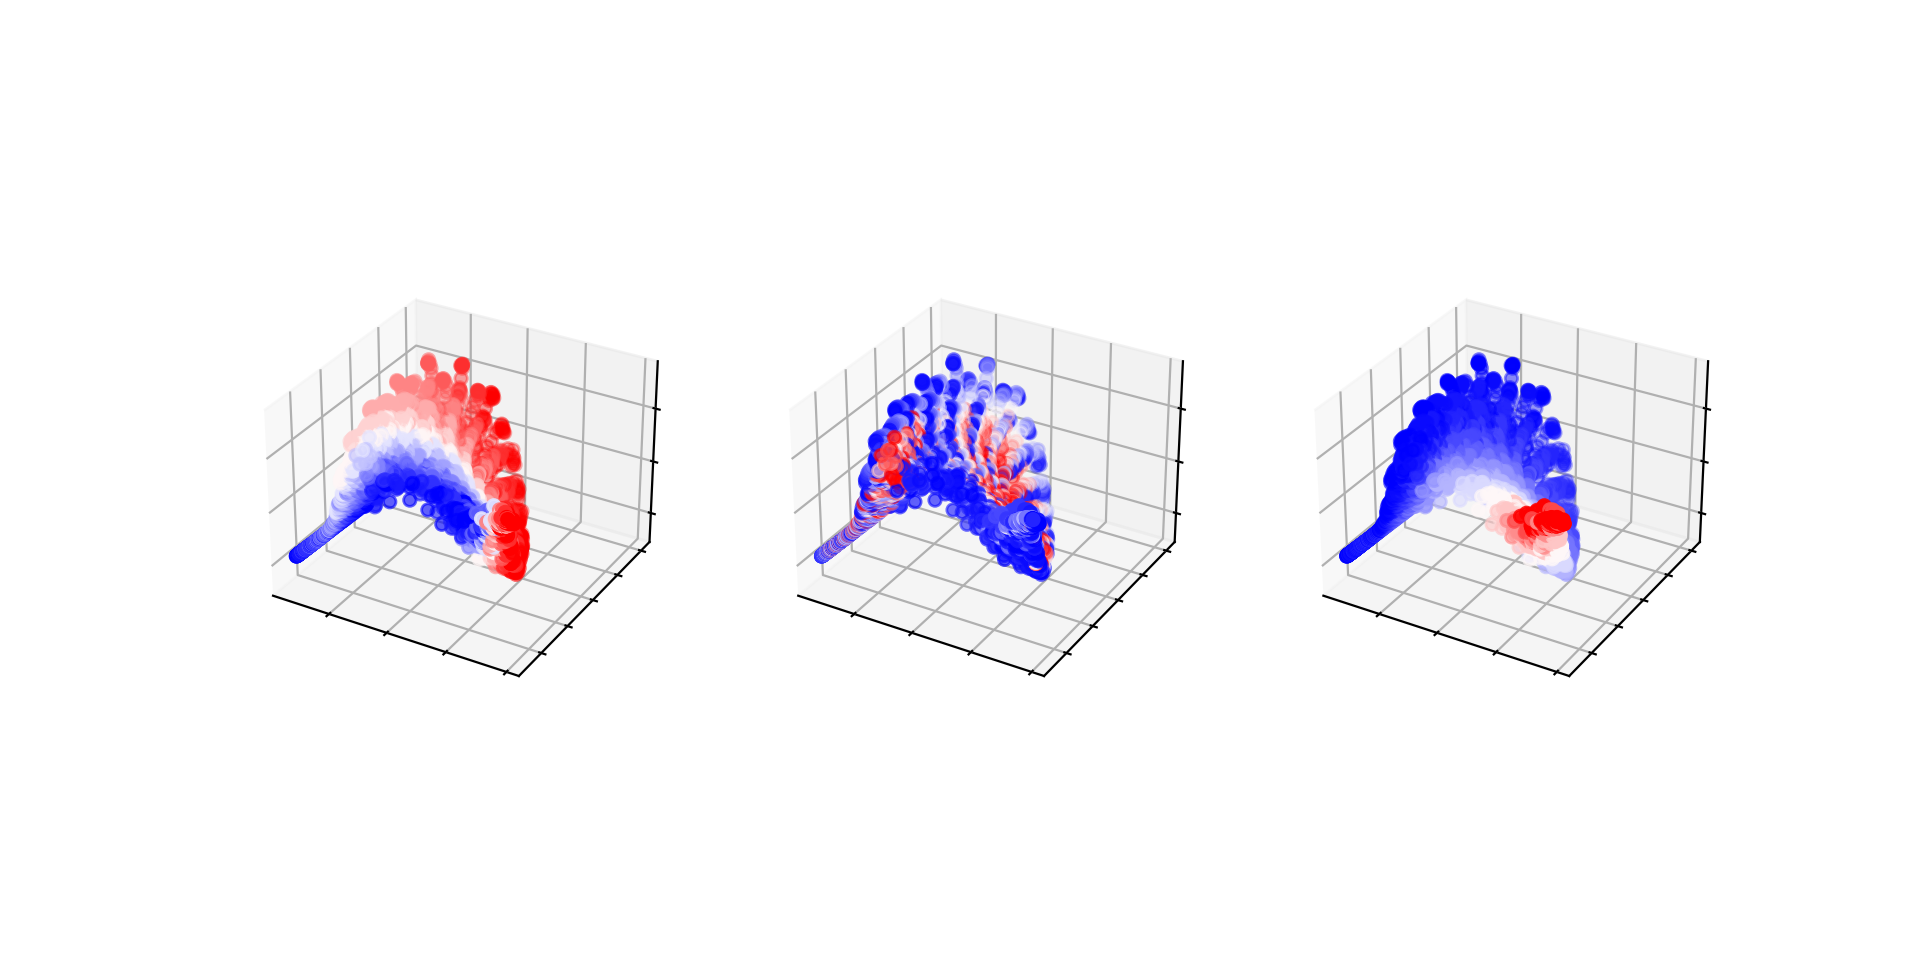

In [26]:
plot_isomap(Y, cmap)

<IPython.core.display.Javascript object>


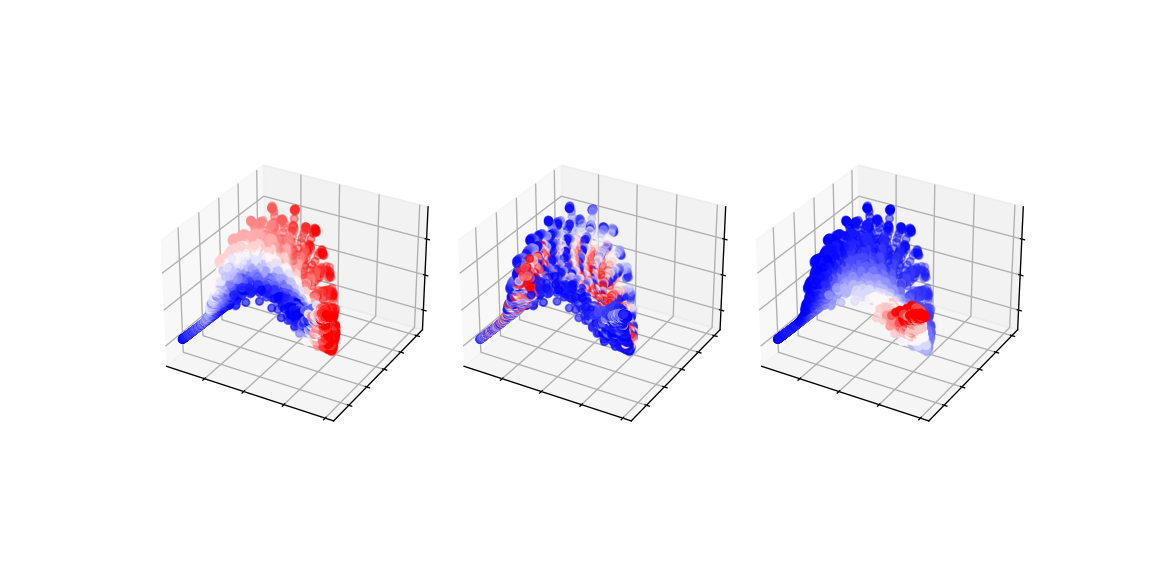

In [12]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap

%matplotlib notebook

strf_dir = '/import/c4dm-04/cv/strf'
theta_dir = '/homes/cv300/Documents/scattering/data/theta'

features = [(np.load(os.path.join(strf_dir, f)), np.load(os.path.join(theta_dir, f))) 
            for f in os.listdir(strf_dir)]
strf = np.stack([f[0] for f in features])
theta = np.stack([f[1] for f in features])

embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(strf.reshape((strf.shape[0], -1)))
plot_isomap(Y, theta.T)